**Spaceship Titanic**


Predict which passengers are transported to an alternate dimension

In [113]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


df = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


# EDA

<Axes: xlabel='count', ylabel='HomePlanet'>

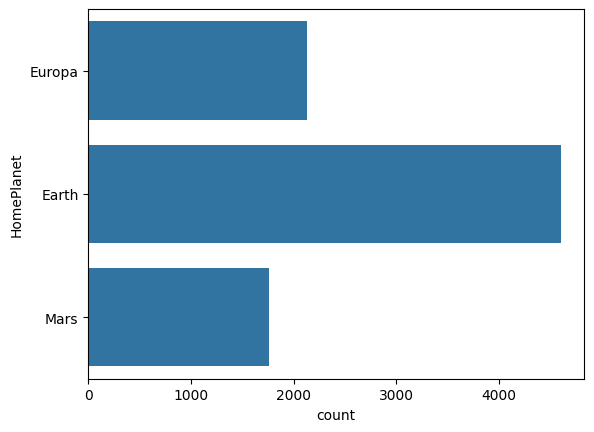

In [ ]:
sns.countplot(df['HomePlanet'])

<Axes: xlabel='count', ylabel='Destination'>

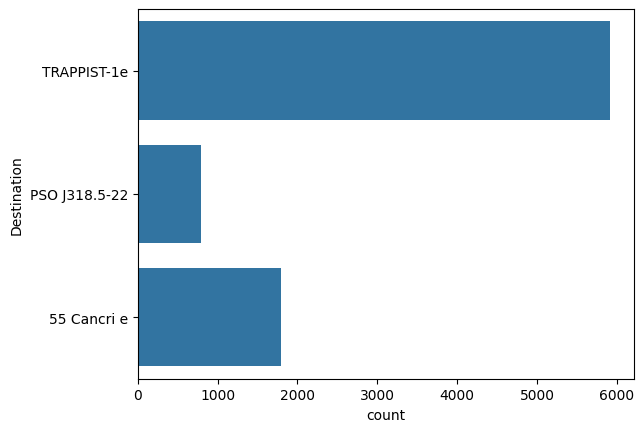

In [ ]:
sns.countplot(df['Destination'])

In [ ]:
df['Transported'].value_counts()

,count
Transported,
True,4378
False,4315


In [ ]:
df.columns

Index(['PassengerId', 'HomePlanet', 'CryoSleep', 'Destination', 'Age', 'VIP',
       'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'Transported', 'Deck', 'Num', 'Side'],
      dtype='object')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


In [ ]:
df.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,8514.000000,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000
mean,28.827930,224.687617,458.077203,173.729169,311.138778,304.854791
std,14.489021,666.717663,1611.489240,604.696458,1136.705535,1145.717189
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,38.000000,47.000000,76.000000,27.000000,59.000000,46.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000


In [ ]:
df.isna().sum()

,0
PassengerId,0
HomePlanet,0
CryoSleep,217
Destination,0
Age,179
VIP,203
RoomService,181
FoodCourt,183
ShoppingMall,208
Spa,183


# Feature Engineering

In [114]:
df['HomePlanet'] = df['HomePlanet'].fillna("unknown")
df['Destination'] = df['Destination'].fillna("unknown")
df[['Deck','Num','Side']] = df.Cabin.str.split('/',expand=True)

df_test['HomePlanet'] = df_test['HomePlanet'].fillna("unknown")
df_test['Destination'] = df_test['Destination'].fillna("unknown")
df_test[['Deck','Num','Side']] = df_test.Cabin.str.split('/',expand=True)

df.drop(columns=['Name','Cabin'],inplace=True)
df_test.drop(columns=['Name','Cabin'],inplace=True)

Para modelos baseados em árvore o ordinalencoder é uma boa opção em relação ao onehot

In [115]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.model_selection import train_test_split

std_features = ['Age','RoomService','FoodCourt','ShoppingMall','Spa','VRDeck','total_spent']
transformer = ColumnTransformer([
    ('std', StandardScaler(), std_features),
    ('ord', OrdinalEncoder( handle_unknown='use_encoded_value',unknown_value=-1), ['HomePlanet','Destination','Deck','Side','Num'])
],remainder='passthrough')

In [116]:
df_without_missing = df.dropna()
df_without_missing_test = df_test.dropna()

In [119]:
from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier
from sklearn.metrics import accuracy_score, root_mean_squared_error, classification_report
from sklearn.model_selection import train_test_split

def predict_missing_values(df_without_missing, df, feature, regressor=True):

  y = df_without_missing[feature].astype(int)
  X = df_without_missing.drop(columns=[feature])

  X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.2, random_state=42)

  std_features = ['Age','RoomService','FoodCourt','ShoppingMall','Spa','VRDeck']
  if regressor:
    std_features.remove(feature)

  transformer = ColumnTransformer([
      ('std', StandardScaler(), std_features),
      ('ord', OrdinalEncoder( handle_unknown='use_encoded_value',unknown_value=-1), ['HomePlanet','Destination','Deck','Side','Num'])
  ],remainder='passthrough')

  X_train = transformer.fit_transform(X_train)
  X_test = transformer.transform(X_test)

  if regressor:
    model = RandomForestRegressor(random_state=42)
  else:
    model = RandomForestClassifier(random_state=42)

  model.fit(X_train, y_train)

  mask = df[feature].isna()

  X_missing = df.loc[mask].copy()
  y_pred = model.predict(X_test)
  X_trans = transformer.transform(X_missing)
  y_pred_real = model.predict(X_trans)

  if regressor:
    print(f'RMSE: {root_mean_squared_error(y_pred,y_test)}')
  else:
    print(f'Acurácia: {accuracy_score(y_pred,y_test)}')
    print(classification_report(y_test,y_pred))


  df.loc[mask, feature] = y_pred_real

In [120]:
predict_missing_values(df_without_missing, df, 'CryoSleep', False)
predict_missing_values(df_without_missing, df, 'VIP', False)

predict_missing_values(df_without_missing_test, df_test, 'CryoSleep', False)
predict_missing_values(df_without_missing_test, df_test, 'VIP', False)

Acurácia: 0.9386026817219478
              precision    recall  f1-score   support

           0       0.95      0.95      0.95       904
           1       0.91      0.92      0.92       513

    accuracy                           0.94      1417
   macro avg       0.93      0.93      0.93      1417
weighted avg       0.94      0.94      0.94      1417

Acurácia: 0.9738884968242767
              precision    recall  f1-score   support

           0       0.97      1.00      0.99      1380
           1       0.00      0.00      0.00        37

    accuracy                           0.97      1417
   macro avg       0.49      0.50      0.49      1417
weighted avg       0.95      0.97      0.96      1417



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Acurácia: 0.944206008583691
              precision    recall  f1-score   support

           0       0.97      0.94      0.96       452
           1       0.90      0.94      0.92       247

    accuracy                           0.94       699
   macro avg       0.94      0.94      0.94       699
weighted avg       0.95      0.94      0.94       699

Acurácia: 0.9799713876967096
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       685
           1       0.00      0.00      0.00        14

    accuracy                           0.98       699
   macro avg       0.49      0.50      0.49       699
weighted avg       0.96      0.98      0.97       699



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [121]:
df['CryoSleep']=df['CryoSleep'].astype(int)
df['VIP'] = df['VIP'].astype(int)
df['Transported'] = df['Transported'].astype(int)

df_test['CryoSleep']=df_test['CryoSleep'].astype(int)
df_test['VIP'] = df_test['VIP'].astype(int)

In [122]:
predict_missing_values(df_without_missing, df, 'Age', True)
predict_missing_values(df_without_missing, df, 'RoomService', True)
predict_missing_values(df_without_missing, df, 'FoodCourt', True)
predict_missing_values(df_without_missing, df, 'ShoppingMall', True)
predict_missing_values(df_without_missing, df, 'Spa', True)
predict_missing_values(df_without_missing, df, 'VRDeck', True)


predict_missing_values(df_without_missing_test, df_test, 'Age', True)
predict_missing_values(df_without_missing_test, df_test, 'RoomService', True)
predict_missing_values(df_without_missing_test, df_test, 'FoodCourt', True)
predict_missing_values(df_without_missing_test, df_test, 'ShoppingMall', True)
predict_missing_values(df_without_missing_test, df_test, 'Spa', True)
predict_missing_values(df_without_missing_test, df_test, 'VRDeck', True)

df

RMSE: 13.832207764135292
RMSE: 544.5020757617197
RMSE: 1387.4023844366777
RMSE: 521.2070576353839
RMSE: 897.1156659786906
RMSE: 760.0826453078408
RMSE: 14.180775976516143
RMSE: 480.5821505482783
RMSE: 1204.273690612432
RMSE: 549.8033461152913
RMSE: 1018.9111075045446
RMSE: 1022.769130749257


,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Deck,Num,Side
0,0001_01,Europa,0,TRAPPIST-1e,39.0,0,0.0,0.0,0.0,0.0,0.0,0,B,0,P
1,0002_01,Earth,0,TRAPPIST-1e,24.0,0,109.0,9.0,25.0,549.0,44.0,1,F,0,S
2,0003_01,Europa,0,TRAPPIST-1e,58.0,1,43.0,3576.0,0.0,6715.0,49.0,0,A,0,S
3,0003_02,Europa,0,TRAPPIST-1e,33.0,0,0.0,1283.0,371.0,3329.0,193.0,0,A,0,S
4,0004_01,Earth,0,TRAPPIST-1e,16.0,0,303.0,70.0,151.0,565.0,2.0,1,F,1,S
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,9276_01,Europa,0,55 Cancri e,41.0,1,0.0,6819.0,0.0,1643.0,74.0,0,A,98,P
8689,9278_01,Earth,1,PSO J318.5-22,18.0,0,0.0,0.0,0.0,0.0,0.0,0,G,1499,S
8690,9279_01,Earth,0,TRAPPIST-1e,26.0,0,0.0,0.0,1872.0,1.0,0.0,1,G,1500,S
8691,9280_01,Europa,0,55 Cancri e,32.0,0,0.0,1049.0,0.0,353.0,3235.0,0,E,608,S


In [123]:
df['total_spent'] = df['RoomService']+ df['FoodCourt']+ df['ShoppingMall']+ df['Spa']+ df['VRDeck']
df_test['total_spent'] = df_test['RoomService']+ df_test['FoodCourt']+ df_test['ShoppingMall']+ df_test['Spa']+ df_test['VRDeck']

X = df.drop(columns=['PassengerId','Transported'])
y = df['Transported']

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=42)

X_train = transformer.fit_transform(X_train)
X_test = transformer.transform(X_test)

# Models Train

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/ut

{'subsample': 0.7, 'reg_lambda': 0.5, 'reg_alpha': 1.0, 'num_leaves': 10, 'n_estimators': 500, 'min_child_samples': 3, 'max_depth': 5, 'learning_rate': 0.1, 'colsample_bytree': 0.5}
              precision    recall  f1-score   support

           0       0.82      0.77      0.80      1289
           1       0.79      0.84      0.81      1319

    accuracy                           0.81      2608
   macro avg       0.81      0.80      0.80      2608
weighted avg       0.81      0.81      0.80      2608

Acurácia:0.8052147239263804


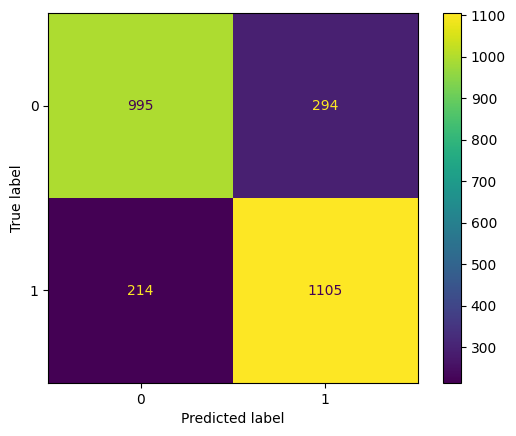

In [102]:
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV

param_grid = {
    'n_estimators': [100, 200, 300, 500, 1000, 2000],
    'max_depth': [1, 3, 5, 7, 10, 15],
    'learning_rate': [0.001, 0.01, 0.1, 1],
    'num_leaves': [10, 20, 30, 40, 50],
    'min_child_samples': [1, 3, 5, 7, 10],
    'subsample': [0.5, 0.7, 0.9, 1.0],
    'colsample_bytree': [0.5, 0.7, 0.9, 1.0],
    'reg_alpha': [0, 0.1, 0.5, 1.0],
    'reg_lambda': [0, 0.1, 0.5, 1.0],
}

model = LGBMClassifier(verbose = -1, random_state = 42)
#model.fit(X_train,y_train)
rd_search_lgb = RandomizedSearchCV(estimator=model,param_distributions=param_grid, cv=5, random_state=42)
rd_search_lgb.fit(X_train,y_train)

y_pred = rd_search_lgb.predict(X_test)

print(rd_search_lgb.best_params_)

print(classification_report(y_test,y_pred))

print(f'Acurácia:{accuracy_score(y_test,y_pred)}')

cm = confusion_matrix(y_test,y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.9s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    5.7s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    5.7s finished
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    3.9s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    3.9s finished
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.9s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    2.4s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    2.4s finished
[Parallel(n_jobs=1)]: Done  49 tasks    

{'n_estimators': 200, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_depth': 20}
              precision    recall  f1-score   support

           0       0.81      0.77      0.79      1289
           1       0.79      0.83      0.81      1319

    accuracy                           0.80      2608
   macro avg       0.80      0.80      0.80      2608
weighted avg       0.80      0.80      0.80      2608

Acurácia:0.8002300613496932


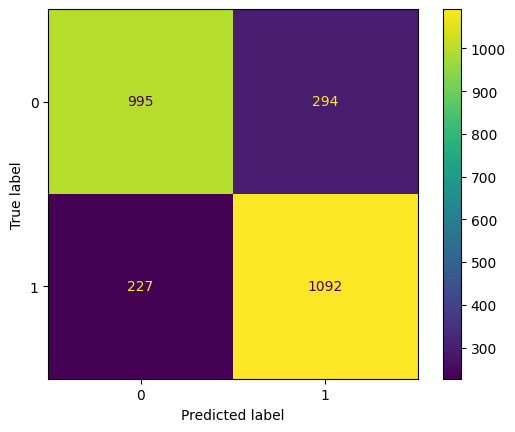

In [100]:
from sklearn.ensemble import RandomForestClassifier

param_grid = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [ 5, 7, 10, 15, 17, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2'],
    'bootstrap': [True, False],
}

model = RandomForestClassifier(verbose=1,random_state=42)
#model.fit(X_train,y_train)
rd_search_rf = RandomizedSearchCV(estimator=model,param_distributions=param_grid, cv=5, random_state=42)
rd_search_rf.fit(X_train,y_train)

y_pred = rd_search_rf.predict(X_test)

print(rd_search_rf.best_params_)

print(classification_report(y_test,y_pred))

print(f'Acurácia:{accuracy_score(y_test,y_pred)}')

cm = confusion_matrix(y_test,y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [96]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 5.9 MB/s eta 0:00:00


/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
30 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
25 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.12/dist-packages/catboost/core.py", line 5245, in fit
    self._fit(X, y, cat_features, text_features, embedding_features, None, graph, sample_weight, None, None, None, None, baseline, use_best_model,
  File "/usr/local/lib/python3.12/dist-packages/catboost/core.py", line 2395, in _fi

              precision    recall  f1-score   support

           0       0.82      0.75      0.78      1289
           1       0.77      0.84      0.81      1319

    accuracy                           0.80      2608
   macro avg       0.80      0.80      0.80      2608
weighted avg       0.80      0.80      0.80      2608

Acurácia:0.7967791411042945


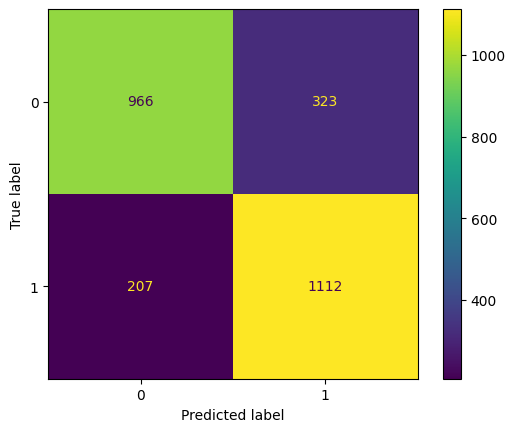

In [99]:
from catboost import CatBoostClassifier

param_grid = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [ 5, 7, 10, 15, 17, 20],
    'learning_rate': [0.001, 0.01, 0.1, 1],
    'l2_leaf_reg': [1, 3, 5, 7, 10],
    'min_child_samples': [1, 3, 5, 7, 10],
    'subsample': [0.5, 0.7, 0.9, 1.0],
    'colsample_bylevel': [0.5, 0.7, 0.9, 1.0],
    'random_strength': [0.5, 0.7, 0.9, 1.0],
    'bootstrap_type': ['Bayesian', 'Bernoulli', 'MVS'],
    'grow_policy': ['SymmetricTree', 'Depthwise', 'Lossguide'],
}

model=CatBoostClassifier(eval_metric='Accuracy',verbose=0)
#model.fit(X_train,y_train)
rd_search = RandomizedSearchCV(estimator=model,param_distributions=param_grid, cv=5, random_state=42)
rd_search.fit(X_train,y_train)

y_pred = rd_search.predict(X_test)

print(classification_report(y_test,y_pred))

print(f'Acurácia:{accuracy_score(y_test,y_pred)}')

cm = confusion_matrix(y_test,y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

[21:03:43] ======== Monitor (0): HostSketchContainer ========
[21:03:43] AllReduce: 0.001935s, 1 calls @ 1935us

[21:03:43] MakeCuts: 0.002065s, 1 calls @ 2065us

[21:03:43] INFO: /workspace/src/data/iterative_dmatrix.cc:56: Finished constructing the `IterativeDMatrix`: (4868, 14, 67825).
[21:03:43] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:03:43] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:03:44] ======== Monitor (0): GBTree ========
[21:03:44] BoostNewTrees: 0.491867s, 500 calls @ 491867us

[21:03:44] CommitModel: 0.00019s, 500 calls @ 190us

[21:03:44] ======== Monitor (0): HistUpdater ========
[21:03:44] BuildHistogram: 0.085579s, 2020 calls @ 85579us

[21:03:44] EvaluateSplits: 0.23041s, 2520 calls @ 230410us

[21:03:44] InitData: 0.004912s, 500 calls @ 4912us

[21:03:44] InitRoot: 0.092539s, 500 calls @ 92539us

[21:03:44] LeafPartition: 9.6e-05s, 500 calls @ 96us

[21:03:44] UpdatePosition: 0.075134s, 2165 calls @ 75134us

[21:03:44] UpdatePredictionCache: 0.003918s, 500 calls @ 3918us

[21:03:44] UpdateTree: 0.459934s, 500 calls @ 459934us

[21:03:44] ======== Monitor (0):  ========
[21:03:44] BuildHist: 0.104814s, 2520 calls @ 104814us

[21:03:44] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:03:44] ======== Monitor (0): HostSketchContainer ========
[21:03:44] AllReduce: 0.001891s, 1 calls @ 1891us

[21:03:44] MakeCuts: 0.001997s, 1 calls 

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:03:44] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:03:44] ======== Monitor (0): GBTree ========
[21:03:44] BoostNewTrees: 0.51157s, 500 calls @ 511570us

[21:03:44] CommitModel: 0.0002s, 500 calls @ 200us

[21:03:44] ======== Monitor (0): HistUpdater ========
[21:03:44] BuildHistogram: 0.087422s, 1910 calls @ 87422us

[21:03:44] EvaluateSplits: 0.243499s, 2410 calls @ 243499us

[21:03:44] InitData: 0.004936s, 500 calls @ 4936us

[21:03:44] InitRoot: 0.094695s, 500 calls @ 94695us

[21:03:44] LeafPartition: 8.8e-05s, 500 calls @ 88us

[21:03:44] UpdatePosition: 0.07555s, 2041 calls @ 75550us

[21:03:44] UpdatePredictionCache: 0.003869s, 500 calls @ 3869us

[21:03:44] UpdateTree: 0.480682s, 500 calls @ 480682us

[21:03:44] ======== Monitor (0):  ========
[21:03:44] BuildHist: 0.108348s, 2410 calls @ 108348us

[21:03:44] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:03:44] ======== Monitor (0): HostSketchContainer ========
[21:03:44] AllReduce: 0.001903s, 1 calls @ 1903us

[21:03:44] MakeCuts: 0.00201s, 1 calls @ 2

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:03:44] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:03:45] ======== Monitor (0): GBTree ========
[21:03:45] BoostNewTrees: 0.511485s, 500 calls @ 511485us

[21:03:45] CommitModel: 0.000213s, 500 calls @ 213us

[21:03:45] ======== Monitor (0): HistUpdater ========
[21:03:45] BuildHistogram: 0.081762s, 1997 calls @ 81762us

[21:03:45] EvaluateSplits: 0.22972s, 2497 calls @ 229720us

[21:03:45] InitData: 0.005063s, 500 calls @ 5063us

[21:03:45] InitRoot: 0.110022s, 500 calls @ 110022us

[21:03:45] LeafPartition: 9.1e-05s, 500 calls @ 91us

[21:03:45] UpdatePosition: 0.081663s, 2163 calls @ 81663us

[21:03:45] UpdatePredictionCache: 0.004174s, 500 calls @ 4174us

[21:03:45] UpdateTree: 0.476996s, 500 calls @ 476996us

[21:03:45] ======== Monitor (0):  ========
[21:03:45] BuildHist: 0.115581s, 2497 calls @ 115581us

[21:03:45] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:03:45] ======== Monitor (0): HostSketchContainer ========
[21:03:45] AllReduce: 0.001914s, 1 calls @ 1914us

[21:03:45] MakeCuts: 0.002031s, 1 call

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:03:45] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:03:46] ======== Monitor (0): GBTree ========
[21:03:46] BoostNewTrees: 0.534123s, 500 calls @ 534123us

[21:03:46] CommitModel: 0.000194s, 500 calls @ 194us

[21:03:46] ======== Monitor (0): HistUpdater ========
[21:03:46] BuildHistogram: 0.091149s, 2202 calls @ 91149us

[21:03:46] EvaluateSplits: 0.252724s, 2702 calls @ 252724us

[21:03:46] InitData: 0.005727s, 500 calls @ 5727us

[21:03:46] InitRoot: 0.099402s, 500 calls @ 99402us

[21:03:46] LeafPartition: 9.4e-05s, 500 calls @ 94us

[21:03:46] UpdatePosition: 0.081664s, 2394 calls @ 81664us

[21:03:46] UpdatePredictionCache: 0.003925s, 500 calls @ 3925us

[21:03:46] UpdateTree: 0.501559s, 500 calls @ 501559us

[21:03:46] ======== Monitor (0):  ========
[21:03:46] BuildHist: 0.112096s, 2702 calls @ 112096us

[21:03:46] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:03:46] ======== Monitor (0): HostSketchContainer ========
[21:03:46] AllReduce: 0.00188s, 1 calls @ 1880us

[21:03:46] MakeCuts: 0.00199s, 1 calls 

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:03:46] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:03:46] ======== Monitor (0): GBTree ========
[21:03:46] BoostNewTrees: 0.481677s, 500 calls @ 481677us

[21:03:46] CommitModel: 0.000227s, 500 calls @ 227us

[21:03:46] ======== Monitor (0): HistUpdater ========
[21:03:46] BuildHistogram: 0.079603s, 1857 calls @ 79603us

[21:03:46] EvaluateSplits: 0.234615s, 2357 calls @ 234615us

[21:03:46] InitData: 0.005312s, 500 calls @ 5312us

[21:03:46] InitRoot: 0.088713s, 500 calls @ 88713us

[21:03:46] LeafPartition: 8.9e-05s, 500 calls @ 89us

[21:03:46] UpdatePosition: 0.065351s, 2009 calls @ 65351us

[21:03:46] UpdatePredictionCache: 0.004098s, 500 calls @ 4098us

[21:03:46] UpdateTree: 0.44762s, 500 calls @ 447620us

[21:03:46] ======== Monitor (0):  ========
[21:03:46] BuildHist: 0.100227s, 2357 calls @ 100227us

[21:03:46] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:03:46] ======== Monitor (0): HostSketchContainer ========
[21:03:46] AllReduce: 0.001895s, 1 calls @ 1895us

[21:03:46] MakeCuts: 0.002003s, 1 calls

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:03:46] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:04:15] ======== Monitor (0): GBTree ========
[21:04:15] BoostNewTrees: 27.7143s, 1000 calls @ 27714266us

[21:04:15] CommitModel: 0.001272s, 1000 calls @ 1272us

[21:04:15] ======== Monitor (0): HistUpdater ========
[21:04:15] BuildHistogram: 8.11495s, 9000 calls @ 8114947us

[21:04:15] EvaluateSplits: 10.2214s, 10000 calls @ 10221420us

[21:04:15] InitData: 0.31913s, 1000 calls @ 319130us

[21:04:15] InitRoot: 1.21807s, 1000 calls @ 1218073us

[21:04:15] LeafPartition: 0.00047s, 1000 calls @ 470us

[21:04:15] UpdatePosition: 7.195s, 10000 calls @ 7195000us

[21:04:15] UpdatePredictionCache: 0.278439s, 1000 calls @ 278439us

[21:04:15] UpdateTree: 27.0805s, 1000 calls @ 27080539us

[21:04:15] ======== Monitor (0):  ========
[21:04:15] BuildHist: 3.64586s, 10000 calls @ 3645855us

[21:04:15] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:04:15] ======== Monitor (0): HostSketchContainer ========
[21:04:15] AllReduce: 0.001988s, 1 calls @ 1988us

[21:04:15] MakeCuts

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:04:15] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:04:37] ======== Monitor (0): GBTree ========
[21:04:37] BoostNewTrees: 20.8249s, 1000 calls @ 20824899us

[21:04:37] CommitModel: 0.001294s, 1000 calls @ 1294us

[21:04:37] ======== Monitor (0): HistUpdater ========
[21:04:37] BuildHistogram: 5.45071s, 9000 calls @ 5450708us

[21:04:37] EvaluateSplits: 9.14107s, 10000 calls @ 9141068us

[21:04:37] InitData: 0.214863s, 1000 calls @ 214863us

[21:04:37] InitRoot: 1.01664s, 1000 calls @ 1016641us

[21:04:37] LeafPartition: 0.000395s, 1000 calls @ 395us

[21:04:37] UpdatePosition: 4.55621s, 10000 calls @ 4556208us

[21:04:37] UpdatePredictionCache: 0.20822s, 1000 calls @ 208220us

[21:04:37] UpdateTree: 20.3872s, 1000 calls @ 20387239us

[21:04:37] ======== Monitor (0):  ========
[21:04:37] BuildHist: 2.60988s, 10000 calls @ 2609884us

[21:04:37] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:04:37] ======== Monitor (0): HostSketchContainer ========
[21:04:37] AllReduce: 0.003874s, 1 calls @ 3874us

[21:04:37] MakeCu

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:04:37] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:05:01] ======== Monitor (0): GBTree ========
[21:05:01] BoostNewTrees: 23.1944s, 1000 calls @ 23194372us

[21:05:01] CommitModel: 0.003273s, 1000 calls @ 3273us

[21:05:01] ======== Monitor (0): HistUpdater ========
[21:05:01] BuildHistogram: 6.58823s, 9000 calls @ 6588227us

[21:05:01] EvaluateSplits: 8.97278s, 10000 calls @ 8972779us

[21:05:01] InitData: 0.313251s, 1000 calls @ 313251us

[21:05:01] InitRoot: 1.18474s, 1000 calls @ 1184736us

[21:05:01] LeafPartition: 0.000399s, 1000 calls @ 399us

[21:05:01] UpdatePosition: 5.57484s, 10000 calls @ 5574845us

[21:05:01] UpdatePredictionCache: 0.260163s, 1000 calls @ 260163us

[21:05:01] UpdateTree: 22.6189s, 1000 calls @ 22618880us

[21:05:01] ======== Monitor (0):  ========
[21:05:01] BuildHist: 3.03218s, 10000 calls @ 3032182us

[21:05:01] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:05:01] ======== Monitor (0): HostSketchContainer ========
[21:05:01] AllReduce: 0.00363s, 1 calls @ 3630us

[21:05:01] MakeCu

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:05:01] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:05:15] ======== Monitor (0): GBTree ========
[21:05:15] BoostNewTrees: 12.9295s, 1000 calls @ 12929535us

[21:05:15] CommitModel: 0.001148s, 1000 calls @ 1148us

[21:05:15] ======== Monitor (0): HistUpdater ========
[21:05:15] BuildHistogram: 2.8304s, 9000 calls @ 2830401us

[21:05:15] EvaluateSplits: 6.75686s, 10000 calls @ 6756864us

[21:05:15] InitData: 0.10314s, 1000 calls @ 103140us

[21:05:15] InitRoot: 0.588186s, 1000 calls @ 588186us

[21:05:15] LeafPartition: 0.000344s, 1000 calls @ 344us

[21:05:15] UpdatePosition: 2.38743s, 10000 calls @ 2387426us

[21:05:15] UpdatePredictionCache: 0.082232s, 1000 calls @ 82232us

[21:05:15] UpdateTree: 12.7101s, 1000 calls @ 12710145us

[21:05:15] ======== Monitor (0):  ========
[21:05:15] BuildHist: 1.4825s, 10000 calls @ 1482504us

[21:05:15] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:05:15] ======== Monitor (0): HostSketchContainer ========
[21:05:15] AllReduce: 0.001914s, 1 calls @ 1914us

[21:05:15] MakeCuts:

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:05:15] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:05:21] ======== Monitor (0): GBTree ========
[21:05:21] BoostNewTrees: 5.32695s, 1000 calls @ 5326950us

[21:05:21] CommitModel: 0.001012s, 1000 calls @ 1012us

[21:05:21] ======== Monitor (0): HistUpdater ========
[21:05:21] BuildHistogram: 0.934602s, 9000 calls @ 934602us

[21:05:21] EvaluateSplits: 3.59454s, 10000 calls @ 3594537us

[21:05:21] InitData: 0.037989s, 1000 calls @ 37989us

[21:05:21] InitRoot: 0.198805s, 1000 calls @ 198805us

[21:05:21] LeafPartition: 0.000351s, 1000 calls @ 351us

[21:05:21] UpdatePosition: 0.433646s, 10000 calls @ 433646us

[21:05:21] UpdatePredictionCache: 0.018005s, 1000 calls @ 18005us

[21:05:21] UpdateTree: 5.27226s, 1000 calls @ 5272263us

[21:05:21] ======== Monitor (0):  ========
[21:05:21] BuildHist: 0.565437s, 10000 calls @ 565437us

[21:05:21] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:05:21] ======== Monitor (0): HostSketchContainer ========
[21:05:21] AllReduce: 0.001889s, 1 calls @ 1889us

[21:05:21] MakeCuts:

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:05:21] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:05:21] ======== Monitor (0): GBTree ========
[21:05:21] BoostNewTrees: 0.25384s, 1000 calls @ 253840us

[21:05:21] CommitModel: 0.00026s, 1000 calls @ 260us

[21:05:21] ======== Monitor (0): HistUpdater ========
[21:05:21] EvaluateSplits: 0.103652s, 1000 calls @ 103652us

[21:05:21] InitData: 0.009438s, 1000 calls @ 9438us

[21:05:21] InitRoot: 0.216731s, 1000 calls @ 216731us

[21:05:21] LeafPartition: 0.000144s, 1000 calls @ 144us

[21:05:21] UpdatePosition: 0.008863s, 237 calls @ 8863us

[21:05:21] UpdatePredictionCache: 0.01409s, 1000 calls @ 14090us

[21:05:21] UpdateTree: 0.237036s, 1000 calls @ 237036us

[21:05:21] ======== Monitor (0):  ========
[21:05:21] BuildHist: 0.092492s, 1000 calls @ 92492us

[21:05:21] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:05:21] ======== Monitor (0): HostSketchContainer ========
[21:05:21] AllReduce: 0.001882s, 1 calls @ 1882us

[21:05:21] MakeCuts: 0.002026s, 1 calls @ 2026us

[21:05:21] INFO: /workspace/src/data/iterat

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:05:21] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:05:21] ======== Monitor (0): GBTree ========
[21:05:21] BoostNewTrees: 0.248225s, 1000 calls @ 248225us

[21:05:21] CommitModel: 0.000252s, 1000 calls @ 252us

[21:05:21] ======== Monitor (0): HistUpdater ========
[21:05:21] EvaluateSplits: 0.104956s, 1000 calls @ 104956us

[21:05:21] InitData: 0.007133s, 1000 calls @ 7133us

[21:05:21] InitRoot: 0.215913s, 1000 calls @ 215913us

[21:05:21] LeafPartition: 0.000142s, 1000 calls @ 142us

[21:05:21] UpdatePosition: 0.01014s, 248 calls @ 10140us

[21:05:21] UpdatePredictionCache: 0.010368s, 1000 calls @ 10368us

[21:05:21] UpdateTree: 0.235254s, 1000 calls @ 235254us

[21:05:21] ======== Monitor (0):  ========
[21:05:21] BuildHist: 0.091895s, 1000 calls @ 91895us

[21:05:21] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:05:21] ======== Monitor (0): HostSketchContainer ========
[21:05:21] AllReduce: 0.001879s, 1 calls @ 1879us

[21:05:21] MakeCuts: 0.002001s, 1 calls @ 2001us

[21:05:21] INFO: /workspace/src/data/ite

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:05:21] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:05:22] ======== Monitor (0): GBTree ========
[21:05:22] BoostNewTrees: 0.235098s, 1000 calls @ 235098us

[21:05:22] CommitModel: 0.000251s, 1000 calls @ 251us

[21:05:22] ======== Monitor (0): HistUpdater ========
[21:05:22] EvaluateSplits: 0.101546s, 1000 calls @ 101546us

[21:05:22] InitData: 0.006896s, 1000 calls @ 6896us

[21:05:22] InitRoot: 0.206048s, 1000 calls @ 206048us

[21:05:22] LeafPartition: 0.000161s, 1000 calls @ 161us

[21:05:22] UpdatePosition: 0.010954s, 232 calls @ 10954us

[21:05:22] UpdatePredictionCache: 0.00671s, 1000 calls @ 6710us

[21:05:22] UpdateTree: 0.225867s, 1000 calls @ 225867us

[21:05:22] ======== Monitor (0):  ========
[21:05:22] BuildHist: 0.086932s, 1000 calls @ 86932us

[21:05:22] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:05:22] ======== Monitor (0): HostSketchContainer ========
[21:05:22] AllReduce: 0.001991s, 1 calls @ 1991us

[21:05:22] MakeCuts: 0.002105s, 1 calls @ 2105us

[21:05:22] INFO: /workspace/src/data/iter

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:05:22] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:05:22] ======== Monitor (0): GBTree ========
[21:05:22] BoostNewTrees: 0.231743s, 1000 calls @ 231743us

[21:05:22] CommitModel: 0.000224s, 1000 calls @ 224us

[21:05:22] ======== Monitor (0): HistUpdater ========
[21:05:22] EvaluateSplits: 0.099639s, 1000 calls @ 99639us

[21:05:22] InitData: 0.006525s, 1000 calls @ 6525us

[21:05:22] InitRoot: 0.202605s, 1000 calls @ 202605us

[21:05:22] LeafPartition: 0.000154s, 1000 calls @ 154us

[21:05:22] UpdatePosition: 0.009357s, 252 calls @ 9357us

[21:05:22] UpdatePredictionCache: 0.008876s, 1000 calls @ 8876us

[21:05:22] UpdateTree: 0.220419s, 1000 calls @ 220419us

[21:05:22] ======== Monitor (0):  ========
[21:05:22] BuildHist: 0.086401s, 1000 calls @ 86401us

[21:05:22] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:05:22] ======== Monitor (0): HostSketchContainer ========
[21:05:22] AllReduce: 0.001902s, 1 calls @ 1902us

[21:05:22] MakeCuts: 0.002011s, 1 calls @ 2011us

[21:05:22] INFO: /workspace/src/data/itera

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:05:22] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:05:23] ======== Monitor (0): GBTree ========
[21:05:23] BoostNewTrees: 0.268456s, 1000 calls @ 268456us

[21:05:23] CommitModel: 0.000303s, 1000 calls @ 303us

[21:05:23] ======== Monitor (0): HistUpdater ========
[21:05:23] EvaluateSplits: 0.11504s, 1000 calls @ 115040us

[21:05:23] InitData: 0.010144s, 1000 calls @ 10144us

[21:05:23] InitRoot: 0.226177s, 1000 calls @ 226177us

[21:05:23] LeafPartition: 0.00015s, 1000 calls @ 150us

[21:05:23] UpdatePosition: 0.009619s, 246 calls @ 9619us

[21:05:23] UpdatePredictionCache: 0.017283s, 1000 calls @ 17283us

[21:05:23] UpdateTree: 0.24812s, 1000 calls @ 248120us

[21:05:23] ======== Monitor (0):  ========
[21:05:23] BuildHist: 0.091017s, 1000 calls @ 91017us

[21:05:23] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:05:23] ======== Monitor (0): HostSketchContainer ========
[21:05:23] AllReduce: 0.001915s, 1 calls @ 1915us

[21:05:23] MakeCuts: 0.002026s, 1 calls @ 2026us

[21:05:23] INFO: /workspace/src/data/itera

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:05:23] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:05:28] ======== Monitor (0): GBTree ========
[21:05:28] BoostNewTrees: 4.4295s, 2000 calls @ 4429501us

[21:05:28] CommitModel: 0.00101s, 2000 calls @ 1010us

[21:05:28] ======== Monitor (0): HistUpdater ========
[21:05:28] BuildHistogram: 1.31862s, 10711 calls @ 1318616us

[21:05:28] EvaluateSplits: 1.28832s, 12711 calls @ 1288321us

[21:05:28] InitData: 0.074394s, 2000 calls @ 74394us

[21:05:28] InitRoot: 0.550326s, 2000 calls @ 550326us

[21:05:28] LeafPartition: 0.00038s, 2000 calls @ 380us

[21:05:28] UpdatePosition: 1.02405s, 11122 calls @ 1024048us

[21:05:28] UpdatePredictionCache: 0.053139s, 2000 calls @ 53139us

[21:05:28] UpdateTree: 4.20027s, 2000 calls @ 4200272us

[21:05:28] ======== Monitor (0):  ========
[21:05:28] BuildHist: 0.88798s, 12711 calls @ 887980us

[21:05:28] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:05:28] ======== Monitor (0): HostSketchContainer ========
[21:05:28] AllReduce: 0.001914s, 1 calls @ 1914us

[21:05:28] MakeCuts: 0.

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:05:28] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:05:30] ======== Monitor (0): GBTree ========
[21:05:30] BoostNewTrees: 2.07372s, 2000 calls @ 2073719us

[21:05:30] CommitModel: 0.000833s, 2000 calls @ 833us

[21:05:30] ======== Monitor (0): HistUpdater ========
[21:05:30] BuildHistogram: 0.460763s, 10998 calls @ 460763us

[21:05:30] EvaluateSplits: 0.832761s, 12998 calls @ 832761us

[21:05:30] InitData: 0.022673s, 2000 calls @ 22673us

[21:05:30] InitRoot: 0.304913s, 2000 calls @ 304913us

[21:05:30] LeafPartition: 0.000394s, 2000 calls @ 394us

[21:05:30] UpdatePosition: 0.355208s, 11404 calls @ 355208us

[21:05:30] UpdatePredictionCache: 0.017144s, 2000 calls @ 17144us

[21:05:30] UpdateTree: 1.95242s, 2000 calls @ 1952416us

[21:05:30] ======== Monitor (0):  ========
[21:05:30] BuildHist: 0.463631s, 12998 calls @ 463631us

[21:05:30] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:05:30] ======== Monitor (0): HostSketchContainer ========
[21:05:30] AllReduce: 0.001899s, 1 calls @ 1899us

[21:05:30] MakeCuts:

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:05:30] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:05:33] ======== Monitor (0): GBTree ========
[21:05:33] BoostNewTrees: 2.12158s, 2000 calls @ 2121576us

[21:05:33] CommitModel: 0.000842s, 2000 calls @ 842us

[21:05:33] ======== Monitor (0): HistUpdater ========
[21:05:33] BuildHistogram: 0.481656s, 11020 calls @ 481656us

[21:05:33] EvaluateSplits: 0.852426s, 13020 calls @ 852426us

[21:05:33] InitData: 0.025102s, 2000 calls @ 25102us

[21:05:33] InitRoot: 0.311081s, 2000 calls @ 311081us

[21:05:33] LeafPartition: 0.00036s, 2000 calls @ 360us

[21:05:33] UpdatePosition: 0.350984s, 11442 calls @ 350984us

[21:05:33] UpdatePredictionCache: 0.019589s, 2000 calls @ 19589us

[21:05:33] UpdateTree: 1.99491s, 2000 calls @ 1994915us

[21:05:33] ======== Monitor (0):  ========
[21:05:33] BuildHist: 0.484496s, 13020 calls @ 484496us

[21:05:33] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:05:33] ======== Monitor (0): HostSketchContainer ========
[21:05:33] AllReduce: 0.001874s, 1 calls @ 1874us

[21:05:33] MakeCuts: 

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:05:33] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:05:35] ======== Monitor (0): GBTree ========
[21:05:35] BoostNewTrees: 2.11656s, 2000 calls @ 2116558us

[21:05:35] CommitModel: 0.000774s, 2000 calls @ 774us

[21:05:35] ======== Monitor (0): HistUpdater ========
[21:05:35] BuildHistogram: 0.468035s, 11123 calls @ 468035us

[21:05:35] EvaluateSplits: 0.866134s, 13123 calls @ 866134us

[21:05:35] InitData: 0.024212s, 2000 calls @ 24212us

[21:05:35] InitRoot: 0.302452s, 2000 calls @ 302452us

[21:05:35] LeafPartition: 0.000377s, 2000 calls @ 377us

[21:05:35] UpdatePosition: 0.355157s, 11539 calls @ 355157us

[21:05:35] UpdatePredictionCache: 0.019954s, 2000 calls @ 19954us

[21:05:35] UpdateTree: 1.99273s, 2000 calls @ 1992725us

[21:05:35] ======== Monitor (0):  ========
[21:05:35] BuildHist: 0.467739s, 13123 calls @ 467739us

[21:05:35] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:05:35] ======== Monitor (0): HostSketchContainer ========
[21:05:35] AllReduce: 0.001883s, 1 calls @ 1883us

[21:05:35] MakeCuts:

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:05:35] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:05:41] ======== Monitor (0): GBTree ========
[21:05:41] BoostNewTrees: 5.25966s, 2000 calls @ 5259655us

[21:05:41] CommitModel: 0.000991s, 2000 calls @ 991us

[21:05:41] ======== Monitor (0): HistUpdater ========
[21:05:41] BuildHistogram: 1.50423s, 11113 calls @ 1504231us

[21:05:41] EvaluateSplits: 1.54787s, 13113 calls @ 1547875us

[21:05:41] InitData: 0.099079s, 2000 calls @ 99079us

[21:05:41] InitRoot: 0.718576s, 2000 calls @ 718576us

[21:05:41] LeafPartition: 0.000403s, 2000 calls @ 403us

[21:05:41] UpdatePosition: 1.12903s, 11534 calls @ 1129027us

[21:05:41] UpdatePredictionCache: 0.102557s, 2000 calls @ 102557us

[21:05:41] UpdateTree: 4.90035s, 2000 calls @ 4900351us

[21:05:41] ======== Monitor (0):  ========
[21:05:41] BuildHist: 1.0403s, 13113 calls @ 1040298us

[21:05:41] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:05:41] ======== Monitor (0): HostSketchContainer ========
[21:05:41] AllReduce: 0.001888s, 1 calls @ 1888us

[21:05:41] MakeCuts:

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:05:41] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:05:44] ======== Monitor (0): GBTree ========
[21:05:44] BoostNewTrees: 1.97573s, 1000 calls @ 1975733us

[21:05:44] CommitModel: 0.000563s, 1000 calls @ 563us

[21:05:44] ======== Monitor (0): HistUpdater ========
[21:05:44] BuildHistogram: 0.396375s, 8666 calls @ 396375us

[21:05:44] EvaluateSplits: 1.03762s, 9666 calls @ 1037622us

[21:05:44] InitData: 0.015012s, 1000 calls @ 15012us

[21:05:44] InitRoot: 0.172209s, 1000 calls @ 172209us

[21:05:44] LeafPartition: 0.000205s, 1000 calls @ 205us

[21:05:44] UpdatePosition: 0.300142s, 9327 calls @ 300142us

[21:05:44] UpdatePredictionCache: 0.010207s, 1000 calls @ 10207us

[21:05:44] UpdateTree: 1.92341s, 1000 calls @ 1923410us

[21:05:44] ======== Monitor (0):  ========
[21:05:44] BuildHist: 0.334888s, 9666 calls @ 334888us

[21:05:44] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:05:44] ======== Monitor (0): HostSketchContainer ========
[21:05:44] AllReduce: 0.001896s, 1 calls @ 1896us

[21:05:44] MakeCuts: 0.0

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:05:44] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:05:46] ======== Monitor (0): GBTree ========
[21:05:46] BoostNewTrees: 1.96264s, 1000 calls @ 1962638us

[21:05:46] CommitModel: 0.000572s, 1000 calls @ 572us

[21:05:46] ======== Monitor (0): HistUpdater ========
[21:05:46] BuildHistogram: 0.405265s, 8662 calls @ 405265us

[21:05:46] EvaluateSplits: 1.01331s, 9662 calls @ 1013312us

[21:05:46] InitData: 0.014701s, 1000 calls @ 14701us

[21:05:46] InitRoot: 0.188557s, 1000 calls @ 188557us

[21:05:46] LeafPartition: 0.000196s, 1000 calls @ 196us

[21:05:46] UpdatePosition: 0.301911s, 9291 calls @ 301911us

[21:05:46] UpdatePredictionCache: 0.010553s, 1000 calls @ 10553us

[21:05:46] UpdateTree: 1.90843s, 1000 calls @ 1908433us

[21:05:46] ======== Monitor (0):  ========
[21:05:46] BuildHist: 0.35195s, 9662 calls @ 351950us

[21:05:46] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:05:46] ======== Monitor (0): HostSketchContainer ========
[21:05:46] AllReduce: 0.001885s, 1 calls @ 1885us

[21:05:46] MakeCuts: 0.00

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:05:46] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:05:48] ======== Monitor (0): GBTree ========
[21:05:48] BoostNewTrees: 1.94487s, 1000 calls @ 1944868us

[21:05:48] CommitModel: 0.000602s, 1000 calls @ 602us

[21:05:48] ======== Monitor (0): HistUpdater ========
[21:05:48] BuildHistogram: 0.400229s, 8672 calls @ 400229us

[21:05:48] EvaluateSplits: 1.00814s, 9672 calls @ 1008139us

[21:05:48] InitData: 0.017232s, 1000 calls @ 17232us

[21:05:48] InitRoot: 0.178476s, 1000 calls @ 178476us

[21:05:48] LeafPartition: 0.000221s, 1000 calls @ 221us

[21:05:48] UpdatePosition: 0.294245s, 9308 calls @ 294245us

[21:05:48] UpdatePredictionCache: 0.010008s, 1000 calls @ 10008us

[21:05:48] UpdateTree: 1.89386s, 1000 calls @ 1893865us

[21:05:48] ======== Monitor (0):  ========
[21:05:48] BuildHist: 0.339684s, 9672 calls @ 339684us

[21:05:48] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:05:48] ======== Monitor (0): HostSketchContainer ========
[21:05:48] AllReduce: 0.001908s, 1 calls @ 1908us

[21:05:48] MakeCuts: 0.0

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:05:48] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:05:53] ======== Monitor (0): GBTree ========
[21:05:53] BoostNewTrees: 4.13618s, 1000 calls @ 4136179us

[21:05:53] CommitModel: 0.000755s, 1000 calls @ 755us

[21:05:53] ======== Monitor (0): HistUpdater ========
[21:05:53] BuildHistogram: 1.14362s, 8696 calls @ 1143622us

[21:05:53] EvaluateSplits: 1.56876s, 9696 calls @ 1568760us

[21:05:53] InitData: 0.051368s, 1000 calls @ 51368us

[21:05:53] InitRoot: 0.368469s, 1000 calls @ 368469us

[21:05:53] LeafPartition: 0.000255s, 1000 calls @ 255us

[21:05:53] UpdatePosition: 0.925497s, 9334 calls @ 925497us

[21:05:53] UpdatePredictionCache: 0.037043s, 1000 calls @ 37043us

[21:05:53] UpdateTree: 4.00739s, 1000 calls @ 4007386us

[21:05:53] ======== Monitor (0):  ========
[21:05:53] BuildHist: 0.676577s, 9696 calls @ 676577us

[21:05:53] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:05:53] ======== Monitor (0): HostSketchContainer ========
[21:05:53] AllReduce: 0.004002s, 1 calls @ 4002us

[21:05:53] MakeCuts: 0.0

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:05:53] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:05:57] ======== Monitor (0): GBTree ========
[21:05:57] BoostNewTrees: 3.942s, 1000 calls @ 3942004us

[21:05:57] CommitModel: 0.001436s, 1000 calls @ 1436us

[21:05:57] ======== Monitor (0): HistUpdater ========
[21:05:57] BuildHistogram: 0.937961s, 8678 calls @ 937961us

[21:05:57] EvaluateSplits: 1.87827s, 9678 calls @ 1878265us

[21:05:57] InitData: 0.050081s, 1000 calls @ 50081us

[21:05:57] InitRoot: 0.323049s, 1000 calls @ 323049us

[21:05:57] LeafPartition: 0.000436s, 1000 calls @ 436us

[21:05:57] UpdatePosition: 0.612923s, 9315 calls @ 612923us

[21:05:57] UpdatePredictionCache: 0.025077s, 1000 calls @ 25077us

[21:05:57] UpdateTree: 3.83565s, 1000 calls @ 3835649us

[21:05:57] ======== Monitor (0):  ========
[21:05:57] BuildHist: 0.696694s, 9678 calls @ 696694us

[21:05:57] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:05:57] ======== Monitor (0): HostSketchContainer ========
[21:05:57] AllReduce: 0.001896s, 1 calls @ 1896us

[21:05:57] MakeCuts: 0.00

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:05:57] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:06:11] ======== Monitor (0): GBTree ========
[21:06:11] BoostNewTrees: 13.2237s, 1000 calls @ 13223723us

[21:06:11] CommitModel: 0.001216s, 1000 calls @ 1216us

[21:06:11] ======== Monitor (0): HistUpdater ========
[21:06:11] BuildHistogram: 3.60338s, 13999 calls @ 3603378us

[21:06:11] EvaluateSplits: 7.33935s, 14999 calls @ 7339354us

[21:06:11] InitData: 0.120039s, 1000 calls @ 120039us

[21:06:11] InitRoot: 0.296061s, 1000 calls @ 296061us

[21:06:11] LeafPartition: 0.000486s, 1000 calls @ 486us

[21:06:11] UpdatePosition: 1.45164s, 14973 calls @ 1451635us

[21:06:11] UpdatePredictionCache: 0.042492s, 1000 calls @ 42492us

[21:06:11] UpdateTree: 13.109s, 1000 calls @ 13109026us

[21:06:11] ======== Monitor (0):  ========
[21:06:11] BuildHist: 1.7402s, 14999 calls @ 1740201us

[21:06:11] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:06:11] ======== Monitor (0): HostSketchContainer ========
[21:06:11] AllReduce: 0.001917s, 1 calls @ 1917us

[21:06:11] MakeCut

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:06:11] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:06:23] ======== Monitor (0): GBTree ========
[21:06:23] BoostNewTrees: 11.5078s, 1000 calls @ 11507836us

[21:06:23] CommitModel: 0.001157s, 1000 calls @ 1157us

[21:06:23] ======== Monitor (0): HistUpdater ========
[21:06:23] BuildHistogram: 3.03167s, 13994 calls @ 3031670us

[21:06:23] EvaluateSplits: 6.43879s, 14994 calls @ 6438791us

[21:06:23] InitData: 0.111001s, 1000 calls @ 111001us

[21:06:23] InitRoot: 0.277383s, 1000 calls @ 277383us

[21:06:23] LeafPartition: 0.000363s, 1000 calls @ 363us

[21:06:23] UpdatePosition: 1.28165s, 14957 calls @ 1281654us

[21:06:23] UpdatePredictionCache: 0.047438s, 1000 calls @ 47438us

[21:06:23] UpdateTree: 11.3852s, 1000 calls @ 11385239us

[21:06:23] ======== Monitor (0):  ========
[21:06:23] BuildHist: 1.45504s, 14994 calls @ 1455035us

[21:06:23] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:06:23] ======== Monitor (0): HostSketchContainer ========
[21:06:23] AllReduce: 0.001893s, 1 calls @ 1893us

[21:06:23] MakeC

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:06:23] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:06:34] ======== Monitor (0): GBTree ========
[21:06:34] BoostNewTrees: 10.8029s, 1000 calls @ 10802942us

[21:06:34] CommitModel: 0.001203s, 1000 calls @ 1203us

[21:06:34] ======== Monitor (0): HistUpdater ========
[21:06:34] BuildHistogram: 2.8131s, 13999 calls @ 2813103us

[21:06:34] EvaluateSplits: 6.08113s, 14999 calls @ 6081129us

[21:06:34] InitData: 0.096904s, 1000 calls @ 96904us

[21:06:34] InitRoot: 0.267212s, 1000 calls @ 267212us

[21:06:34] LeafPartition: 0.000326s, 1000 calls @ 326us

[21:06:34] UpdatePosition: 1.2272s, 14986 calls @ 1227199us

[21:06:34] UpdatePredictionCache: 0.049181s, 1000 calls @ 49181us

[21:06:34] UpdateTree: 10.6914s, 1000 calls @ 10691444us

[21:06:34] ======== Monitor (0):  ========
[21:06:34] BuildHist: 1.35953s, 14999 calls @ 1359527us

[21:06:34] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:06:34] ======== Monitor (0): HostSketchContainer ========
[21:06:34] AllReduce: 0.001891s, 1 calls @ 1891us

[21:06:34] MakeCuts

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:06:34] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:06:43] ======== Monitor (0): GBTree ========
[21:06:43] BoostNewTrees: 8.26087s, 1000 calls @ 8260870us

[21:06:43] CommitModel: 0.001112s, 1000 calls @ 1112us

[21:06:43] ======== Monitor (0): HistUpdater ========
[21:06:43] BuildHistogram: 1.85495s, 14000 calls @ 1854946us

[21:06:43] EvaluateSplits: 5.31182s, 15000 calls @ 5311817us

[21:06:43] InitData: 0.071397s, 1000 calls @ 71397us

[21:06:43] InitRoot: 0.188011s, 1000 calls @ 188011us

[21:06:43] LeafPartition: 0.000321s, 1000 calls @ 321us

[21:06:43] UpdatePosition: 0.552329s, 14994 calls @ 552329us

[21:06:43] UpdatePredictionCache: 0.025952s, 1000 calls @ 25952us

[21:06:43] UpdateTree: 8.19035s, 1000 calls @ 8190352us

[21:06:43] ======== Monitor (0):  ========
[21:06:43] BuildHist: 0.983474s, 15000 calls @ 983474us

[21:06:43] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:06:43] ======== Monitor (0): HostSketchContainer ========
[21:06:43] AllReduce: 0.002122s, 1 calls @ 2122us

[21:06:43] MakeCuts

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:06:43] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:06:55] ======== Monitor (0): GBTree ========
[21:06:55] BoostNewTrees: 11.1167s, 1000 calls @ 11116678us

[21:06:55] CommitModel: 0.001176s, 1000 calls @ 1176us

[21:06:55] ======== Monitor (0): HistUpdater ========
[21:06:55] BuildHistogram: 2.936s, 13996 calls @ 2935995us

[21:06:55] EvaluateSplits: 6.20401s, 14996 calls @ 6204011us

[21:06:55] InitData: 0.096744s, 1000 calls @ 96744us

[21:06:55] InitRoot: 0.275938s, 1000 calls @ 275938us

[21:06:55] LeafPartition: 0.000335s, 1000 calls @ 335us

[21:06:55] UpdatePosition: 1.26182s, 14947 calls @ 1261820us

[21:06:55] UpdatePredictionCache: 0.040278s, 1000 calls @ 40278us

[21:06:55] UpdateTree: 11.0161s, 1000 calls @ 11016092us

[21:06:55] ======== Monitor (0):  ========
[21:06:55] BuildHist: 1.39163s, 14996 calls @ 1391629us

[21:06:55] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:06:55] ======== Monitor (0): HostSketchContainer ========
[21:06:55] AllReduce: 0.001902s, 1 calls @ 1902us

[21:06:55] MakeCuts

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:06:55] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:06:57] ======== Monitor (0): GBTree ========
[21:06:57] BoostNewTrees: 1.47689s, 1000 calls @ 1476888us

[21:06:57] CommitModel: 0.000474s, 1000 calls @ 474us

[21:06:57] ======== Monitor (0): HistUpdater ========
[21:06:57] BuildHistogram: 0.18235s, 4000 calls @ 182350us

[21:06:57] EvaluateSplits: 0.895362s, 5000 calls @ 895362us

[21:06:57] InitData: 0.012502s, 1000 calls @ 12502us

[21:06:57] InitRoot: 0.178583s, 1000 calls @ 178583us

[21:06:57] LeafPartition: 0.000199s, 1000 calls @ 199us

[21:06:57] UpdatePosition: 0.201406s, 5000 calls @ 201406us

[21:06:57] UpdatePredictionCache: 0.009116s, 1000 calls @ 9116us

[21:06:57] UpdateTree: 1.43947s, 1000 calls @ 1439473us

[21:06:57] ======== Monitor (0):  ========
[21:06:57] BuildHist: 0.196014s, 5000 calls @ 196014us

[21:06:57] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:06:57] ======== Monitor (0): HostSketchContainer ========
[21:06:57] AllReduce: 0.001907s, 1 calls @ 1907us

[21:06:57] MakeCuts: 0.002

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:06:57] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:07:01] ======== Monitor (0): GBTree ========
[21:07:01] BoostNewTrees: 3.8426s, 1000 calls @ 3842596us

[21:07:01] CommitModel: 0.000679s, 1000 calls @ 679us

[21:07:01] ======== Monitor (0): HistUpdater ========
[21:07:01] BuildHistogram: 0.777243s, 4000 calls @ 777243us

[21:07:01] EvaluateSplits: 1.5882s, 5000 calls @ 1588200us

[21:07:01] InitData: 0.057437s, 1000 calls @ 57437us

[21:07:01] InitRoot: 0.458862s, 1000 calls @ 458862us

[21:07:01] LeafPartition: 0.002251s, 1000 calls @ 2251us

[21:07:01] UpdatePosition: 0.88984s, 5000 calls @ 889840us

[21:07:01] UpdatePredictionCache: 0.052632s, 1000 calls @ 52632us

[21:07:01] UpdateTree: 3.68584s, 1000 calls @ 3685843us

[21:07:01] ======== Monitor (0):  ========
[21:07:01] BuildHist: 0.504455s, 5000 calls @ 504455us

[21:07:01] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:07:01] ======== Monitor (0): HostSketchContainer ========
[21:07:01] AllReduce: 0.001911s, 1 calls @ 1911us

[21:07:01] MakeCuts: 0.002

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:07:01] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:07:03] ======== Monitor (0): GBTree ========
[21:07:03] BoostNewTrees: 1.49118s, 1000 calls @ 1491181us

[21:07:03] CommitModel: 0.00055s, 1000 calls @ 550us

[21:07:03] ======== Monitor (0): HistUpdater ========
[21:07:03] BuildHistogram: 0.174135s, 4000 calls @ 174135us

[21:07:03] EvaluateSplits: 0.900728s, 5000 calls @ 900728us

[21:07:03] InitData: 0.011691s, 1000 calls @ 11691us

[21:07:03] InitRoot: 0.187497s, 1000 calls @ 187497us

[21:07:03] LeafPartition: 0.00019s, 1000 calls @ 190us

[21:07:03] UpdatePosition: 0.208016s, 5000 calls @ 208016us

[21:07:03] UpdatePredictionCache: 0.010624s, 1000 calls @ 10624us

[21:07:03] UpdateTree: 1.45347s, 1000 calls @ 1453465us

[21:07:03] ======== Monitor (0):  ========
[21:07:03] BuildHist: 0.201719s, 5000 calls @ 201719us

[21:07:03] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:07:03] ======== Monitor (0): HostSketchContainer ========
[21:07:03] AllReduce: 0.001928s, 1 calls @ 1928us

[21:07:03] MakeCuts: 0.002

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:07:03] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:07:04] ======== Monitor (0): GBTree ========
[21:07:04] BoostNewTrees: 1.54613s, 1000 calls @ 1546130us

[21:07:04] CommitModel: 0.000528s, 1000 calls @ 528us

[21:07:04] ======== Monitor (0): HistUpdater ========
[21:07:04] BuildHistogram: 0.191433s, 4000 calls @ 191433us

[21:07:04] EvaluateSplits: 0.906711s, 5000 calls @ 906711us

[21:07:04] InitData: 0.015153s, 1000 calls @ 15153us

[21:07:04] InitRoot: 0.190761s, 1000 calls @ 190761us

[21:07:04] LeafPartition: 0.00019s, 1000 calls @ 190us

[21:07:04] UpdatePosition: 0.226755s, 5000 calls @ 226755us

[21:07:04] UpdatePredictionCache: 0.009153s, 1000 calls @ 9153us

[21:07:04] UpdateTree: 1.50304s, 1000 calls @ 1503043us

[21:07:04] ======== Monitor (0):  ========
[21:07:04] BuildHist: 0.21459s, 5000 calls @ 214590us

[21:07:04] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:07:04] ======== Monitor (0): HostSketchContainer ========
[21:07:04] AllReduce: 0.001893s, 1 calls @ 1893us

[21:07:04] MakeCuts: 0.0020

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:07:04] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:07:06] ======== Monitor (0): GBTree ========
[21:07:06] BoostNewTrees: 1.47295s, 1000 calls @ 1472946us

[21:07:06] CommitModel: 0.000465s, 1000 calls @ 465us

[21:07:06] ======== Monitor (0): HistUpdater ========
[21:07:06] BuildHistogram: 0.173394s, 4000 calls @ 173394us

[21:07:06] EvaluateSplits: 0.887835s, 5000 calls @ 887835us

[21:07:06] InitData: 0.011662s, 1000 calls @ 11662us

[21:07:06] InitRoot: 0.183779s, 1000 calls @ 183779us

[21:07:06] LeafPartition: 0.000196s, 1000 calls @ 196us

[21:07:06] UpdatePosition: 0.211985s, 5000 calls @ 211985us

[21:07:06] UpdatePredictionCache: 0.008937s, 1000 calls @ 8937us

[21:07:06] UpdateTree: 1.43693s, 1000 calls @ 1436931us

[21:07:06] ======== Monitor (0):  ========
[21:07:06] BuildHist: 0.199801s, 5000 calls @ 199801us

[21:07:06] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:07:06] ======== Monitor (0): HostSketchContainer ========
[21:07:06] AllReduce: 0.001894s, 1 calls @ 1894us

[21:07:06] MakeCuts: 0.00

/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
15 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.12/dist-packages/xgboost/core.py", line 774, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xgboost/sklearn.py", line 1806, in fit
    self._Booster = train(
                    ^^^^^^
  File "/usr/local/lib/python3.12/dis

[21:07:08] ======== Monitor (0): GBTree ========
[21:07:08] BoostNewTrees: 1.63463s, 1000 calls @ 1634627us

[21:07:08] CommitModel: 0.000539s, 1000 calls @ 539us

[21:07:08] ======== Monitor (0): HistUpdater ========
[21:07:08] BuildHistogram: 0.198925s, 4000 calls @ 198925us

[21:07:08] EvaluateSplits: 0.955092s, 5000 calls @ 955092us

[21:07:08] InitData: 0.012193s, 1000 calls @ 12193us

[21:07:08] InitRoot: 0.21052s, 1000 calls @ 210520us

[21:07:08] LeafPartition: 0.000197s, 1000 calls @ 197us

[21:07:08] UpdatePosition: 0.242522s, 5000 calls @ 242522us

[21:07:08] UpdatePredictionCache: 0.012379s, 1000 calls @ 12379us

[21:07:08] UpdateTree: 1.58779s, 1000 calls @ 1587790us

[21:07:08] ======== Monitor (0):  ========
[21:07:08] BuildHist: 0.243031s, 5000 calls @ 243031us

[21:07:08] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
              precision    recall  f1-score   support

           0       0.82      0.77      0.79      1289
           1       0.79      

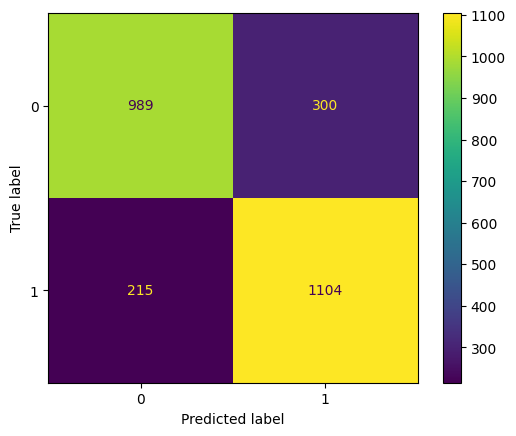

In [105]:
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV

param_grid = {
    'n_estimators': [100, 200, 300, 500, 1000, 2000],
    'max_depth': [1, 3, 5, 7, 10, 15],
    'learning_rate': [0.001, 0.01, 0.1, 1],
    'subsample': [0.5, 0.7, 0.9, 1.0],
    'colsample_bytree': [0.5, 0.7, 0.9, 1.0],
    'reg_alpha': [0, 0.1, 0.5, 1.0],
    'reg_lambda': [0, 0.1, 0.5, 1.0],
    'gamma': [0, 0.1, 0.5, 1.0],
    'min_child_weight': [1, 3, 5, 7, 10],
    'scale_pos_weight': [1, 3, 5, 7, 10],
    'base_score': [0.5, 0.7, 0.9, 1.0],
}

model = XGBClassifier(objetive='binary:logistic', verbosity=3,random_state=42)
#model.fit(X_train,y_train)
rd_search_xgb = RandomizedSearchCV(estimator=model,param_distributions=param_grid, cv=5, random_state=42)
rd_search_xgb.fit(X_train,y_train)

y_pred = rd_search_xgb.predict(X_test)

print(classification_report(y_test,y_pred))

print(f'Acurácia:{accuracy_score(y_test,y_pred)}')

cm = confusion_matrix(y_test,y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [106]:
rd_search_xgb.best_params_

{'subsample': 0.9,
 'scale_pos_weight': 1,
 'reg_lambda': 0.5,
 'reg_alpha': 0.5,
 'n_estimators': 1000,
 'min_child_weight': 1,
 'max_depth': 5,
 'learning_rate': 0.01,
 'gamma': 0.1,
 'colsample_bytree': 0.9,
 'base_score': 0.9}

In [107]:
rd_search_lgb

RandomizedSearchCV(cv=5, estimator=LGBMClassifier(random_state=42, verbose=-1),
                   param_distributions={'colsample_bytree': [0.5, 0.7, 0.9,
                                                             1.0],
                                        'learning_rate': [0.001, 0.01, 0.1, 1],
                                        'max_depth': [1, 3, 5, 7, 10, 15],
                                        'min_child_samples': [1, 3, 5, 7, 10],
                                        'n_estimators': [100, 200, 300, 500,
                                                         1000, 2000],
                                        'num_leaves': [10, 20, 30, 40, 50],
                                        'reg_alpha': [0, 0.1, 0.5, 1.0],
                                        'reg_lambda': [0, 0.1, 0.5, 1.0],
                                        'subsample': [0.5, 0.7, 0.9, 1.0]},
                   random_state=42)

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/ut

[21:08:28] ======== Monitor (0): HostSketchContainer ========
[21:08:28] AllReduce: 0.00396s, 1 calls @ 3960us

[21:08:28] MakeCuts: 0.008832s, 1 calls @ 8832us

[21:08:28] INFO: /workspace/src/data/iterative_dmatrix.cc:56: Finished constructing the `IterativeDMatrix`: (4868, 14, 67825).
[21:08:28] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:08:28] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:08:31] ======== Monitor (0): GBTree ========
[21:08:31] BoostNewTrees: 2.30333s, 500 calls @ 2303330us

[21:08:31] CommitModel: 0.000355s, 500 calls @ 355us

[21:08:31] ======== Monitor (0): HistUpdater ========
[21:08:31] BuildHistogram: 0.611482s, 2020 calls @ 611482us

[21:08:31] EvaluateSplits: 0.600581s, 2520 calls @ 600581us

[21:08:31] InitData: 0.05749s, 500 calls @ 57490us

[21:08:31] InitRoot: 0.342259s, 500 calls @ 342259us

[21:08:31] LeafPartition: 0.000132s, 500 calls @ 132us

[21:08:31] UpdatePosition: 0.588945s, 2165 calls @ 588945us

[21:08:31] UpdatePredictionCache: 0.029959s, 500 calls @ 29959us

[21:08:31] UpdateTree: 2.11395s, 500 calls @ 2113948us

[21:08:31] ======== Monitor (0):  ========
[21:08:31] BuildHist: 0.41994s, 2520 calls @ 419940us

[21:08:31] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:08:31] ======== Monitor (0): HostSketchContainer ========
[21:08:31] AllReduce: 0.001918s, 1 calls @ 1918us

[21:08:31] MakeCuts: 0.002025s, 1

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:08:31] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:08:32] ======== Monitor (0): GBTree ========
[21:08:32] BoostNewTrees: 0.970966s, 500 calls @ 970966us

[21:08:32] CommitModel: 0.000264s, 500 calls @ 264us

[21:08:32] ======== Monitor (0): HistUpdater ========
[21:08:32] BuildHistogram: 0.210201s, 1910 calls @ 210201us

[21:08:32] EvaluateSplits: 0.358903s, 2410 calls @ 358903us

[21:08:32] InitData: 0.010202s, 500 calls @ 10202us

[21:08:32] InitRoot: 0.164886s, 500 calls @ 164886us

[21:08:32] LeafPartition: 0.00011s, 500 calls @ 110us

[21:08:32] UpdatePosition: 0.214467s, 2041 calls @ 214467us

[21:08:32] UpdatePredictionCache: 0.007575s, 500 calls @ 7575us

[21:08:32] UpdateTree: 0.92189s, 500 calls @ 921890us

[21:08:32] ======== Monitor (0):  ========
[21:08:32] BuildHist: 0.191179s, 2410 calls @ 191179us

[21:08:32] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:08:32] ======== Monitor (0): HostSketchContainer ========
[21:08:32] AllReduce: 0.00304s, 1 calls @ 3040us

[21:08:32] MakeCuts: 0.003168s, 1 c

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:08:32] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:08:33] ======== Monitor (0): GBTree ========
[21:08:33] BoostNewTrees: 0.514235s, 500 calls @ 514235us

[21:08:33] CommitModel: 0.00021s, 500 calls @ 210us

[21:08:33] ======== Monitor (0): HistUpdater ========
[21:08:33] BuildHistogram: 0.095964s, 1997 calls @ 95964us

[21:08:33] EvaluateSplits: 0.228691s, 2497 calls @ 228691us

[21:08:33] InitData: 0.005242s, 500 calls @ 5242us

[21:08:33] InitRoot: 0.101323s, 500 calls @ 101323us

[21:08:33] LeafPartition: 9.5e-05s, 500 calls @ 95us

[21:08:33] UpdatePosition: 0.079766s, 2163 calls @ 79766us

[21:08:33] UpdatePredictionCache: 0.004071s, 500 calls @ 4071us

[21:08:33] UpdateTree: 0.481066s, 500 calls @ 481066us

[21:08:33] ======== Monitor (0):  ========
[21:08:33] BuildHist: 0.111753s, 2497 calls @ 111753us

[21:08:33] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:08:33] ======== Monitor (0): HostSketchContainer ========
[21:08:33] AllReduce: 0.001918s, 1 calls @ 1918us

[21:08:33] MakeCuts: 0.002027s, 1 call

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:08:33] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:08:34] ======== Monitor (0): GBTree ========
[21:08:34] BoostNewTrees: 1.26853s, 500 calls @ 1268533us

[21:08:34] CommitModel: 0.000294s, 500 calls @ 294us

[21:08:34] ======== Monitor (0): HistUpdater ========
[21:08:34] BuildHistogram: 0.313422s, 2202 calls @ 313422us

[21:08:34] EvaluateSplits: 0.418109s, 2702 calls @ 418109us

[21:08:34] InitData: 0.023981s, 500 calls @ 23981us

[21:08:34] InitRoot: 0.239184s, 500 calls @ 239184us

[21:08:34] LeafPartition: 0.000104s, 500 calls @ 104us

[21:08:34] UpdatePosition: 0.242861s, 2394 calls @ 242861us

[21:08:34] UpdatePredictionCache: 0.026735s, 500 calls @ 26735us

[21:08:34] UpdateTree: 1.16719s, 500 calls @ 1167187us

[21:08:34] ======== Monitor (0):  ========
[21:08:34] BuildHist: 0.266249s, 2702 calls @ 266249us

[21:08:34] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:08:35] ======== Monitor (0): HostSketchContainer ========
[21:08:35] AllReduce: 0.00396s, 1 calls @ 3960us

[21:08:35] MakeCuts: 0.007825s, 

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:08:35] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:08:37] ======== Monitor (0): GBTree ========
[21:08:37] BoostNewTrees: 1.76471s, 500 calls @ 1764708us

[21:08:37] CommitModel: 0.000386s, 500 calls @ 386us

[21:08:37] ======== Monitor (0): HistUpdater ========
[21:08:37] BuildHistogram: 0.456795s, 1857 calls @ 456795us

[21:08:37] EvaluateSplits: 0.485085s, 2357 calls @ 485085us

[21:08:37] InitData: 0.036092s, 500 calls @ 36092us

[21:08:37] InitRoot: 0.25471s, 500 calls @ 254710us

[21:08:37] LeafPartition: 0.000112s, 500 calls @ 112us

[21:08:37] UpdatePosition: 0.459039s, 2009 calls @ 459039us

[21:08:37] UpdatePredictionCache: 0.023786s, 500 calls @ 23786us

[21:08:37] UpdateTree: 1.63289s, 500 calls @ 1632893us

[21:08:37] ======== Monitor (0):  ========
[21:08:37] BuildHist: 0.318085s, 2357 calls @ 318085us

[21:08:37] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:08:37] ======== Monitor (0): HostSketchContainer ========
[21:08:37] AllReduce: 0.002031s, 1 calls @ 2031us

[21:08:37] MakeCuts: 0.002144s, 

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:08:37] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:08:45] ======== Monitor (0): GBTree ========
[21:08:45] BoostNewTrees: 7.64607s, 1000 calls @ 7646068us

[21:08:45] CommitModel: 0.000922s, 1000 calls @ 922us

[21:08:45] ======== Monitor (0): HistUpdater ========
[21:08:45] BuildHistogram: 1.72581s, 9000 calls @ 1725809us

[21:08:45] EvaluateSplits: 4.25429s, 10000 calls @ 4254295us

[21:08:45] InitData: 0.061751s, 1000 calls @ 61751us

[21:08:45] InitRoot: 0.319877s, 1000 calls @ 319877us

[21:08:45] LeafPartition: 0.000319s, 1000 calls @ 319us

[21:08:45] UpdatePosition: 1.10166s, 10000 calls @ 1101661us

[21:08:45] UpdatePredictionCache: 0.05134s, 1000 calls @ 51340us

[21:08:45] UpdateTree: 7.52791s, 1000 calls @ 7527913us

[21:08:45] ======== Monitor (0):  ========
[21:08:45] BuildHist: 0.907164s, 10000 calls @ 907164us

[21:08:45] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:08:45] ======== Monitor (0): HostSketchContainer ========
[21:08:45] AllReduce: 0.001888s, 1 calls @ 1888us

[21:08:45] MakeCuts: 0

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:08:45] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:08:50] ======== Monitor (0): GBTree ========
[21:08:50] BoostNewTrees: 5.23266s, 1000 calls @ 5232656us

[21:08:50] CommitModel: 0.00091s, 1000 calls @ 910us

[21:08:50] ======== Monitor (0): HistUpdater ========
[21:08:50] BuildHistogram: 0.895879s, 9000 calls @ 895879us

[21:08:50] EvaluateSplits: 3.55132s, 10000 calls @ 3551318us

[21:08:50] InitData: 0.035401s, 1000 calls @ 35401us

[21:08:50] InitRoot: 0.196665s, 1000 calls @ 196665us

[21:08:50] LeafPartition: 0.000296s, 1000 calls @ 296us

[21:08:50] UpdatePosition: 0.431689s, 10000 calls @ 431689us

[21:08:50] UpdatePredictionCache: 0.016512s, 1000 calls @ 16512us

[21:08:50] UpdateTree: 5.18089s, 1000 calls @ 5180888us

[21:08:50] ======== Monitor (0):  ========
[21:08:50] BuildHist: 0.549982s, 10000 calls @ 549982us

[21:08:50] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:08:51] ======== Monitor (0): HostSketchContainer ========
[21:08:51] AllReduce: 0.001924s, 1 calls @ 1924us

[21:08:51] MakeCuts: 0

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:08:51] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:09:04] ======== Monitor (0): GBTree ========
[21:09:04] BoostNewTrees: 12.7635s, 1000 calls @ 12763524us

[21:09:04] CommitModel: 0.001135s, 1000 calls @ 1135us

[21:09:04] ======== Monitor (0): HistUpdater ========
[21:09:04] BuildHistogram: 3.01532s, 9000 calls @ 3015323us

[21:09:04] EvaluateSplits: 5.95141s, 10000 calls @ 5951405us

[21:09:04] InitData: 0.167318s, 1000 calls @ 167318us

[21:09:04] InitRoot: 0.703282s, 1000 calls @ 703282us

[21:09:04] LeafPartition: 0.000325s, 1000 calls @ 325us

[21:09:04] UpdatePosition: 2.63186s, 10000 calls @ 2631857us

[21:09:04] UpdatePredictionCache: 0.123906s, 1000 calls @ 123906us

[21:09:04] UpdateTree: 12.4599s, 1000 calls @ 12459926us

[21:09:04] ======== Monitor (0):  ========
[21:09:04] BuildHist: 1.5553s, 10000 calls @ 1555299us

[21:09:04] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:09:04] ======== Monitor (0): HostSketchContainer ========
[21:09:04] AllReduce: 0.003983s, 1 calls @ 3983us

[21:09:04] MakeCu

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:09:04] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:09:26] ======== Monitor (0): GBTree ========
[21:09:26] BoostNewTrees: 21.1119s, 1000 calls @ 21111866us

[21:09:26] CommitModel: 0.00324s, 1000 calls @ 3240us

[21:09:26] ======== Monitor (0): HistUpdater ========
[21:09:26] BuildHistogram: 5.53164s, 9000 calls @ 5531643us

[21:09:26] EvaluateSplits: 9.10053s, 10000 calls @ 9100530us

[21:09:26] InitData: 0.273776s, 1000 calls @ 273776us

[21:09:26] InitRoot: 1.1893s, 1000 calls @ 1189301us

[21:09:26] LeafPartition: 0.000314s, 1000 calls @ 314us

[21:09:26] UpdatePosition: 4.55692s, 10000 calls @ 4556920us

[21:09:26] UpdatePredictionCache: 0.181629s, 1000 calls @ 181629us

[21:09:26] UpdateTree: 20.6472s, 1000 calls @ 20647237us

[21:09:26] ======== Monitor (0):  ========
[21:09:26] BuildHist: 2.742s, 10000 calls @ 2741998us

[21:09:26] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:09:26] ======== Monitor (0): HostSketchContainer ========
[21:09:26] AllReduce: 0.002821s, 1 calls @ 2821us

[21:09:26] MakeCuts:

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:09:26] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:09:52] ======== Monitor (0): GBTree ========
[21:09:52] BoostNewTrees: 24.4118s, 1000 calls @ 24411821us

[21:09:52] CommitModel: 0.00308s, 1000 calls @ 3080us

[21:09:52] ======== Monitor (0): HistUpdater ========
[21:09:52] BuildHistogram: 7.03274s, 9000 calls @ 7032737us

[21:09:52] EvaluateSplits: 9.47279s, 10000 calls @ 9472791us

[21:09:52] InitData: 0.257003s, 1000 calls @ 257003us

[21:09:52] InitRoot: 1.26516s, 1000 calls @ 1265163us

[21:09:52] LeafPartition: 0.000335s, 1000 calls @ 335us

[21:09:52] UpdatePosition: 5.86474s, 10000 calls @ 5864742us

[21:09:52] UpdatePredictionCache: 0.243471s, 1000 calls @ 243471us

[21:09:52] UpdateTree: 23.851s, 1000 calls @ 23850997us

[21:09:52] ======== Monitor (0):  ========
[21:09:52] BuildHist: 3.23942s, 10000 calls @ 3239417us

[21:09:52] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:09:52] ======== Monitor (0): HostSketchContainer ========
[21:09:52] AllReduce: 0.005868s, 1 calls @ 5868us

[21:09:52] MakeCut

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:09:52] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:09:53] ======== Monitor (0): GBTree ========
[21:09:53] BoostNewTrees: 0.85753s, 1000 calls @ 857530us

[21:09:53] CommitModel: 0.002443s, 1000 calls @ 2443us

[21:09:53] ======== Monitor (0): HistUpdater ========
[21:09:53] EvaluateSplits: 0.239914s, 1000 calls @ 239914us

[21:09:53] InitData: 0.062305s, 1000 calls @ 62305us

[21:09:53] InitRoot: 0.571521s, 1000 calls @ 571521us

[21:09:53] LeafPartition: 0.000195s, 1000 calls @ 195us

[21:09:53] UpdatePosition: 0.128757s, 237 calls @ 128757us

[21:09:53] UpdatePredictionCache: 0.084214s, 1000 calls @ 84214us

[21:09:53] UpdateTree: 0.768101s, 1000 calls @ 768101us

[21:09:53] ======== Monitor (0):  ========
[21:09:53] BuildHist: 0.247859s, 1000 calls @ 247859us

[21:09:53] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:09:53] ======== Monitor (0): HostSketchContainer ========
[21:09:53] AllReduce: 0.003006s, 1 calls @ 3006us

[21:09:53] MakeCuts: 0.003119s, 1 calls @ 3119us

[21:09:53] INFO: /workspace/src/data

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:09:53] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:09:55] ======== Monitor (0): GBTree ========
[21:09:55] BoostNewTrees: 0.824979s, 1000 calls @ 824979us

[21:09:55] CommitModel: 0.000419s, 1000 calls @ 419us

[21:09:55] ======== Monitor (0): HistUpdater ========
[21:09:55] EvaluateSplits: 0.238414s, 1000 calls @ 238414us

[21:09:55] InitData: 0.077792s, 1000 calls @ 77792us

[21:09:55] InitRoot: 0.577698s, 1000 calls @ 577698us

[21:09:55] LeafPartition: 0.00022s, 1000 calls @ 220us

[21:09:55] UpdatePosition: 0.054027s, 248 calls @ 54027us

[21:09:55] UpdatePredictionCache: 0.104935s, 1000 calls @ 104935us

[21:09:55] UpdateTree: 0.712863s, 1000 calls @ 712863us

[21:09:55] ======== Monitor (0):  ========
[21:09:55] BuildHist: 0.23215s, 1000 calls @ 232150us

[21:09:55] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:09:55] ======== Monitor (0): HostSketchContainer ========
[21:09:55] AllReduce: 0.00314s, 1 calls @ 3140us

[21:09:55] MakeCuts: 0.00326s, 1 calls @ 3260us

[21:09:55] INFO: /workspace/src/data/ite

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:09:55] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:09:56] ======== Monitor (0): GBTree ========
[21:09:56] BoostNewTrees: 0.774956s, 1000 calls @ 774956us

[21:09:56] CommitModel: 0.000737s, 1000 calls @ 737us

[21:09:56] ======== Monitor (0): HistUpdater ========
[21:09:56] EvaluateSplits: 0.22408s, 1000 calls @ 224080us

[21:09:56] InitData: 0.049142s, 1000 calls @ 49142us

[21:09:56] InitRoot: 0.562874s, 1000 calls @ 562874us

[21:09:56] LeafPartition: 0.000203s, 1000 calls @ 203us

[21:09:56] UpdatePosition: 0.071319s, 232 calls @ 71319us

[21:09:56] UpdatePredictionCache: 0.079256s, 1000 calls @ 79256us

[21:09:56] UpdateTree: 0.690686s, 1000 calls @ 690686us

[21:09:56] ======== Monitor (0):  ========
[21:09:56] BuildHist: 0.21805s, 1000 calls @ 218050us

[21:09:56] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:09:56] ======== Monitor (0): HostSketchContainer ========
[21:09:56] AllReduce: 0.003643s, 1 calls @ 3643us

[21:09:56] MakeCuts: 0.007463s, 1 calls @ 7463us

[21:09:56] INFO: /workspace/src/data/it

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:09:56] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:09:57] ======== Monitor (0): GBTree ========
[21:09:57] BoostNewTrees: 0.797251s, 1000 calls @ 797251us

[21:09:57] CommitModel: 0.000435s, 1000 calls @ 435us

[21:09:57] ======== Monitor (0): HistUpdater ========
[21:09:57] EvaluateSplits: 0.23691s, 1000 calls @ 236910us

[21:09:57] InitData: 0.064448s, 1000 calls @ 64448us

[21:09:57] InitRoot: 0.592052s, 1000 calls @ 592052us

[21:09:57] LeafPartition: 0.000204s, 1000 calls @ 204us

[21:09:57] UpdatePosition: 0.041111s, 252 calls @ 41111us

[21:09:57] UpdatePredictionCache: 0.084001s, 1000 calls @ 84001us

[21:09:57] UpdateTree: 0.705079s, 1000 calls @ 705079us

[21:09:57] ======== Monitor (0):  ========
[21:09:57] BuildHist: 0.234719s, 1000 calls @ 234719us

[21:09:57] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:09:57] ======== Monitor (0): HostSketchContainer ========
[21:09:57] AllReduce: 0.003182s, 1 calls @ 3182us

[21:09:57] MakeCuts: 0.003297s, 1 calls @ 3297us

[21:09:57] INFO: /workspace/src/data/i

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:09:57] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:09:58] ======== Monitor (0): GBTree ========
[21:09:58] BoostNewTrees: 0.574026s, 1000 calls @ 574026us

[21:09:58] CommitModel: 0.000385s, 1000 calls @ 385us

[21:09:58] ======== Monitor (0): HistUpdater ========
[21:09:58] EvaluateSplits: 0.227066s, 1000 calls @ 227066us

[21:09:58] InitData: 0.020642s, 1000 calls @ 20642us

[21:09:58] InitRoot: 0.483056s, 1000 calls @ 483056us

[21:09:58] LeafPartition: 0.000187s, 1000 calls @ 187us

[21:09:58] UpdatePosition: 0.025529s, 246 calls @ 25529us

[21:09:58] UpdatePredictionCache: 0.030615s, 1000 calls @ 30615us

[21:09:58] UpdateTree: 0.532348s, 1000 calls @ 532348us

[21:09:58] ======== Monitor (0):  ========
[21:09:58] BuildHist: 0.212097s, 1000 calls @ 212097us

[21:09:58] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:09:58] ======== Monitor (0): HostSketchContainer ========
[21:09:58] AllReduce: 0.005837s, 1 calls @ 5837us

[21:09:58] MakeCuts: 0.005979s, 1 calls @ 5979us

[21:09:58] INFO: /workspace/src/data/

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:09:58] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:10:09] ======== Monitor (0): GBTree ========
[21:10:09] BoostNewTrees: 9.50963s, 2000 calls @ 9509632us

[21:10:09] CommitModel: 0.001563s, 2000 calls @ 1563us

[21:10:09] ======== Monitor (0): HistUpdater ========
[21:10:09] BuildHistogram: 2.71482s, 10711 calls @ 2714822us

[21:10:09] EvaluateSplits: 2.66174s, 12711 calls @ 2661741us

[21:10:09] InitData: 0.208012s, 2000 calls @ 208012us

[21:10:09] InitRoot: 1.20373s, 2000 calls @ 1203730us

[21:10:09] LeafPartition: 0.000523s, 2000 calls @ 523us

[21:10:09] UpdatePosition: 2.25435s, 11122 calls @ 2254350us

[21:10:09] UpdatePredictionCache: 0.17294s, 2000 calls @ 172940us

[21:10:09] UpdateTree: 8.89529s, 2000 calls @ 8895288us

[21:10:09] ======== Monitor (0):  ========
[21:10:09] BuildHist: 1.89046s, 12711 calls @ 1890462us

[21:10:09] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:10:09] ======== Monitor (0): HostSketchContainer ========
[21:10:09] AllReduce: 0.001951s, 1 calls @ 1951us

[21:10:09] MakeCut

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:10:09] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:10:20] ======== Monitor (0): GBTree ========
[21:10:20] BoostNewTrees: 9.50856s, 2000 calls @ 9508564us

[21:10:20] CommitModel: 0.001491s, 2000 calls @ 1491us

[21:10:20] ======== Monitor (0): HistUpdater ========
[21:10:20] BuildHistogram: 2.9066s, 10998 calls @ 2906601us

[21:10:20] EvaluateSplits: 2.49961s, 12998 calls @ 2499608us

[21:10:20] InitData: 0.20799s, 2000 calls @ 207990us

[21:10:20] InitRoot: 1.18628s, 2000 calls @ 1186278us

[21:10:20] LeafPartition: 0.000468s, 2000 calls @ 468us

[21:10:20] UpdatePosition: 2.29928s, 11404 calls @ 2299281us

[21:10:20] UpdatePredictionCache: 0.154477s, 2000 calls @ 154477us

[21:10:20] UpdateTree: 8.95702s, 2000 calls @ 8957022us

[21:10:20] ======== Monitor (0):  ========
[21:10:20] BuildHist: 1.85284s, 12998 calls @ 1852836us

[21:10:20] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:10:20] ======== Monitor (0): HostSketchContainer ========
[21:10:20] AllReduce: 0.007764s, 1 calls @ 7764us

[21:10:20] MakeCuts

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:10:20] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:10:23] ======== Monitor (0): GBTree ========
[21:10:23] BoostNewTrees: 2.67618s, 2000 calls @ 2676182us

[21:10:23] CommitModel: 0.000861s, 2000 calls @ 861us

[21:10:23] ======== Monitor (0): HistUpdater ========
[21:10:23] BuildHistogram: 0.624574s, 11020 calls @ 624574us

[21:10:23] EvaluateSplits: 0.994218s, 13020 calls @ 994218us

[21:10:23] InitData: 0.03458s, 2000 calls @ 34580us

[21:10:23] InitRoot: 0.380344s, 2000 calls @ 380344us

[21:10:23] LeafPartition: 0.000379s, 2000 calls @ 379us

[21:10:23] UpdatePosition: 0.532077s, 11442 calls @ 532077us

[21:10:23] UpdatePredictionCache: 0.023442s, 2000 calls @ 23442us

[21:10:23] UpdateTree: 2.53468s, 2000 calls @ 2534680us

[21:10:23] ======== Monitor (0):  ========
[21:10:23] BuildHist: 0.565157s, 13020 calls @ 565157us

[21:10:23] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:10:23] ======== Monitor (0): HostSketchContainer ========
[21:10:23] AllReduce: 0.001888s, 1 calls @ 1888us

[21:10:23] MakeCuts: 

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:10:23] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:10:26] ======== Monitor (0): GBTree ========
[21:10:26] BoostNewTrees: 2.17582s, 2000 calls @ 2175816us

[21:10:26] CommitModel: 0.000857s, 2000 calls @ 857us

[21:10:26] ======== Monitor (0): HistUpdater ========
[21:10:26] BuildHistogram: 0.503305s, 11123 calls @ 503305us

[21:10:26] EvaluateSplits: 0.852918s, 13123 calls @ 852918us

[21:10:26] InitData: 0.024233s, 2000 calls @ 24233us

[21:10:26] InitRoot: 0.310473s, 2000 calls @ 310473us

[21:10:26] LeafPartition: 0.000377s, 2000 calls @ 377us

[21:10:26] UpdatePosition: 0.374667s, 11539 calls @ 374667us

[21:10:26] UpdatePredictionCache: 0.019336s, 2000 calls @ 19336us

[21:10:26] UpdateTree: 2.04568s, 2000 calls @ 2045676us

[21:10:26] ======== Monitor (0):  ========
[21:10:26] BuildHist: 0.493302s, 13123 calls @ 493302us

[21:10:26] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:10:26] ======== Monitor (0): HostSketchContainer ========
[21:10:26] AllReduce: 0.001884s, 1 calls @ 1884us

[21:10:26] MakeCuts:

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:10:26] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:10:28] ======== Monitor (0): GBTree ========
[21:10:28] BoostNewTrees: 2.32751s, 2000 calls @ 2327510us

[21:10:28] CommitModel: 0.00088s, 2000 calls @ 880us

[21:10:28] ======== Monitor (0): HistUpdater ========
[21:10:28] BuildHistogram: 0.520579s, 11113 calls @ 520579us

[21:10:28] EvaluateSplits: 0.906796s, 13113 calls @ 906796us

[21:10:28] InitData: 0.029706s, 2000 calls @ 29706us

[21:10:28] InitRoot: 0.345171s, 2000 calls @ 345171us

[21:10:28] LeafPartition: 0.000407s, 2000 calls @ 407us

[21:10:28] UpdatePosition: 0.408819s, 11534 calls @ 408819us

[21:10:28] UpdatePredictionCache: 0.024504s, 2000 calls @ 24504us

[21:10:28] UpdateTree: 2.18234s, 2000 calls @ 2182338us

[21:10:28] ======== Monitor (0):  ========
[21:10:28] BuildHist: 0.523481s, 13113 calls @ 523481us

[21:10:28] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:10:29] ======== Monitor (0): HostSketchContainer ========
[21:10:29] AllReduce: 0.004953s, 1 calls @ 4953us

[21:10:29] MakeCuts: 

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:10:29] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:10:33] ======== Monitor (0): GBTree ========
[21:10:33] BoostNewTrees: 3.66801s, 1000 calls @ 3668009us

[21:10:33] CommitModel: 0.000692s, 1000 calls @ 692us

[21:10:33] ======== Monitor (0): HistUpdater ========
[21:10:33] BuildHistogram: 0.999219s, 8666 calls @ 999219us

[21:10:33] EvaluateSplits: 1.45317s, 9666 calls @ 1453171us

[21:10:33] InitData: 0.042086s, 1000 calls @ 42086us

[21:10:33] InitRoot: 0.27484s, 1000 calls @ 274840us

[21:10:33] LeafPartition: 0.00021s, 1000 calls @ 210us

[21:10:33] UpdatePosition: 0.811913s, 9327 calls @ 811913us

[21:10:33] UpdatePredictionCache: 0.025355s, 1000 calls @ 25355us

[21:10:33] UpdateTree: 3.55933s, 1000 calls @ 3559326us

[21:10:33] ======== Monitor (0):  ========
[21:10:33] BuildHist: 0.595045s, 9666 calls @ 595045us

[21:10:33] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:10:33] ======== Monitor (0): HostSketchContainer ========
[21:10:33] AllReduce: 0.00193s, 1 calls @ 1930us

[21:10:33] MakeCuts: 0.0020

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:10:33] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:10:40] ======== Monitor (0): GBTree ========
[21:10:40] BoostNewTrees: 6.77025s, 1000 calls @ 6770251us

[21:10:40] CommitModel: 0.001039s, 1000 calls @ 1039us

[21:10:40] ======== Monitor (0): HistUpdater ========
[21:10:40] BuildHistogram: 1.94274s, 8662 calls @ 1942739us

[21:10:40] EvaluateSplits: 2.26442s, 9662 calls @ 2264418us

[21:10:40] InitData: 0.09225s, 1000 calls @ 92250us

[21:10:40] InitRoot: 0.620639s, 1000 calls @ 620639us

[21:10:40] LeafPartition: 0.000246s, 1000 calls @ 246us

[21:10:40] UpdatePosition: 1.65975s, 9291 calls @ 1659752us

[21:10:40] UpdatePredictionCache: 0.062044s, 1000 calls @ 62044us

[21:10:40] UpdateTree: 6.55914s, 1000 calls @ 6559135us

[21:10:40] ======== Monitor (0):  ========
[21:10:40] BuildHist: 1.19415s, 9662 calls @ 1194149us

[21:10:40] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:10:41] ======== Monitor (0): HostSketchContainer ========
[21:10:41] AllReduce: 0.002827s, 1 calls @ 2827us

[21:10:41] MakeCuts: 0.0

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:10:41] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:10:46] ======== Monitor (0): GBTree ========
[21:10:46] BoostNewTrees: 5.21438s, 1000 calls @ 5214375us

[21:10:46] CommitModel: 0.000657s, 1000 calls @ 657us

[21:10:46] ======== Monitor (0): HistUpdater ========
[21:10:46] BuildHistogram: 1.60765s, 8672 calls @ 1607648us

[21:10:46] EvaluateSplits: 1.76168s, 9672 calls @ 1761681us

[21:10:46] InitData: 0.059321s, 1000 calls @ 59321us

[21:10:46] InitRoot: 0.365444s, 1000 calls @ 365444us

[21:10:46] LeafPartition: 0.000247s, 1000 calls @ 247us

[21:10:46] UpdatePosition: 1.31797s, 9308 calls @ 1317970us

[21:10:46] UpdatePredictionCache: 0.047138s, 1000 calls @ 47138us

[21:10:46] UpdateTree: 5.06705s, 1000 calls @ 5067053us

[21:10:46] ======== Monitor (0):  ========
[21:10:46] BuildHist: 0.842906s, 9672 calls @ 842906us

[21:10:46] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:10:46] ======== Monitor (0): HostSketchContainer ========
[21:10:46] AllReduce: 0.001949s, 1 calls @ 1949us

[21:10:46] MakeCuts: 0.0

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:10:46] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:10:48] ======== Monitor (0): GBTree ========
[21:10:48] BoostNewTrees: 1.99127s, 1000 calls @ 1991265us

[21:10:48] CommitModel: 0.000598s, 1000 calls @ 598us

[21:10:48] ======== Monitor (0): HistUpdater ========
[21:10:48] BuildHistogram: 0.414689s, 8696 calls @ 414689us

[21:10:48] EvaluateSplits: 1.03212s, 9696 calls @ 1032122us

[21:10:48] InitData: 0.015817s, 1000 calls @ 15817us

[21:10:48] InitRoot: 0.17669s, 1000 calls @ 176690us

[21:10:48] LeafPartition: 0.000213s, 1000 calls @ 213us

[21:10:48] UpdatePosition: 0.308485s, 9334 calls @ 308485us

[21:10:48] UpdatePredictionCache: 0.010524s, 1000 calls @ 10524us

[21:10:48] UpdateTree: 1.93879s, 1000 calls @ 1938794us

[21:10:48] ======== Monitor (0):  ========
[21:10:48] BuildHist: 0.340115s, 9696 calls @ 340115us

[21:10:48] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:10:48] ======== Monitor (0): HostSketchContainer ========
[21:10:48] AllReduce: 0.00212s, 1 calls @ 2120us

[21:10:48] MakeCuts: 0.002

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:10:48] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:10:51] ======== Monitor (0): GBTree ========
[21:10:51] BoostNewTrees: 1.99907s, 1000 calls @ 1999068us

[21:10:51] CommitModel: 0.00058s, 1000 calls @ 580us

[21:10:51] ======== Monitor (0): HistUpdater ========
[21:10:51] BuildHistogram: 0.404041s, 8678 calls @ 404041us

[21:10:51] EvaluateSplits: 1.03864s, 9678 calls @ 1038643us

[21:10:51] InitData: 0.020334s, 1000 calls @ 20334us

[21:10:51] InitRoot: 0.17996s, 1000 calls @ 179960us

[21:10:51] LeafPartition: 0.000209s, 1000 calls @ 209us

[21:10:51] UpdatePosition: 0.30087s, 9315 calls @ 300870us

[21:10:51] UpdatePredictionCache: 0.010111s, 1000 calls @ 10111us

[21:10:51] UpdateTree: 1.941s, 1000 calls @ 1941002us

[21:10:51] ======== Monitor (0):  ========
[21:10:51] BuildHist: 0.350063s, 9678 calls @ 350063us

[21:10:51] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:10:51] ======== Monitor (0): HostSketchContainer ========
[21:10:51] AllReduce: 0.001891s, 1 calls @ 1891us

[21:10:51] MakeCuts: 0.001996

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:10:51] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:11:02] ======== Monitor (0): GBTree ========
[21:11:02] BoostNewTrees: 10.9502s, 1000 calls @ 10950201us

[21:11:02] CommitModel: 0.001242s, 1000 calls @ 1242us

[21:11:02] ======== Monitor (0): HistUpdater ========
[21:11:02] BuildHistogram: 2.86532s, 13999 calls @ 2865318us

[21:11:02] EvaluateSplits: 6.13802s, 14999 calls @ 6138023us

[21:11:02] InitData: 0.096677s, 1000 calls @ 96677us

[21:11:02] InitRoot: 0.278569s, 1000 calls @ 278569us

[21:11:02] LeafPartition: 0.000307s, 1000 calls @ 307us

[21:11:02] UpdatePosition: 1.22764s, 14973 calls @ 1227636us

[21:11:02] UpdatePredictionCache: 0.03969s, 1000 calls @ 39690us

[21:11:02] UpdateTree: 10.85s, 1000 calls @ 10849970us

[21:11:02] ======== Monitor (0):  ========
[21:11:02] BuildHist: 1.3734s, 14999 calls @ 1373402us

[21:11:02] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:11:02] ======== Monitor (0): HostSketchContainer ========
[21:11:02] AllReduce: 0.001918s, 1 calls @ 1918us

[21:11:02] MakeCuts: 

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:11:02] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:11:14] ======== Monitor (0): GBTree ========
[21:11:14] BoostNewTrees: 10.9595s, 1000 calls @ 10959547us

[21:11:14] CommitModel: 0.001177s, 1000 calls @ 1177us

[21:11:14] ======== Monitor (0): HistUpdater ========
[21:11:14] BuildHistogram: 2.77081s, 13994 calls @ 2770806us

[21:11:14] EvaluateSplits: 6.29593s, 14994 calls @ 6295925us

[21:11:14] InitData: 0.106115s, 1000 calls @ 106115us

[21:11:14] InitRoot: 0.294523s, 1000 calls @ 294523us

[21:11:14] LeafPartition: 0.000304s, 1000 calls @ 304us

[21:11:14] UpdatePosition: 1.11866s, 14957 calls @ 1118660us

[21:11:14] UpdatePredictionCache: 0.038625s, 1000 calls @ 38625us

[21:11:14] UpdateTree: 10.8436s, 1000 calls @ 10843639us

[21:11:14] ======== Monitor (0):  ========
[21:11:14] BuildHist: 1.33946s, 14994 calls @ 1339462us

[21:11:14] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:11:14] ======== Monitor (0): HostSketchContainer ========
[21:11:14] AllReduce: 0.001869s, 1 calls @ 1869us

[21:11:14] MakeC

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:11:14] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:11:25] ======== Monitor (0): GBTree ========
[21:11:25] BoostNewTrees: 10.6405s, 1000 calls @ 10640452us

[21:11:25] CommitModel: 0.001086s, 1000 calls @ 1086us

[21:11:25] ======== Monitor (0): HistUpdater ========
[21:11:25] BuildHistogram: 2.6527s, 13999 calls @ 2652702us

[21:11:25] EvaluateSplits: 6.12521s, 14999 calls @ 6125215us

[21:11:25] InitData: 0.112103s, 1000 calls @ 112103us

[21:11:25] InitRoot: 0.274605s, 1000 calls @ 274605us

[21:11:25] LeafPartition: 0.000294s, 1000 calls @ 294us

[21:11:25] UpdatePosition: 1.13034s, 14986 calls @ 1130337us

[21:11:25] UpdatePredictionCache: 0.04221s, 1000 calls @ 42210us

[21:11:25] UpdateTree: 10.5369s, 1000 calls @ 10536927us

[21:11:25] ======== Monitor (0):  ========
[21:11:25] BuildHist: 1.31697s, 14999 calls @ 1316971us

[21:11:25] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:11:25] ======== Monitor (0): HostSketchContainer ========
[21:11:25] AllReduce: 0.001909s, 1 calls @ 1909us

[21:11:25] MakeCut

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:11:25] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:11:33] ======== Monitor (0): GBTree ========
[21:11:33] BoostNewTrees: 8.314s, 1000 calls @ 8313997us

[21:11:33] CommitModel: 0.001294s, 1000 calls @ 1294us

[21:11:33] ======== Monitor (0): HistUpdater ========
[21:11:33] BuildHistogram: 1.88117s, 14000 calls @ 1881169us

[21:11:33] EvaluateSplits: 5.31976s, 15000 calls @ 5319762us

[21:11:33] InitData: 0.075256s, 1000 calls @ 75256us

[21:11:33] InitRoot: 0.182188s, 1000 calls @ 182188us

[21:11:33] LeafPartition: 0.000301s, 1000 calls @ 301us

[21:11:33] UpdatePosition: 0.566073s, 14994 calls @ 566073us

[21:11:33] UpdatePredictionCache: 0.026646s, 1000 calls @ 26646us

[21:11:33] UpdateTree: 8.24771s, 1000 calls @ 8247711us

[21:11:33] ======== Monitor (0):  ========
[21:11:33] BuildHist: 0.978781s, 15000 calls @ 978781us

[21:11:34] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:11:34] ======== Monitor (0): HostSketchContainer ========
[21:11:34] AllReduce: 0.002078s, 1 calls @ 2078us

[21:11:34] MakeCuts: 

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:11:34] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:11:45] ======== Monitor (0): GBTree ========
[21:11:45] BoostNewTrees: 11.221s, 1000 calls @ 11220985us

[21:11:45] CommitModel: 0.001212s, 1000 calls @ 1212us

[21:11:45] ======== Monitor (0): HistUpdater ========
[21:11:45] BuildHistogram: 2.91753s, 13996 calls @ 2917528us

[21:11:45] EvaluateSplits: 6.3645s, 14996 calls @ 6364499us

[21:11:45] InitData: 0.106066s, 1000 calls @ 106066us

[21:11:45] InitRoot: 0.266542s, 1000 calls @ 266542us

[21:11:45] LeafPartition: 0.000304s, 1000 calls @ 304us

[21:11:45] UpdatePosition: 1.19404s, 14947 calls @ 1194037us

[21:11:45] UpdatePredictionCache: 0.051837s, 1000 calls @ 51837us

[21:11:45] UpdateTree: 11.1129s, 1000 calls @ 11112929us

[21:11:45] ======== Monitor (0):  ========
[21:11:45] BuildHist: 1.43508s, 14996 calls @ 1435083us

[21:11:45] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:11:45] ======== Monitor (0): HostSketchContainer ========
[21:11:45] AllReduce: 0.001894s, 1 calls @ 1894us

[21:11:45] MakeCut

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:11:45] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:11:47] ======== Monitor (0): GBTree ========
[21:11:47] BoostNewTrees: 1.47199s, 1000 calls @ 1471994us

[21:11:47] CommitModel: 0.000494s, 1000 calls @ 494us

[21:11:47] ======== Monitor (0): HistUpdater ========
[21:11:47] BuildHistogram: 0.170813s, 4000 calls @ 170813us

[21:11:47] EvaluateSplits: 0.895406s, 5000 calls @ 895406us

[21:11:47] InitData: 0.011427s, 1000 calls @ 11427us

[21:11:47] InitRoot: 0.176212s, 1000 calls @ 176212us

[21:11:47] LeafPartition: 0.000189s, 1000 calls @ 189us

[21:11:47] UpdatePosition: 0.209103s, 5000 calls @ 209103us

[21:11:47] UpdatePredictionCache: 0.009239s, 1000 calls @ 9239us

[21:11:47] UpdateTree: 1.43559s, 1000 calls @ 1435590us

[21:11:47] ======== Monitor (0):  ========
[21:11:47] BuildHist: 0.197813s, 5000 calls @ 197813us

[21:11:47] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:11:47] ======== Monitor (0): HostSketchContainer ========
[21:11:47] AllReduce: 0.001903s, 1 calls @ 1903us

[21:11:47] MakeCuts: 0.00

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:11:47] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:11:51] ======== Monitor (0): GBTree ========
[21:11:51] BoostNewTrees: 3.44515s, 1000 calls @ 3445146us

[21:11:51] CommitModel: 0.000641s, 1000 calls @ 641us

[21:11:51] ======== Monitor (0): HistUpdater ========
[21:11:51] BuildHistogram: 0.698959s, 4000 calls @ 698959us

[21:11:51] EvaluateSplits: 1.4378s, 5000 calls @ 1437801us

[21:11:51] InitData: 0.061743s, 1000 calls @ 61743us

[21:11:51] InitRoot: 0.425677s, 1000 calls @ 425677us

[21:11:51] LeafPartition: 0.000211s, 1000 calls @ 211us

[21:11:51] UpdatePosition: 0.751794s, 5000 calls @ 751794us

[21:11:51] UpdatePredictionCache: 0.054488s, 1000 calls @ 54488us

[21:11:51] UpdateTree: 3.30762s, 1000 calls @ 3307619us

[21:11:51] ======== Monitor (0):  ========
[21:11:51] BuildHist: 0.484702s, 5000 calls @ 484702us

[21:11:51] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:11:51] ======== Monitor (0): HostSketchContainer ========
[21:11:51] AllReduce: 0.003957s, 1 calls @ 3957us

[21:11:51] MakeCuts: 0.00

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:11:51] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:11:53] ======== Monitor (0): GBTree ========
[21:11:53] BoostNewTrees: 1.73676s, 1000 calls @ 1736761us

[21:11:53] CommitModel: 0.004571s, 1000 calls @ 4571us

[21:11:53] ======== Monitor (0): HistUpdater ========
[21:11:53] BuildHistogram: 0.206112s, 4000 calls @ 206112us

[21:11:53] EvaluateSplits: 1.03503s, 5000 calls @ 1035032us

[21:11:53] InitData: 0.024102s, 1000 calls @ 24102us

[21:11:53] InitRoot: 0.200459s, 1000 calls @ 200459us

[21:11:53] LeafPartition: 0.000189s, 1000 calls @ 189us

[21:11:53] UpdatePosition: 0.260263s, 5000 calls @ 260263us

[21:11:53] UpdatePredictionCache: 0.010217s, 1000 calls @ 10217us

[21:11:53] UpdateTree: 1.68653s, 1000 calls @ 1686530us

[21:11:53] ======== Monitor (0):  ========
[21:11:53] BuildHist: 0.227777s, 5000 calls @ 227777us

[21:11:53] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:11:53] ======== Monitor (0): HostSketchContainer ========
[21:11:53] AllReduce: 0.001912s, 1 calls @ 1912us

[21:11:53] MakeCuts: 0.

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:11:53] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:11:55] ======== Monitor (0): GBTree ========
[21:11:55] BoostNewTrees: 1.53767s, 1000 calls @ 1537666us

[21:11:55] CommitModel: 0.000507s, 1000 calls @ 507us

[21:11:55] ======== Monitor (0): HistUpdater ========
[21:11:55] BuildHistogram: 0.17641s, 4000 calls @ 176410us

[21:11:55] EvaluateSplits: 0.919682s, 5000 calls @ 919682us

[21:11:55] InitData: 0.011867s, 1000 calls @ 11867us

[21:11:55] InitRoot: 0.181804s, 1000 calls @ 181804us

[21:11:55] LeafPartition: 0.00019s, 1000 calls @ 190us

[21:11:55] UpdatePosition: 0.229726s, 5000 calls @ 229726us

[21:11:55] UpdatePredictionCache: 0.011542s, 1000 calls @ 11542us

[21:11:55] UpdateTree: 1.49375s, 1000 calls @ 1493753us

[21:11:55] ======== Monitor (0):  ========
[21:11:55] BuildHist: 0.207103s, 5000 calls @ 207103us

[21:11:55] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:11:55] ======== Monitor (0): HostSketchContainer ========
[21:11:55] AllReduce: 0.001888s, 1 calls @ 1888us

[21:11:55] MakeCuts: 0.001

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:11:55] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:11:57] ======== Monitor (0): GBTree ========
[21:11:57] BoostNewTrees: 1.46331s, 1000 calls @ 1463306us

[21:11:57] CommitModel: 0.000487s, 1000 calls @ 487us

[21:11:57] ======== Monitor (0): HistUpdater ========
[21:11:57] BuildHistogram: 0.167891s, 4000 calls @ 167891us

[21:11:57] EvaluateSplits: 0.889473s, 5000 calls @ 889473us

[21:11:57] InitData: 0.011536s, 1000 calls @ 11536us

[21:11:57] InitRoot: 0.174758s, 1000 calls @ 174758us

[21:11:57] LeafPartition: 0.000206s, 1000 calls @ 206us

[21:11:57] UpdatePosition: 0.204577s, 5000 calls @ 204577us

[21:11:57] UpdatePredictionCache: 0.009046s, 1000 calls @ 9046us

[21:11:57] UpdateTree: 1.42129s, 1000 calls @ 1421286us

[21:11:57] ======== Monitor (0):  ========
[21:11:57] BuildHist: 0.195828s, 5000 calls @ 195828us

[21:11:57] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:11:57] ======== Monitor (0): HostSketchContainer ========
[21:11:57] AllReduce: 0.001904s, 1 calls @ 1904us

[21:11:57] MakeCuts: 0.00

/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
15 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.12/dist-packages/xgboost/core.py", line 774, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xgboost/sklearn.py", line 1806, in fit
    self._Booster = train(
                    ^^^^^^
  File "/usr/local/lib/python3.12/dis

[21:11:58] ======== Monitor (0): GBTree ========
[21:11:58] BoostNewTrees: 1.62136s, 1000 calls @ 1621365us

[21:11:58] CommitModel: 0.000526s, 1000 calls @ 526us

[21:11:58] ======== Monitor (0): HistUpdater ========
[21:11:58] BuildHistogram: 0.192327s, 4000 calls @ 192327us

[21:11:58] EvaluateSplits: 0.941579s, 5000 calls @ 941579us

[21:11:58] InitData: 0.012166s, 1000 calls @ 12166us

[21:11:58] InitRoot: 0.205482s, 1000 calls @ 205482us

[21:11:58] LeafPartition: 0.000208s, 1000 calls @ 208us

[21:11:58] UpdatePosition: 0.25553s, 5000 calls @ 255530us

[21:11:58] UpdatePredictionCache: 0.010308s, 1000 calls @ 10308us

[21:11:58] UpdateTree: 1.57625s, 1000 calls @ 1576254us

[21:11:58] ======== Monitor (0):  ========
[21:11:58] BuildHist: 0.235602s, 5000 calls @ 235602us

[21:11:59] ======== Monitor (0): HostSketchContainer ========
[21:11:59] AllReduce: 0.001893s, 1 calls @ 1893us

[21:11:59] MakeCuts: 0.002002s, 1 calls @ 2002us

[21:11:59] INFO: /workspace/src/data/iterative_d

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:11:59] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:11:59] ======== Monitor (0): GBTree ========
[21:11:59] BoostNewTrees: 0.510474s, 500 calls @ 510474us

[21:11:59] CommitModel: 0.000205s, 500 calls @ 205us

[21:11:59] ======== Monitor (0): HistUpdater ========
[21:11:59] BuildHistogram: 0.094178s, 2020 calls @ 94178us

[21:11:59] EvaluateSplits: 0.239889s, 2520 calls @ 239889us

[21:11:59] InitData: 0.007266s, 500 calls @ 7266us

[21:11:59] InitRoot: 0.090692s, 500 calls @ 90692us

[21:11:59] LeafPartition: 9.1e-05s, 500 calls @ 91us

[21:11:59] UpdatePosition: 0.072651s, 2165 calls @ 72651us

[21:11:59] UpdatePredictionCache: 0.004515s, 500 calls @ 4515us

[21:11:59] UpdateTree: 0.478234s, 500 calls @ 478234us

[21:11:59] ======== Monitor (0):  ========
[21:11:59] BuildHist: 0.112761s, 2520 calls @ 112761us

[21:11:59] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:11:59] ======== Monitor (0): HostSketchContainer ========
[21:11:59] AllReduce: 0.001913s, 1 calls @ 1913us

[21:11:59] MakeCuts: 0.002024s, 1 call

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:11:59] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:12:00] ======== Monitor (0): GBTree ========
[21:12:00] BoostNewTrees: 0.464113s, 500 calls @ 464113us

[21:12:00] CommitModel: 0.000219s, 500 calls @ 219us

[21:12:00] ======== Monitor (0): HistUpdater ========
[21:12:00] BuildHistogram: 0.080521s, 1910 calls @ 80521us

[21:12:00] EvaluateSplits: 0.209565s, 2410 calls @ 209565us

[21:12:00] InitData: 0.005784s, 500 calls @ 5784us

[21:12:00] InitRoot: 0.090962s, 500 calls @ 90962us

[21:12:00] LeafPartition: 8.9e-05s, 500 calls @ 89us

[21:12:00] UpdatePosition: 0.074191s, 2041 calls @ 74191us

[21:12:00] UpdatePredictionCache: 0.003918s, 500 calls @ 3918us

[21:12:00] UpdateTree: 0.434449s, 500 calls @ 434449us

[21:12:00] ======== Monitor (0):  ========
[21:12:00] BuildHist: 0.103404s, 2410 calls @ 103404us

[21:12:00] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:12:00] ======== Monitor (0): HostSketchContainer ========
[21:12:00] AllReduce: 0.00189s, 1 calls @ 1890us

[21:12:00] MakeCuts: 0.001998s, 1 calls

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:12:00] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:12:00] ======== Monitor (0): GBTree ========
[21:12:00] BoostNewTrees: 0.50287s, 500 calls @ 502870us

[21:12:00] CommitModel: 0.000193s, 500 calls @ 193us

[21:12:00] ======== Monitor (0): HistUpdater ========
[21:12:00] BuildHistogram: 0.081288s, 1997 calls @ 81288us

[21:12:00] EvaluateSplits: 0.242158s, 2497 calls @ 242158us

[21:12:00] InitData: 0.005004s, 500 calls @ 5004us

[21:12:00] InitRoot: 0.089631s, 500 calls @ 89631us

[21:12:00] LeafPartition: 8.4e-05s, 500 calls @ 84us

[21:12:00] UpdatePosition: 0.082677s, 2163 calls @ 82677us

[21:12:00] UpdatePredictionCache: 0.004029s, 500 calls @ 4029us

[21:12:00] UpdateTree: 0.474204s, 500 calls @ 474204us

[21:12:00] ======== Monitor (0):  ========
[21:12:00] BuildHist: 0.100906s, 2497 calls @ 100906us

[21:12:00] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:12:00] ======== Monitor (0): HostSketchContainer ========
[21:12:00] AllReduce: 0.00191s, 1 calls @ 1910us

[21:12:00] MakeCuts: 0.002018s, 1 calls 

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:12:01] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:12:01] ======== Monitor (0): GBTree ========
[21:12:01] BoostNewTrees: 0.55101s, 500 calls @ 551010us

[21:12:01] CommitModel: 0.000218s, 500 calls @ 218us

[21:12:01] ======== Monitor (0): HistUpdater ========
[21:12:01] BuildHistogram: 0.098943s, 2202 calls @ 98943us

[21:12:01] EvaluateSplits: 0.254341s, 2702 calls @ 254341us

[21:12:01] InitData: 0.007318s, 500 calls @ 7318us

[21:12:01] InitRoot: 0.101748s, 500 calls @ 101748us

[21:12:01] LeafPartition: 9.9e-05s, 500 calls @ 99us

[21:12:01] UpdatePosition: 0.085394s, 2394 calls @ 85394us

[21:12:01] UpdatePredictionCache: 0.004179s, 500 calls @ 4179us

[21:12:01] UpdateTree: 0.516281s, 500 calls @ 516281us

[21:12:01] ======== Monitor (0):  ========
[21:12:01] BuildHist: 0.1148s, 2702 calls @ 114800us

[21:12:01] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:12:01] ======== Monitor (0): HostSketchContainer ========
[21:12:01] AllReduce: 0.001896s, 1 calls @ 1896us

[21:12:01] MakeCuts: 0.002005s, 1 calls 

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:12:01] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:12:02] ======== Monitor (0): GBTree ========
[21:12:02] BoostNewTrees: 0.708383s, 500 calls @ 708383us

[21:12:02] CommitModel: 0.000312s, 500 calls @ 312us

[21:12:02] ======== Monitor (0): HistUpdater ========
[21:12:02] BuildHistogram: 0.123627s, 1857 calls @ 123627us

[21:12:02] EvaluateSplits: 0.257847s, 2357 calls @ 257847us

[21:12:02] InitData: 0.0102s, 500 calls @ 10200us

[21:12:02] InitRoot: 0.153305s, 500 calls @ 153305us

[21:12:02] LeafPartition: 0.000109s, 500 calls @ 109us

[21:12:02] UpdatePosition: 0.144606s, 2009 calls @ 144606us

[21:12:02] UpdatePredictionCache: 0.009309s, 500 calls @ 9309us

[21:12:02] UpdateTree: 0.644908s, 500 calls @ 644908us

[21:12:02] ======== Monitor (0):  ========
[21:12:02] BuildHist: 0.156714s, 2357 calls @ 156714us

[21:12:02] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:12:02] ======== Monitor (0): HostSketchContainer ========
[21:12:02] AllReduce: 0.003984s, 1 calls @ 3984us

[21:12:02] MakeCuts: 0.007824s, 1 

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:12:02] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:12:10] ======== Monitor (0): GBTree ========
[21:12:10] BoostNewTrees: 7.43937s, 1000 calls @ 7439371us

[21:12:10] CommitModel: 0.001036s, 1000 calls @ 1036us

[21:12:10] ======== Monitor (0): HistUpdater ========
[21:12:10] BuildHistogram: 1.5178s, 9000 calls @ 1517800us

[21:12:10] EvaluateSplits: 4.43492s, 10000 calls @ 4434924us

[21:12:10] InitData: 0.074612s, 1000 calls @ 74612us

[21:12:10] InitRoot: 0.31849s, 1000 calls @ 318490us

[21:12:10] LeafPartition: 0.000298s, 1000 calls @ 298us

[21:12:10] UpdatePosition: 0.912604s, 10000 calls @ 912604us

[21:12:10] UpdatePredictionCache: 0.046898s, 1000 calls @ 46898us

[21:12:10] UpdateTree: 7.33132s, 1000 calls @ 7331316us

[21:12:10] ======== Monitor (0):  ========
[21:12:10] BuildHist: 0.830293s, 10000 calls @ 830293us

[21:12:10] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:12:10] ======== Monitor (0): HostSketchContainer ========
[21:12:10] AllReduce: 0.001896s, 1 calls @ 1896us

[21:12:10] MakeCuts: 0

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:12:10] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:12:17] ======== Monitor (0): GBTree ========
[21:12:17] BoostNewTrees: 6.33043s, 1000 calls @ 6330434us

[21:12:17] CommitModel: 0.001071s, 1000 calls @ 1071us

[21:12:17] ======== Monitor (0): HistUpdater ========
[21:12:17] BuildHistogram: 1.26635s, 9000 calls @ 1266355us

[21:12:17] EvaluateSplits: 3.86054s, 10000 calls @ 3860535us

[21:12:17] InitData: 0.058171s, 1000 calls @ 58171us

[21:12:17] InitRoot: 0.255402s, 1000 calls @ 255402us

[21:12:17] LeafPartition: 0.000298s, 1000 calls @ 298us

[21:12:17] UpdatePosition: 0.732425s, 10000 calls @ 732425us

[21:12:17] UpdatePredictionCache: 0.03194s, 1000 calls @ 31940us

[21:12:17] UpdateTree: 6.24195s, 1000 calls @ 6241945us

[21:12:17] ======== Monitor (0):  ========
[21:12:17] BuildHist: 0.723518s, 10000 calls @ 723518us

[21:12:17] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:12:17] ======== Monitor (0): HostSketchContainer ========
[21:12:17] AllReduce: 0.004092s, 1 calls @ 4092us

[21:12:17] MakeCuts: 

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:12:17] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:12:24] ======== Monitor (0): GBTree ========
[21:12:24] BoostNewTrees: 6.28828s, 1000 calls @ 6288277us

[21:12:24] CommitModel: 0.00099s, 1000 calls @ 990us

[21:12:24] ======== Monitor (0): HistUpdater ========
[21:12:24] BuildHistogram: 1.25702s, 9000 calls @ 1257021us

[21:12:24] EvaluateSplits: 3.81332s, 10000 calls @ 3813320us

[21:12:24] InitData: 0.05234s, 1000 calls @ 52340us

[21:12:24] InitRoot: 0.285341s, 1000 calls @ 285341us

[21:12:24] LeafPartition: 0.000302s, 1000 calls @ 302us

[21:12:24] UpdatePosition: 0.732155s, 10000 calls @ 732155us

[21:12:24] UpdatePredictionCache: 0.02772s, 1000 calls @ 27720us

[21:12:24] UpdateTree: 6.20713s, 1000 calls @ 6207128us

[21:12:24] ======== Monitor (0):  ========
[21:12:24] BuildHist: 0.713871s, 10000 calls @ 713871us

[21:12:24] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:12:24] ======== Monitor (0): HostSketchContainer ========
[21:12:24] AllReduce: 0.001911s, 1 calls @ 1911us

[21:12:24] MakeCuts: 0.0

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:12:24] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:12:31] ======== Monitor (0): GBTree ========
[21:12:31] BoostNewTrees: 6.97278s, 1000 calls @ 6972782us

[21:12:31] CommitModel: 0.000999s, 1000 calls @ 999us

[21:12:31] ======== Monitor (0): HistUpdater ========
[21:12:31] BuildHistogram: 1.41576s, 9000 calls @ 1415763us

[21:12:31] EvaluateSplits: 4.15062s, 10000 calls @ 4150618us

[21:12:31] InitData: 0.07365s, 1000 calls @ 73650us

[21:12:31] InitRoot: 0.31483s, 1000 calls @ 314830us

[21:12:31] LeafPartition: 0.000295s, 1000 calls @ 295us

[21:12:31] UpdatePosition: 0.843175s, 10000 calls @ 843175us

[21:12:31] UpdatePredictionCache: 0.04306s, 1000 calls @ 43060us

[21:12:31] UpdateTree: 6.85967s, 1000 calls @ 6859670us

[21:12:31] ======== Monitor (0):  ========
[21:12:31] BuildHist: 0.794078s, 10000 calls @ 794078us

[21:12:31] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:12:31] ======== Monitor (0): HostSketchContainer ========
[21:12:31] AllReduce: 0.007745s, 1 calls @ 7745us

[21:12:31] MakeCuts: 0.0

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:12:31] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:12:38] ======== Monitor (0): GBTree ========
[21:12:38] BoostNewTrees: 6.14419s, 1000 calls @ 6144191us

[21:12:38] CommitModel: 0.000972s, 1000 calls @ 972us

[21:12:38] ======== Monitor (0): HistUpdater ========
[21:12:38] BuildHistogram: 1.0954s, 9000 calls @ 1095396us

[21:12:38] EvaluateSplits: 3.98449s, 10000 calls @ 3984487us

[21:12:38] InitData: 0.0521s, 1000 calls @ 52100us

[21:12:38] InitRoot: 0.260915s, 1000 calls @ 260915us

[21:12:38] LeafPartition: 0.000353s, 1000 calls @ 353us

[21:12:38] UpdatePosition: 0.608347s, 10000 calls @ 608347us

[21:12:38] UpdatePredictionCache: 0.023123s, 1000 calls @ 23123us

[21:12:38] UpdateTree: 6.07086s, 1000 calls @ 6070859us

[21:12:38] ======== Monitor (0):  ========
[21:12:38] BuildHist: 0.641232s, 10000 calls @ 641232us

[21:12:38] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:12:38] ======== Monitor (0): HostSketchContainer ========
[21:12:38] AllReduce: 0.002021s, 1 calls @ 2021us

[21:12:38] MakeCuts: 0.0

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:12:38] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:12:38] ======== Monitor (0): GBTree ========
[21:12:38] BoostNewTrees: 0.264811s, 1000 calls @ 264811us

[21:12:38] CommitModel: 0.000308s, 1000 calls @ 308us

[21:12:38] ======== Monitor (0): HistUpdater ========
[21:12:38] EvaluateSplits: 0.109539s, 1000 calls @ 109539us

[21:12:38] InitData: 0.010289s, 1000 calls @ 10289us

[21:12:38] InitRoot: 0.224262s, 1000 calls @ 224262us

[21:12:38] LeafPartition: 0.000145s, 1000 calls @ 145us

[21:12:38] UpdatePosition: 0.010301s, 237 calls @ 10301us

[21:12:38] UpdatePredictionCache: 0.015124s, 1000 calls @ 15124us

[21:12:38] UpdateTree: 0.246907s, 1000 calls @ 246907us

[21:12:38] ======== Monitor (0):  ========
[21:12:38] BuildHist: 0.09424s, 1000 calls @ 94240us

[21:12:38] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:12:38] ======== Monitor (0): HostSketchContainer ========
[21:12:38] AllReduce: 0.00189s, 1 calls @ 1890us

[21:12:38] MakeCuts: 0.001997s, 1 calls @ 1997us

[21:12:38] INFO: /workspace/src/data/ite

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:12:38] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:12:39] ======== Monitor (0): GBTree ========
[21:12:39] BoostNewTrees: 0.240164s, 1000 calls @ 240164us

[21:12:39] CommitModel: 0.000254s, 1000 calls @ 254us

[21:12:39] ======== Monitor (0): HistUpdater ========
[21:12:39] EvaluateSplits: 0.103139s, 1000 calls @ 103139us

[21:12:39] InitData: 0.007005s, 1000 calls @ 7005us

[21:12:39] InitRoot: 0.211689s, 1000 calls @ 211689us

[21:12:39] LeafPartition: 0.000146s, 1000 calls @ 146us

[21:12:39] UpdatePosition: 0.009884s, 248 calls @ 9884us

[21:12:39] UpdatePredictionCache: 0.006768s, 1000 calls @ 6768us

[21:12:39] UpdateTree: 0.23056s, 1000 calls @ 230560us

[21:12:39] ======== Monitor (0):  ========
[21:12:39] BuildHist: 0.091585s, 1000 calls @ 91585us

[21:12:39] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:12:39] ======== Monitor (0): HostSketchContainer ========
[21:12:39] AllReduce: 0.001905s, 1 calls @ 1905us

[21:12:39] MakeCuts: 0.002013s, 1 calls @ 2013us

[21:12:39] INFO: /workspace/src/data/itera

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:12:39] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:12:39] ======== Monitor (0): GBTree ========
[21:12:39] BoostNewTrees: 0.239466s, 1000 calls @ 239466us

[21:12:39] CommitModel: 0.000264s, 1000 calls @ 264us

[21:12:39] ======== Monitor (0): HistUpdater ========
[21:12:39] EvaluateSplits: 0.101339s, 1000 calls @ 101339us

[21:12:39] InitData: 0.008s, 1000 calls @ 8000us

[21:12:39] InitRoot: 0.210577s, 1000 calls @ 210577us

[21:12:39] LeafPartition: 0.000146s, 1000 calls @ 146us

[21:12:39] UpdatePosition: 0.008567s, 232 calls @ 8567us

[21:12:39] UpdatePredictionCache: 0.006976s, 1000 calls @ 6976us

[21:12:39] UpdateTree: 0.229561s, 1000 calls @ 229561us

[21:12:39] ======== Monitor (0):  ========
[21:12:39] BuildHist: 0.090348s, 1000 calls @ 90348us

[21:12:39] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:12:39] ======== Monitor (0): HostSketchContainer ========
[21:12:39] AllReduce: 0.005248s, 1 calls @ 5248us

[21:12:39] MakeCuts: 0.005369s, 1 calls @ 5369us

[21:12:39] INFO: /workspace/src/data/iterati

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:12:39] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:12:40] ======== Monitor (0): GBTree ========
[21:12:40] BoostNewTrees: 0.238068s, 1000 calls @ 238068us

[21:12:40] CommitModel: 0.000251s, 1000 calls @ 251us

[21:12:40] ======== Monitor (0): HistUpdater ========
[21:12:40] EvaluateSplits: 0.096658s, 1000 calls @ 96658us

[21:12:40] InitData: 0.01104s, 1000 calls @ 11040us

[21:12:40] InitRoot: 0.203172s, 1000 calls @ 203172us

[21:12:40] LeafPartition: 0.000142s, 1000 calls @ 142us

[21:12:40] UpdatePosition: 0.009298s, 252 calls @ 9298us

[21:12:40] UpdatePredictionCache: 0.009909s, 1000 calls @ 9909us

[21:12:40] UpdateTree: 0.225435s, 1000 calls @ 225435us

[21:12:40] ======== Monitor (0):  ========
[21:12:40] BuildHist: 0.088977s, 1000 calls @ 88977us

[21:12:40] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:12:40] ======== Monitor (0): HostSketchContainer ========
[21:12:40] AllReduce: 0.001879s, 1 calls @ 1879us

[21:12:40] MakeCuts: 0.002024s, 1 calls @ 2024us

[21:12:40] INFO: /workspace/src/data/itera

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:12:40] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:12:40] ======== Monitor (0): GBTree ========
[21:12:40] BoostNewTrees: 0.25744s, 1000 calls @ 257440us

[21:12:40] CommitModel: 0.000249s, 1000 calls @ 249us

[21:12:40] ======== Monitor (0): HistUpdater ========
[21:12:40] EvaluateSplits: 0.110328s, 1000 calls @ 110328us

[21:12:40] InitData: 0.008334s, 1000 calls @ 8334us

[21:12:40] InitRoot: 0.227682s, 1000 calls @ 227682us

[21:12:40] LeafPartition: 0.000141s, 1000 calls @ 141us

[21:12:40] UpdatePosition: 0.010118s, 246 calls @ 10118us

[21:12:40] UpdatePredictionCache: 0.006452s, 1000 calls @ 6452us

[21:12:40] UpdateTree: 0.248158s, 1000 calls @ 248158us

[21:12:40] ======== Monitor (0):  ========
[21:12:40] BuildHist: 0.096268s, 1000 calls @ 96268us

[21:12:40] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:12:40] ======== Monitor (0): HostSketchContainer ========
[21:12:40] AllReduce: 0.001886s, 1 calls @ 1886us

[21:12:40] MakeCuts: 0.001994s, 1 calls @ 1994us

[21:12:40] INFO: /workspace/src/data/iter

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:12:40] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:12:42] ======== Monitor (0): GBTree ========
[21:12:42] BoostNewTrees: 2.03485s, 2000 calls @ 2034853us

[21:12:42] CommitModel: 0.000794s, 2000 calls @ 794us

[21:12:42] ======== Monitor (0): HistUpdater ========
[21:12:42] BuildHistogram: 0.442879s, 10711 calls @ 442879us

[21:12:42] EvaluateSplits: 0.826059s, 12711 calls @ 826059us

[21:12:42] InitData: 0.022277s, 2000 calls @ 22277us

[21:12:42] InitRoot: 0.307045s, 2000 calls @ 307045us

[21:12:42] LeafPartition: 0.000359s, 2000 calls @ 359us

[21:12:42] UpdatePosition: 0.343143s, 11122 calls @ 343143us

[21:12:42] UpdatePredictionCache: 0.018766s, 2000 calls @ 18766us

[21:12:42] UpdateTree: 1.91568s, 2000 calls @ 1915680us

[21:12:42] ======== Monitor (0):  ========
[21:12:42] BuildHist: 0.451251s, 12711 calls @ 451251us

[21:12:42] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:12:42] ======== Monitor (0): HostSketchContainer ========
[21:12:42] AllReduce: 0.003405s, 1 calls @ 3405us

[21:12:42] MakeCuts:

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:12:43] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:12:47] ======== Monitor (0): GBTree ========
[21:12:47] BoostNewTrees: 4.44904s, 2000 calls @ 4449041us

[21:12:47] CommitModel: 0.001001s, 2000 calls @ 1001us

[21:12:47] ======== Monitor (0): HistUpdater ========
[21:12:47] BuildHistogram: 1.30479s, 10998 calls @ 1304786us

[21:12:47] EvaluateSplits: 1.45221s, 12998 calls @ 1452208us

[21:12:47] InitData: 0.066472s, 2000 calls @ 66472us

[21:12:47] InitRoot: 0.507235s, 2000 calls @ 507235us

[21:12:47] LeafPartition: 0.000393s, 2000 calls @ 393us

[21:12:47] UpdatePosition: 0.958828s, 11404 calls @ 958828us

[21:12:47] UpdatePredictionCache: 0.046316s, 2000 calls @ 46316us

[21:12:47] UpdateTree: 4.24655s, 2000 calls @ 4246547us

[21:12:47] ======== Monitor (0):  ========
[21:12:47] BuildHist: 0.907681s, 12998 calls @ 907681us

[21:12:47] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:12:48] ======== Monitor (0): HostSketchContainer ========
[21:12:48] AllReduce: 0.001885s, 1 calls @ 1885us

[21:12:48] MakeCuts

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:12:48] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:12:50] ======== Monitor (0): GBTree ========
[21:12:50] BoostNewTrees: 2.08856s, 2000 calls @ 2088560us

[21:12:50] CommitModel: 0.002802s, 2000 calls @ 2802us

[21:12:50] ======== Monitor (0): HistUpdater ========
[21:12:50] BuildHistogram: 0.453622s, 11020 calls @ 453622us

[21:12:50] EvaluateSplits: 0.835177s, 13020 calls @ 835177us

[21:12:50] InitData: 0.027645s, 2000 calls @ 27645us

[21:12:50] InitRoot: 0.311208s, 2000 calls @ 311208us

[21:12:50] LeafPartition: 0.000367s, 2000 calls @ 367us

[21:12:50] UpdatePosition: 0.35483s, 11442 calls @ 354830us

[21:12:50] UpdatePredictionCache: 0.020603s, 2000 calls @ 20603us

[21:12:50] UpdateTree: 1.9593s, 2000 calls @ 1959300us

[21:12:50] ======== Monitor (0):  ========
[21:12:50] BuildHist: 0.457011s, 13020 calls @ 457011us

[21:12:50] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:12:50] ======== Monitor (0): HostSketchContainer ========
[21:12:50] AllReduce: 0.001914s, 1 calls @ 1914us

[21:12:50] MakeCuts: 

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:12:50] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:12:52] ======== Monitor (0): GBTree ========
[21:12:52] BoostNewTrees: 2.07991s, 2000 calls @ 2079910us

[21:12:52] CommitModel: 0.000787s, 2000 calls @ 787us

[21:12:52] ======== Monitor (0): HistUpdater ========
[21:12:52] BuildHistogram: 0.4514s, 11123 calls @ 451400us

[21:12:52] EvaluateSplits: 0.83832s, 13123 calls @ 838320us

[21:12:52] InitData: 0.025879s, 2000 calls @ 25879us

[21:12:52] InitRoot: 0.308749s, 2000 calls @ 308749us

[21:12:52] LeafPartition: 0.000358s, 2000 calls @ 358us

[21:12:52] UpdatePosition: 0.355668s, 11539 calls @ 355668us

[21:12:52] UpdatePredictionCache: 0.019924s, 2000 calls @ 19924us

[21:12:52] UpdateTree: 1.96076s, 2000 calls @ 1960762us

[21:12:52] ======== Monitor (0):  ========
[21:12:52] BuildHist: 0.461834s, 13123 calls @ 461834us

[21:12:52] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:12:53] ======== Monitor (0): HostSketchContainer ========
[21:12:53] AllReduce: 0.001884s, 1 calls @ 1884us

[21:12:53] MakeCuts: 0.

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:12:53] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:12:55] ======== Monitor (0): GBTree ========
[21:12:55] BoostNewTrees: 2.09199s, 2000 calls @ 2091985us

[21:12:55] CommitModel: 0.000755s, 2000 calls @ 755us

[21:12:55] ======== Monitor (0): HistUpdater ========
[21:12:55] BuildHistogram: 0.449844s, 11113 calls @ 449844us

[21:12:55] EvaluateSplits: 0.852288s, 13113 calls @ 852288us

[21:12:55] InitData: 0.023302s, 2000 calls @ 23302us

[21:12:55] InitRoot: 0.307513s, 2000 calls @ 307513us

[21:12:55] LeafPartition: 0.000365s, 2000 calls @ 365us

[21:12:55] UpdatePosition: 0.361434s, 11534 calls @ 361434us

[21:12:55] UpdatePredictionCache: 0.01714s, 2000 calls @ 17140us

[21:12:55] UpdateTree: 1.97378s, 2000 calls @ 1973783us

[21:12:55] ======== Monitor (0):  ========
[21:12:55] BuildHist: 0.463239s, 13113 calls @ 463239us

[21:12:55] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:12:55] ======== Monitor (0): HostSketchContainer ========
[21:12:55] AllReduce: 0.001883s, 1 calls @ 1883us

[21:12:55] MakeCuts: 

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:12:55] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:13:00] ======== Monitor (0): GBTree ========
[21:13:00] BoostNewTrees: 4.40375s, 1000 calls @ 4403748us

[21:13:00] CommitModel: 0.000707s, 1000 calls @ 707us

[21:13:00] ======== Monitor (0): HistUpdater ========
[21:13:00] BuildHistogram: 1.33749s, 8666 calls @ 1337486us

[21:13:00] EvaluateSplits: 1.5739s, 9666 calls @ 1573901us

[21:13:00] InitData: 0.057804s, 1000 calls @ 57804us

[21:13:00] InitRoot: 0.333441s, 1000 calls @ 333441us

[21:13:00] LeafPartition: 0.000215s, 1000 calls @ 215us

[21:13:00] UpdatePosition: 0.99566s, 9327 calls @ 995660us

[21:13:00] UpdatePredictionCache: 0.035141s, 1000 calls @ 35141us

[21:13:00] UpdateTree: 4.25909s, 1000 calls @ 4259088us

[21:13:00] ======== Monitor (0):  ========
[21:13:00] BuildHist: 0.741627s, 9666 calls @ 741627us

[21:13:00] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:13:00] ======== Monitor (0): HostSketchContainer ========
[21:13:00] AllReduce: 0.001929s, 1 calls @ 1929us

[21:13:00] MakeCuts: 0.002

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:13:00] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:13:02] ======== Monitor (0): GBTree ========
[21:13:02] BoostNewTrees: 1.98702s, 1000 calls @ 1987022us

[21:13:02] CommitModel: 0.000585s, 1000 calls @ 585us

[21:13:02] ======== Monitor (0): HistUpdater ========
[21:13:02] BuildHistogram: 0.414687s, 8662 calls @ 414687us

[21:13:02] EvaluateSplits: 1.01626s, 9662 calls @ 1016263us

[21:13:02] InitData: 0.018298s, 1000 calls @ 18298us

[21:13:02] InitRoot: 0.186587s, 1000 calls @ 186587us

[21:13:02] LeafPartition: 0.000218s, 1000 calls @ 218us

[21:13:02] UpdatePosition: 0.302898s, 9291 calls @ 302898us

[21:13:02] UpdatePredictionCache: 0.01114s, 1000 calls @ 11140us

[21:13:02] UpdateTree: 1.93243s, 1000 calls @ 1932426us

[21:13:02] ======== Monitor (0):  ========
[21:13:02] BuildHist: 0.346739s, 9662 calls @ 346739us

[21:13:02] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:13:02] ======== Monitor (0): HostSketchContainer ========
[21:13:02] AllReduce: 0.001908s, 1 calls @ 1908us

[21:13:02] MakeCuts: 0.00

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:13:02] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:13:04] ======== Monitor (0): GBTree ========
[21:13:04] BoostNewTrees: 1.97654s, 1000 calls @ 1976545us

[21:13:04] CommitModel: 0.000611s, 1000 calls @ 611us

[21:13:04] ======== Monitor (0): HistUpdater ========
[21:13:04] BuildHistogram: 0.410801s, 8672 calls @ 410801us

[21:13:04] EvaluateSplits: 1.01632s, 9672 calls @ 1016316us

[21:13:04] InitData: 0.019043s, 1000 calls @ 19043us

[21:13:04] InitRoot: 0.176625s, 1000 calls @ 176625us

[21:13:04] LeafPartition: 0.000214s, 1000 calls @ 214us

[21:13:04] UpdatePosition: 0.300557s, 9308 calls @ 300557us

[21:13:04] UpdatePredictionCache: 0.011295s, 1000 calls @ 11295us

[21:13:04] UpdateTree: 1.92328s, 1000 calls @ 1923285us

[21:13:04] ======== Monitor (0):  ========
[21:13:04] BuildHist: 0.342909s, 9672 calls @ 342909us

[21:13:04] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:13:04] ======== Monitor (0): HostSketchContainer ========
[21:13:04] AllReduce: 0.002958s, 1 calls @ 2958us

[21:13:04] MakeCuts: 0.0

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:13:05] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:13:07] ======== Monitor (0): GBTree ========
[21:13:07] BoostNewTrees: 2.10908s, 1000 calls @ 2109082us

[21:13:07] CommitModel: 0.000614s, 1000 calls @ 614us

[21:13:07] ======== Monitor (0): HistUpdater ========
[21:13:07] BuildHistogram: 0.449785s, 8696 calls @ 449785us

[21:13:07] EvaluateSplits: 1.07936s, 9696 calls @ 1079357us

[21:13:07] InitData: 0.023066s, 1000 calls @ 23066us

[21:13:07] InitRoot: 0.189147s, 1000 calls @ 189147us

[21:13:07] LeafPartition: 0.000207s, 1000 calls @ 207us

[21:13:07] UpdatePosition: 0.317057s, 9334 calls @ 317057us

[21:13:07] UpdatePredictionCache: 0.014301s, 1000 calls @ 14301us

[21:13:07] UpdateTree: 2.04868s, 1000 calls @ 2048683us

[21:13:07] ======== Monitor (0):  ========
[21:13:07] BuildHist: 0.371868s, 9696 calls @ 371868us

[21:13:07] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:13:07] ======== Monitor (0): HostSketchContainer ========
[21:13:07] AllReduce: 0.001892s, 1 calls @ 1892us

[21:13:07] MakeCuts: 0.0

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:13:07] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:13:09] ======== Monitor (0): GBTree ========
[21:13:09] BoostNewTrees: 2.112s, 1000 calls @ 2111999us

[21:13:09] CommitModel: 0.000647s, 1000 calls @ 647us

[21:13:09] ======== Monitor (0): HistUpdater ========
[21:13:09] BuildHistogram: 0.455661s, 8678 calls @ 455661us

[21:13:09] EvaluateSplits: 1.09221s, 9678 calls @ 1092210us

[21:13:09] InitData: 0.017578s, 1000 calls @ 17578us

[21:13:09] InitRoot: 0.183167s, 1000 calls @ 183167us

[21:13:09] LeafPartition: 0.000206s, 1000 calls @ 206us

[21:13:09] UpdatePosition: 0.315647s, 9315 calls @ 315647us

[21:13:09] UpdatePredictionCache: 0.012362s, 1000 calls @ 12362us

[21:13:09] UpdateTree: 2.0561s, 1000 calls @ 2056102us

[21:13:09] ======== Monitor (0):  ========
[21:13:09] BuildHist: 0.372358s, 9678 calls @ 372358us

[21:13:09] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:13:09] ======== Monitor (0): HostSketchContainer ========
[21:13:09] AllReduce: 0.004781s, 1 calls @ 4781us

[21:13:09] MakeCuts: 0.0049

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:13:09] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:13:25] ======== Monitor (0): GBTree ========
[21:13:25] BoostNewTrees: 14.6485s, 1000 calls @ 14648498us

[21:13:25] CommitModel: 0.001129s, 1000 calls @ 1129us

[21:13:25] ======== Monitor (0): HistUpdater ========
[21:13:25] BuildHistogram: 4.06395s, 13999 calls @ 4063954us

[21:13:25] EvaluateSplits: 7.43931s, 14999 calls @ 7439314us

[21:13:25] InitData: 0.156195s, 1000 calls @ 156195us

[21:13:25] InitRoot: 0.444419s, 1000 calls @ 444419us

[21:13:25] LeafPartition: 0.000334s, 1000 calls @ 334us

[21:13:25] UpdatePosition: 2.16135s, 14973 calls @ 2161348us

[21:13:25] UpdatePredictionCache: 0.065987s, 1000 calls @ 65987us

[21:13:25] UpdateTree: 14.4988s, 1000 calls @ 14498806us

[21:13:25] ======== Monitor (0):  ========
[21:13:25] BuildHist: 1.90069s, 14999 calls @ 1900687us

[21:13:25] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:13:25] ======== Monitor (0): HostSketchContainer ========
[21:13:25] AllReduce: 0.006068s, 1 calls @ 6068us

[21:13:25] MakeC

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:13:25] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:13:34] ======== Monitor (0): GBTree ========
[21:13:34] BoostNewTrees: 9.11603s, 1000 calls @ 9116028us

[21:13:34] CommitModel: 0.001123s, 1000 calls @ 1123us

[21:13:34] ======== Monitor (0): HistUpdater ========
[21:13:34] BuildHistogram: 2.11013s, 13994 calls @ 2110126us

[21:13:34] EvaluateSplits: 5.69872s, 14994 calls @ 5698725us

[21:13:34] InitData: 0.086218s, 1000 calls @ 86218us

[21:13:34] InitRoot: 0.196572s, 1000 calls @ 196572us

[21:13:34] LeafPartition: 0.000323s, 1000 calls @ 323us

[21:13:34] UpdatePosition: 0.692331s, 14957 calls @ 692331us

[21:13:34] UpdatePredictionCache: 0.027633s, 1000 calls @ 27633us

[21:13:34] UpdateTree: 9.03836s, 1000 calls @ 9038361us

[21:13:34] ======== Monitor (0):  ========
[21:13:34] BuildHist: 1.08571s, 14994 calls @ 1085715us

[21:13:34] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:13:34] ======== Monitor (0): HostSketchContainer ========
[21:13:34] AllReduce: 0.00188s, 1 calls @ 1880us

[21:13:34] MakeCuts:

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:13:34] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:13:46] ======== Monitor (0): GBTree ========
[21:13:46] BoostNewTrees: 10.7363s, 1000 calls @ 10736302us

[21:13:46] CommitModel: 0.001172s, 1000 calls @ 1172us

[21:13:46] ======== Monitor (0): HistUpdater ========
[21:13:46] BuildHistogram: 2.70105s, 13999 calls @ 2701048us

[21:13:46] EvaluateSplits: 6.14006s, 14999 calls @ 6140064us

[21:13:46] InitData: 0.106772s, 1000 calls @ 106772us

[21:13:46] InitRoot: 0.299017s, 1000 calls @ 299017us

[21:13:46] LeafPartition: 0.000315s, 1000 calls @ 315us

[21:13:46] UpdatePosition: 1.13787s, 14986 calls @ 1137867us

[21:13:46] UpdatePredictionCache: 0.041541s, 1000 calls @ 41541us

[21:13:46] UpdateTree: 10.6242s, 1000 calls @ 10624170us

[21:13:46] ======== Monitor (0):  ========
[21:13:46] BuildHist: 1.31582s, 14999 calls @ 1315816us

[21:13:46] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:13:46] ======== Monitor (0): HostSketchContainer ========
[21:13:46] AllReduce: 0.00191s, 1 calls @ 1910us

[21:13:46] MakeCu

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:13:46] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:13:57] ======== Monitor (0): GBTree ========
[21:13:57] BoostNewTrees: 10.7886s, 1000 calls @ 10788649us

[21:13:57] CommitModel: 0.001139s, 1000 calls @ 1139us

[21:13:57] ======== Monitor (0): HistUpdater ========
[21:13:57] BuildHistogram: 2.6959s, 14000 calls @ 2695901us

[21:13:57] EvaluateSplits: 6.16473s, 15000 calls @ 6164729us

[21:13:57] InitData: 0.115583s, 1000 calls @ 115583us

[21:13:57] InitRoot: 0.316952s, 1000 calls @ 316952us

[21:13:57] LeafPartition: 0.000355s, 1000 calls @ 355us

[21:13:57] UpdatePosition: 1.16577s, 14994 calls @ 1165766us

[21:13:57] UpdatePredictionCache: 0.049006s, 1000 calls @ 49006us

[21:13:57] UpdateTree: 10.6749s, 1000 calls @ 10674912us

[21:13:57] ======== Monitor (0):  ========
[21:13:57] BuildHist: 1.33358s, 15000 calls @ 1333581us

[21:13:57] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:13:57] ======== Monitor (0): HostSketchContainer ========
[21:13:57] AllReduce: 0.001932s, 1 calls @ 1932us

[21:13:57] MakeCu

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:13:57] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:14:09] ======== Monitor (0): GBTree ========
[21:14:09] BoostNewTrees: 11.2872s, 1000 calls @ 11287203us

[21:14:09] CommitModel: 0.001252s, 1000 calls @ 1252us

[21:14:09] ======== Monitor (0): HistUpdater ========
[21:14:09] BuildHistogram: 2.93459s, 13996 calls @ 2934588us

[21:14:09] EvaluateSplits: 6.40522s, 14996 calls @ 6405222us

[21:14:09] InitData: 0.106533s, 1000 calls @ 106533us

[21:14:09] InitRoot: 0.261484s, 1000 calls @ 261484us

[21:14:09] LeafPartition: 0.000329s, 1000 calls @ 329us

[21:14:09] UpdatePosition: 1.20209s, 14947 calls @ 1202086us

[21:14:09] UpdatePredictionCache: 0.041769s, 1000 calls @ 41769us

[21:14:09] UpdateTree: 11.1856s, 1000 calls @ 11185597us

[21:14:09] ======== Monitor (0):  ========
[21:14:09] BuildHist: 1.43221s, 14996 calls @ 1432210us

[21:14:09] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:14:09] ======== Monitor (0): HostSketchContainer ========
[21:14:09] AllReduce: 0.001896s, 1 calls @ 1896us

[21:14:09] MakeC

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:14:09] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:14:11] ======== Monitor (0): GBTree ========
[21:14:11] BoostNewTrees: 1.52494s, 1000 calls @ 1524945us

[21:14:11] CommitModel: 0.000511s, 1000 calls @ 511us

[21:14:11] ======== Monitor (0): HistUpdater ========
[21:14:11] BuildHistogram: 0.183671s, 4000 calls @ 183671us

[21:14:11] EvaluateSplits: 0.910659s, 5000 calls @ 910659us

[21:14:11] InitData: 0.013615s, 1000 calls @ 13615us

[21:14:11] InitRoot: 0.182627s, 1000 calls @ 182627us

[21:14:11] LeafPartition: 0.000207s, 1000 calls @ 207us

[21:14:11] UpdatePosition: 0.228048s, 5000 calls @ 228048us

[21:14:11] UpdatePredictionCache: 0.008935s, 1000 calls @ 8935us

[21:14:11] UpdateTree: 1.48559s, 1000 calls @ 1485587us

[21:14:11] ======== Monitor (0):  ========
[21:14:11] BuildHist: 0.201086s, 5000 calls @ 201086us

[21:14:11] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:14:11] ======== Monitor (0): HostSketchContainer ========
[21:14:11] AllReduce: 0.001893s, 1 calls @ 1893us

[21:14:11] MakeCuts: 0.00

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:14:11] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:14:12] ======== Monitor (0): GBTree ========
[21:14:12] BoostNewTrees: 1.49593s, 1000 calls @ 1495928us

[21:14:12] CommitModel: 0.000462s, 1000 calls @ 462us

[21:14:12] ======== Monitor (0): HistUpdater ========
[21:14:12] BuildHistogram: 0.174626s, 4000 calls @ 174626us

[21:14:12] EvaluateSplits: 0.910981s, 5000 calls @ 910981us

[21:14:12] InitData: 0.015794s, 1000 calls @ 15794us

[21:14:12] InitRoot: 0.181124s, 1000 calls @ 181124us

[21:14:12] LeafPartition: 0.000212s, 1000 calls @ 212us

[21:14:12] UpdatePosition: 0.205481s, 5000 calls @ 205481us

[21:14:12] UpdatePredictionCache: 0.009173s, 1000 calls @ 9173us

[21:14:12] UpdateTree: 1.45819s, 1000 calls @ 1458192us

[21:14:12] ======== Monitor (0):  ========
[21:14:12] BuildHist: 0.201011s, 5000 calls @ 201011us

[21:14:12] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:14:12] ======== Monitor (0): HostSketchContainer ========
[21:14:12] AllReduce: 0.001882s, 1 calls @ 1882us

[21:14:12] MakeCuts: 0.00

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:14:12] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:14:14] ======== Monitor (0): GBTree ========
[21:14:14] BoostNewTrees: 1.48424s, 1000 calls @ 1484244us

[21:14:14] CommitModel: 0.000481s, 1000 calls @ 481us

[21:14:14] ======== Monitor (0): HistUpdater ========
[21:14:14] BuildHistogram: 0.164597s, 4000 calls @ 164597us

[21:14:14] EvaluateSplits: 0.899686s, 5000 calls @ 899686us

[21:14:14] InitData: 0.012241s, 1000 calls @ 12241us

[21:14:14] InitRoot: 0.181546s, 1000 calls @ 181546us

[21:14:14] LeafPartition: 0.000191s, 1000 calls @ 191us

[21:14:14] UpdatePosition: 0.213683s, 5000 calls @ 213683us

[21:14:14] UpdatePredictionCache: 0.008959s, 1000 calls @ 8959us

[21:14:14] UpdateTree: 1.44311s, 1000 calls @ 1443112us

[21:14:14] ======== Monitor (0):  ========
[21:14:14] BuildHist: 0.196062s, 5000 calls @ 196062us

[21:14:14] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:14:14] ======== Monitor (0): HostSketchContainer ========
[21:14:14] AllReduce: 0.001892s, 1 calls @ 1892us

[21:14:14] MakeCuts: 0.00

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:14:14] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:14:16] ======== Monitor (0): GBTree ========
[21:14:16] BoostNewTrees: 1.48237s, 1000 calls @ 1482369us

[21:14:16] CommitModel: 0.00044s, 1000 calls @ 440us

[21:14:16] ======== Monitor (0): HistUpdater ========
[21:14:16] BuildHistogram: 0.171126s, 4000 calls @ 171126us

[21:14:16] EvaluateSplits: 0.904644s, 5000 calls @ 904644us

[21:14:16] InitData: 0.01169s, 1000 calls @ 11690us

[21:14:16] InitRoot: 0.183523s, 1000 calls @ 183523us

[21:14:16] LeafPartition: 0.000194s, 1000 calls @ 194us

[21:14:16] UpdatePosition: 0.202498s, 5000 calls @ 202498us

[21:14:16] UpdatePredictionCache: 0.009082s, 1000 calls @ 9082us

[21:14:16] UpdateTree: 1.44541s, 1000 calls @ 1445410us

[21:14:16] ======== Monitor (0):  ========
[21:14:16] BuildHist: 0.204505s, 5000 calls @ 204505us

[21:14:16] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:14:16] ======== Monitor (0): HostSketchContainer ========
[21:14:16] AllReduce: 0.003031s, 1 calls @ 3031us

[21:14:16] MakeCuts: 0.0031

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:14:16] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:14:20] ======== Monitor (0): GBTree ========
[21:14:20] BoostNewTrees: 3.82765s, 1000 calls @ 3827649us

[21:14:20] CommitModel: 0.000729s, 1000 calls @ 729us

[21:14:20] ======== Monitor (0): HistUpdater ========
[21:14:20] BuildHistogram: 0.770195s, 4000 calls @ 770195us

[21:14:20] EvaluateSplits: 1.6103s, 5000 calls @ 1610297us

[21:14:20] InitData: 0.061502s, 1000 calls @ 61502us

[21:14:20] InitRoot: 0.438558s, 1000 calls @ 438558us

[21:14:20] LeafPartition: 0.000221s, 1000 calls @ 221us

[21:14:20] UpdatePosition: 0.880482s, 5000 calls @ 880482us

[21:14:20] UpdatePredictionCache: 0.05777s, 1000 calls @ 57770us

[21:14:20] UpdateTree: 3.66865s, 1000 calls @ 3668647us

[21:14:20] ======== Monitor (0):  ========
[21:14:20] BuildHist: 0.536681s, 5000 calls @ 536681us

[21:14:20] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:14:20] ======== Monitor (0): HostSketchContainer ========
[21:14:20] AllReduce: 0.001887s, 1 calls @ 1887us

[21:14:20] MakeCuts: 0.001

/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
15 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.12/dist-packages/xgboost/core.py", line 774, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xgboost/sklearn.py", line 1806, in fit
    self._Booster = train(
                    ^^^^^^
  File "/usr/local/lib/python3.12/dis

[21:14:22] ======== Monitor (0): GBTree ========
[21:14:22] BoostNewTrees: 1.60789s, 1000 calls @ 1607885us

[21:14:22] CommitModel: 0.000448s, 1000 calls @ 448us

[21:14:22] ======== Monitor (0): HistUpdater ========
[21:14:22] BuildHistogram: 0.196098s, 4000 calls @ 196098us

[21:14:22] EvaluateSplits: 0.937581s, 5000 calls @ 937581us

[21:14:22] InitData: 0.012697s, 1000 calls @ 12697us

[21:14:22] InitRoot: 0.201458s, 1000 calls @ 201458us

[21:14:22] LeafPartition: 0.000205s, 1000 calls @ 205us

[21:14:22] UpdatePosition: 0.235956s, 5000 calls @ 235956us

[21:14:22] UpdatePredictionCache: 0.010271s, 1000 calls @ 10271us

[21:14:22] UpdateTree: 1.5571s, 1000 calls @ 1557105us

[21:14:22] ======== Monitor (0):  ========
[21:14:22] BuildHist: 0.238691s, 5000 calls @ 238691us



/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/ut

[21:17:14] ======== Monitor (0): HostSketchContainer ========
[21:17:14] AllReduce: 0.001492s, 1 calls @ 1492us

[21:17:14] MakeCuts: 0.001597s, 1 calls @ 1597us

[21:17:14] INFO: /workspace/src/data/iterative_dmatrix.cc:56: Finished constructing the `IterativeDMatrix`: (3894, 14, 54249).
[21:17:14] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:17:14] ======== Monitor (0): GBTree ========
[21:17:14] BoostNewTrees: 0.371821s, 500 calls @ 371821us

[21:17:14] CommitModel: 0.000164s, 500 calls @ 164us

[21:17:14] ======== Monitor (0): HistUpdater ========
[21:17:14] BuildHistogram: 0.065182s, 1704 calls @ 65182us

[21:17:14] EvaluateSplits: 0.179014s, 2204 calls @ 179014us

[21:17:14] InitData: 0.004395s, 500 calls @ 4395us

[21:17:14] InitRoot: 0.078468s, 500 calls @ 78468us

[21:17:14] LeafPartition: 8.6e-05s, 500 calls @ 86us

[21:17:14] UpdatePosition: 0.04588s, 1800 calls @ 45880us

[21:17:14] UpdatePredictionCache: 0.00387s, 500 calls @ 3870us

[21:17:14] UpdateT

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:17:14] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:17:15] ======== Monitor (0): GBTree ========
[21:17:15] BoostNewTrees: 0.376083s, 500 calls @ 376083us

[21:17:15] CommitModel: 0.000176s, 500 calls @ 176us

[21:17:15] ======== Monitor (0): HistUpdater ========
[21:17:15] BuildHistogram: 0.066879s, 1613 calls @ 66879us

[21:17:15] EvaluateSplits: 0.172934s, 2113 calls @ 172934us

[21:17:15] InitData: 0.004406s, 500 calls @ 4406us

[21:17:15] InitRoot: 0.079671s, 500 calls @ 79671us

[21:17:15] LeafPartition: 8.2e-05s, 500 calls @ 82us

[21:17:15] UpdatePosition: 0.048025s, 1711 calls @ 48025us

[21:17:15] UpdatePredictionCache: 0.003244s, 500 calls @ 3244us

[21:17:15] UpdateTree: 0.348638s, 500 calls @ 348638us

[21:17:15] ======== Monitor (0):  ========
[21:17:15] BuildHist: 0.087788s, 2113 calls @ 87788us

[21:17:15] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:17:15] ======== Monitor (0): HostSketchContainer ========
[21:17:15] AllReduce: 0.00149s, 1 calls @ 1490us

[21:17:15] MakeCuts: 0.001592s, 1 calls 

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:17:15] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:17:15] ======== Monitor (0): GBTree ========
[21:17:15] BoostNewTrees: 0.344431s, 500 calls @ 344431us

[21:17:15] CommitModel: 0.000169s, 500 calls @ 169us

[21:17:15] ======== Monitor (0): HistUpdater ========
[21:17:15] BuildHistogram: 0.05819s, 1499 calls @ 58190us

[21:17:15] EvaluateSplits: 0.15444s, 1999 calls @ 154440us

[21:17:15] InitData: 0.00451s, 500 calls @ 4510us

[21:17:15] InitRoot: 0.074693s, 500 calls @ 74693us

[21:17:15] LeafPartition: 8.5e-05s, 500 calls @ 85us

[21:17:15] UpdatePosition: 0.047286s, 1574 calls @ 47286us

[21:17:15] UpdatePredictionCache: 0.004777s, 500 calls @ 4777us

[21:17:15] UpdateTree: 0.316719s, 500 calls @ 316719us

[21:17:15] ======== Monitor (0):  ========
[21:17:15] BuildHist: 0.077754s, 1999 calls @ 77754us

[21:17:15] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:17:15] ======== Monitor (0): HostSketchContainer ========
[21:17:15] AllReduce: 0.001501s, 1 calls @ 1501us

[21:17:15] MakeCuts: 0.001603s, 1 calls @ 

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:17:15] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:17:16] ======== Monitor (0): GBTree ========
[21:17:16] BoostNewTrees: 0.457465s, 500 calls @ 457465us

[21:17:16] CommitModel: 0.000188s, 500 calls @ 188us

[21:17:16] ======== Monitor (0): HistUpdater ========
[21:17:16] BuildHistogram: 0.077786s, 2085 calls @ 77786us

[21:17:16] EvaluateSplits: 0.224271s, 2585 calls @ 224271us

[21:17:16] InitData: 0.006758s, 500 calls @ 6758us

[21:17:16] InitRoot: 0.086213s, 500 calls @ 86213us

[21:17:16] LeafPartition: 9.3e-05s, 500 calls @ 93us

[21:17:16] UpdatePosition: 0.065505s, 2249 calls @ 65505us

[21:17:16] UpdatePredictionCache: 0.003313s, 500 calls @ 3313us

[21:17:16] UpdateTree: 0.430535s, 500 calls @ 430535us

[21:17:16] ======== Monitor (0):  ========
[21:17:16] BuildHist: 0.091434s, 2585 calls @ 91434us

[21:17:16] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:17:16] ======== Monitor (0): HostSketchContainer ========
[21:17:16] AllReduce: 0.001506s, 1 calls @ 1506us

[21:17:16] MakeCuts: 0.001615s, 1 calls

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:17:16] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:17:17] ======== Monitor (0): GBTree ========
[21:17:17] BoostNewTrees: 0.39789s, 500 calls @ 397890us

[21:17:17] CommitModel: 0.000175s, 500 calls @ 175us

[21:17:17] ======== Monitor (0): HistUpdater ========
[21:17:17] BuildHistogram: 0.070739s, 1719 calls @ 70739us

[21:17:17] EvaluateSplits: 0.187919s, 2219 calls @ 187919us

[21:17:17] InitData: 0.004585s, 500 calls @ 4585us

[21:17:17] InitRoot: 0.078013s, 500 calls @ 78013us

[21:17:17] LeafPartition: 8.6e-05s, 500 calls @ 86us

[21:17:17] UpdatePosition: 0.056905s, 1832 calls @ 56905us

[21:17:17] UpdatePredictionCache: 0.003772s, 500 calls @ 3772us

[21:17:17] UpdateTree: 0.373442s, 500 calls @ 373442us

[21:17:17] ======== Monitor (0):  ========
[21:17:17] BuildHist: 0.083992s, 2219 calls @ 83992us

[21:17:17] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:17:17] ======== Monitor (0): HostSketchContainer ========
[21:17:17] AllReduce: 0.001527s, 1 calls @ 1527us

[21:17:17] MakeCuts: 0.001634s, 1 calls 

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:17:17] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:17:22] ======== Monitor (0): GBTree ========
[21:17:22] BoostNewTrees: 4.7084s, 1000 calls @ 4708403us

[21:17:22] CommitModel: 0.000995s, 1000 calls @ 995us

[21:17:22] ======== Monitor (0): HistUpdater ========
[21:17:22] BuildHistogram: 0.832882s, 9000 calls @ 832882us

[21:17:22] EvaluateSplits: 3.17976s, 10000 calls @ 3179756us

[21:17:22] InitData: 0.044219s, 1000 calls @ 44219us

[21:17:22] InitRoot: 0.184649s, 1000 calls @ 184649us

[21:17:22] LeafPartition: 0.000353s, 1000 calls @ 353us

[21:17:22] UpdatePosition: 0.351089s, 10000 calls @ 351089us

[21:17:22] UpdatePredictionCache: 0.018375s, 1000 calls @ 18375us

[21:17:22] UpdateTree: 4.65369s, 1000 calls @ 4653695us

[21:17:22] ======== Monitor (0):  ========
[21:17:22] BuildHist: 0.484505s, 10000 calls @ 484505us

[21:17:22] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:17:22] ======== Monitor (0): HostSketchContainer ========
[21:17:22] AllReduce: 0.001501s, 1 calls @ 1501us

[21:17:22] MakeCuts: 0

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:17:22] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:17:29] ======== Monitor (0): GBTree ========
[21:17:29] BoostNewTrees: 6.99037s, 1000 calls @ 6990366us

[21:17:29] CommitModel: 0.001015s, 1000 calls @ 1015us

[21:17:29] ======== Monitor (0): HistUpdater ========
[21:17:29] BuildHistogram: 1.56896s, 9000 calls @ 1568961us

[21:17:29] EvaluateSplits: 3.92773s, 10000 calls @ 3927733us

[21:17:29] InitData: 0.06616s, 1000 calls @ 66160us

[21:17:29] InitRoot: 0.289479s, 1000 calls @ 289479us

[21:17:29] LeafPartition: 0.000285s, 1000 calls @ 285us

[21:17:29] UpdatePosition: 0.976379s, 10000 calls @ 976379us

[21:17:29] UpdatePredictionCache: 0.041153s, 1000 calls @ 41153us

[21:17:29] UpdateTree: 6.88242s, 1000 calls @ 6882419us

[21:17:29] ======== Monitor (0):  ========
[21:17:29] BuildHist: 0.804894s, 10000 calls @ 804894us

[21:17:29] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:17:29] ======== Monitor (0): HostSketchContainer ========
[21:17:29] AllReduce: 0.001539s, 1 calls @ 1539us

[21:17:29] MakeCuts: 

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:17:29] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:17:34] ======== Monitor (0): GBTree ========
[21:17:34] BoostNewTrees: 4.63257s, 1000 calls @ 4632566us

[21:17:34] CommitModel: 0.001052s, 1000 calls @ 1052us

[21:17:34] ======== Monitor (0): HistUpdater ========
[21:17:34] BuildHistogram: 0.817922s, 9000 calls @ 817922us

[21:17:34] EvaluateSplits: 3.13163s, 10000 calls @ 3131630us

[21:17:34] InitData: 0.038049s, 1000 calls @ 38049us

[21:17:34] InitRoot: 0.190349s, 1000 calls @ 190349us

[21:17:34] LeafPartition: 0.000313s, 1000 calls @ 313us

[21:17:34] UpdatePosition: 0.351414s, 10000 calls @ 351414us

[21:17:34] UpdatePredictionCache: 0.015286s, 1000 calls @ 15286us

[21:17:34] UpdateTree: 4.58562s, 1000 calls @ 4585620us

[21:17:34] ======== Monitor (0):  ========
[21:17:34] BuildHist: 0.485866s, 10000 calls @ 485866us

[21:17:34] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:17:34] ======== Monitor (0): HostSketchContainer ========
[21:17:34] AllReduce: 0.001502s, 1 calls @ 1502us

[21:17:34] MakeCuts:

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:17:34] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:17:42] ======== Monitor (0): GBTree ========
[21:17:42] BoostNewTrees: 7.14436s, 1000 calls @ 7144363us

[21:17:42] CommitModel: 0.000971s, 1000 calls @ 971us

[21:17:42] ======== Monitor (0): HistUpdater ========
[21:17:42] BuildHistogram: 1.55236s, 9000 calls @ 1552362us

[21:17:42] EvaluateSplits: 3.87886s, 10000 calls @ 3878860us

[21:17:42] InitData: 0.077151s, 1000 calls @ 77151us

[21:17:42] InitRoot: 0.323413s, 1000 calls @ 323413us

[21:17:42] LeafPartition: 0.000307s, 1000 calls @ 307us

[21:17:42] UpdatePosition: 1.14413s, 10000 calls @ 1144125us

[21:17:42] UpdatePredictionCache: 0.051199s, 1000 calls @ 51199us

[21:17:42] UpdateTree: 7.02951s, 1000 calls @ 7029509us

[21:17:42] ======== Monitor (0):  ========
[21:17:42] BuildHist: 0.810384s, 10000 calls @ 810384us

[21:17:42] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:17:42] ======== Monitor (0): HostSketchContainer ========
[21:17:42] AllReduce: 0.001507s, 1 calls @ 1507us

[21:17:42] MakeCuts: 

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:17:42] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:17:46] ======== Monitor (0): GBTree ========
[21:17:46] BoostNewTrees: 4.5865s, 1000 calls @ 4586502us

[21:17:46] CommitModel: 0.000975s, 1000 calls @ 975us

[21:17:46] ======== Monitor (0): HistUpdater ========
[21:17:46] BuildHistogram: 0.790757s, 9000 calls @ 790757us

[21:17:46] EvaluateSplits: 3.13199s, 10000 calls @ 3131988us

[21:17:46] InitData: 0.037333s, 1000 calls @ 37333us

[21:17:46] InitRoot: 0.177479s, 1000 calls @ 177479us

[21:17:46] LeafPartition: 0.000315s, 1000 calls @ 315us

[21:17:46] UpdatePosition: 0.340079s, 10000 calls @ 340079us

[21:17:46] UpdatePredictionCache: 0.017154s, 1000 calls @ 17154us

[21:17:46] UpdateTree: 4.53717s, 1000 calls @ 4537169us

[21:17:46] ======== Monitor (0):  ========
[21:17:46] BuildHist: 0.471429s, 10000 calls @ 471429us

[21:17:46] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:17:47] ======== Monitor (0): HostSketchContainer ========
[21:17:47] AllReduce: 0.00147s, 1 calls @ 1470us

[21:17:47] MakeCuts: 0.

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:17:47] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:17:47] ======== Monitor (0): GBTree ========
[21:17:47] BoostNewTrees: 0.224296s, 1000 calls @ 224296us

[21:17:47] CommitModel: 0.000309s, 1000 calls @ 309us

[21:17:47] ======== Monitor (0): HistUpdater ========
[21:17:47] EvaluateSplits: 0.109193s, 1000 calls @ 109193us

[21:17:47] InitData: 0.006067s, 1000 calls @ 6067us

[21:17:47] InitRoot: 0.19786s, 1000 calls @ 197860us

[21:17:47] LeafPartition: 0.000209s, 1000 calls @ 209us

[21:17:47] UpdatePosition: 0.005715s, 232 calls @ 5715us

[21:17:47] UpdatePredictionCache: 0.010096s, 1000 calls @ 10096us

[21:17:47] UpdateTree: 0.211631s, 1000 calls @ 211631us

[21:17:47] ======== Monitor (0):  ========
[21:17:47] BuildHist: 0.073869s, 1000 calls @ 73869us

[21:17:47] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:17:47] ======== Monitor (0): HostSketchContainer ========
[21:17:47] AllReduce: 0.00153s, 1 calls @ 1530us

[21:17:47] MakeCuts: 0.001635s, 1 calls @ 1635us

[21:17:47] INFO: /workspace/src/data/itera

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:17:47] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:17:47] ======== Monitor (0): GBTree ========
[21:17:47] BoostNewTrees: 0.221394s, 1000 calls @ 221394us

[21:17:47] CommitModel: 0.000246s, 1000 calls @ 246us

[21:17:47] ======== Monitor (0): HistUpdater ========
[21:17:47] EvaluateSplits: 0.103164s, 1000 calls @ 103164us

[21:17:47] InitData: 0.006298s, 1000 calls @ 6298us

[21:17:47] InitRoot: 0.192555s, 1000 calls @ 192555us

[21:17:47] LeafPartition: 0.000167s, 1000 calls @ 167us

[21:17:47] UpdatePosition: 0.006092s, 248 calls @ 6092us

[21:17:47] UpdatePredictionCache: 0.011975s, 1000 calls @ 11975us

[21:17:47] UpdateTree: 0.206922s, 1000 calls @ 206922us

[21:17:47] ======== Monitor (0):  ========
[21:17:47] BuildHist: 0.074783s, 1000 calls @ 74783us

[21:17:47] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:17:47] ======== Monitor (0): HostSketchContainer ========
[21:17:47] AllReduce: 0.00147s, 1 calls @ 1470us

[21:17:47] MakeCuts: 0.001575s, 1 calls @ 1575us

[21:17:47] INFO: /workspace/src/data/iter

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:17:47] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:17:48] ======== Monitor (0): GBTree ========
[21:17:48] BoostNewTrees: 0.235412s, 1000 calls @ 235412us

[21:17:48] CommitModel: 0.000258s, 1000 calls @ 258us

[21:17:48] ======== Monitor (0): HistUpdater ========
[21:17:48] EvaluateSplits: 0.10513s, 1000 calls @ 105130us

[21:17:48] InitData: 0.008723s, 1000 calls @ 8723us

[21:17:48] InitRoot: 0.207223s, 1000 calls @ 207223us

[21:17:48] LeafPartition: 0.000149s, 1000 calls @ 149us

[21:17:48] UpdatePosition: 0.006403s, 265 calls @ 6403us

[21:17:48] UpdatePredictionCache: 0.00854s, 1000 calls @ 8540us

[21:17:48] UpdateTree: 0.224271s, 1000 calls @ 224271us

[21:17:48] ======== Monitor (0):  ========
[21:17:48] BuildHist: 0.085537s, 1000 calls @ 85537us

[21:17:48] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:17:48] ======== Monitor (0): HostSketchContainer ========
[21:17:48] AllReduce: 0.001489s, 1 calls @ 1489us

[21:17:48] MakeCuts: 0.001611s, 1 calls @ 1611us

[21:17:48] INFO: /workspace/src/data/iterat

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:17:48] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:17:48] ======== Monitor (0): GBTree ========
[21:17:48] BoostNewTrees: 0.220961s, 1000 calls @ 220961us

[21:17:48] CommitModel: 0.000247s, 1000 calls @ 247us

[21:17:48] ======== Monitor (0): HistUpdater ========
[21:17:48] EvaluateSplits: 0.099785s, 1000 calls @ 99785us

[21:17:48] InitData: 0.006316s, 1000 calls @ 6316us

[21:17:48] InitRoot: 0.189335s, 1000 calls @ 189335us

[21:17:48] LeafPartition: 0.000146s, 1000 calls @ 146us

[21:17:48] UpdatePosition: 0.006268s, 264 calls @ 6268us

[21:17:48] UpdatePredictionCache: 0.014535s, 1000 calls @ 14535us

[21:17:48] UpdateTree: 0.203828s, 1000 calls @ 203828us

[21:17:48] ======== Monitor (0):  ========
[21:17:48] BuildHist: 0.074732s, 1000 calls @ 74732us

[21:17:48] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:17:48] ======== Monitor (0): HostSketchContainer ========
[21:17:48] AllReduce: 0.00151s, 1 calls @ 1510us

[21:17:48] MakeCuts: 0.00161s, 1 calls @ 1610us

[21:17:48] INFO: /workspace/src/data/iterat

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:17:48] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:17:48] ======== Monitor (0): GBTree ========
[21:17:48] BoostNewTrees: 0.20879s, 1000 calls @ 208790us

[21:17:48] CommitModel: 0.000233s, 1000 calls @ 233us

[21:17:48] ======== Monitor (0): HistUpdater ========
[21:17:48] EvaluateSplits: 0.091336s, 1000 calls @ 91336us

[21:17:48] InitData: 0.006046s, 1000 calls @ 6046us

[21:17:48] InitRoot: 0.181653s, 1000 calls @ 181653us

[21:17:48] LeafPartition: 0.00014s, 1000 calls @ 140us

[21:17:48] UpdatePosition: 0.006037s, 254 calls @ 6037us

[21:17:48] UpdatePredictionCache: 0.010887s, 1000 calls @ 10887us

[21:17:48] UpdateTree: 0.195529s, 1000 calls @ 195529us

[21:17:48] ======== Monitor (0):  ========
[21:17:48] BuildHist: 0.07547s, 1000 calls @ 75470us

[21:17:48] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:17:48] ======== Monitor (0): HostSketchContainer ========
[21:17:48] AllReduce: 0.001517s, 1 calls @ 1517us

[21:17:48] MakeCuts: 0.001645s, 1 calls @ 1645us

[21:17:48] INFO: /workspace/src/data/iterati

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:17:48] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:17:53] ======== Monitor (0): GBTree ========
[21:17:53] BoostNewTrees: 4.15773s, 2000 calls @ 4157725us

[21:17:53] CommitModel: 0.00198s, 2000 calls @ 1980us

[21:17:53] ======== Monitor (0): HistUpdater ========
[21:17:53] BuildHistogram: 1.24814s, 10049 calls @ 1248140us

[21:17:53] EvaluateSplits: 1.29496s, 12049 calls @ 1294961us

[21:17:53] InitData: 0.080812s, 2000 calls @ 80812us

[21:17:53] InitRoot: 0.492278s, 2000 calls @ 492278us

[21:17:53] LeafPartition: 0.000401s, 2000 calls @ 401us

[21:17:53] UpdatePosition: 0.902873s, 10360 calls @ 902873us

[21:17:53] UpdatePredictionCache: 0.04819s, 2000 calls @ 48190us

[21:17:53] UpdateTree: 3.95377s, 2000 calls @ 3953775us

[21:17:53] ======== Monitor (0):  ========
[21:17:53] BuildHist: 0.771755s, 12049 calls @ 771755us

[21:17:53] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:17:53] ======== Monitor (0): HostSketchContainer ========
[21:17:53] AllReduce: 0.001506s, 1 calls @ 1506us

[21:17:53] MakeCuts: 

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:17:53] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:17:55] ======== Monitor (0): GBTree ========
[21:17:55] BoostNewTrees: 1.68443s, 2000 calls @ 1684429us

[21:17:55] CommitModel: 0.000765s, 2000 calls @ 765us

[21:17:55] ======== Monitor (0): HistUpdater ========
[21:17:55] BuildHistogram: 0.363215s, 9961 calls @ 363215us

[21:17:55] EvaluateSplits: 0.721263s, 11961 calls @ 721263us

[21:17:55] InitData: 0.02348s, 2000 calls @ 23480us

[21:17:55] InitRoot: 0.262354s, 2000 calls @ 262354us

[21:17:55] LeafPartition: 0.000364s, 2000 calls @ 364us

[21:17:55] UpdatePosition: 0.249793s, 10278 calls @ 249793us

[21:17:55] UpdatePredictionCache: 0.015048s, 2000 calls @ 15048us

[21:17:55] UpdateTree: 1.58664s, 2000 calls @ 1586637us

[21:17:55] ======== Monitor (0):  ========
[21:17:55] BuildHist: 0.363458s, 11961 calls @ 363458us

[21:17:55] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:17:55] ======== Monitor (0): HostSketchContainer ========
[21:17:55] AllReduce: 0.001483s, 1 calls @ 1483us

[21:17:55] MakeCuts: 0

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:17:55] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:17:57] ======== Monitor (0): GBTree ========
[21:17:57] BoostNewTrees: 1.69908s, 2000 calls @ 1699084us

[21:17:57] CommitModel: 0.000701s, 2000 calls @ 701us

[21:17:57] ======== Monitor (0): HistUpdater ========
[21:17:57] BuildHistogram: 0.354545s, 10123 calls @ 354545us

[21:17:57] EvaluateSplits: 0.714599s, 12123 calls @ 714599us

[21:17:57] InitData: 0.020871s, 2000 calls @ 20871us

[21:17:57] InitRoot: 0.268721s, 2000 calls @ 268721us

[21:17:57] LeafPartition: 0.000353s, 2000 calls @ 353us

[21:17:57] UpdatePosition: 0.266703s, 10449 calls @ 266703us

[21:17:57] UpdatePredictionCache: 0.021296s, 2000 calls @ 21296us

[21:17:57] UpdateTree: 1.59318s, 2000 calls @ 1593180us

[21:17:57] ======== Monitor (0):  ========
[21:17:57] BuildHist: 0.368755s, 12123 calls @ 368755us

[21:17:57] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:17:57] ======== Monitor (0): HostSketchContainer ========
[21:17:57] AllReduce: 0.001492s, 1 calls @ 1492us

[21:17:57] MakeCuts:

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:17:57] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:17:59] ======== Monitor (0): GBTree ========
[21:17:59] BoostNewTrees: 1.74022s, 2000 calls @ 1740217us

[21:17:59] CommitModel: 0.000724s, 2000 calls @ 724us

[21:17:59] ======== Monitor (0): HistUpdater ========
[21:17:59] BuildHistogram: 0.386415s, 10246 calls @ 386415us

[21:17:59] EvaluateSplits: 0.724172s, 12246 calls @ 724172us

[21:17:59] InitData: 0.021238s, 2000 calls @ 21238us

[21:17:59] InitRoot: 0.269654s, 2000 calls @ 269654us

[21:17:59] LeafPartition: 0.000349s, 2000 calls @ 349us

[21:17:59] UpdatePosition: 0.26258s, 10583 calls @ 262580us

[21:17:59] UpdatePredictionCache: 0.018636s, 2000 calls @ 18636us

[21:17:59] UpdateTree: 1.63219s, 2000 calls @ 1632192us

[21:17:59] ======== Monitor (0):  ========
[21:17:59] BuildHist: 0.377363s, 12246 calls @ 377363us

[21:17:59] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:17:59] ======== Monitor (0): HostSketchContainer ========
[21:17:59] AllReduce: 0.001523s, 1 calls @ 1523us

[21:17:59] MakeCuts: 

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:17:59] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:18:01] ======== Monitor (0): GBTree ========
[21:18:01] BoostNewTrees: 1.72557s, 2000 calls @ 1725571us

[21:18:01] CommitModel: 0.000721s, 2000 calls @ 721us

[21:18:01] ======== Monitor (0): HistUpdater ========
[21:18:01] BuildHistogram: 0.362491s, 10158 calls @ 362491us

[21:18:01] EvaluateSplits: 0.732416s, 12158 calls @ 732416us

[21:18:01] InitData: 0.025022s, 2000 calls @ 25022us

[21:18:01] InitRoot: 0.267874s, 2000 calls @ 267874us

[21:18:01] LeafPartition: 0.000367s, 2000 calls @ 367us

[21:18:01] UpdatePosition: 0.260835s, 10491 calls @ 260835us

[21:18:01] UpdatePredictionCache: 0.017298s, 2000 calls @ 17298us

[21:18:01] UpdateTree: 1.61778s, 2000 calls @ 1617783us

[21:18:01] ======== Monitor (0):  ========
[21:18:01] BuildHist: 0.366882s, 12158 calls @ 366882us

[21:18:02] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:18:02] ======== Monitor (0): HostSketchContainer ========
[21:18:02] AllReduce: 0.001468s, 1 calls @ 1468us

[21:18:02] MakeCuts:

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:18:02] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:18:08] ======== Monitor (0): GBTree ========
[21:18:08] BoostNewTrees: 5.7328s, 1000 calls @ 5732804us

[21:18:08] CommitModel: 0.003067s, 1000 calls @ 3067us

[21:18:08] ======== Monitor (0): HistUpdater ========
[21:18:08] BuildHistogram: 1.31044s, 8397 calls @ 1310437us

[21:18:08] EvaluateSplits: 2.3291s, 9397 calls @ 2329099us

[21:18:08] InitData: 0.062097s, 1000 calls @ 62097us

[21:18:08] InitRoot: 0.463123s, 1000 calls @ 463123us

[21:18:08] LeafPartition: 0.000277s, 1000 calls @ 277us

[21:18:08] UpdatePosition: 1.39064s, 8918 calls @ 1390642us

[21:18:08] UpdatePredictionCache: 0.049824s, 1000 calls @ 49824us

[21:18:08] UpdateTree: 5.50329s, 1000 calls @ 5503293us

[21:18:08] ======== Monitor (0):  ========
[21:18:08] BuildHist: 0.866484s, 9397 calls @ 866484us

[21:18:08] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:18:08] ======== Monitor (0): HostSketchContainer ========
[21:18:08] AllReduce: 0.001526s, 1 calls @ 1526us

[21:18:08] MakeCuts: 0.00

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:18:08] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:18:10] ======== Monitor (0): GBTree ========
[21:18:10] BoostNewTrees: 1.67974s, 1000 calls @ 1679741us

[21:18:10] CommitModel: 0.000536s, 1000 calls @ 536us

[21:18:10] ======== Monitor (0): HistUpdater ========
[21:18:10] BuildHistogram: 0.347761s, 8335 calls @ 347761us

[21:18:10] EvaluateSplits: 0.866375s, 9335 calls @ 866375us

[21:18:10] InitData: 0.015325s, 1000 calls @ 15325us

[21:18:10] InitRoot: 0.159689s, 1000 calls @ 159689us

[21:18:10] LeafPartition: 0.000196s, 1000 calls @ 196us

[21:18:10] UpdatePosition: 0.242194s, 8819 calls @ 242194us

[21:18:10] UpdatePredictionCache: 0.009627s, 1000 calls @ 9627us

[21:18:10] UpdateTree: 1.62515s, 1000 calls @ 1625154us

[21:18:10] ======== Monitor (0):  ========
[21:18:10] BuildHist: 0.279948s, 9335 calls @ 279948us

[21:18:10] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:18:10] ======== Monitor (0): HostSketchContainer ========
[21:18:10] AllReduce: 0.001491s, 1 calls @ 1491us

[21:18:10] MakeCuts: 0.00

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:18:10] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:18:12] ======== Monitor (0): GBTree ========
[21:18:12] BoostNewTrees: 1.6531s, 1000 calls @ 1653097us

[21:18:12] CommitModel: 0.000515s, 1000 calls @ 515us

[21:18:12] ======== Monitor (0): HistUpdater ========
[21:18:12] BuildHistogram: 0.33733s, 8342 calls @ 337330us

[21:18:12] EvaluateSplits: 0.851799s, 9342 calls @ 851799us

[21:18:12] InitData: 0.021276s, 1000 calls @ 21276us

[21:18:12] InitRoot: 0.163269s, 1000 calls @ 163269us

[21:18:12] LeafPartition: 0.000226s, 1000 calls @ 226us

[21:18:12] UpdatePosition: 0.246738s, 8853 calls @ 246738us

[21:18:12] UpdatePredictionCache: 0.010968s, 1000 calls @ 10968us

[21:18:12] UpdateTree: 1.60692s, 1000 calls @ 1606921us

[21:18:12] ======== Monitor (0):  ========
[21:18:12] BuildHist: 0.283671s, 9342 calls @ 283671us

[21:18:12] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:18:12] ======== Monitor (0): HostSketchContainer ========
[21:18:12] AllReduce: 0.001485s, 1 calls @ 1485us

[21:18:12] MakeCuts: 0.001

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:18:12] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:18:14] ======== Monitor (0): GBTree ========
[21:18:14] BoostNewTrees: 1.6489s, 1000 calls @ 1648902us

[21:18:14] CommitModel: 0.000512s, 1000 calls @ 512us

[21:18:14] ======== Monitor (0): HistUpdater ========
[21:18:14] BuildHistogram: 0.339215s, 8367 calls @ 339215us

[21:18:14] EvaluateSplits: 0.865473s, 9367 calls @ 865473us

[21:18:14] InitData: 0.014895s, 1000 calls @ 14895us

[21:18:14] InitRoot: 0.155899s, 1000 calls @ 155899us

[21:18:14] LeafPartition: 0.000197s, 1000 calls @ 197us

[21:18:14] UpdatePosition: 0.235209s, 8871 calls @ 235209us

[21:18:14] UpdatePredictionCache: 0.011105s, 1000 calls @ 11105us

[21:18:14] UpdateTree: 1.59889s, 1000 calls @ 1598889us

[21:18:14] ======== Monitor (0):  ========
[21:18:14] BuildHist: 0.278004s, 9367 calls @ 278004us

[21:18:14] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:18:14] ======== Monitor (0): HostSketchContainer ========
[21:18:14] AllReduce: 0.001496s, 1 calls @ 1496us

[21:18:14] MakeCuts: 0.00

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:18:14] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:18:16] ======== Monitor (0): GBTree ========
[21:18:16] BoostNewTrees: 1.66562s, 1000 calls @ 1665621us

[21:18:16] CommitModel: 0.000568s, 1000 calls @ 568us

[21:18:16] ======== Monitor (0): HistUpdater ========
[21:18:16] BuildHistogram: 0.345764s, 8370 calls @ 345764us

[21:18:16] EvaluateSplits: 0.870497s, 9370 calls @ 870497us

[21:18:16] InitData: 0.016356s, 1000 calls @ 16356us

[21:18:16] InitRoot: 0.160709s, 1000 calls @ 160709us

[21:18:16] LeafPartition: 0.000197s, 1000 calls @ 197us

[21:18:16] UpdatePosition: 0.23688s, 8879 calls @ 236880us

[21:18:16] UpdatePredictionCache: 0.008826s, 1000 calls @ 8826us

[21:18:16] UpdateTree: 1.61938s, 1000 calls @ 1619381us

[21:18:16] ======== Monitor (0):  ========
[21:18:16] BuildHist: 0.283137s, 9370 calls @ 283137us

[21:18:16] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:18:16] ======== Monitor (0): HostSketchContainer ========
[21:18:16] AllReduce: 0.001485s, 1 calls @ 1485us

[21:18:16] MakeCuts: 0.001

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:18:16] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:18:26] ======== Monitor (0): GBTree ========
[21:18:26] BoostNewTrees: 9.50445s, 1000 calls @ 9504454us

[21:18:26] CommitModel: 0.001249s, 1000 calls @ 1249us

[21:18:26] ======== Monitor (0): HistUpdater ========
[21:18:26] BuildHistogram: 2.38019s, 13963 calls @ 2380192us

[21:18:26] EvaluateSplits: 5.38221s, 14963 calls @ 5382208us

[21:18:26] InitData: 0.1097s, 1000 calls @ 109700us

[21:18:26] InitRoot: 0.256738s, 1000 calls @ 256738us

[21:18:26] LeafPartition: 0.000329s, 1000 calls @ 329us

[21:18:26] UpdatePosition: 1.08011s, 14841 calls @ 1080108us

[21:18:26] UpdatePredictionCache: 0.038505s, 1000 calls @ 38505us

[21:18:26] UpdateTree: 9.40153s, 1000 calls @ 9401534us

[21:18:26] ======== Monitor (0):  ========
[21:18:26] BuildHist: 1.15545s, 14963 calls @ 1155445us

[21:18:26] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:18:26] ======== Monitor (0): HostSketchContainer ========
[21:18:26] AllReduce: 0.001488s, 1 calls @ 1488us

[21:18:26] MakeCuts:

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:18:26] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:18:35] ======== Monitor (0): GBTree ========
[21:18:35] BoostNewTrees: 9.44087s, 1000 calls @ 9440866us

[21:18:35] CommitModel: 0.001128s, 1000 calls @ 1128us

[21:18:35] ======== Monitor (0): HistUpdater ========
[21:18:35] BuildHistogram: 2.41664s, 13978 calls @ 2416645us

[21:18:35] EvaluateSplits: 5.34384s, 14978 calls @ 5343837us

[21:18:35] InitData: 0.098669s, 1000 calls @ 98669us

[21:18:35] InitRoot: 0.231138s, 1000 calls @ 231138us

[21:18:35] LeafPartition: 0.000305s, 1000 calls @ 305us

[21:18:35] UpdatePosition: 1.04587s, 14859 calls @ 1045871us

[21:18:35] UpdatePredictionCache: 0.037078s, 1000 calls @ 37078us

[21:18:35] UpdateTree: 9.35235s, 1000 calls @ 9352353us

[21:18:35] ======== Monitor (0):  ========
[21:18:35] BuildHist: 1.18121s, 14978 calls @ 1181207us

[21:18:36] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:18:36] ======== Monitor (0): HostSketchContainer ========
[21:18:36] AllReduce: 0.001477s, 1 calls @ 1477us

[21:18:36] MakeCuts

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:18:36] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:18:43] ======== Monitor (0): GBTree ========
[21:18:43] BoostNewTrees: 7.05989s, 1000 calls @ 7059892us

[21:18:43] CommitModel: 0.001228s, 1000 calls @ 1228us

[21:18:43] ======== Monitor (0): HistUpdater ========
[21:18:43] BuildHistogram: 1.57836s, 13983 calls @ 1578357us

[21:18:43] EvaluateSplits: 4.53212s, 14983 calls @ 4532118us

[21:18:43] InitData: 0.080892s, 1000 calls @ 80892us

[21:18:43] InitRoot: 0.176266s, 1000 calls @ 176266us

[21:18:43] LeafPartition: 0.000376s, 1000 calls @ 376us

[21:18:43] UpdatePosition: 0.449104s, 14902 calls @ 449104us

[21:18:43] UpdatePredictionCache: 0.021565s, 1000 calls @ 21565us

[21:18:43] UpdateTree: 6.9991s, 1000 calls @ 6999103us

[21:18:43] ======== Monitor (0):  ========
[21:18:43] BuildHist: 0.832422s, 14983 calls @ 832422us

[21:18:43] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:18:43] ======== Monitor (0): HostSketchContainer ========
[21:18:43] AllReduce: 0.001492s, 1 calls @ 1492us

[21:18:43] MakeCuts:

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:18:43] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:18:53] ======== Monitor (0): GBTree ========
[21:18:53] BoostNewTrees: 9.37451s, 1000 calls @ 9374511us

[21:18:53] CommitModel: 0.001163s, 1000 calls @ 1163us

[21:18:53] ======== Monitor (0): HistUpdater ========
[21:18:53] BuildHistogram: 2.48535s, 13974 calls @ 2485353us

[21:18:53] EvaluateSplits: 5.20533s, 14974 calls @ 5205332us

[21:18:53] InitData: 0.094255s, 1000 calls @ 94255us

[21:18:53] InitRoot: 0.238173s, 1000 calls @ 238173us

[21:18:53] LeafPartition: 0.000348s, 1000 calls @ 348us

[21:18:53] UpdatePosition: 1.06323s, 14891 calls @ 1063235us

[21:18:53] UpdatePredictionCache: 0.034357s, 1000 calls @ 34357us

[21:18:53] UpdateTree: 9.28823s, 1000 calls @ 9288225us

[21:18:53] ======== Monitor (0):  ========
[21:18:53] BuildHist: 1.18623s, 14974 calls @ 1186225us

[21:18:53] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:18:53] ======== Monitor (0): HostSketchContainer ========
[21:18:53] AllReduce: 0.001506s, 1 calls @ 1506us

[21:18:53] MakeCuts

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:18:53] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:19:03] ======== Monitor (0): GBTree ========
[21:19:03] BoostNewTrees: 9.47497s, 1000 calls @ 9474967us

[21:19:03] CommitModel: 0.001247s, 1000 calls @ 1247us

[21:19:03] ======== Monitor (0): HistUpdater ========
[21:19:03] BuildHistogram: 2.39385s, 13967 calls @ 2393847us

[21:19:03] EvaluateSplits: 5.38659s, 14967 calls @ 5386590us

[21:19:03] InitData: 0.101186s, 1000 calls @ 101186us

[21:19:03] InitRoot: 0.262684s, 1000 calls @ 262684us

[21:19:03] LeafPartition: 0.000351s, 1000 calls @ 351us

[21:19:03] UpdatePosition: 1.03528s, 14822 calls @ 1035279us

[21:19:03] UpdatePredictionCache: 0.037755s, 1000 calls @ 37755us

[21:19:03] UpdateTree: 9.38685s, 1000 calls @ 9386852us

[21:19:03] ======== Monitor (0):  ========
[21:19:03] BuildHist: 1.16025s, 14967 calls @ 1160252us

[21:19:03] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:19:03] ======== Monitor (0): HostSketchContainer ========
[21:19:03] AllReduce: 0.001475s, 1 calls @ 1475us

[21:19:03] MakeCut

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:19:03] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:19:04] ======== Monitor (0): GBTree ========
[21:19:04] BoostNewTrees: 1.36965s, 1000 calls @ 1369654us

[21:19:04] CommitModel: 0.001475s, 1000 calls @ 1475us

[21:19:04] ======== Monitor (0): HistUpdater ========
[21:19:04] BuildHistogram: 0.156048s, 4000 calls @ 156048us

[21:19:04] EvaluateSplits: 0.875002s, 5000 calls @ 875002us

[21:19:04] InitData: 0.010614s, 1000 calls @ 10614us

[21:19:04] InitRoot: 0.157427s, 1000 calls @ 157427us

[21:19:04] LeafPartition: 0.000196s, 1000 calls @ 196us

[21:19:04] UpdatePosition: 0.1688s, 5000 calls @ 168800us

[21:19:04] UpdatePredictionCache: 0.008031s, 1000 calls @ 8031us

[21:19:04] UpdateTree: 1.33897s, 1000 calls @ 1338970us

[21:19:04] ======== Monitor (0):  ========
[21:19:04] BuildHist: 0.164315s, 5000 calls @ 164315us

[21:19:04] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:19:05] ======== Monitor (0): HostSketchContainer ========
[21:19:05] AllReduce: 0.001477s, 1 calls @ 1477us

[21:19:05] MakeCuts: 0.001

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:19:05] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:19:06] ======== Monitor (0): GBTree ========
[21:19:06] BoostNewTrees: 1.33222s, 1000 calls @ 1332225us

[21:19:06] CommitModel: 0.00043s, 1000 calls @ 430us

[21:19:06] ======== Monitor (0): HistUpdater ========
[21:19:06] BuildHistogram: 0.151884s, 4000 calls @ 151884us

[21:19:06] EvaluateSplits: 0.851756s, 5000 calls @ 851756us

[21:19:06] InitData: 0.011873s, 1000 calls @ 11873us

[21:19:06] InitRoot: 0.152273s, 1000 calls @ 152273us

[21:19:06] LeafPartition: 0.000187s, 1000 calls @ 187us

[21:19:06] UpdatePosition: 0.160122s, 5000 calls @ 160122us

[21:19:06] UpdatePredictionCache: 0.007969s, 1000 calls @ 7969us

[21:19:06] UpdateTree: 1.30109s, 1000 calls @ 1301087us

[21:19:06] ======== Monitor (0):  ========
[21:19:06] BuildHist: 0.160387s, 5000 calls @ 160387us

[21:19:06] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:19:06] ======== Monitor (0): HostSketchContainer ========
[21:19:06] AllReduce: 0.00165s, 1 calls @ 1650us

[21:19:06] MakeCuts: 0.0017

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:19:06] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:19:08] ======== Monitor (0): GBTree ========
[21:19:08] BoostNewTrees: 1.44889s, 1000 calls @ 1448891us

[21:19:08] CommitModel: 0.000437s, 1000 calls @ 437us

[21:19:08] ======== Monitor (0): HistUpdater ========
[21:19:08] BuildHistogram: 0.165581s, 4000 calls @ 165581us

[21:19:08] EvaluateSplits: 0.897161s, 5000 calls @ 897161us

[21:19:08] InitData: 0.011171s, 1000 calls @ 11171us

[21:19:08] InitRoot: 0.171113s, 1000 calls @ 171113us

[21:19:08] LeafPartition: 0.000198s, 1000 calls @ 198us

[21:19:08] UpdatePosition: 0.193097s, 5000 calls @ 193097us

[21:19:08] UpdatePredictionCache: 0.008531s, 1000 calls @ 8531us

[21:19:08] UpdateTree: 1.40823s, 1000 calls @ 1408225us

[21:19:08] ======== Monitor (0):  ========
[21:19:08] BuildHist: 0.187113s, 5000 calls @ 187113us

[21:19:08] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:19:08] ======== Monitor (0): HostSketchContainer ========
[21:19:08] AllReduce: 0.001482s, 1 calls @ 1482us

[21:19:08] MakeCuts: 0.00

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:19:08] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:19:09] ======== Monitor (0): GBTree ========
[21:19:09] BoostNewTrees: 1.35358s, 1000 calls @ 1353576us

[21:19:09] CommitModel: 0.000438s, 1000 calls @ 438us

[21:19:09] ======== Monitor (0): HistUpdater ========
[21:19:09] BuildHistogram: 0.16126s, 4000 calls @ 161260us

[21:19:09] EvaluateSplits: 0.853312s, 5000 calls @ 853312us

[21:19:09] InitData: 0.010627s, 1000 calls @ 10627us

[21:19:09] InitRoot: 0.159516s, 1000 calls @ 159516us

[21:19:09] LeafPartition: 0.000198s, 1000 calls @ 198us

[21:19:09] UpdatePosition: 0.164421s, 5000 calls @ 164421us

[21:19:09] UpdatePredictionCache: 0.008014s, 1000 calls @ 8014us

[21:19:09] UpdateTree: 1.32287s, 1000 calls @ 1322869us

[21:19:09] ======== Monitor (0):  ========
[21:19:09] BuildHist: 0.170915s, 5000 calls @ 170915us

[21:19:09] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:19:09] ======== Monitor (0): HostSketchContainer ========
[21:19:09] AllReduce: 0.001482s, 1 calls @ 1482us

[21:19:09] MakeCuts: 0.001

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:19:09] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:19:11] ======== Monitor (0): GBTree ========
[21:19:11] BoostNewTrees: 1.38499s, 1000 calls @ 1384991us

[21:19:11] CommitModel: 0.000437s, 1000 calls @ 437us

[21:19:11] ======== Monitor (0): HistUpdater ========
[21:19:11] BuildHistogram: 0.177862s, 4000 calls @ 177862us

[21:19:11] EvaluateSplits: 0.850736s, 5000 calls @ 850736us

[21:19:11] InitData: 0.010979s, 1000 calls @ 10979us

[21:19:11] InitRoot: 0.15702s, 1000 calls @ 157020us

[21:19:11] LeafPartition: 0.000204s, 1000 calls @ 204us

[21:19:11] UpdatePosition: 0.183422s, 5000 calls @ 183422us

[21:19:11] UpdatePredictionCache: 0.00796s, 1000 calls @ 7960us

[21:19:11] UpdateTree: 1.35354s, 1000 calls @ 1353539us

[21:19:11] ======== Monitor (0):  ========
[21:19:11] BuildHist: 0.178008s, 5000 calls @ 178008us

[21:19:11] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:19:11] ======== Monitor (0): HostSketchContainer ========
[21:19:11] AllReduce: 0.001495s, 1 calls @ 1495us

[21:19:11] MakeCuts: 0.0016

/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
15 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.12/dist-packages/xgboost/core.py", line 774, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xgboost/sklearn.py", line 1806, in fit
    self._Booster = train(
                    ^^^^^^
  File "/usr/local/lib/python3.12/dis

[21:19:15] ======== Monitor (0): GBTree ========
[21:19:15] BoostNewTrees: 3.38058s, 1000 calls @ 3380581us

[21:19:15] CommitModel: 0.000623s, 1000 calls @ 623us

[21:19:15] ======== Monitor (0): HistUpdater ========
[21:19:15] BuildHistogram: 0.650324s, 4000 calls @ 650324us

[21:19:15] EvaluateSplits: 1.48132s, 5000 calls @ 1481317us

[21:19:15] InitData: 0.047428s, 1000 calls @ 47428us

[21:19:15] InitRoot: 0.393061s, 1000 calls @ 393061us

[21:19:15] LeafPartition: 0.000214s, 1000 calls @ 214us

[21:19:15] UpdatePosition: 0.731591s, 5000 calls @ 731591us

[21:19:15] UpdatePredictionCache: 0.0442s, 1000 calls @ 44200us

[21:19:15] UpdateTree: 3.24551s, 1000 calls @ 3245513us

[21:19:15] ======== Monitor (0):  ========
[21:19:15] BuildHist: 0.470628s, 5000 calls @ 470628us

[21:19:15] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:19:15] ======== Monitor (0): HostSketchContainer ========
[21:19:15] AllReduce: 0.001549s, 1 calls @ 1549us

[21:19:15] MakeCuts: 0.003

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:19:15] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:19:16] ======== Monitor (0): GBTree ========
[21:19:16] BoostNewTrees: 0.678021s, 500 calls @ 678021us

[21:19:16] CommitModel: 0.000219s, 500 calls @ 219us

[21:19:16] ======== Monitor (0): HistUpdater ========
[21:19:16] BuildHistogram: 0.132188s, 1689 calls @ 132188us

[21:19:16] EvaluateSplits: 0.271585s, 2189 calls @ 271585us

[21:19:16] InitData: 0.009079s, 500 calls @ 9079us

[21:19:16] InitRoot: 0.112998s, 500 calls @ 112998us

[21:19:16] LeafPartition: 9.4e-05s, 500 calls @ 94us

[21:19:16] UpdatePosition: 0.153115s, 1776 calls @ 153115us

[21:19:16] UpdatePredictionCache: 0.005669s, 500 calls @ 5669us

[21:19:16] UpdateTree: 0.639512s, 500 calls @ 639512us

[21:19:16] ======== Monitor (0):  ========
[21:19:16] BuildHist: 0.112615s, 2189 calls @ 112615us

[21:19:16] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:19:16] ======== Monitor (0): HostSketchContainer ========
[21:19:16] AllReduce: 0.00151s, 1 calls @ 1510us

[21:19:16] MakeCuts: 0.001613s, 1 ca

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:19:16] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:19:16] ======== Monitor (0): GBTree ========
[21:19:16] BoostNewTrees: 0.426725s, 500 calls @ 426725us

[21:19:16] CommitModel: 0.000189s, 500 calls @ 189us

[21:19:16] ======== Monitor (0): HistUpdater ========
[21:19:16] BuildHistogram: 0.068808s, 1896 calls @ 68808us

[21:19:16] EvaluateSplits: 0.217824s, 2396 calls @ 217824us

[21:19:16] InitData: 0.005572s, 500 calls @ 5572us

[21:19:16] InitRoot: 0.091433s, 500 calls @ 91433us

[21:19:16] LeafPartition: 8.6e-05s, 500 calls @ 86us

[21:19:16] UpdatePosition: 0.050422s, 2029 calls @ 50422us

[21:19:16] UpdatePredictionCache: 0.003316s, 500 calls @ 3316us

[21:19:16] UpdateTree: 0.400222s, 500 calls @ 400222us

[21:19:16] ======== Monitor (0):  ========
[21:19:16] BuildHist: 0.084614s, 2396 calls @ 84614us

[21:19:16] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:19:16] ======== Monitor (0): HostSketchContainer ========
[21:19:16] AllReduce: 0.001505s, 1 calls @ 1505us

[21:19:16] MakeCuts: 0.001608s, 1 calls

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:19:16] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:19:17] ======== Monitor (0): GBTree ========
[21:19:17] BoostNewTrees: 0.371243s, 500 calls @ 371243us

[21:19:17] CommitModel: 0.000192s, 500 calls @ 192us

[21:19:17] ======== Monitor (0): HistUpdater ========
[21:19:17] BuildHistogram: 0.066587s, 1636 calls @ 66587us

[21:19:17] EvaluateSplits: 0.167666s, 2136 calls @ 167666us

[21:19:17] InitData: 0.004369s, 500 calls @ 4369us

[21:19:17] InitRoot: 0.077381s, 500 calls @ 77381us

[21:19:17] LeafPartition: 8.5e-05s, 500 calls @ 85us

[21:19:17] UpdatePosition: 0.05393s, 1726 calls @ 53930us

[21:19:17] UpdatePredictionCache: 0.003337s, 500 calls @ 3337us

[21:19:17] UpdateTree: 0.345819s, 500 calls @ 345819us

[21:19:17] ======== Monitor (0):  ========
[21:19:17] BuildHist: 0.082973s, 2136 calls @ 82973us

[21:19:17] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:19:17] ======== Monitor (0): HostSketchContainer ========
[21:19:17] AllReduce: 0.001498s, 1 calls @ 1498us

[21:19:17] MakeCuts: 0.001596s, 1 calls 

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:19:17] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:19:17] ======== Monitor (0): GBTree ========
[21:19:17] BoostNewTrees: 0.462396s, 500 calls @ 462396us

[21:19:17] CommitModel: 0.000201s, 500 calls @ 201us

[21:19:17] ======== Monitor (0): HistUpdater ========
[21:19:17] BuildHistogram: 0.085706s, 2072 calls @ 85706us

[21:19:17] EvaluateSplits: 0.219503s, 2572 calls @ 219503us

[21:19:17] InitData: 0.005796s, 500 calls @ 5796us

[21:19:17] InitRoot: 0.082733s, 500 calls @ 82733us

[21:19:17] LeafPartition: 8.5e-05s, 500 calls @ 85us

[21:19:17] UpdatePosition: 0.067675s, 2220 calls @ 67675us

[21:19:17] UpdatePredictionCache: 0.003514s, 500 calls @ 3514us

[21:19:17] UpdateTree: 0.434223s, 500 calls @ 434223us

[21:19:17] ======== Monitor (0):  ========
[21:19:17] BuildHist: 0.097835s, 2572 calls @ 97835us

[21:19:17] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:19:17] ======== Monitor (0): HostSketchContainer ========
[21:19:17] AllReduce: 0.001499s, 1 calls @ 1499us

[21:19:17] MakeCuts: 0.0016s, 1 calls @

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:19:17] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:19:18] ======== Monitor (0): GBTree ========
[21:19:18] BoostNewTrees: 0.444614s, 500 calls @ 444614us

[21:19:18] CommitModel: 0.000169s, 500 calls @ 169us

[21:19:18] ======== Monitor (0): HistUpdater ========
[21:19:18] BuildHistogram: 0.076332s, 2142 calls @ 76332us

[21:19:18] EvaluateSplits: 0.221707s, 2642 calls @ 221707us

[21:19:18] InitData: 0.0046s, 500 calls @ 4600us

[21:19:18] InitRoot: 0.084053s, 500 calls @ 84053us

[21:19:18] LeafPartition: 8.7e-05s, 500 calls @ 87us

[21:19:18] UpdatePosition: 0.058708s, 2305 calls @ 58708us

[21:19:18] UpdatePredictionCache: 0.003413s, 500 calls @ 3413us

[21:19:18] UpdateTree: 0.417653s, 500 calls @ 417653us

[21:19:18] ======== Monitor (0):  ========
[21:19:18] BuildHist: 0.089759s, 2642 calls @ 89759us

[21:19:18] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:19:18] ======== Monitor (0): HostSketchContainer ========
[21:19:18] AllReduce: 0.001528s, 1 calls @ 1528us

[21:19:18] MakeCuts: 0.001628s, 1 calls @

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:19:18] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:19:23] ======== Monitor (0): GBTree ========
[21:19:23] BoostNewTrees: 4.63278s, 1000 calls @ 4632783us

[21:19:23] CommitModel: 0.002948s, 1000 calls @ 2948us

[21:19:23] ======== Monitor (0): HistUpdater ========
[21:19:23] BuildHistogram: 0.792227s, 9000 calls @ 792227us

[21:19:23] EvaluateSplits: 3.13806s, 10000 calls @ 3138062us

[21:19:23] InitData: 0.037059s, 1000 calls @ 37059us

[21:19:23] InitRoot: 0.192921s, 1000 calls @ 192921us

[21:19:23] LeafPartition: 0.000302s, 1000 calls @ 302us

[21:19:23] UpdatePosition: 0.366519s, 10000 calls @ 366519us

[21:19:23] UpdatePredictionCache: 0.014514s, 1000 calls @ 14514us

[21:19:23] UpdateTree: 4.58377s, 1000 calls @ 4583768us

[21:19:23] ======== Monitor (0):  ========
[21:19:23] BuildHist: 0.481505s, 10000 calls @ 481505us

[21:19:23] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:19:23] ======== Monitor (0): HostSketchContainer ========
[21:19:23] AllReduce: 0.001511s, 1 calls @ 1511us

[21:19:23] MakeCuts:

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:19:23] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:19:30] ======== Monitor (0): GBTree ========
[21:19:30] BoostNewTrees: 6.85807s, 1000 calls @ 6858070us

[21:19:30] CommitModel: 0.000959s, 1000 calls @ 959us

[21:19:30] ======== Monitor (0): HistUpdater ========
[21:19:30] BuildHistogram: 1.47459s, 9000 calls @ 1474585us

[21:19:30] EvaluateSplits: 3.83591s, 10000 calls @ 3835911us

[21:19:30] InitData: 0.058813s, 1000 calls @ 58813us

[21:19:30] InitRoot: 0.314525s, 1000 calls @ 314525us

[21:19:30] LeafPartition: 0.000285s, 1000 calls @ 285us

[21:19:30] UpdatePosition: 0.995222s, 10000 calls @ 995222us

[21:19:30] UpdatePredictionCache: 0.047837s, 1000 calls @ 47837us

[21:19:30] UpdateTree: 6.74496s, 1000 calls @ 6744961us

[21:19:30] ======== Monitor (0):  ========
[21:19:30] BuildHist: 0.759359s, 10000 calls @ 759359us

[21:19:30] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:19:30] ======== Monitor (0): HostSketchContainer ========
[21:19:30] AllReduce: 0.001488s, 1 calls @ 1488us

[21:19:30] MakeCuts: 

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:19:30] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:19:35] ======== Monitor (0): GBTree ========
[21:19:35] BoostNewTrees: 4.5602s, 1000 calls @ 4560203us

[21:19:35] CommitModel: 0.000906s, 1000 calls @ 906us

[21:19:35] ======== Monitor (0): HistUpdater ========
[21:19:35] BuildHistogram: 0.77518s, 9000 calls @ 775180us

[21:19:35] EvaluateSplits: 3.10014s, 10000 calls @ 3100136us

[21:19:35] InitData: 0.03468s, 1000 calls @ 34680us

[21:19:35] InitRoot: 0.180737s, 1000 calls @ 180737us

[21:19:35] LeafPartition: 0.000297s, 1000 calls @ 297us

[21:19:35] UpdatePosition: 0.359611s, 10000 calls @ 359611us

[21:19:35] UpdatePredictionCache: 0.016705s, 1000 calls @ 16705us

[21:19:35] UpdateTree: 4.51161s, 1000 calls @ 4511614us

[21:19:35] ======== Monitor (0):  ========
[21:19:35] BuildHist: 0.462011s, 10000 calls @ 462011us

[21:19:35] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:19:35] ======== Monitor (0): HostSketchContainer ========
[21:19:35] AllReduce: 0.001522s, 1 calls @ 1522us

[21:19:35] MakeCuts: 0.0

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:19:35] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:19:43] ======== Monitor (0): GBTree ========
[21:19:43] BoostNewTrees: 7.0143s, 1000 calls @ 7014296us

[21:19:43] CommitModel: 0.003087s, 1000 calls @ 3087us

[21:19:43] ======== Monitor (0): HistUpdater ========
[21:19:43] BuildHistogram: 1.44847s, 9000 calls @ 1448470us

[21:19:43] EvaluateSplits: 4.03335s, 10000 calls @ 4033348us

[21:19:43] InitData: 0.062926s, 1000 calls @ 62926us

[21:19:43] InitRoot: 0.324903s, 1000 calls @ 324903us

[21:19:43] LeafPartition: 0.000295s, 1000 calls @ 295us

[21:19:43] UpdatePosition: 0.977149s, 10000 calls @ 977149us

[21:19:43] UpdatePredictionCache: 0.044032s, 1000 calls @ 44032us

[21:19:43] UpdateTree: 6.88029s, 1000 calls @ 6880288us

[21:19:43] ======== Monitor (0):  ========
[21:19:43] BuildHist: 0.759112s, 10000 calls @ 759112us

[21:19:43] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:19:43] ======== Monitor (0): HostSketchContainer ========
[21:19:43] AllReduce: 0.001527s, 1 calls @ 1527us

[21:19:43] MakeCuts: 

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:19:43] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:19:47] ======== Monitor (0): GBTree ========
[21:19:47] BoostNewTrees: 4.58206s, 1000 calls @ 4582061us

[21:19:47] CommitModel: 0.000949s, 1000 calls @ 949us

[21:19:47] ======== Monitor (0): HistUpdater ========
[21:19:47] BuildHistogram: 0.783704s, 9000 calls @ 783704us

[21:19:47] EvaluateSplits: 3.12288s, 10000 calls @ 3122880us

[21:19:47] InitData: 0.041798s, 1000 calls @ 41798us

[21:19:47] InitRoot: 0.185605s, 1000 calls @ 185605us

[21:19:47] LeafPartition: 0.000276s, 1000 calls @ 276us

[21:19:47] UpdatePosition: 0.346029s, 10000 calls @ 346029us

[21:19:47] UpdatePredictionCache: 0.015202s, 1000 calls @ 15202us

[21:19:47] UpdateTree: 4.53577s, 1000 calls @ 4535770us

[21:19:47] ======== Monitor (0):  ========
[21:19:47] BuildHist: 0.464913s, 10000 calls @ 464913us

[21:19:47] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:19:48] ======== Monitor (0): HostSketchContainer ========
[21:19:48] AllReduce: 0.00149s, 1 calls @ 1490us

[21:19:48] MakeCuts: 0

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:19:48] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:19:48] ======== Monitor (0): GBTree ========
[21:19:48] BoostNewTrees: 0.227449s, 1000 calls @ 227449us

[21:19:48] CommitModel: 0.00026s, 1000 calls @ 260us

[21:19:48] ======== Monitor (0): HistUpdater ========
[21:19:48] EvaluateSplits: 0.096718s, 1000 calls @ 96718us

[21:19:48] InitData: 0.006885s, 1000 calls @ 6885us

[21:19:48] InitRoot: 0.194156s, 1000 calls @ 194156us

[21:19:48] LeafPartition: 0.000149s, 1000 calls @ 149us

[21:19:48] UpdatePosition: 0.004651s, 194 calls @ 4651us

[21:19:48] UpdatePredictionCache: 0.017195s, 1000 calls @ 17195us

[21:19:48] UpdateTree: 0.207525s, 1000 calls @ 207525us

[21:19:48] ======== Monitor (0):  ========
[21:19:48] BuildHist: 0.078683s, 1000 calls @ 78683us

[21:19:48] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:19:48] ======== Monitor (0): HostSketchContainer ========
[21:19:48] AllReduce: 0.001509s, 1 calls @ 1509us

[21:19:48] MakeCuts: 0.001608s, 1 calls @ 1608us

[21:19:48] INFO: /workspace/src/data/itera

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:19:48] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:19:48] ======== Monitor (0): GBTree ========
[21:19:48] BoostNewTrees: 0.192221s, 1000 calls @ 192221us

[21:19:48] CommitModel: 0.000239s, 1000 calls @ 239us

[21:19:48] ======== Monitor (0): HistUpdater ========
[21:19:48] EvaluateSplits: 0.073375s, 1000 calls @ 73375us

[21:19:48] InitData: 0.006293s, 1000 calls @ 6293us

[21:19:48] InitRoot: 0.164106s, 1000 calls @ 164106us

[21:19:48] LeafPartition: 0.000145s, 1000 calls @ 145us

[21:19:48] UpdatePosition: 0.005154s, 209 calls @ 5154us

[21:19:48] UpdatePredictionCache: 0.007235s, 1000 calls @ 7235us

[21:19:48] UpdateTree: 0.177536s, 1000 calls @ 177536us

[21:19:48] ======== Monitor (0):  ========
[21:19:48] BuildHist: 0.073471s, 1000 calls @ 73471us

[21:19:48] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:19:48] ======== Monitor (0): HostSketchContainer ========
[21:19:48] AllReduce: 0.001511s, 1 calls @ 1511us

[21:19:48] MakeCuts: 0.001612s, 1 calls @ 1612us

[21:19:48] INFO: /workspace/src/data/itera

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:19:48] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:19:49] ======== Monitor (0): GBTree ========
[21:19:49] BoostNewTrees: 0.220047s, 1000 calls @ 220047us

[21:19:49] CommitModel: 0.000241s, 1000 calls @ 241us

[21:19:49] ======== Monitor (0): HistUpdater ========
[21:19:49] EvaluateSplits: 0.09516s, 1000 calls @ 95160us

[21:19:49] InitData: 0.010146s, 1000 calls @ 10146us

[21:19:49] InitRoot: 0.190534s, 1000 calls @ 190534us

[21:19:49] LeafPartition: 0.000141s, 1000 calls @ 141us

[21:19:49] UpdatePosition: 0.005779s, 238 calls @ 5779us

[21:19:49] UpdatePredictionCache: 0.009172s, 1000 calls @ 9172us

[21:19:49] UpdateTree: 0.208338s, 1000 calls @ 208338us

[21:19:49] ======== Monitor (0):  ========
[21:19:49] BuildHist: 0.076577s, 1000 calls @ 76577us

[21:19:49] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:19:49] ======== Monitor (0): HostSketchContainer ========
[21:19:49] AllReduce: 0.001499s, 1 calls @ 1499us

[21:19:49] MakeCuts: 0.0016s, 1 calls @ 1600us

[21:19:49] INFO: /workspace/src/data/iterati

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:19:49] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:19:49] ======== Monitor (0): GBTree ========
[21:19:49] BoostNewTrees: 0.236247s, 1000 calls @ 236247us

[21:19:49] CommitModel: 0.000248s, 1000 calls @ 248us

[21:19:49] ======== Monitor (0): HistUpdater ========
[21:19:49] EvaluateSplits: 0.101162s, 1000 calls @ 101162us

[21:19:49] InitData: 0.013264s, 1000 calls @ 13264us

[21:19:49] InitRoot: 0.199642s, 1000 calls @ 199642us

[21:19:49] LeafPartition: 0.000146s, 1000 calls @ 146us

[21:19:49] UpdatePosition: 0.006215s, 247 calls @ 6215us

[21:19:49] UpdatePredictionCache: 0.012551s, 1000 calls @ 12551us

[21:19:49] UpdateTree: 0.221056s, 1000 calls @ 221056us

[21:19:49] ======== Monitor (0):  ========
[21:19:49] BuildHist: 0.080531s, 1000 calls @ 80531us

[21:19:49] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:19:49] ======== Monitor (0): HostSketchContainer ========
[21:19:49] AllReduce: 0.00149s, 1 calls @ 1490us

[21:19:49] MakeCuts: 0.001593s, 1 calls @ 1593us

[21:19:49] INFO: /workspace/src/data/ite

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:19:49] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:19:49] ======== Monitor (0): GBTree ========
[21:19:49] BoostNewTrees: 0.192759s, 1000 calls @ 192759us

[21:19:49] CommitModel: 0.000227s, 1000 calls @ 227us

[21:19:49] ======== Monitor (0): HistUpdater ========
[21:19:49] EvaluateSplits: 0.078267s, 1000 calls @ 78267us

[21:19:49] InitData: 0.008999s, 1000 calls @ 8999us

[21:19:49] InitRoot: 0.166487s, 1000 calls @ 166487us

[21:19:49] LeafPartition: 0.00014s, 1000 calls @ 140us

[21:19:49] UpdatePosition: 0.006223s, 256 calls @ 6223us

[21:19:49] UpdatePredictionCache: 0.006945s, 1000 calls @ 6945us

[21:19:49] UpdateTree: 0.183487s, 1000 calls @ 183487us

[21:19:49] ======== Monitor (0):  ========
[21:19:49] BuildHist: 0.073651s, 1000 calls @ 73651us

[21:19:49] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:19:49] ======== Monitor (0): HostSketchContainer ========
[21:19:49] AllReduce: 0.001492s, 1 calls @ 1492us

[21:19:49] MakeCuts: 0.001592s, 1 calls @ 1592us

[21:19:49] INFO: /workspace/src/data/iterat

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:19:49] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:19:51] ======== Monitor (0): GBTree ========
[21:19:51] BoostNewTrees: 1.69077s, 2000 calls @ 1690765us

[21:19:51] CommitModel: 0.000672s, 2000 calls @ 672us

[21:19:51] ======== Monitor (0): HistUpdater ========
[21:19:51] BuildHistogram: 0.355192s, 10118 calls @ 355192us

[21:19:51] EvaluateSplits: 0.71675s, 12118 calls @ 716750us

[21:19:51] InitData: 0.020543s, 2000 calls @ 20543us

[21:19:51] InitRoot: 0.268498s, 2000 calls @ 268498us

[21:19:51] LeafPartition: 0.000387s, 2000 calls @ 387us

[21:19:51] UpdatePosition: 0.25451s, 10433 calls @ 254510us

[21:19:51] UpdatePredictionCache: 0.017424s, 2000 calls @ 17424us

[21:19:51] UpdateTree: 1.58758s, 2000 calls @ 1587577us

[21:19:51] ======== Monitor (0):  ========
[21:19:51] BuildHist: 0.360636s, 12118 calls @ 360636us

[21:19:51] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:19:52] ======== Monitor (0): HostSketchContainer ========
[21:19:52] AllReduce: 0.001532s, 1 calls @ 1532us

[21:19:52] MakeCuts: 0

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:19:52] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:19:56] ======== Monitor (0): GBTree ========
[21:19:56] BoostNewTrees: 4.0909s, 2000 calls @ 4090903us

[21:19:56] CommitModel: 0.000848s, 2000 calls @ 848us

[21:19:56] ======== Monitor (0): HistUpdater ========
[21:19:56] BuildHistogram: 1.16176s, 10292 calls @ 1161760us

[21:19:56] EvaluateSplits: 1.22593s, 12292 calls @ 1225927us

[21:19:56] InitData: 0.086703s, 2000 calls @ 86703us

[21:19:56] InitRoot: 0.530226s, 2000 calls @ 530226us

[21:19:56] LeafPartition: 0.000434s, 2000 calls @ 434us

[21:19:56] UpdatePosition: 0.92514s, 10592 calls @ 925140us

[21:19:56] UpdatePredictionCache: 0.065099s, 2000 calls @ 65099us

[21:19:56] UpdateTree: 3.83445s, 2000 calls @ 3834452us

[21:19:56] ======== Monitor (0):  ========
[21:19:56] BuildHist: 0.733368s, 12292 calls @ 733368us

[21:19:56] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:19:56] ======== Monitor (0): HostSketchContainer ========
[21:19:56] AllReduce: 0.001504s, 1 calls @ 1504us

[21:19:56] MakeCuts: 0

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:19:56] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:19:58] ======== Monitor (0): GBTree ========
[21:19:58] BoostNewTrees: 1.73045s, 2000 calls @ 1730449us

[21:19:58] CommitModel: 0.000721s, 2000 calls @ 721us

[21:19:58] ======== Monitor (0): HistUpdater ========
[21:19:58] BuildHistogram: 0.380421s, 10256 calls @ 380421us

[21:19:58] EvaluateSplits: 0.714327s, 12256 calls @ 714327us

[21:19:58] InitData: 0.022383s, 2000 calls @ 22383us

[21:19:58] InitRoot: 0.267627s, 2000 calls @ 267627us

[21:19:58] LeafPartition: 0.00035s, 2000 calls @ 350us

[21:19:58] UpdatePosition: 0.274768s, 10571 calls @ 274768us

[21:19:58] UpdatePredictionCache: 0.014591s, 2000 calls @ 14591us

[21:19:58] UpdateTree: 1.62993s, 2000 calls @ 1629935us

[21:19:58] ======== Monitor (0):  ========
[21:19:58] BuildHist: 0.375029s, 12256 calls @ 375029us

[21:19:58] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:19:58] ======== Monitor (0): HostSketchContainer ========
[21:19:58] AllReduce: 0.001497s, 1 calls @ 1497us

[21:19:58] MakeCuts: 

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:19:58] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:20:00] ======== Monitor (0): GBTree ========
[21:20:00] BoostNewTrees: 1.71792s, 2000 calls @ 1717915us

[21:20:00] CommitModel: 0.000715s, 2000 calls @ 715us

[21:20:00] ======== Monitor (0): HistUpdater ========
[21:20:00] BuildHistogram: 0.364234s, 10167 calls @ 364234us

[21:20:00] EvaluateSplits: 0.721142s, 12167 calls @ 721142us

[21:20:00] InitData: 0.022117s, 2000 calls @ 22117us

[21:20:00] InitRoot: 0.27506s, 2000 calls @ 275060us

[21:20:00] LeafPartition: 0.00035s, 2000 calls @ 350us

[21:20:00] UpdatePosition: 0.270068s, 10497 calls @ 270068us

[21:20:00] UpdatePredictionCache: 0.014969s, 2000 calls @ 14969us

[21:20:00] UpdateTree: 1.61469s, 2000 calls @ 1614692us

[21:20:00] ======== Monitor (0):  ========
[21:20:00] BuildHist: 0.361577s, 12167 calls @ 361577us

[21:20:00] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:20:00] ======== Monitor (0): HostSketchContainer ========
[21:20:00] AllReduce: 0.001533s, 1 calls @ 1533us

[21:20:00] MakeCuts: 0

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:20:00] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:20:02] ======== Monitor (0): GBTree ========
[21:20:02] BoostNewTrees: 1.71318s, 2000 calls @ 1713178us

[21:20:02] CommitModel: 0.000699s, 2000 calls @ 699us

[21:20:02] ======== Monitor (0): HistUpdater ========
[21:20:02] BuildHistogram: 0.365726s, 10041 calls @ 365726us

[21:20:02] EvaluateSplits: 0.725873s, 12041 calls @ 725873us

[21:20:02] InitData: 0.026073s, 2000 calls @ 26073us

[21:20:02] InitRoot: 0.267602s, 2000 calls @ 267602us

[21:20:02] LeafPartition: 0.000363s, 2000 calls @ 363us

[21:20:02] UpdatePosition: 0.253781s, 10349 calls @ 253781us

[21:20:02] UpdatePredictionCache: 0.015106s, 2000 calls @ 15106us

[21:20:02] UpdateTree: 1.60646s, 2000 calls @ 1606456us

[21:20:02] ======== Monitor (0):  ========
[21:20:02] BuildHist: 0.374216s, 12041 calls @ 374216us

[21:20:02] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:20:02] ======== Monitor (0): HostSketchContainer ========
[21:20:02] AllReduce: 0.001526s, 1 calls @ 1526us

[21:20:02] MakeCuts:

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:20:03] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:20:04] ======== Monitor (0): GBTree ========
[21:20:04] BoostNewTrees: 1.65473s, 1000 calls @ 1654733us

[21:20:04] CommitModel: 0.000533s, 1000 calls @ 533us

[21:20:04] ======== Monitor (0): HistUpdater ========
[21:20:04] BuildHistogram: 0.356916s, 8412 calls @ 356916us

[21:20:04] EvaluateSplits: 0.855077s, 9412 calls @ 855077us

[21:20:04] InitData: 0.015053s, 1000 calls @ 15053us

[21:20:04] InitRoot: 0.155664s, 1000 calls @ 155664us

[21:20:04] LeafPartition: 0.000211s, 1000 calls @ 211us

[21:20:04] UpdatePosition: 0.234413s, 8927 calls @ 234413us

[21:20:04] UpdatePredictionCache: 0.010126s, 1000 calls @ 10126us

[21:20:04] UpdateTree: 1.60955s, 1000 calls @ 1609552us

[21:20:04] ======== Monitor (0):  ========
[21:20:04] BuildHist: 0.285813s, 9412 calls @ 285813us

[21:20:04] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:20:04] ======== Monitor (0): HostSketchContainer ========
[21:20:04] AllReduce: 0.001669s, 1 calls @ 1669us

[21:20:04] MakeCuts: 0.0

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:20:04] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:20:09] ======== Monitor (0): GBTree ========
[21:20:09] BoostNewTrees: 3.94359s, 1000 calls @ 3943585us

[21:20:09] CommitModel: 0.000828s, 1000 calls @ 828us

[21:20:09] ======== Monitor (0): HistUpdater ========
[21:20:09] BuildHistogram: 1.10443s, 8413 calls @ 1104426us

[21:20:09] EvaluateSplits: 1.43291s, 9413 calls @ 1432911us

[21:20:09] InitData: 0.05149s, 1000 calls @ 51490us

[21:20:09] InitRoot: 0.36891s, 1000 calls @ 368910us

[21:20:09] LeafPartition: 0.000233s, 1000 calls @ 233us

[21:20:09] UpdatePosition: 0.845447s, 8933 calls @ 845447us

[21:20:09] UpdatePredictionCache: 0.05328s, 1000 calls @ 53280us

[21:20:09] UpdateTree: 3.77795s, 1000 calls @ 3777954us

[21:20:09] ======== Monitor (0):  ========
[21:20:09] BuildHist: 0.687109s, 9413 calls @ 687109us

[21:20:09] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:20:09] ======== Monitor (0): HostSketchContainer ========
[21:20:09] AllReduce: 0.002295s, 1 calls @ 2295us

[21:20:09] MakeCuts: 0.0024

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:20:09] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:20:11] ======== Monitor (0): GBTree ========
[21:20:11] BoostNewTrees: 1.73142s, 1000 calls @ 1731425us

[21:20:11] CommitModel: 0.000573s, 1000 calls @ 573us

[21:20:11] ======== Monitor (0): HistUpdater ========
[21:20:11] BuildHistogram: 0.372146s, 8375 calls @ 372146us

[21:20:11] EvaluateSplits: 0.899066s, 9375 calls @ 899066us

[21:20:11] InitData: 0.017534s, 1000 calls @ 17534us

[21:20:11] InitRoot: 0.155856s, 1000 calls @ 155856us

[21:20:11] LeafPartition: 0.000242s, 1000 calls @ 242us

[21:20:11] UpdatePosition: 0.249027s, 8862 calls @ 249027us

[21:20:11] UpdatePredictionCache: 0.01153s, 1000 calls @ 11530us

[21:20:11] UpdateTree: 1.68223s, 1000 calls @ 1682232us

[21:20:11] ======== Monitor (0):  ========
[21:20:11] BuildHist: 0.29363s, 9375 calls @ 293630us

[21:20:11] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:20:11] ======== Monitor (0): HostSketchContainer ========
[21:20:11] AllReduce: 0.001506s, 1 calls @ 1506us

[21:20:11] MakeCuts: 0.001

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:20:11] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:20:13] ======== Monitor (0): GBTree ========
[21:20:13] BoostNewTrees: 1.67251s, 1000 calls @ 1672509us

[21:20:13] CommitModel: 0.000502s, 1000 calls @ 502us

[21:20:13] ======== Monitor (0): HistUpdater ========
[21:20:13] BuildHistogram: 0.33411s, 8448 calls @ 334110us

[21:20:13] EvaluateSplits: 0.873282s, 9448 calls @ 873282us

[21:20:13] InitData: 0.015262s, 1000 calls @ 15262us

[21:20:13] InitRoot: 0.160174s, 1000 calls @ 160174us

[21:20:13] LeafPartition: 0.000214s, 1000 calls @ 214us

[21:20:13] UpdatePosition: 0.251055s, 8974 calls @ 251055us

[21:20:13] UpdatePredictionCache: 0.008663s, 1000 calls @ 8663us

[21:20:13] UpdateTree: 1.62611s, 1000 calls @ 1626110us

[21:20:13] ======== Monitor (0):  ========
[21:20:13] BuildHist: 0.275959s, 9448 calls @ 275959us

[21:20:13] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:20:13] ======== Monitor (0): HostSketchContainer ========
[21:20:13] AllReduce: 0.00153s, 1 calls @ 1530us

[21:20:13] MakeCuts: 0.0016

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:20:13] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:20:15] ======== Monitor (0): GBTree ========
[21:20:15] BoostNewTrees: 1.65621s, 1000 calls @ 1656208us

[21:20:15] CommitModel: 0.000524s, 1000 calls @ 524us

[21:20:15] ======== Monitor (0): HistUpdater ========
[21:20:15] BuildHistogram: 0.339285s, 8405 calls @ 339285us

[21:20:15] EvaluateSplits: 0.876426s, 9405 calls @ 876426us

[21:20:15] InitData: 0.015053s, 1000 calls @ 15053us

[21:20:15] InitRoot: 0.158781s, 1000 calls @ 158781us

[21:20:15] LeafPartition: 0.000205s, 1000 calls @ 205us

[21:20:15] UpdatePosition: 0.231161s, 8928 calls @ 231161us

[21:20:15] UpdatePredictionCache: 0.009088s, 1000 calls @ 9088us

[21:20:15] UpdateTree: 1.61206s, 1000 calls @ 1612056us

[21:20:15] ======== Monitor (0):  ========
[21:20:15] BuildHist: 0.281645s, 9405 calls @ 281645us

[21:20:15] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:20:15] ======== Monitor (0): HostSketchContainer ========
[21:20:15] AllReduce: 0.001507s, 1 calls @ 1507us

[21:20:15] MakeCuts: 0.00

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:20:15] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:20:24] ======== Monitor (0): GBTree ========
[21:20:24] BoostNewTrees: 9.43017s, 1000 calls @ 9430172us

[21:20:24] CommitModel: 0.001139s, 1000 calls @ 1139us

[21:20:24] ======== Monitor (0): HistUpdater ========
[21:20:24] BuildHistogram: 2.49704s, 13967 calls @ 2497044us

[21:20:24] EvaluateSplits: 5.18997s, 14967 calls @ 5189974us

[21:20:24] InitData: 0.088897s, 1000 calls @ 88897us

[21:20:24] InitRoot: 0.233043s, 1000 calls @ 233043us

[21:20:24] LeafPartition: 0.000329s, 1000 calls @ 329us

[21:20:24] UpdatePosition: 1.12946s, 14826 calls @ 1129463us

[21:20:24] UpdatePredictionCache: 0.040835s, 1000 calls @ 40835us

[21:20:24] UpdateTree: 9.33444s, 1000 calls @ 9334442us

[21:20:24] ======== Monitor (0):  ========
[21:20:24] BuildHist: 1.17419s, 14967 calls @ 1174190us

[21:20:24] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:20:24] ======== Monitor (0): HostSketchContainer ========
[21:20:24] AllReduce: 0.00152s, 1 calls @ 1520us

[21:20:24] MakeCuts:

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:20:24] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:20:32] ======== Monitor (0): GBTree ========
[21:20:32] BoostNewTrees: 6.96778s, 1000 calls @ 6967780us

[21:20:32] CommitModel: 0.001247s, 1000 calls @ 1247us

[21:20:32] ======== Monitor (0): HistUpdater ========
[21:20:32] BuildHistogram: 1.56288s, 13948 calls @ 1562884us

[21:20:32] EvaluateSplits: 4.48208s, 14948 calls @ 4482081us

[21:20:32] InitData: 0.07599s, 1000 calls @ 75990us

[21:20:32] InitRoot: 0.16712s, 1000 calls @ 167120us

[21:20:32] LeafPartition: 0.00034s, 1000 calls @ 340us

[21:20:32] UpdatePosition: 0.437931s, 14779 calls @ 437931us

[21:20:32] UpdatePredictionCache: 0.022611s, 1000 calls @ 22611us

[21:20:32] UpdateTree: 6.90745s, 1000 calls @ 6907445us

[21:20:32] ======== Monitor (0):  ========
[21:20:32] BuildHist: 0.811643s, 14948 calls @ 811643us

[21:20:32] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:20:32] ======== Monitor (0): HostSketchContainer ========
[21:20:32] AllReduce: 0.001506s, 1 calls @ 1506us

[21:20:32] MakeCuts: 0

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:20:32] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:20:42] ======== Monitor (0): GBTree ========
[21:20:42] BoostNewTrees: 9.37803s, 1000 calls @ 9378033us

[21:20:42] CommitModel: 0.001087s, 1000 calls @ 1087us

[21:20:42] ======== Monitor (0): HistUpdater ========
[21:20:42] BuildHistogram: 2.32242s, 13964 calls @ 2322418us

[21:20:42] EvaluateSplits: 5.36009s, 14964 calls @ 5360086us

[21:20:42] InitData: 0.097787s, 1000 calls @ 97787us

[21:20:42] InitRoot: 0.262939s, 1000 calls @ 262939us

[21:20:42] LeafPartition: 0.000326s, 1000 calls @ 326us

[21:20:42] UpdatePosition: 1.04281s, 14817 calls @ 1042810us

[21:20:42] UpdatePredictionCache: 0.039614s, 1000 calls @ 39614us

[21:20:42] UpdateTree: 9.28091s, 1000 calls @ 9280906us

[21:20:42] ======== Monitor (0):  ========
[21:20:42] BuildHist: 1.12859s, 14964 calls @ 1128586us

[21:20:42] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:20:42] ======== Monitor (0): HostSketchContainer ========
[21:20:42] AllReduce: 0.001514s, 1 calls @ 1514us

[21:20:42] MakeCuts

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:20:42] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:20:52] ======== Monitor (0): GBTree ========
[21:20:52] BoostNewTrees: 9.59793s, 1000 calls @ 9597933us

[21:20:52] CommitModel: 0.001162s, 1000 calls @ 1162us

[21:20:52] ======== Monitor (0): HistUpdater ========
[21:20:52] BuildHistogram: 2.36473s, 13952 calls @ 2364732us

[21:20:52] EvaluateSplits: 5.53136s, 14952 calls @ 5531356us

[21:20:52] InitData: 0.093818s, 1000 calls @ 93818us

[21:20:52] InitRoot: 0.26334s, 1000 calls @ 263340us

[21:20:52] LeafPartition: 0.00032s, 1000 calls @ 320us

[21:20:52] UpdatePosition: 1.04898s, 14795 calls @ 1048984us

[21:20:52] UpdatePredictionCache: 0.041876s, 1000 calls @ 41876us

[21:20:52] UpdateTree: 9.49756s, 1000 calls @ 9497555us

[21:20:52] ======== Monitor (0):  ========
[21:20:52] BuildHist: 1.19909s, 14952 calls @ 1199090us

[21:20:52] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:20:52] ======== Monitor (0): HostSketchContainer ========
[21:20:52] AllReduce: 0.001499s, 1 calls @ 1499us

[21:20:52] MakeCuts: 

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:20:52] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:20:59] ======== Monitor (0): GBTree ========
[21:20:59] BoostNewTrees: 7.0303s, 1000 calls @ 7030296us

[21:20:59] CommitModel: 0.001166s, 1000 calls @ 1166us

[21:20:59] ======== Monitor (0): HistUpdater ========
[21:20:59] BuildHistogram: 1.55717s, 13931 calls @ 1557167us

[21:20:59] EvaluateSplits: 4.54583s, 14931 calls @ 4545828us

[21:20:59] InitData: 0.072559s, 1000 calls @ 72559us

[21:20:59] InitRoot: 0.164802s, 1000 calls @ 164802us

[21:20:59] LeafPartition: 0.000287s, 1000 calls @ 287us

[21:20:59] UpdatePosition: 0.443967s, 14716 calls @ 443967us

[21:20:59] UpdatePredictionCache: 0.028105s, 1000 calls @ 28105us

[21:20:59] UpdateTree: 6.96855s, 1000 calls @ 6968547us

[21:20:59] ======== Monitor (0):  ========
[21:20:59] BuildHist: 0.817841s, 14931 calls @ 817841us

[21:20:59] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:20:59] ======== Monitor (0): HostSketchContainer ========
[21:20:59] AllReduce: 0.001528s, 1 calls @ 1528us

[21:20:59] MakeCuts:

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:20:59] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:21:03] ======== Monitor (0): GBTree ========
[21:21:03] BoostNewTrees: 3.69042s, 1000 calls @ 3690423us

[21:21:03] CommitModel: 0.000645s, 1000 calls @ 645us

[21:21:03] ======== Monitor (0): HistUpdater ========
[21:21:03] BuildHistogram: 0.780481s, 4000 calls @ 780481us

[21:21:03] EvaluateSplits: 1.50075s, 5000 calls @ 1500754us

[21:21:03] InitData: 0.059841s, 1000 calls @ 59841us

[21:21:03] InitRoot: 0.454151s, 1000 calls @ 454151us

[21:21:03] LeafPartition: 0.000224s, 1000 calls @ 224us

[21:21:03] UpdatePosition: 0.822914s, 5000 calls @ 822914us

[21:21:03] UpdatePredictionCache: 0.059384s, 1000 calls @ 59384us

[21:21:03] UpdateTree: 3.53532s, 1000 calls @ 3535321us

[21:21:03] ======== Monitor (0):  ========
[21:21:03] BuildHist: 0.517436s, 5000 calls @ 517436us

[21:21:03] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:21:03] ======== Monitor (0): HostSketchContainer ========
[21:21:03] AllReduce: 0.001513s, 1 calls @ 1513us

[21:21:03] MakeCuts: 0.0

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:21:03] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:21:05] ======== Monitor (0): GBTree ========
[21:21:05] BoostNewTrees: 1.35359s, 1000 calls @ 1353591us

[21:21:05] CommitModel: 0.000382s, 1000 calls @ 382us

[21:21:05] ======== Monitor (0): HistUpdater ========
[21:21:05] BuildHistogram: 0.155758s, 4000 calls @ 155758us

[21:21:05] EvaluateSplits: 0.855922s, 5000 calls @ 855922us

[21:21:05] InitData: 0.01062s, 1000 calls @ 10620us

[21:21:05] InitRoot: 0.161075s, 1000 calls @ 161075us

[21:21:05] LeafPartition: 0.000185s, 1000 calls @ 185us

[21:21:05] UpdatePosition: 0.166473s, 5000 calls @ 166473us

[21:21:05] UpdatePredictionCache: 0.008043s, 1000 calls @ 8043us

[21:21:05] UpdateTree: 1.32189s, 1000 calls @ 1321887us

[21:21:05] ======== Monitor (0):  ========
[21:21:05] BuildHist: 0.168978s, 5000 calls @ 168978us

[21:21:05] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:21:05] ======== Monitor (0): HostSketchContainer ========
[21:21:05] AllReduce: 0.001509s, 1 calls @ 1509us

[21:21:05] MakeCuts: 0.001

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:21:05] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:21:06] ======== Monitor (0): GBTree ========
[21:21:06] BoostNewTrees: 1.38904s, 1000 calls @ 1389036us

[21:21:06] CommitModel: 0.000413s, 1000 calls @ 413us

[21:21:06] ======== Monitor (0): HistUpdater ========
[21:21:06] BuildHistogram: 0.15652s, 4000 calls @ 156520us

[21:21:06] EvaluateSplits: 0.871411s, 5000 calls @ 871411us

[21:21:06] InitData: 0.010494s, 1000 calls @ 10494us

[21:21:06] InitRoot: 0.15616s, 1000 calls @ 156160us

[21:21:06] LeafPartition: 0.000181s, 1000 calls @ 181us

[21:21:06] UpdatePosition: 0.187445s, 5000 calls @ 187445us

[21:21:06] UpdatePredictionCache: 0.010032s, 1000 calls @ 10032us

[21:21:06] UpdateTree: 1.35639s, 1000 calls @ 1356394us

[21:21:06] ======== Monitor (0):  ========
[21:21:06] BuildHist: 0.166352s, 5000 calls @ 166352us

[21:21:06] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:21:06] ======== Monitor (0): HostSketchContainer ========
[21:21:06] AllReduce: 0.002225s, 1 calls @ 2225us

[21:21:06] MakeCuts: 0.002

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:21:06] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:21:08] ======== Monitor (0): GBTree ========
[21:21:08] BoostNewTrees: 1.46231s, 1000 calls @ 1462309us

[21:21:08] CommitModel: 0.002735s, 1000 calls @ 2735us

[21:21:08] ======== Monitor (0): HistUpdater ========
[21:21:08] BuildHistogram: 0.168287s, 4000 calls @ 168287us

[21:21:08] EvaluateSplits: 0.920111s, 5000 calls @ 920111us

[21:21:08] InitData: 0.01223s, 1000 calls @ 12230us

[21:21:08] InitRoot: 0.170269s, 1000 calls @ 170269us

[21:21:08] LeafPartition: 0.00019s, 1000 calls @ 190us

[21:21:08] UpdatePosition: 0.186961s, 5000 calls @ 186961us

[21:21:08] UpdatePredictionCache: 0.008534s, 1000 calls @ 8534us

[21:21:08] UpdateTree: 1.42837s, 1000 calls @ 1428367us

[21:21:08] ======== Monitor (0):  ========
[21:21:08] BuildHist: 0.183741s, 5000 calls @ 183741us

[21:21:08] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:21:08] ======== Monitor (0): HostSketchContainer ========
[21:21:08] AllReduce: 0.001498s, 1 calls @ 1498us

[21:21:08] MakeCuts: 0.001

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:21:08] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:21:10] ======== Monitor (0): GBTree ========
[21:21:10] BoostNewTrees: 1.39417s, 1000 calls @ 1394171us

[21:21:10] CommitModel: 0.000414s, 1000 calls @ 414us

[21:21:10] ======== Monitor (0): HistUpdater ========
[21:21:10] BuildHistogram: 0.162942s, 4000 calls @ 162942us

[21:21:10] EvaluateSplits: 0.877459s, 5000 calls @ 877459us

[21:21:10] InitData: 0.014511s, 1000 calls @ 14511us

[21:21:10] InitRoot: 0.156293s, 1000 calls @ 156293us

[21:21:10] LeafPartition: 0.000207s, 1000 calls @ 207us

[21:21:10] UpdatePosition: 0.174102s, 5000 calls @ 174102us

[21:21:10] UpdatePredictionCache: 0.008023s, 1000 calls @ 8023us

[21:21:10] UpdateTree: 1.35777s, 1000 calls @ 1357775us

[21:21:10] ======== Monitor (0):  ========
[21:21:10] BuildHist: 0.163877s, 5000 calls @ 163877us

[21:21:10] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:21:10] ======== Monitor (0): HostSketchContainer ========
[21:21:10] AllReduce: 0.001492s, 1 calls @ 1492us

[21:21:10] MakeCuts: 0.00

/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
15 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.12/dist-packages/xgboost/core.py", line 774, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xgboost/sklearn.py", line 1806, in fit
    self._Booster = train(
                    ^^^^^^
  File "/usr/local/lib/python3.12/dis

[21:21:12] ======== Monitor (0): GBTree ========
[21:21:12] BoostNewTrees: 1.49014s, 1000 calls @ 1490142us

[21:21:12] CommitModel: 0.000439s, 1000 calls @ 439us

[21:21:12] ======== Monitor (0): HistUpdater ========
[21:21:12] BuildHistogram: 0.176447s, 4000 calls @ 176447us

[21:21:12] EvaluateSplits: 0.90147s, 5000 calls @ 901470us

[21:21:12] InitData: 0.011739s, 1000 calls @ 11739us

[21:21:12] InitRoot: 0.185626s, 1000 calls @ 185626us

[21:21:12] LeafPartition: 0.000215s, 1000 calls @ 215us

[21:21:12] UpdatePosition: 0.207463s, 5000 calls @ 207463us

[21:21:12] UpdatePredictionCache: 0.010324s, 1000 calls @ 10324us

[21:21:12] UpdateTree: 1.45094s, 1000 calls @ 1450935us

[21:21:12] ======== Monitor (0):  ========
[21:21:12] BuildHist: 0.202478s, 5000 calls @ 202478us

[21:21:12] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:21:12] ======== Monitor (0): HostSketchContainer ========
[21:21:12] AllReduce: 0.003806s, 1 calls @ 3806us

[21:21:12] MakeCuts: 0.00

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:21:12] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:21:12] ======== Monitor (0): GBTree ========
[21:21:12] BoostNewTrees: 0.36733s, 500 calls @ 367330us

[21:21:12] CommitModel: 0.000162s, 500 calls @ 162us

[21:21:12] ======== Monitor (0): HistUpdater ========
[21:21:12] BuildHistogram: 0.062007s, 1558 calls @ 62007us

[21:21:12] EvaluateSplits: 0.174599s, 2058 calls @ 174599us

[21:21:12] InitData: 0.004249s, 500 calls @ 4249us

[21:21:12] InitRoot: 0.076162s, 500 calls @ 76162us

[21:21:12] LeafPartition: 8.5e-05s, 500 calls @ 85us

[21:21:12] UpdatePosition: 0.051783s, 1664 calls @ 51783us

[21:21:12] UpdatePredictionCache: 0.003205s, 500 calls @ 3205us

[21:21:12] UpdateTree: 0.344399s, 500 calls @ 344399us

[21:21:12] ======== Monitor (0):  ========
[21:21:12] BuildHist: 0.078684s, 2058 calls @ 78684us

[21:21:12] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:21:12] ======== Monitor (0): HostSketchContainer ========
[21:21:12] AllReduce: 0.001496s, 1 calls @ 1496us

[21:21:12] MakeCuts: 0.001597s, 1 calls 

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:21:12] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:21:13] ======== Monitor (0): GBTree ========
[21:21:13] BoostNewTrees: 0.500505s, 500 calls @ 500505us

[21:21:13] CommitModel: 0.000205s, 500 calls @ 205us

[21:21:13] ======== Monitor (0): HistUpdater ========
[21:21:13] BuildHistogram: 0.089263s, 1640 calls @ 89263us

[21:21:13] EvaluateSplits: 0.206242s, 2140 calls @ 206242us

[21:21:13] InitData: 0.01092s, 500 calls @ 10920us

[21:21:13] InitRoot: 0.098816s, 500 calls @ 98816us

[21:21:13] LeafPartition: 9.5e-05s, 500 calls @ 95us

[21:21:13] UpdatePosition: 0.073443s, 1771 calls @ 73443us

[21:21:13] UpdatePredictionCache: 0.009634s, 500 calls @ 9634us

[21:21:13] UpdateTree: 0.453283s, 500 calls @ 453283us

[21:21:13] ======== Monitor (0):  ========
[21:21:13] BuildHist: 0.099295s, 2140 calls @ 99295us

[21:21:13] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:21:13] ======== Monitor (0): HostSketchContainer ========
[21:21:13] AllReduce: 0.003105s, 1 calls @ 3105us

[21:21:13] MakeCuts: 0.003216s, 1 calls

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:21:13] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:21:15] ======== Monitor (0): GBTree ========
[21:21:15] BoostNewTrees: 1.99791s, 500 calls @ 1997913us

[21:21:15] CommitModel: 0.000285s, 500 calls @ 285us

[21:21:15] ======== Monitor (0): HistUpdater ========
[21:21:15] BuildHistogram: 0.505219s, 1797 calls @ 505219us

[21:21:15] EvaluateSplits: 0.600932s, 2297 calls @ 600932us

[21:21:15] InitData: 0.058861s, 500 calls @ 58861us

[21:21:15] InitRoot: 0.354805s, 500 calls @ 354805us

[21:21:15] LeafPartition: 0.000124s, 500 calls @ 124us

[21:21:15] UpdatePosition: 0.439495s, 1913 calls @ 439495us

[21:21:15] UpdatePredictionCache: 0.051634s, 500 calls @ 51634us

[21:21:15] UpdateTree: 1.84763s, 500 calls @ 1847627us

[21:21:15] ======== Monitor (0):  ========
[21:21:15] BuildHist: 0.329621s, 2297 calls @ 329621us

[21:21:15] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:21:15] ======== Monitor (0): HostSketchContainer ========
[21:21:15] AllReduce: 0.004074s, 1 calls @ 4074us

[21:21:15] MakeCuts: 0.006619s,

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:21:15] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:21:16] ======== Monitor (0): GBTree ========
[21:21:16] BoostNewTrees: 0.725005s, 500 calls @ 725005us

[21:21:16] CommitModel: 0.000183s, 500 calls @ 183us

[21:21:16] ======== Monitor (0): HistUpdater ========
[21:21:16] BuildHistogram: 0.161155s, 1674 calls @ 161155us

[21:21:16] EvaluateSplits: 0.275677s, 2174 calls @ 275677us

[21:21:16] InitData: 0.00831s, 500 calls @ 8310us

[21:21:16] InitRoot: 0.11065s, 500 calls @ 110650us

[21:21:16] LeafPartition: 0.000125s, 500 calls @ 125us

[21:21:16] UpdatePosition: 0.148593s, 1774 calls @ 148593us

[21:21:16] UpdatePredictionCache: 0.0074s, 500 calls @ 7400us

[21:21:16] UpdateTree: 0.679002s, 500 calls @ 679002us

[21:21:16] ======== Monitor (0):  ========
[21:21:16] BuildHist: 0.134058s, 2174 calls @ 134058us

[21:21:16] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:21:16] ======== Monitor (0): HostSketchContainer ========
[21:21:16] AllReduce: 0.001483s, 1 calls @ 1483us

[21:21:16] MakeCuts: 0.001595s, 1 cal

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:21:16] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:21:17] ======== Monitor (0): GBTree ========
[21:21:17] BoostNewTrees: 0.397201s, 500 calls @ 397201us

[21:21:17] CommitModel: 0.000175s, 500 calls @ 175us

[21:21:17] ======== Monitor (0): HistUpdater ========
[21:21:17] BuildHistogram: 0.075077s, 1857 calls @ 75077us

[21:21:17] EvaluateSplits: 0.188634s, 2357 calls @ 188634us

[21:21:17] InitData: 0.004505s, 500 calls @ 4505us

[21:21:17] InitRoot: 0.084438s, 500 calls @ 84438us

[21:21:17] LeafPartition: 8.6e-05s, 500 calls @ 86us

[21:21:17] UpdatePosition: 0.04826s, 1958 calls @ 48260us

[21:21:17] UpdatePredictionCache: 0.004534s, 500 calls @ 4534us

[21:21:17] UpdateTree: 0.372423s, 500 calls @ 372423us

[21:21:17] ======== Monitor (0):  ========
[21:21:17] BuildHist: 0.085695s, 2357 calls @ 85695us

[21:21:17] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:21:17] ======== Monitor (0): HostSketchContainer ========
[21:21:17] AllReduce: 0.001523s, 1 calls @ 1523us

[21:21:17] MakeCuts: 0.001625s, 1 calls 

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:21:17] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:21:22] ======== Monitor (0): GBTree ========
[21:21:22] BoostNewTrees: 4.52742s, 1000 calls @ 4527424us

[21:21:22] CommitModel: 0.000954s, 1000 calls @ 954us

[21:21:22] ======== Monitor (0): HistUpdater ========
[21:21:22] BuildHistogram: 0.776746s, 9000 calls @ 776746us

[21:21:22] EvaluateSplits: 3.07277s, 10000 calls @ 3072770us

[21:21:22] InitData: 0.036638s, 1000 calls @ 36638us

[21:21:22] InitRoot: 0.199214s, 1000 calls @ 199214us

[21:21:22] LeafPartition: 0.000268s, 1000 calls @ 268us

[21:21:22] UpdatePosition: 0.338922s, 10000 calls @ 338922us

[21:21:22] UpdatePredictionCache: 0.014417s, 1000 calls @ 14417us

[21:21:22] UpdateTree: 4.48167s, 1000 calls @ 4481666us

[21:21:22] ======== Monitor (0):  ========
[21:21:22] BuildHist: 0.459692s, 10000 calls @ 459692us

[21:21:22] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:21:22] ======== Monitor (0): HostSketchContainer ========
[21:21:22] AllReduce: 0.001517s, 1 calls @ 1517us

[21:21:22] MakeCuts: 

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:21:22] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:21:28] ======== Monitor (0): GBTree ========
[21:21:28] BoostNewTrees: 6.18549s, 1000 calls @ 6185492us

[21:21:28] CommitModel: 0.000869s, 1000 calls @ 869us

[21:21:28] ======== Monitor (0): HistUpdater ========
[21:21:28] BuildHistogram: 1.34009s, 9000 calls @ 1340092us

[21:21:28] EvaluateSplits: 3.58026s, 10000 calls @ 3580264us

[21:21:28] InitData: 0.054212s, 1000 calls @ 54212us

[21:21:28] InitRoot: 0.287282s, 1000 calls @ 287282us

[21:21:28] LeafPartition: 0.000411s, 1000 calls @ 411us

[21:21:28] UpdatePosition: 0.804343s, 10000 calls @ 804343us

[21:21:28] UpdatePredictionCache: 0.034077s, 1000 calls @ 34077us

[21:21:28] UpdateTree: 6.10156s, 1000 calls @ 6101562us

[21:21:28] ======== Monitor (0):  ========
[21:21:28] BuildHist: 0.686882s, 10000 calls @ 686882us

[21:21:28] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:21:28] ======== Monitor (0): HostSketchContainer ========
[21:21:28] AllReduce: 0.003794s, 1 calls @ 3794us

[21:21:28] MakeCuts: 

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:21:28] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:21:34] ======== Monitor (0): GBTree ========
[21:21:34] BoostNewTrees: 4.944s, 1000 calls @ 4943997us

[21:21:34] CommitModel: 0.000887s, 1000 calls @ 887us

[21:21:34] ======== Monitor (0): HistUpdater ========
[21:21:34] BuildHistogram: 0.897851s, 9000 calls @ 897851us

[21:21:34] EvaluateSplits: 3.20971s, 10000 calls @ 3209712us

[21:21:34] InitData: 0.037922s, 1000 calls @ 37922us

[21:21:34] InitRoot: 0.214284s, 1000 calls @ 214284us

[21:21:34] LeafPartition: 0.000401s, 1000 calls @ 401us

[21:21:34] UpdatePosition: 0.469708s, 10000 calls @ 469708us

[21:21:34] UpdatePredictionCache: 0.016624s, 1000 calls @ 16624us

[21:21:34] UpdateTree: 4.88717s, 1000 calls @ 4887169us

[21:21:34] ======== Monitor (0):  ========
[21:21:34] BuildHist: 0.509651s, 10000 calls @ 509651us

[21:21:34] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:21:34] ======== Monitor (0): HostSketchContainer ========
[21:21:34] AllReduce: 0.001481s, 1 calls @ 1481us

[21:21:34] MakeCuts: 0.

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:21:34] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:21:38] ======== Monitor (0): GBTree ========
[21:21:38] BoostNewTrees: 4.49995s, 1000 calls @ 4499950us

[21:21:38] CommitModel: 0.000907s, 1000 calls @ 907us

[21:21:38] ======== Monitor (0): HistUpdater ========
[21:21:38] BuildHistogram: 0.741086s, 9000 calls @ 741086us

[21:21:38] EvaluateSplits: 3.07052s, 10000 calls @ 3070521us

[21:21:38] InitData: 0.032237s, 1000 calls @ 32237us

[21:21:38] InitRoot: 0.182266s, 1000 calls @ 182266us

[21:21:38] LeafPartition: 0.000423s, 1000 calls @ 423us

[21:21:38] UpdatePosition: 0.372782s, 10000 calls @ 372782us

[21:21:38] UpdatePredictionCache: 0.014031s, 1000 calls @ 14031us

[21:21:38] UpdateTree: 4.45567s, 1000 calls @ 4455666us

[21:21:38] ======== Monitor (0):  ========
[21:21:38] BuildHist: 0.443286s, 10000 calls @ 443286us

[21:21:38] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:21:38] ======== Monitor (0): HostSketchContainer ========
[21:21:38] AllReduce: 0.001505s, 1 calls @ 1505us

[21:21:38] MakeCuts: 

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:21:38] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:21:46] ======== Monitor (0): GBTree ========
[21:21:46] BoostNewTrees: 6.81703s, 1000 calls @ 6817035us

[21:21:46] CommitModel: 0.000868s, 1000 calls @ 868us

[21:21:46] ======== Monitor (0): HistUpdater ========
[21:21:46] BuildHistogram: 1.53683s, 9000 calls @ 1536832us

[21:21:46] EvaluateSplits: 3.78591s, 10000 calls @ 3785909us

[21:21:46] InitData: 0.064387s, 1000 calls @ 64387us

[21:21:46] InitRoot: 0.28567s, 1000 calls @ 285670us

[21:21:46] LeafPartition: 0.000418s, 1000 calls @ 418us

[21:21:46] UpdatePosition: 0.985606s, 10000 calls @ 985606us

[21:21:46] UpdatePredictionCache: 0.056376s, 1000 calls @ 56376us

[21:21:46] UpdateTree: 6.69783s, 1000 calls @ 6697829us

[21:21:46] ======== Monitor (0):  ========
[21:21:46] BuildHist: 0.771548s, 10000 calls @ 771548us

[21:21:46] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:21:46] ======== Monitor (0): HostSketchContainer ========
[21:21:46] AllReduce: 0.001467s, 1 calls @ 1467us

[21:21:46] MakeCuts: 0

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:21:46] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:21:46] ======== Monitor (0): GBTree ========
[21:21:46] BoostNewTrees: 0.232552s, 1000 calls @ 232552us

[21:21:46] CommitModel: 0.000255s, 1000 calls @ 255us

[21:21:46] ======== Monitor (0): HistUpdater ========
[21:21:46] EvaluateSplits: 0.112907s, 1000 calls @ 112907us

[21:21:46] InitData: 0.009882s, 1000 calls @ 9882us

[21:21:46] InitRoot: 0.206255s, 1000 calls @ 206255us

[21:21:46] LeafPartition: 0.000162s, 1000 calls @ 162us

[21:21:46] UpdatePosition: 0.005522s, 221 calls @ 5522us

[21:21:46] UpdatePredictionCache: 0.006506s, 1000 calls @ 6506us

[21:21:46] UpdateTree: 0.22347s, 1000 calls @ 223470us

[21:21:46] ======== Monitor (0):  ========
[21:21:46] BuildHist: 0.078614s, 1000 calls @ 78614us

[21:21:46] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:21:46] ======== Monitor (0): HostSketchContainer ========
[21:21:46] AllReduce: 0.00149s, 1 calls @ 1490us

[21:21:46] MakeCuts: 0.001593s, 1 calls @ 1593us

[21:21:46] INFO: /workspace/src/data/iterat

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:21:46] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:21:46] ======== Monitor (0): GBTree ========
[21:21:46] BoostNewTrees: 0.183627s, 1000 calls @ 183627us

[21:21:46] CommitModel: 0.000258s, 1000 calls @ 258us

[21:21:46] ======== Monitor (0): HistUpdater ========
[21:21:46] EvaluateSplits: 0.067583s, 1000 calls @ 67583us

[21:21:46] InitData: 0.006532s, 1000 calls @ 6532us

[21:21:46] InitRoot: 0.161639s, 1000 calls @ 161639us

[21:21:46] LeafPartition: 0.000142s, 1000 calls @ 142us

[21:21:46] UpdatePosition: 0.005473s, 226 calls @ 5473us

[21:21:46] UpdatePredictionCache: 0.005497s, 1000 calls @ 5497us

[21:21:46] UpdateTree: 0.175478s, 1000 calls @ 175478us

[21:21:46] ======== Monitor (0):  ========
[21:21:46] BuildHist: 0.079544s, 1000 calls @ 79544us

[21:21:46] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:21:46] ======== Monitor (0): HostSketchContainer ========
[21:21:46] AllReduce: 0.001499s, 1 calls @ 1499us

[21:21:46] MakeCuts: 0.001605s, 1 calls @ 1605us

[21:21:46] INFO: /workspace/src/data/itera

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:21:46] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:21:47] ======== Monitor (0): GBTree ========
[21:21:47] BoostNewTrees: 0.223385s, 1000 calls @ 223385us

[21:21:47] CommitModel: 0.000313s, 1000 calls @ 313us

[21:21:47] ======== Monitor (0): HistUpdater ========
[21:21:47] EvaluateSplits: 0.094592s, 1000 calls @ 94592us

[21:21:47] InitData: 0.007613s, 1000 calls @ 7613us

[21:21:47] InitRoot: 0.192497s, 1000 calls @ 192497us

[21:21:47] LeafPartition: 0.00015s, 1000 calls @ 150us

[21:21:47] UpdatePosition: 0.006294s, 212 calls @ 6294us

[21:21:47] UpdatePredictionCache: 0.012309s, 1000 calls @ 12309us

[21:21:47] UpdateTree: 0.208343s, 1000 calls @ 208343us

[21:21:47] ======== Monitor (0):  ========
[21:21:47] BuildHist: 0.080999s, 1000 calls @ 80999us

[21:21:47] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:21:47] ======== Monitor (0): HostSketchContainer ========
[21:21:47] AllReduce: 0.001512s, 1 calls @ 1512us

[21:21:47] MakeCuts: 0.001619s, 1 calls @ 1619us

[21:21:47] INFO: /workspace/src/data/itera

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:21:47] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:21:47] ======== Monitor (0): GBTree ========
[21:21:47] BoostNewTrees: 0.227239s, 1000 calls @ 227239us

[21:21:47] CommitModel: 0.000238s, 1000 calls @ 238us

[21:21:47] ======== Monitor (0): HistUpdater ========
[21:21:47] EvaluateSplits: 0.120125s, 1000 calls @ 120125us

[21:21:47] InitData: 0.006375s, 1000 calls @ 6375us

[21:21:47] InitRoot: 0.204993s, 1000 calls @ 204993us

[21:21:47] LeafPartition: 0.000171s, 1000 calls @ 171us

[21:21:47] UpdatePosition: 0.005916s, 247 calls @ 5916us

[21:21:47] UpdatePredictionCache: 0.005497s, 1000 calls @ 5497us

[21:21:47] UpdateTree: 0.219203s, 1000 calls @ 219203us

[21:21:47] ======== Monitor (0):  ========
[21:21:47] BuildHist: 0.070302s, 1000 calls @ 70302us

[21:21:47] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:21:47] ======== Monitor (0): HostSketchContainer ========
[21:21:47] AllReduce: 0.001527s, 1 calls @ 1527us

[21:21:47] MakeCuts: 0.001636s, 1 calls @ 1636us

[21:21:47] INFO: /workspace/src/data/iter

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:21:47] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:21:48] ======== Monitor (0): GBTree ========
[21:21:48] BoostNewTrees: 0.235502s, 1000 calls @ 235502us

[21:21:48] CommitModel: 0.000257s, 1000 calls @ 257us

[21:21:48] ======== Monitor (0): HistUpdater ========
[21:21:48] EvaluateSplits: 0.10791s, 1000 calls @ 107910us

[21:21:48] InitData: 0.007368s, 1000 calls @ 7368us

[21:21:48] InitRoot: 0.203671s, 1000 calls @ 203671us

[21:21:48] LeafPartition: 0.000144s, 1000 calls @ 144us

[21:21:48] UpdatePosition: 0.005215s, 212 calls @ 5215us

[21:21:48] UpdatePredictionCache: 0.014629s, 1000 calls @ 14629us

[21:21:48] UpdateTree: 0.218128s, 1000 calls @ 218128us

[21:21:48] ======== Monitor (0):  ========
[21:21:48] BuildHist: 0.078814s, 1000 calls @ 78814us

[21:21:48] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:21:48] ======== Monitor (0): HostSketchContainer ========
[21:21:48] AllReduce: 0.001495s, 1 calls @ 1495us

[21:21:48] MakeCuts: 0.001599s, 1 calls @ 1599us

[21:21:48] INFO: /workspace/src/data/iter

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:21:48] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:21:50] ======== Monitor (0): GBTree ========
[21:21:50] BoostNewTrees: 1.70271s, 2000 calls @ 1702715us

[21:21:50] CommitModel: 0.000703s, 2000 calls @ 703us

[21:21:50] ======== Monitor (0): HistUpdater ========
[21:21:50] BuildHistogram: 0.376232s, 9851 calls @ 376232us

[21:21:50] EvaluateSplits: 0.704596s, 11851 calls @ 704596us

[21:21:50] InitData: 0.022797s, 2000 calls @ 22797us

[21:21:50] InitRoot: 0.269655s, 2000 calls @ 269655us

[21:21:50] LeafPartition: 0.000356s, 2000 calls @ 356us

[21:21:50] UpdatePosition: 0.262969s, 10160 calls @ 262969us

[21:21:50] UpdatePredictionCache: 0.017873s, 2000 calls @ 17873us

[21:21:50] UpdateTree: 1.60149s, 2000 calls @ 1601488us

[21:21:50] ======== Monitor (0):  ========
[21:21:50] BuildHist: 0.384558s, 11851 calls @ 384558us

[21:21:50] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:21:50] ======== Monitor (0): HostSketchContainer ========
[21:21:50] AllReduce: 0.001495s, 1 calls @ 1495us

[21:21:50] MakeCuts: 

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:21:50] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:21:52] ======== Monitor (0): GBTree ========
[21:21:52] BoostNewTrees: 1.71332s, 2000 calls @ 1713323us

[21:21:52] CommitModel: 0.000711s, 2000 calls @ 711us

[21:21:52] ======== Monitor (0): HistUpdater ========
[21:21:52] BuildHistogram: 0.364794s, 10232 calls @ 364794us

[21:21:52] EvaluateSplits: 0.708908s, 12232 calls @ 708908us

[21:21:52] InitData: 0.021211s, 2000 calls @ 21211us

[21:21:52] InitRoot: 0.265274s, 2000 calls @ 265274us

[21:21:52] LeafPartition: 0.000354s, 2000 calls @ 354us

[21:21:52] UpdatePosition: 0.28558s, 10567 calls @ 285580us

[21:21:52] UpdatePredictionCache: 0.01444s, 2000 calls @ 14440us

[21:21:52] UpdateTree: 1.61581s, 2000 calls @ 1615810us

[21:21:52] ======== Monitor (0):  ========
[21:21:52] BuildHist: 0.362306s, 12232 calls @ 362306us

[21:21:52] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:21:52] ======== Monitor (0): HostSketchContainer ========
[21:21:52] AllReduce: 0.001488s, 1 calls @ 1488us

[21:21:52] MakeCuts: 0

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:21:52] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:21:56] ======== Monitor (0): GBTree ========
[21:21:56] BoostNewTrees: 4.07205s, 2000 calls @ 4072045us

[21:21:56] CommitModel: 0.001033s, 2000 calls @ 1033us

[21:21:56] ======== Monitor (0): HistUpdater ========
[21:21:56] BuildHistogram: 1.21773s, 10248 calls @ 1217729us

[21:21:56] EvaluateSplits: 1.23487s, 12248 calls @ 1234873us

[21:21:56] InitData: 0.0763s, 2000 calls @ 76300us

[21:21:56] InitRoot: 0.496404s, 2000 calls @ 496404us

[21:21:56] LeafPartition: 0.000413s, 2000 calls @ 413us

[21:21:56] UpdatePosition: 0.85922s, 10581 calls @ 859220us

[21:21:56] UpdatePredictionCache: 0.057453s, 2000 calls @ 57453us

[21:21:56] UpdateTree: 3.8216s, 2000 calls @ 3821602us

[21:21:56] ======== Monitor (0):  ========
[21:21:56] BuildHist: 0.786333s, 12248 calls @ 786333us

[21:21:56] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:21:56] ======== Monitor (0): HostSketchContainer ========
[21:21:56] AllReduce: 0.001517s, 1 calls @ 1517us

[21:21:56] MakeCuts: 0.

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:21:56] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:21:58] ======== Monitor (0): GBTree ========
[21:21:58] BoostNewTrees: 1.71937s, 2000 calls @ 1719367us

[21:21:58] CommitModel: 0.00075s, 2000 calls @ 750us

[21:21:58] ======== Monitor (0): HistUpdater ========
[21:21:58] BuildHistogram: 0.379536s, 10341 calls @ 379536us

[21:21:58] EvaluateSplits: 0.721978s, 12341 calls @ 721978us

[21:21:58] InitData: 0.022036s, 2000 calls @ 22036us

[21:21:58] InitRoot: 0.273193s, 2000 calls @ 273193us

[21:21:58] LeafPartition: 0.000362s, 2000 calls @ 362us

[21:21:58] UpdatePosition: 0.256513s, 10650 calls @ 256513us

[21:21:58] UpdatePredictionCache: 0.0148s, 2000 calls @ 14800us

[21:21:58] UpdateTree: 1.62136s, 2000 calls @ 1621365us

[21:21:58] ======== Monitor (0):  ========
[21:21:58] BuildHist: 0.37389s, 12341 calls @ 373890us

[21:21:58] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:21:58] ======== Monitor (0): HostSketchContainer ========
[21:21:58] AllReduce: 0.001498s, 1 calls @ 1498us

[21:21:58] MakeCuts: 0.0

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:21:58] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:22:01] ======== Monitor (0): GBTree ========
[21:22:01] BoostNewTrees: 1.77035s, 2000 calls @ 1770353us

[21:22:01] CommitModel: 0.000787s, 2000 calls @ 787us

[21:22:01] ======== Monitor (0): HistUpdater ========
[21:22:01] BuildHistogram: 0.387715s, 10155 calls @ 387715us

[21:22:01] EvaluateSplits: 0.733578s, 12155 calls @ 733578us

[21:22:01] InitData: 0.025501s, 2000 calls @ 25501us

[21:22:01] InitRoot: 0.281409s, 2000 calls @ 281409us

[21:22:01] LeafPartition: 0.000386s, 2000 calls @ 386us

[21:22:01] UpdatePosition: 0.275497s, 10485 calls @ 275497us

[21:22:01] UpdatePredictionCache: 0.015667s, 2000 calls @ 15667us

[21:22:01] UpdateTree: 1.66848s, 2000 calls @ 1668482us

[21:22:01] ======== Monitor (0):  ========
[21:22:01] BuildHist: 0.387873s, 12155 calls @ 387873us

[21:22:01] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:22:01] ======== Monitor (0): HostSketchContainer ========
[21:22:01] AllReduce: 0.001526s, 1 calls @ 1526us

[21:22:01] MakeCuts:

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:22:01] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:22:03] ======== Monitor (0): GBTree ========
[21:22:03] BoostNewTrees: 1.65996s, 1000 calls @ 1659960us

[21:22:03] CommitModel: 0.000667s, 1000 calls @ 667us

[21:22:03] ======== Monitor (0): HistUpdater ========
[21:22:03] BuildHistogram: 0.341167s, 8325 calls @ 341167us

[21:22:03] EvaluateSplits: 0.849847s, 9325 calls @ 849847us

[21:22:03] InitData: 0.016707s, 1000 calls @ 16707us

[21:22:03] InitRoot: 0.164257s, 1000 calls @ 164257us

[21:22:03] LeafPartition: 0.00022s, 1000 calls @ 220us

[21:22:03] UpdatePosition: 0.23907s, 8812 calls @ 239070us

[21:22:03] UpdatePredictionCache: 0.009167s, 1000 calls @ 9167us

[21:22:03] UpdateTree: 1.60781s, 1000 calls @ 1607811us

[21:22:03] ======== Monitor (0):  ========
[21:22:03] BuildHist: 0.282256s, 9325 calls @ 282256us

[21:22:03] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:22:03] ======== Monitor (0): HostSketchContainer ========
[21:22:03] AllReduce: 0.001496s, 1 calls @ 1496us

[21:22:03] MakeCuts: 0.0016

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:22:03] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:22:04] ======== Monitor (0): GBTree ========
[21:22:04] BoostNewTrees: 1.62182s, 1000 calls @ 1621824us

[21:22:04] CommitModel: 0.000573s, 1000 calls @ 573us

[21:22:04] ======== Monitor (0): HistUpdater ========
[21:22:04] BuildHistogram: 0.343677s, 8345 calls @ 343677us

[21:22:04] EvaluateSplits: 0.85255s, 9345 calls @ 852550us

[21:22:04] InitData: 0.015791s, 1000 calls @ 15791us

[21:22:04] InitRoot: 0.156204s, 1000 calls @ 156204us

[21:22:04] LeafPartition: 0.000215s, 1000 calls @ 215us

[21:22:04] UpdatePosition: 0.222751s, 8822 calls @ 222751us

[21:22:04] UpdatePredictionCache: 0.008543s, 1000 calls @ 8543us

[21:22:04] UpdateTree: 1.57596s, 1000 calls @ 1575959us

[21:22:04] ======== Monitor (0):  ========
[21:22:04] BuildHist: 0.277112s, 9345 calls @ 277112us

[21:22:04] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:22:04] ======== Monitor (0): HostSketchContainer ========
[21:22:04] AllReduce: 0.001491s, 1 calls @ 1491us

[21:22:04] MakeCuts: 0.001

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:22:04] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:22:09] ======== Monitor (0): GBTree ========
[21:22:09] BoostNewTrees: 3.77024s, 1000 calls @ 3770244us

[21:22:09] CommitModel: 0.004815s, 1000 calls @ 4815us

[21:22:09] ======== Monitor (0): HistUpdater ========
[21:22:09] BuildHistogram: 1.15516s, 8341 calls @ 1155165us

[21:22:09] EvaluateSplits: 1.33423s, 9341 calls @ 1334228us

[21:22:09] InitData: 0.048649s, 1000 calls @ 48649us

[21:22:09] InitRoot: 0.283511s, 1000 calls @ 283511us

[21:22:09] LeafPartition: 0.000289s, 1000 calls @ 289us

[21:22:09] UpdatePosition: 0.836913s, 8845 calls @ 836913us

[21:22:09] UpdatePredictionCache: 0.039627s, 1000 calls @ 39627us

[21:22:09] UpdateTree: 3.63458s, 1000 calls @ 3634583us

[21:22:09] ======== Monitor (0):  ========
[21:22:09] BuildHist: 0.651812s, 9341 calls @ 651812us

[21:22:09] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:22:09] ======== Monitor (0): HostSketchContainer ========
[21:22:09] AllReduce: 0.005031s, 1 calls @ 5031us

[21:22:09] MakeCuts: 0.

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:22:09] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:22:11] ======== Monitor (0): GBTree ========
[21:22:11] BoostNewTrees: 1.89188s, 1000 calls @ 1891881us

[21:22:11] CommitModel: 0.000515s, 1000 calls @ 515us

[21:22:11] ======== Monitor (0): HistUpdater ========
[21:22:11] BuildHistogram: 0.44332s, 8354 calls @ 443320us

[21:22:11] EvaluateSplits: 0.908206s, 9354 calls @ 908206us

[21:22:11] InitData: 0.015168s, 1000 calls @ 15168us

[21:22:11] InitRoot: 0.161423s, 1000 calls @ 161423us

[21:22:11] LeafPartition: 0.000223s, 1000 calls @ 223us

[21:22:11] UpdatePosition: 0.320548s, 8858 calls @ 320548us

[21:22:11] UpdatePredictionCache: 0.013657s, 1000 calls @ 13657us

[21:22:11] UpdateTree: 1.83905s, 1000 calls @ 1839050us

[21:22:11] ======== Monitor (0):  ========
[21:22:11] BuildHist: 0.321434s, 9354 calls @ 321434us

[21:22:11] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:22:11] ======== Monitor (0): HostSketchContainer ========
[21:22:11] AllReduce: 0.001542s, 1 calls @ 1542us

[21:22:11] MakeCuts: 0.00

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:22:11] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:22:13] ======== Monitor (0): GBTree ========
[21:22:13] BoostNewTrees: 1.659s, 1000 calls @ 1659003us

[21:22:13] CommitModel: 0.000531s, 1000 calls @ 531us

[21:22:13] ======== Monitor (0): HistUpdater ========
[21:22:13] BuildHistogram: 0.345312s, 8395 calls @ 345312us

[21:22:13] EvaluateSplits: 0.866037s, 9395 calls @ 866037us

[21:22:13] InitData: 0.016619s, 1000 calls @ 16619us

[21:22:13] InitRoot: 0.159732s, 1000 calls @ 159732us

[21:22:13] LeafPartition: 0.000207s, 1000 calls @ 207us

[21:22:13] UpdatePosition: 0.233137s, 8894 calls @ 233137us

[21:22:13] UpdatePredictionCache: 0.008683s, 1000 calls @ 8683us

[21:22:13] UpdateTree: 1.61237s, 1000 calls @ 1612368us

[21:22:13] ======== Monitor (0):  ========
[21:22:13] BuildHist: 0.282016s, 9395 calls @ 282016us

[21:22:13] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:22:13] ======== Monitor (0): HostSketchContainer ========
[21:22:13] AllReduce: 0.001502s, 1 calls @ 1502us

[21:22:13] MakeCuts: 0.0016

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:22:13] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:22:22] ======== Monitor (0): GBTree ========
[21:22:22] BoostNewTrees: 9.13728s, 1000 calls @ 9137280us

[21:22:22] CommitModel: 0.001157s, 1000 calls @ 1157us

[21:22:22] ======== Monitor (0): HistUpdater ========
[21:22:22] BuildHistogram: 2.37382s, 13985 calls @ 2373819us

[21:22:22] EvaluateSplits: 5.09585s, 14985 calls @ 5095854us

[21:22:22] InitData: 0.107874s, 1000 calls @ 107874us

[21:22:22] InitRoot: 0.254797s, 1000 calls @ 254797us

[21:22:22] LeafPartition: 0.000496s, 1000 calls @ 496us

[21:22:22] UpdatePosition: 1.02277s, 14913 calls @ 1022769us

[21:22:22] UpdatePredictionCache: 0.03307s, 1000 calls @ 33070us

[21:22:22] UpdateTree: 9.03904s, 1000 calls @ 9039044us

[21:22:22] ======== Monitor (0):  ========
[21:22:22] BuildHist: 1.15133s, 14985 calls @ 1151329us

[21:22:22] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:22:22] ======== Monitor (0): HostSketchContainer ========
[21:22:22] AllReduce: 0.001533s, 1 calls @ 1533us

[21:22:22] MakeCuts

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:22:22] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:22:30] ======== Monitor (0): GBTree ========
[21:22:30] BoostNewTrees: 6.86768s, 1000 calls @ 6867680us

[21:22:30] CommitModel: 0.001176s, 1000 calls @ 1176us

[21:22:30] ======== Monitor (0): HistUpdater ========
[21:22:30] BuildHistogram: 1.54048s, 13976 calls @ 1540475us

[21:22:30] EvaluateSplits: 4.39251s, 14976 calls @ 4392512us

[21:22:30] InitData: 0.077547s, 1000 calls @ 77547us

[21:22:30] InitRoot: 0.172076s, 1000 calls @ 172076us

[21:22:30] LeafPartition: 0.000479s, 1000 calls @ 479us

[21:22:30] UpdatePosition: 0.456688s, 14858 calls @ 456688us

[21:22:30] UpdatePredictionCache: 0.021382s, 1000 calls @ 21382us

[21:22:30] UpdateTree: 6.81286s, 1000 calls @ 6812863us

[21:22:30] ======== Monitor (0):  ========
[21:22:30] BuildHist: 0.809032s, 14976 calls @ 809032us

[21:22:30] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:22:30] ======== Monitor (0): HostSketchContainer ========
[21:22:30] AllReduce: 0.001502s, 1 calls @ 1502us

[21:22:30] MakeCuts

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:22:30] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:22:39] ======== Monitor (0): GBTree ========
[21:22:39] BoostNewTrees: 9.36197s, 1000 calls @ 9361974us

[21:22:39] CommitModel: 0.001361s, 1000 calls @ 1361us

[21:22:39] ======== Monitor (0): HistUpdater ========
[21:22:39] BuildHistogram: 2.42232s, 13983 calls @ 2422321us

[21:22:39] EvaluateSplits: 5.19297s, 14983 calls @ 5192972us

[21:22:39] InitData: 0.115239s, 1000 calls @ 115239us

[21:22:39] InitRoot: 0.273121s, 1000 calls @ 273121us

[21:22:39] LeafPartition: 0.000511s, 1000 calls @ 511us

[21:22:39] UpdatePosition: 1.04494s, 14884 calls @ 1044940us

[21:22:39] UpdatePredictionCache: 0.058108s, 1000 calls @ 58108us

[21:22:39] UpdateTree: 9.23185s, 1000 calls @ 9231851us

[21:22:39] ======== Monitor (0):  ========
[21:22:39] BuildHist: 1.18264s, 14983 calls @ 1182642us

[21:22:39] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:22:40] ======== Monitor (0): HostSketchContainer ========
[21:22:40] AllReduce: 0.001506s, 1 calls @ 1506us

[21:22:40] MakeCut

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:22:40] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:22:52] ======== Monitor (0): GBTree ========
[21:22:52] BoostNewTrees: 11.9672s, 1000 calls @ 11967184us

[21:22:52] CommitModel: 0.001252s, 1000 calls @ 1252us

[21:22:52] ======== Monitor (0): HistUpdater ========
[21:22:52] BuildHistogram: 3.16423s, 13972 calls @ 3164231us

[21:22:52] EvaluateSplits: 6.25952s, 14972 calls @ 6259520us

[21:22:52] InitData: 0.119944s, 1000 calls @ 119944us

[21:22:52] InitRoot: 0.385826s, 1000 calls @ 385826us

[21:22:52] LeafPartition: 0.001166s, 1000 calls @ 1166us

[21:22:52] UpdatePosition: 1.67877s, 14848 calls @ 1678767us

[21:22:52] UpdatePredictionCache: 0.069311s, 1000 calls @ 69311us

[21:22:52] UpdateTree: 11.8091s, 1000 calls @ 11809149us

[21:22:52] ======== Monitor (0):  ========
[21:22:52] BuildHist: 1.51833s, 14972 calls @ 1518334us

[21:22:52] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:22:52] ======== Monitor (0): HostSketchContainer ========
[21:22:52] AllReduce: 0.001514s, 1 calls @ 1514us

[21:22:52] Make

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:22:52] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:22:59] ======== Monitor (0): GBTree ========
[21:22:59] BoostNewTrees: 6.94357s, 1000 calls @ 6943572us

[21:22:59] CommitModel: 0.001163s, 1000 calls @ 1163us

[21:22:59] ======== Monitor (0): HistUpdater ========
[21:22:59] BuildHistogram: 1.52116s, 13958 calls @ 1521157us

[21:22:59] EvaluateSplits: 4.49657s, 14958 calls @ 4496571us

[21:22:59] InitData: 0.075408s, 1000 calls @ 75408us

[21:22:59] InitRoot: 0.17198s, 1000 calls @ 171980us

[21:22:59] LeafPartition: 0.00051s, 1000 calls @ 510us

[21:22:59] UpdatePosition: 0.439402s, 14813 calls @ 439402us

[21:22:59] UpdatePredictionCache: 0.021274s, 1000 calls @ 21274us

[21:22:59] UpdateTree: 6.88844s, 1000 calls @ 6888445us

[21:22:59] ======== Monitor (0):  ========
[21:22:59] BuildHist: 0.791723s, 14958 calls @ 791723us

[21:22:59] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:22:59] ======== Monitor (0): HostSketchContainer ========
[21:22:59] AllReduce: 0.001486s, 1 calls @ 1486us

[21:22:59] MakeCuts: 

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:22:59] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:23:03] ======== Monitor (0): GBTree ========
[21:23:03] BoostNewTrees: 3.7153s, 1000 calls @ 3715297us

[21:23:03] CommitModel: 0.000696s, 1000 calls @ 696us

[21:23:03] ======== Monitor (0): HistUpdater ========
[21:23:03] BuildHistogram: 0.771961s, 4000 calls @ 771961us

[21:23:03] EvaluateSplits: 1.55124s, 5000 calls @ 1551240us

[21:23:03] InitData: 0.070462s, 1000 calls @ 70462us

[21:23:03] InitRoot: 0.424272s, 1000 calls @ 424272us

[21:23:03] LeafPartition: 0.00032s, 1000 calls @ 320us

[21:23:03] UpdatePosition: 0.828728s, 5000 calls @ 828728us

[21:23:03] UpdatePredictionCache: 0.058858s, 1000 calls @ 58858us

[21:23:03] UpdateTree: 3.55604s, 1000 calls @ 3556044us

[21:23:03] ======== Monitor (0):  ========
[21:23:03] BuildHist: 0.510385s, 5000 calls @ 510385us

[21:23:03] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:23:04] ======== Monitor (0): HostSketchContainer ========
[21:23:04] AllReduce: 0.001493s, 1 calls @ 1493us

[21:23:04] MakeCuts: 0.001

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:23:04] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:23:05] ======== Monitor (0): GBTree ========
[21:23:05] BoostNewTrees: 1.3661s, 1000 calls @ 1366100us

[21:23:05] CommitModel: 0.000453s, 1000 calls @ 453us

[21:23:05] ======== Monitor (0): HistUpdater ========
[21:23:05] BuildHistogram: 0.155274s, 4000 calls @ 155274us

[21:23:05] EvaluateSplits: 0.86198s, 5000 calls @ 861980us

[21:23:05] InitData: 0.010964s, 1000 calls @ 10964us

[21:23:05] InitRoot: 0.173131s, 1000 calls @ 173131us

[21:23:05] LeafPartition: 0.00028s, 1000 calls @ 280us

[21:23:05] UpdatePosition: 0.168063s, 5000 calls @ 168063us

[21:23:05] UpdatePredictionCache: 0.008047s, 1000 calls @ 8047us

[21:23:05] UpdateTree: 1.33478s, 1000 calls @ 1334784us

[21:23:05] ======== Monitor (0):  ========
[21:23:05] BuildHist: 0.167955s, 5000 calls @ 167955us

[21:23:05] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:23:05] ======== Monitor (0): HostSketchContainer ========
[21:23:05] AllReduce: 0.001491s, 1 calls @ 1491us

[21:23:05] MakeCuts: 0.00159

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:23:05] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:23:07] ======== Monitor (0): GBTree ========
[21:23:07] BoostNewTrees: 1.37981s, 1000 calls @ 1379806us

[21:23:07] CommitModel: 0.000449s, 1000 calls @ 449us

[21:23:07] ======== Monitor (0): HistUpdater ========
[21:23:07] BuildHistogram: 0.171225s, 4000 calls @ 171225us

[21:23:07] EvaluateSplits: 0.849241s, 5000 calls @ 849241us

[21:23:07] InitData: 0.01452s, 1000 calls @ 14520us

[21:23:07] InitRoot: 0.15901s, 1000 calls @ 159010us

[21:23:07] LeafPartition: 0.000221s, 1000 calls @ 221us

[21:23:07] UpdatePosition: 0.176683s, 5000 calls @ 176683us

[21:23:07] UpdatePredictionCache: 0.013136s, 1000 calls @ 13136us

[21:23:07] UpdateTree: 1.34237s, 1000 calls @ 1342368us

[21:23:07] ======== Monitor (0):  ========
[21:23:07] BuildHist: 0.174238s, 5000 calls @ 174238us

[21:23:07] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:23:07] ======== Monitor (0): HostSketchContainer ========
[21:23:07] AllReduce: 0.001498s, 1 calls @ 1498us

[21:23:07] MakeCuts: 0.001

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:23:07] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:23:08] ======== Monitor (0): GBTree ========
[21:23:08] BoostNewTrees: 1.39928s, 1000 calls @ 1399275us

[21:23:08] CommitModel: 0.000465s, 1000 calls @ 465us

[21:23:08] ======== Monitor (0): HistUpdater ========
[21:23:08] BuildHistogram: 0.165757s, 4000 calls @ 165757us

[21:23:08] EvaluateSplits: 0.860643s, 5000 calls @ 860643us

[21:23:08] InitData: 0.011681s, 1000 calls @ 11681us

[21:23:08] InitRoot: 0.162349s, 1000 calls @ 162349us

[21:23:08] LeafPartition: 0.000236s, 1000 calls @ 236us

[21:23:08] UpdatePosition: 0.191068s, 5000 calls @ 191068us

[21:23:08] UpdatePredictionCache: 0.010026s, 1000 calls @ 10026us

[21:23:08] UpdateTree: 1.36113s, 1000 calls @ 1361127us

[21:23:08] ======== Monitor (0):  ========
[21:23:08] BuildHist: 0.170275s, 5000 calls @ 170275us

[21:23:08] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:23:08] ======== Monitor (0): HostSketchContainer ========
[21:23:08] AllReduce: 0.001576s, 1 calls @ 1576us

[21:23:08] MakeCuts: 0.0

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:23:08] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:23:10] ======== Monitor (0): GBTree ========
[21:23:10] BoostNewTrees: 1.37654s, 1000 calls @ 1376535us

[21:23:10] CommitModel: 0.000443s, 1000 calls @ 443us

[21:23:10] ======== Monitor (0): HistUpdater ========
[21:23:10] BuildHistogram: 0.161166s, 4000 calls @ 161166us

[21:23:10] EvaluateSplits: 0.861114s, 5000 calls @ 861114us

[21:23:10] InitData: 0.011011s, 1000 calls @ 11011us

[21:23:10] InitRoot: 0.161728s, 1000 calls @ 161728us

[21:23:10] LeafPartition: 0.000188s, 1000 calls @ 188us

[21:23:10] UpdatePosition: 0.178446s, 5000 calls @ 178446us

[21:23:10] UpdatePredictionCache: 0.008084s, 1000 calls @ 8084us

[21:23:10] UpdateTree: 1.34594s, 1000 calls @ 1345938us

[21:23:10] ======== Monitor (0):  ========
[21:23:10] BuildHist: 0.169413s, 5000 calls @ 169413us

[21:23:10] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:23:10] ======== Monitor (0): HostSketchContainer ========
[21:23:10] AllReduce: 0.001501s, 1 calls @ 1501us

[21:23:10] MakeCuts: 0.00

/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
15 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.12/dist-packages/xgboost/core.py", line 774, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xgboost/sklearn.py", line 1806, in fit
    self._Booster = train(
                    ^^^^^^
  File "/usr/local/lib/python3.12/dis

[21:23:12] ======== Monitor (0): GBTree ========
[21:23:12] BoostNewTrees: 1.53246s, 1000 calls @ 1532463us

[21:23:12] CommitModel: 0.000528s, 1000 calls @ 528us

[21:23:12] ======== Monitor (0): HistUpdater ========
[21:23:12] BuildHistogram: 0.184721s, 4000 calls @ 184721us

[21:23:12] EvaluateSplits: 0.913437s, 5000 calls @ 913437us

[21:23:12] InitData: 0.012584s, 1000 calls @ 12584us

[21:23:12] InitRoot: 0.183214s, 1000 calls @ 183214us

[21:23:12] LeafPartition: 0.000191s, 1000 calls @ 191us

[21:23:12] UpdatePosition: 0.224527s, 5000 calls @ 224527us

[21:23:12] UpdatePredictionCache: 0.009431s, 1000 calls @ 9431us

[21:23:12] UpdateTree: 1.49187s, 1000 calls @ 1491871us

[21:23:12] ======== Monitor (0):  ========
[21:23:12] BuildHist: 0.206698s, 5000 calls @ 206698us

[21:23:12] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:23:12] ======== Monitor (0): HostSketchContainer ========
[21:23:12] AllReduce: 0.001513s, 1 calls @ 1513us

[21:23:12] MakeCuts: 0.00

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:23:12] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:23:12] ======== Monitor (0): GBTree ========
[21:23:12] BoostNewTrees: 0.383734s, 500 calls @ 383734us

[21:23:12] CommitModel: 0.00019s, 500 calls @ 190us

[21:23:12] ======== Monitor (0): HistUpdater ========
[21:23:12] BuildHistogram: 0.062941s, 1668 calls @ 62941us

[21:23:12] EvaluateSplits: 0.1802s, 2168 calls @ 180200us

[21:23:12] InitData: 0.005611s, 500 calls @ 5611us

[21:23:12] InitRoot: 0.078555s, 500 calls @ 78555us

[21:23:12] LeafPartition: 9.1e-05s, 500 calls @ 91us

[21:23:12] UpdatePosition: 0.055461s, 1783 calls @ 55461us

[21:23:12] UpdatePredictionCache: 0.003266s, 500 calls @ 3266us

[21:23:12] UpdateTree: 0.359024s, 500 calls @ 359024us

[21:23:12] ======== Monitor (0):  ========
[21:23:12] BuildHist: 0.081547s, 2168 calls @ 81547us

[21:23:12] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:23:12] ======== Monitor (0): HostSketchContainer ========
[21:23:12] AllReduce: 0.001481s, 1 calls @ 1481us

[21:23:12] MakeCuts: 0.001588s, 1 calls @ 

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:23:12] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:23:13] ======== Monitor (0): GBTree ========
[21:23:13] BoostNewTrees: 0.463702s, 500 calls @ 463702us

[21:23:13] CommitModel: 0.000234s, 500 calls @ 234us

[21:23:13] ======== Monitor (0): HistUpdater ========
[21:23:13] BuildHistogram: 0.087258s, 1724 calls @ 87258us

[21:23:13] EvaluateSplits: 0.203675s, 2224 calls @ 203675us

[21:23:13] InitData: 0.011273s, 500 calls @ 11273us

[21:23:13] InitRoot: 0.091803s, 500 calls @ 91803us

[21:23:13] LeafPartition: 9.1e-05s, 500 calls @ 91us

[21:23:13] UpdatePosition: 0.069886s, 1813 calls @ 69886us

[21:23:13] UpdatePredictionCache: 0.005934s, 500 calls @ 5934us

[21:23:13] UpdateTree: 0.430247s, 500 calls @ 430247us

[21:23:13] ======== Monitor (0):  ========
[21:23:13] BuildHist: 0.097303s, 2224 calls @ 97303us

[21:23:13] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:23:13] ======== Monitor (0): HostSketchContainer ========
[21:23:13] AllReduce: 0.001554s, 1 calls @ 1554us

[21:23:13] MakeCuts: 0.004198s, 1 call

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:23:13] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:23:15] ======== Monitor (0): GBTree ========
[21:23:15] BoostNewTrees: 2.09138s, 500 calls @ 2091375us

[21:23:15] CommitModel: 0.000304s, 500 calls @ 304us

[21:23:15] ======== Monitor (0): HistUpdater ========
[21:23:15] BuildHistogram: 0.663116s, 1768 calls @ 663116us

[21:23:15] EvaluateSplits: 0.513249s, 2268 calls @ 513249us

[21:23:15] InitData: 0.048817s, 500 calls @ 48817us

[21:23:15] InitRoot: 0.309463s, 500 calls @ 309463us

[21:23:15] LeafPartition: 0.000113s, 500 calls @ 113us

[21:23:15] UpdatePosition: 0.502505s, 1870 calls @ 502505us

[21:23:15] UpdatePredictionCache: 0.046049s, 500 calls @ 46049us

[21:23:15] UpdateTree: 1.95994s, 500 calls @ 1959941us

[21:23:15] ======== Monitor (0):  ========
[21:23:15] BuildHist: 0.388346s, 2268 calls @ 388346us

[21:23:15] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:23:15] ======== Monitor (0): HostSketchContainer ========
[21:23:15] AllReduce: 0.003983s, 1 calls @ 3983us

[21:23:15] MakeCuts: 0.004121s,

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:23:15] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:23:16] ======== Monitor (0): GBTree ========
[21:23:16] BoostNewTrees: 0.832218s, 500 calls @ 832218us

[21:23:16] CommitModel: 0.000237s, 500 calls @ 237us

[21:23:16] ======== Monitor (0): HistUpdater ========
[21:23:16] BuildHistogram: 0.185037s, 1639 calls @ 185037us

[21:23:16] EvaluateSplits: 0.309364s, 2139 calls @ 309364us

[21:23:16] InitData: 0.018306s, 500 calls @ 18306us

[21:23:16] InitRoot: 0.12961s, 500 calls @ 129610us

[21:23:16] LeafPartition: 9.3e-05s, 500 calls @ 93us

[21:23:16] UpdatePosition: 0.180751s, 1752 calls @ 180751us

[21:23:16] UpdatePredictionCache: 0.007999s, 500 calls @ 7999us

[21:23:16] UpdateTree: 0.785469s, 500 calls @ 785469us

[21:23:16] ======== Monitor (0):  ========
[21:23:16] BuildHist: 0.160634s, 2139 calls @ 160634us

[21:23:16] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:23:16] ======== Monitor (0): HostSketchContainer ========
[21:23:16] AllReduce: 0.001488s, 1 calls @ 1488us

[21:23:16] MakeCuts: 0.001607s, 1 c

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:23:16] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:23:17] ======== Monitor (0): GBTree ========
[21:23:17] BoostNewTrees: 0.386769s, 500 calls @ 386769us

[21:23:17] CommitModel: 0.000173s, 500 calls @ 173us

[21:23:17] ======== Monitor (0): HistUpdater ========
[21:23:17] BuildHistogram: 0.065322s, 1687 calls @ 65322us

[21:23:17] EvaluateSplits: 0.195424s, 2187 calls @ 195424us

[21:23:17] InitData: 0.004462s, 500 calls @ 4462us

[21:23:17] InitRoot: 0.084349s, 500 calls @ 84349us

[21:23:17] LeafPartition: 8.8e-05s, 500 calls @ 88us

[21:23:17] UpdatePosition: 0.046412s, 1774 calls @ 46412us

[21:23:17] UpdatePredictionCache: 0.003329s, 500 calls @ 3329us

[21:23:17] UpdateTree: 0.363375s, 500 calls @ 363375us

[21:23:17] ======== Monitor (0):  ========
[21:23:17] BuildHist: 0.082196s, 2187 calls @ 82196us

[21:23:17] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:23:17] ======== Monitor (0): HostSketchContainer ========
[21:23:17] AllReduce: 0.001966s, 1 calls @ 1966us

[21:23:17] MakeCuts: 0.002075s, 1 calls

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:23:17] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:23:22] ======== Monitor (0): GBTree ========
[21:23:22] BoostNewTrees: 4.55347s, 1000 calls @ 4553468us

[21:23:22] CommitModel: 0.000864s, 1000 calls @ 864us

[21:23:22] ======== Monitor (0): HistUpdater ========
[21:23:22] BuildHistogram: 0.769008s, 9000 calls @ 769008us

[21:23:22] EvaluateSplits: 3.11454s, 10000 calls @ 3114535us

[21:23:22] InitData: 0.035362s, 1000 calls @ 35362us

[21:23:22] InitRoot: 0.179812s, 1000 calls @ 179812us

[21:23:22] LeafPartition: 0.000285s, 1000 calls @ 285us

[21:23:22] UpdatePosition: 0.349248s, 10000 calls @ 349248us

[21:23:22] UpdatePredictionCache: 0.01422s, 1000 calls @ 14220us

[21:23:22] UpdateTree: 4.49698s, 1000 calls @ 4496982us

[21:23:22] ======== Monitor (0):  ========
[21:23:22] BuildHist: 0.444342s, 10000 calls @ 444342us

[21:23:22] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:23:22] ======== Monitor (0): HostSketchContainer ========
[21:23:22] AllReduce: 0.001514s, 1 calls @ 1514us

[21:23:22] MakeCuts: 0

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:23:22] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:23:29] ======== Monitor (0): GBTree ========
[21:23:29] BoostNewTrees: 6.33655s, 1000 calls @ 6336546us

[21:23:29] CommitModel: 0.000999s, 1000 calls @ 999us

[21:23:29] ======== Monitor (0): HistUpdater ========
[21:23:29] BuildHistogram: 1.4101s, 9000 calls @ 1410095us

[21:23:29] EvaluateSplits: 3.57374s, 10000 calls @ 3573737us

[21:23:29] InitData: 0.052796s, 1000 calls @ 52796us

[21:23:29] InitRoot: 0.273739s, 1000 calls @ 273739us

[21:23:29] LeafPartition: 0.000287s, 1000 calls @ 287us

[21:23:29] UpdatePosition: 0.899075s, 10000 calls @ 899075us

[21:23:29] UpdatePredictionCache: 0.031157s, 1000 calls @ 31157us

[21:23:29] UpdateTree: 6.24954s, 1000 calls @ 6249539us

[21:23:29] ======== Monitor (0):  ========
[21:23:29] BuildHist: 0.700966s, 10000 calls @ 700966us

[21:23:29] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:23:29] ======== Monitor (0): HostSketchContainer ========
[21:23:29] AllReduce: 0.002917s, 1 calls @ 2917us

[21:23:29] MakeCuts: 0

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:23:29] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:23:34] ======== Monitor (0): GBTree ========
[21:23:34] BoostNewTrees: 4.88618s, 1000 calls @ 4886180us

[21:23:34] CommitModel: 0.000936s, 1000 calls @ 936us

[21:23:34] ======== Monitor (0): HistUpdater ========
[21:23:34] BuildHistogram: 0.904551s, 9000 calls @ 904551us

[21:23:34] EvaluateSplits: 3.15715s, 10000 calls @ 3157152us

[21:23:34] InitData: 0.036266s, 1000 calls @ 36266us

[21:23:34] InitRoot: 0.207337s, 1000 calls @ 207337us

[21:23:34] LeafPartition: 0.000273s, 1000 calls @ 273us

[21:23:34] UpdatePosition: 0.475249s, 10000 calls @ 475249us

[21:23:34] UpdatePredictionCache: 0.01768s, 1000 calls @ 17680us

[21:23:34] UpdateTree: 4.83214s, 1000 calls @ 4832144us

[21:23:34] ======== Monitor (0):  ========
[21:23:34] BuildHist: 0.521839s, 10000 calls @ 521839us

[21:23:34] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:23:34] ======== Monitor (0): HostSketchContainer ========
[21:23:34] AllReduce: 0.001522s, 1 calls @ 1522us

[21:23:34] MakeCuts: 0

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:23:34] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:23:39] ======== Monitor (0): GBTree ========
[21:23:39] BoostNewTrees: 4.55816s, 1000 calls @ 4558158us

[21:23:39] CommitModel: 0.000931s, 1000 calls @ 931us

[21:23:39] ======== Monitor (0): HistUpdater ========
[21:23:39] BuildHistogram: 0.775339s, 9000 calls @ 775339us

[21:23:39] EvaluateSplits: 3.11413s, 10000 calls @ 3114127us

[21:23:39] InitData: 0.033396s, 1000 calls @ 33396us

[21:23:39] InitRoot: 0.180924s, 1000 calls @ 180924us

[21:23:39] LeafPartition: 0.000327s, 1000 calls @ 327us

[21:23:39] UpdatePosition: 0.346524s, 10000 calls @ 346524us

[21:23:39] UpdatePredictionCache: 0.014433s, 1000 calls @ 14433us

[21:23:39] UpdateTree: 4.50976s, 1000 calls @ 4509764us

[21:23:39] ======== Monitor (0):  ========
[21:23:39] BuildHist: 0.471959s, 10000 calls @ 471959us

[21:23:39] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:23:39] ======== Monitor (0): HostSketchContainer ========
[21:23:39] AllReduce: 0.0015s, 1 calls @ 1500us

[21:23:39] MakeCuts: 0.

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:23:39] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:23:46] ======== Monitor (0): GBTree ========
[21:23:46] BoostNewTrees: 6.941s, 1000 calls @ 6940996us

[21:23:46] CommitModel: 0.00101s, 1000 calls @ 1010us

[21:23:46] ======== Monitor (0): HistUpdater ========
[21:23:46] BuildHistogram: 1.58001s, 9000 calls @ 1580013us

[21:23:46] EvaluateSplits: 3.83764s, 10000 calls @ 3837636us

[21:23:46] InitData: 0.075697s, 1000 calls @ 75697us

[21:23:46] InitRoot: 0.299065s, 1000 calls @ 299065us

[21:23:46] LeafPartition: 0.000285s, 1000 calls @ 285us

[21:23:46] UpdatePosition: 0.985952s, 10000 calls @ 985952us

[21:23:46] UpdatePredictionCache: 0.050747s, 1000 calls @ 50747us

[21:23:46] UpdateTree: 6.82438s, 1000 calls @ 6824377us

[21:23:46] ======== Monitor (0):  ========
[21:23:46] BuildHist: 0.798906s, 10000 calls @ 798906us

[21:23:46] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:23:46] ======== Monitor (0): HostSketchContainer ========
[21:23:46] AllReduce: 0.001536s, 1 calls @ 1536us

[21:23:46] MakeCuts: 0.

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:23:46] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:23:46] ======== Monitor (0): GBTree ========
[21:23:46] BoostNewTrees: 0.220699s, 1000 calls @ 220699us

[21:23:46] CommitModel: 0.00024s, 1000 calls @ 240us

[21:23:46] ======== Monitor (0): HistUpdater ========
[21:23:46] EvaluateSplits: 0.101323s, 1000 calls @ 101323us

[21:23:46] InitData: 0.006011s, 1000 calls @ 6011us

[21:23:46] InitRoot: 0.195529s, 1000 calls @ 195529us

[21:23:46] LeafPartition: 0.000141s, 1000 calls @ 141us

[21:23:46] UpdatePosition: 0.007053s, 289 calls @ 7053us

[21:23:46] UpdatePredictionCache: 0.00764s, 1000 calls @ 7640us

[21:23:46] UpdateTree: 0.210523s, 1000 calls @ 210523us

[21:23:46] ======== Monitor (0):  ========
[21:23:46] BuildHist: 0.079507s, 1000 calls @ 79507us

[21:23:46] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:23:46] ======== Monitor (0): HostSketchContainer ========
[21:23:46] AllReduce: 0.001515s, 1 calls @ 1515us

[21:23:46] MakeCuts: 0.001618s, 1 calls @ 1618us

[21:23:46] INFO: /workspace/src/data/iterat

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:23:46] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:23:47] ======== Monitor (0): GBTree ========
[21:23:47] BoostNewTrees: 0.216051s, 1000 calls @ 216051us

[21:23:47] CommitModel: 0.000274s, 1000 calls @ 274us

[21:23:47] ======== Monitor (0): HistUpdater ========
[21:23:47] EvaluateSplits: 0.077515s, 1000 calls @ 77515us

[21:23:47] InitData: 0.008138s, 1000 calls @ 8138us

[21:23:47] InitRoot: 0.178442s, 1000 calls @ 178442us

[21:23:47] LeafPartition: 0.000172s, 1000 calls @ 172us

[21:23:47] UpdatePosition: 0.006862s, 214 calls @ 6862us

[21:23:47] UpdatePredictionCache: 0.016754s, 1000 calls @ 16754us

[21:23:47] UpdateTree: 0.196309s, 1000 calls @ 196309us

[21:23:47] ======== Monitor (0):  ========
[21:23:47] BuildHist: 0.083754s, 1000 calls @ 83754us

[21:23:47] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:23:47] ======== Monitor (0): HostSketchContainer ========
[21:23:47] AllReduce: 0.001515s, 1 calls @ 1515us

[21:23:47] MakeCuts: 0.00164s, 1 calls @ 1640us

[21:23:47] INFO: /workspace/src/data/itera

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:23:47] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:23:47] ======== Monitor (0): GBTree ========
[21:23:47] BoostNewTrees: 0.220802s, 1000 calls @ 220802us

[21:23:47] CommitModel: 0.000251s, 1000 calls @ 251us

[21:23:47] ======== Monitor (0): HistUpdater ========
[21:23:47] EvaluateSplits: 0.10135s, 1000 calls @ 101350us

[21:23:47] InitData: 0.00603s, 1000 calls @ 6030us

[21:23:47] InitRoot: 0.190846s, 1000 calls @ 190846us

[21:23:47] LeafPartition: 0.000144s, 1000 calls @ 144us

[21:23:47] UpdatePosition: 0.009391s, 281 calls @ 9391us

[21:23:47] UpdatePredictionCache: 0.010079s, 1000 calls @ 10079us

[21:23:47] UpdateTree: 0.208195s, 1000 calls @ 208195us

[21:23:47] ======== Monitor (0):  ========
[21:23:47] BuildHist: 0.074424s, 1000 calls @ 74424us

[21:23:47] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:23:47] ======== Monitor (0): HostSketchContainer ========
[21:23:47] AllReduce: 0.00152s, 1 calls @ 1520us

[21:23:47] MakeCuts: 0.001625s, 1 calls @ 1625us

[21:23:47] INFO: /workspace/src/data/iterat

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:23:47] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:23:48] ======== Monitor (0): GBTree ========
[21:23:48] BoostNewTrees: 0.23655s, 1000 calls @ 236550us

[21:23:48] CommitModel: 0.000257s, 1000 calls @ 257us

[21:23:48] ======== Monitor (0): HistUpdater ========
[21:23:48] EvaluateSplits: 0.119947s, 1000 calls @ 119947us

[21:23:48] InitData: 0.007401s, 1000 calls @ 7401us

[21:23:48] InitRoot: 0.209002s, 1000 calls @ 209002us

[21:23:48] LeafPartition: 0.000148s, 1000 calls @ 148us

[21:23:48] UpdatePosition: 0.006395s, 260 calls @ 6395us

[21:23:48] UpdatePredictionCache: 0.009009s, 1000 calls @ 9009us

[21:23:48] UpdateTree: 0.224797s, 1000 calls @ 224797us

[21:23:48] ======== Monitor (0):  ========
[21:23:48] BuildHist: 0.074101s, 1000 calls @ 74101us

[21:23:48] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:23:48] ======== Monitor (0): HostSketchContainer ========
[21:23:48] AllReduce: 0.001489s, 1 calls @ 1489us

[21:23:48] MakeCuts: 0.001613s, 1 calls @ 1613us

[21:23:48] INFO: /workspace/src/data/itera

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:23:48] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:23:48] ======== Monitor (0): GBTree ========
[21:23:48] BoostNewTrees: 0.237569s, 1000 calls @ 237569us

[21:23:48] CommitModel: 0.000278s, 1000 calls @ 278us

[21:23:48] ======== Monitor (0): HistUpdater ========
[21:23:48] EvaluateSplits: 0.107279s, 1000 calls @ 107279us

[21:23:48] InitData: 0.011613s, 1000 calls @ 11613us

[21:23:48] InitRoot: 0.205543s, 1000 calls @ 205543us

[21:23:48] LeafPartition: 0.000156s, 1000 calls @ 156us

[21:23:48] UpdatePosition: 0.006027s, 247 calls @ 6027us

[21:23:48] UpdatePredictionCache: 0.00968s, 1000 calls @ 9680us

[21:23:48] UpdateTree: 0.225133s, 1000 calls @ 225133us

[21:23:48] ======== Monitor (0):  ========
[21:23:48] BuildHist: 0.083134s, 1000 calls @ 83134us

[21:23:48] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:23:48] ======== Monitor (0): HostSketchContainer ========
[21:23:48] AllReduce: 0.001504s, 1 calls @ 1504us

[21:23:48] MakeCuts: 0.001607s, 1 calls @ 1607us

[21:23:48] INFO: /workspace/src/data/iter

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:23:48] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:23:50] ======== Monitor (0): GBTree ========
[21:23:50] BoostNewTrees: 1.72048s, 2000 calls @ 1720481us

[21:23:50] CommitModel: 0.000745s, 2000 calls @ 745us

[21:23:50] ======== Monitor (0): HistUpdater ========
[21:23:50] BuildHistogram: 0.367435s, 10233 calls @ 367435us

[21:23:50] EvaluateSplits: 0.725769s, 12233 calls @ 725769us

[21:23:50] InitData: 0.020366s, 2000 calls @ 20366us

[21:23:50] InitRoot: 0.277571s, 2000 calls @ 277571us

[21:23:50] LeafPartition: 0.000355s, 2000 calls @ 355us

[21:23:50] UpdatePosition: 0.261855s, 10553 calls @ 261855us

[21:23:50] UpdatePredictionCache: 0.018359s, 2000 calls @ 18359us

[21:23:50] UpdateTree: 1.62099s, 2000 calls @ 1620994us

[21:23:50] ======== Monitor (0):  ========
[21:23:50] BuildHist: 0.369487s, 12233 calls @ 369487us

[21:23:50] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:23:50] ======== Monitor (0): HostSketchContainer ========
[21:23:50] AllReduce: 0.001506s, 1 calls @ 1506us

[21:23:50] MakeCuts:

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:23:50] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:23:52] ======== Monitor (0): GBTree ========
[21:23:52] BoostNewTrees: 1.73377s, 2000 calls @ 1733766us

[21:23:52] CommitModel: 0.000706s, 2000 calls @ 706us

[21:23:52] ======== Monitor (0): HistUpdater ========
[21:23:52] BuildHistogram: 0.367858s, 10309 calls @ 367858us

[21:23:52] EvaluateSplits: 0.722109s, 12309 calls @ 722109us

[21:23:52] InitData: 0.02107s, 2000 calls @ 21070us

[21:23:52] InitRoot: 0.276675s, 2000 calls @ 276675us

[21:23:52] LeafPartition: 0.000426s, 2000 calls @ 426us

[21:23:52] UpdatePosition: 0.265545s, 10638 calls @ 265545us

[21:23:52] UpdatePredictionCache: 0.017184s, 2000 calls @ 17184us

[21:23:52] UpdateTree: 1.62292s, 2000 calls @ 1622925us

[21:23:52] ======== Monitor (0):  ========
[21:23:52] BuildHist: 0.3761s, 12309 calls @ 376100us

[21:23:52] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:23:52] ======== Monitor (0): HostSketchContainer ========
[21:23:52] AllReduce: 0.00153s, 1 calls @ 1530us

[21:23:52] MakeCuts: 0.0

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:23:52] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:23:57] ======== Monitor (0): GBTree ========
[21:23:57] BoostNewTrees: 4.15033s, 2000 calls @ 4150334us

[21:23:57] CommitModel: 0.000899s, 2000 calls @ 899us

[21:23:57] ======== Monitor (0): HistUpdater ========
[21:23:57] BuildHistogram: 1.23996s, 10279 calls @ 1239957us

[21:23:57] EvaluateSplits: 1.25272s, 12279 calls @ 1252724us

[21:23:57] InitData: 0.069226s, 2000 calls @ 69226us

[21:23:57] InitRoot: 0.494299s, 2000 calls @ 494299us

[21:23:57] LeafPartition: 0.000425s, 2000 calls @ 425us

[21:23:57] UpdatePosition: 0.952913s, 10614 calls @ 952913us

[21:23:57] UpdatePredictionCache: 0.041149s, 2000 calls @ 41149us

[21:23:57] UpdateTree: 3.94752s, 2000 calls @ 3947523us

[21:23:57] ======== Monitor (0):  ========
[21:23:57] BuildHist: 0.786931s, 12279 calls @ 786931us

[21:23:57] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:23:57] ======== Monitor (0): HostSketchContainer ========
[21:23:57] AllReduce: 0.001579s, 1 calls @ 1579us

[21:23:57] MakeCuts:

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:23:57] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:23:59] ======== Monitor (0): GBTree ========
[21:23:59] BoostNewTrees: 1.75972s, 2000 calls @ 1759719us

[21:23:59] CommitModel: 0.000773s, 2000 calls @ 773us

[21:23:59] ======== Monitor (0): HistUpdater ========
[21:23:59] BuildHistogram: 0.388646s, 10369 calls @ 388646us

[21:23:59] EvaluateSplits: 0.7467s, 12369 calls @ 746700us

[21:23:59] InitData: 0.021426s, 2000 calls @ 21426us

[21:23:59] InitRoot: 0.268403s, 2000 calls @ 268403us

[21:23:59] LeafPartition: 0.000358s, 2000 calls @ 358us

[21:23:59] UpdatePosition: 0.263612s, 10691 calls @ 263612us

[21:23:59] UpdatePredictionCache: 0.014576s, 2000 calls @ 14576us

[21:23:59] UpdateTree: 1.65884s, 2000 calls @ 1658837us

[21:23:59] ======== Monitor (0):  ========
[21:23:59] BuildHist: 0.384355s, 12369 calls @ 384355us

[21:23:59] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:23:59] ======== Monitor (0): HostSketchContainer ========
[21:23:59] AllReduce: 0.001503s, 1 calls @ 1503us

[21:23:59] MakeCuts: 0

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:23:59] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:24:01] ======== Monitor (0): GBTree ========
[21:24:01] BoostNewTrees: 1.74634s, 2000 calls @ 1746340us

[21:24:01] CommitModel: 0.000787s, 2000 calls @ 787us

[21:24:01] ======== Monitor (0): HistUpdater ========
[21:24:01] BuildHistogram: 0.38128s, 10365 calls @ 381280us

[21:24:01] EvaluateSplits: 0.730114s, 12365 calls @ 730114us

[21:24:01] InitData: 0.023159s, 2000 calls @ 23159us

[21:24:01] InitRoot: 0.275452s, 2000 calls @ 275452us

[21:24:01] LeafPartition: 0.000339s, 2000 calls @ 339us

[21:24:01] UpdatePosition: 0.266426s, 10687 calls @ 266426us

[21:24:01] UpdatePredictionCache: 0.016125s, 2000 calls @ 16125us

[21:24:01] UpdateTree: 1.64s, 2000 calls @ 1640005us

[21:24:01] ======== Monitor (0):  ========
[21:24:01] BuildHist: 0.374795s, 12365 calls @ 374795us

[21:24:01] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:24:01] ======== Monitor (0): HostSketchContainer ========
[21:24:01] AllReduce: 0.001514s, 1 calls @ 1514us

[21:24:01] MakeCuts: 0.0

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:24:01] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:24:03] ======== Monitor (0): GBTree ========
[21:24:03] BoostNewTrees: 1.70374s, 1000 calls @ 1703738us

[21:24:03] CommitModel: 0.00057s, 1000 calls @ 570us

[21:24:03] ======== Monitor (0): HistUpdater ========
[21:24:03] BuildHistogram: 0.362712s, 8356 calls @ 362712us

[21:24:03] EvaluateSplits: 0.861764s, 9356 calls @ 861764us

[21:24:03] InitData: 0.016994s, 1000 calls @ 16994us

[21:24:03] InitRoot: 0.172987s, 1000 calls @ 172987us

[21:24:03] LeafPartition: 0.00022s, 1000 calls @ 220us

[21:24:03] UpdatePosition: 0.24679s, 8839 calls @ 246790us

[21:24:03] UpdatePredictionCache: 0.013075s, 1000 calls @ 13075us

[21:24:03] UpdateTree: 1.65147s, 1000 calls @ 1651471us

[21:24:03] ======== Monitor (0):  ========
[21:24:03] BuildHist: 0.29145s, 9356 calls @ 291450us

[21:24:03] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:24:03] ======== Monitor (0): HostSketchContainer ========
[21:24:03] AllReduce: 0.0015s, 1 calls @ 1500us

[21:24:03] MakeCuts: 0.001611s

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:24:03] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:24:05] ======== Monitor (0): GBTree ========
[21:24:05] BoostNewTrees: 1.66733s, 1000 calls @ 1667333us

[21:24:05] CommitModel: 0.000518s, 1000 calls @ 518us

[21:24:05] ======== Monitor (0): HistUpdater ========
[21:24:05] BuildHistogram: 0.341784s, 8351 calls @ 341784us

[21:24:05] EvaluateSplits: 0.875111s, 9351 calls @ 875111us

[21:24:05] InitData: 0.015002s, 1000 calls @ 15002us

[21:24:05] InitRoot: 0.157104s, 1000 calls @ 157104us

[21:24:05] LeafPartition: 0.000207s, 1000 calls @ 207us

[21:24:05] UpdatePosition: 0.239514s, 8853 calls @ 239514us

[21:24:05] UpdatePredictionCache: 0.009004s, 1000 calls @ 9004us

[21:24:05] UpdateTree: 1.61893s, 1000 calls @ 1618929us

[21:24:05] ======== Monitor (0):  ========
[21:24:05] BuildHist: 0.278429s, 9351 calls @ 278429us

[21:24:05] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:24:05] ======== Monitor (0): HostSketchContainer ========
[21:24:05] AllReduce: 0.001511s, 1 calls @ 1511us

[21:24:05] MakeCuts: 0.00

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:24:05] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:24:10] ======== Monitor (0): GBTree ========
[21:24:10] BoostNewTrees: 4.10578s, 1000 calls @ 4105776us

[21:24:10] CommitModel: 0.000741s, 1000 calls @ 741us

[21:24:10] ======== Monitor (0): HistUpdater ========
[21:24:10] BuildHistogram: 1.22405s, 8430 calls @ 1224047us

[21:24:10] EvaluateSplits: 1.46383s, 9430 calls @ 1463830us

[21:24:10] InitData: 0.053541s, 1000 calls @ 53541us

[21:24:10] InitRoot: 0.348034s, 1000 calls @ 348034us

[21:24:10] LeafPartition: 0.000261s, 1000 calls @ 261us

[21:24:10] UpdatePosition: 0.917258s, 8961 calls @ 917258us

[21:24:10] UpdatePredictionCache: 0.051774s, 1000 calls @ 51774us

[21:24:10] UpdateTree: 3.94793s, 1000 calls @ 3947930us

[21:24:10] ======== Monitor (0):  ========
[21:24:10] BuildHist: 0.684712s, 9430 calls @ 684712us

[21:24:10] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:24:10] ======== Monitor (0): HostSketchContainer ========
[21:24:10] AllReduce: 0.001576s, 1 calls @ 1576us

[21:24:10] MakeCuts: 0.0

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:24:10] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:24:11] ======== Monitor (0): GBTree ========
[21:24:11] BoostNewTrees: 1.6777s, 1000 calls @ 1677697us

[21:24:11] CommitModel: 0.00053s, 1000 calls @ 530us

[21:24:11] ======== Monitor (0): HistUpdater ========
[21:24:11] BuildHistogram: 0.338605s, 8390 calls @ 338605us

[21:24:11] EvaluateSplits: 0.879977s, 9390 calls @ 879977us

[21:24:11] InitData: 0.015076s, 1000 calls @ 15076us

[21:24:11] InitRoot: 0.15443s, 1000 calls @ 154430us

[21:24:11] LeafPartition: 0.000223s, 1000 calls @ 223us

[21:24:11] UpdatePosition: 0.245684s, 8897 calls @ 245684us

[21:24:11] UpdatePredictionCache: 0.008797s, 1000 calls @ 8797us

[21:24:11] UpdateTree: 1.62451s, 1000 calls @ 1624510us

[21:24:11] ======== Monitor (0):  ========
[21:24:11] BuildHist: 0.273932s, 9390 calls @ 273932us

[21:24:11] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:24:12] ======== Monitor (0): HostSketchContainer ========
[21:24:12] AllReduce: 0.001518s, 1 calls @ 1518us

[21:24:12] MakeCuts: 0.00162

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:24:12] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:24:13] ======== Monitor (0): GBTree ========
[21:24:13] BoostNewTrees: 1.70067s, 1000 calls @ 1700672us

[21:24:13] CommitModel: 0.000571s, 1000 calls @ 571us

[21:24:13] ======== Monitor (0): HistUpdater ========
[21:24:13] BuildHistogram: 0.345107s, 8454 calls @ 345107us

[21:24:13] EvaluateSplits: 0.889948s, 9454 calls @ 889948us

[21:24:13] InitData: 0.020636s, 1000 calls @ 20636us

[21:24:13] InitRoot: 0.166808s, 1000 calls @ 166808us

[21:24:13] LeafPartition: 0.000215s, 1000 calls @ 215us

[21:24:13] UpdatePosition: 0.246674s, 8949 calls @ 246674us

[21:24:13] UpdatePredictionCache: 0.008851s, 1000 calls @ 8851us

[21:24:13] UpdateTree: 1.64934s, 1000 calls @ 1649340us

[21:24:13] ======== Monitor (0):  ========
[21:24:13] BuildHist: 0.278424s, 9454 calls @ 278424us

[21:24:13] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:24:13] ======== Monitor (0): HostSketchContainer ========
[21:24:13] AllReduce: 0.002686s, 1 calls @ 2686us

[21:24:13] MakeCuts: 0.00

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:24:13] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:24:23] ======== Monitor (0): GBTree ========
[21:24:23] BoostNewTrees: 9.2627s, 1000 calls @ 9262702us

[21:24:23] CommitModel: 0.001199s, 1000 calls @ 1199us

[21:24:23] ======== Monitor (0): HistUpdater ========
[21:24:23] BuildHistogram: 2.33727s, 13990 calls @ 2337267us

[21:24:23] EvaluateSplits: 5.22556s, 14990 calls @ 5225557us

[21:24:23] InitData: 0.093848s, 1000 calls @ 93848us

[21:24:23] InitRoot: 0.245724s, 1000 calls @ 245724us

[21:24:23] LeafPartition: 0.000319s, 1000 calls @ 319us

[21:24:23] UpdatePosition: 1.08757s, 14930 calls @ 1087570us

[21:24:23] UpdatePredictionCache: 0.03727s, 1000 calls @ 37270us

[21:24:23] UpdateTree: 9.17251s, 1000 calls @ 9172509us

[21:24:23] ======== Monitor (0):  ========
[21:24:23] BuildHist: 1.14816s, 14990 calls @ 1148158us

[21:24:23] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:24:23] ======== Monitor (0): HostSketchContainer ========
[21:24:23] AllReduce: 0.001502s, 1 calls @ 1502us

[21:24:23] MakeCuts: 

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:24:23] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:24:30] ======== Monitor (0): GBTree ========
[21:24:30] BoostNewTrees: 6.94701s, 1000 calls @ 6947013us

[21:24:30] CommitModel: 0.001226s, 1000 calls @ 1226us

[21:24:30] ======== Monitor (0): HistUpdater ========
[21:24:30] BuildHistogram: 1.54108s, 13983 calls @ 1541080us

[21:24:30] EvaluateSplits: 4.46021s, 14983 calls @ 4460209us

[21:24:30] InitData: 0.067217s, 1000 calls @ 67217us

[21:24:30] InitRoot: 0.171093s, 1000 calls @ 171093us

[21:24:30] LeafPartition: 0.000304s, 1000 calls @ 304us

[21:24:30] UpdatePosition: 0.465565s, 14888 calls @ 465565us

[21:24:30] UpdatePredictionCache: 0.020736s, 1000 calls @ 20736us

[21:24:30] UpdateTree: 6.88874s, 1000 calls @ 6888739us

[21:24:30] ======== Monitor (0):  ========
[21:24:30] BuildHist: 0.811573s, 14983 calls @ 811573us

[21:24:30] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:24:31] ======== Monitor (0): HostSketchContainer ========
[21:24:31] AllReduce: 0.001498s, 1 calls @ 1498us

[21:24:31] MakeCuts

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:24:31] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:24:40] ======== Monitor (0): GBTree ========
[21:24:40] BoostNewTrees: 9.36685s, 1000 calls @ 9366855us

[21:24:40] CommitModel: 0.00122s, 1000 calls @ 1220us

[21:24:40] ======== Monitor (0): HistUpdater ========
[21:24:40] BuildHistogram: 2.40066s, 13986 calls @ 2400659us

[21:24:40] EvaluateSplits: 5.25323s, 14986 calls @ 5253228us

[21:24:40] InitData: 0.1034s, 1000 calls @ 103400us

[21:24:40] InitRoot: 0.254713s, 1000 calls @ 254713us

[21:24:40] LeafPartition: 0.000332s, 1000 calls @ 332us

[21:24:40] UpdatePosition: 1.0716s, 14898 calls @ 1071605us

[21:24:40] UpdatePredictionCache: 0.042348s, 1000 calls @ 42348us

[21:24:40] UpdateTree: 9.27351s, 1000 calls @ 9273510us

[21:24:40] ======== Monitor (0):  ========
[21:24:40] BuildHist: 1.12768s, 14986 calls @ 1127677us

[21:24:40] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:24:40] ======== Monitor (0): HostSketchContainer ========
[21:24:40] AllReduce: 0.001495s, 1 calls @ 1495us

[21:24:40] MakeCuts: 0

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:24:40] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:24:50] ======== Monitor (0): GBTree ========
[21:24:50] BoostNewTrees: 9.44719s, 1000 calls @ 9447190us

[21:24:50] CommitModel: 0.001177s, 1000 calls @ 1177us

[21:24:50] ======== Monitor (0): HistUpdater ========
[21:24:50] BuildHistogram: 2.31374s, 13987 calls @ 2313740us

[21:24:50] EvaluateSplits: 5.45616s, 14987 calls @ 5456156us

[21:24:50] InitData: 0.098065s, 1000 calls @ 98065us

[21:24:50] InitRoot: 0.22478s, 1000 calls @ 224780us

[21:24:50] LeafPartition: 0.000301s, 1000 calls @ 301us

[21:24:50] UpdatePosition: 1.0395s, 14883 calls @ 1039505us

[21:24:50] UpdatePredictionCache: 0.037928s, 1000 calls @ 37928us

[21:24:50] UpdateTree: 9.34954s, 1000 calls @ 9349541us

[21:24:50] ======== Monitor (0):  ========
[21:24:50] BuildHist: 1.13697s, 14987 calls @ 1136974us

[21:24:50] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:24:50] ======== Monitor (0): HostSketchContainer ========
[21:24:50] AllReduce: 0.001519s, 1 calls @ 1519us

[21:24:50] MakeCuts: 

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:24:50] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:24:58] ======== Monitor (0): GBTree ========
[21:24:58] BoostNewTrees: 6.98437s, 1000 calls @ 6984372us

[21:24:58] CommitModel: 0.001127s, 1000 calls @ 1127us

[21:24:58] ======== Monitor (0): HistUpdater ========
[21:24:58] BuildHistogram: 1.55159s, 13985 calls @ 1551590us

[21:24:58] EvaluateSplits: 4.50918s, 14985 calls @ 4509183us

[21:24:58] InitData: 0.070924s, 1000 calls @ 70924us

[21:24:58] InitRoot: 0.172671s, 1000 calls @ 172671us

[21:24:58] LeafPartition: 0.000299s, 1000 calls @ 299us

[21:24:58] UpdatePosition: 0.446402s, 14891 calls @ 446402us

[21:24:58] UpdatePredictionCache: 0.021352s, 1000 calls @ 21352us

[21:24:58] UpdateTree: 6.92829s, 1000 calls @ 6928288us

[21:24:58] ======== Monitor (0):  ========
[21:24:58] BuildHist: 0.810953s, 14985 calls @ 810953us

[21:24:58] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:24:58] ======== Monitor (0): HostSketchContainer ========
[21:24:58] AllReduce: 0.001543s, 1 calls @ 1543us

[21:24:58] MakeCuts

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:24:58] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:24:59] ======== Monitor (0): GBTree ========
[21:24:59] BoostNewTrees: 1.38036s, 1000 calls @ 1380360us

[21:24:59] CommitModel: 0.000443s, 1000 calls @ 443us

[21:24:59] ======== Monitor (0): HistUpdater ========
[21:24:59] BuildHistogram: 0.169654s, 4000 calls @ 169654us

[21:24:59] EvaluateSplits: 0.87446s, 5000 calls @ 874460us

[21:24:59] InitData: 0.011597s, 1000 calls @ 11597us

[21:24:59] InitRoot: 0.163144s, 1000 calls @ 163144us

[21:24:59] LeafPartition: 0.000199s, 1000 calls @ 199us

[21:24:59] UpdatePosition: 0.162398s, 5000 calls @ 162398us

[21:24:59] UpdatePredictionCache: 0.008059s, 1000 calls @ 8059us

[21:24:59] UpdateTree: 1.34914s, 1000 calls @ 1349139us

[21:24:59] ======== Monitor (0):  ========
[21:24:59] BuildHist: 0.174164s, 5000 calls @ 174164us

[21:24:59] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:24:59] ======== Monitor (0): HostSketchContainer ========
[21:24:59] AllReduce: 0.001568s, 1 calls @ 1568us

[21:24:59] MakeCuts: 0.001

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:24:59] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:25:03] ======== Monitor (0): GBTree ========
[21:25:03] BoostNewTrees: 3.7488s, 1000 calls @ 3748803us

[21:25:03] CommitModel: 0.000679s, 1000 calls @ 679us

[21:25:03] ======== Monitor (0): HistUpdater ========
[21:25:03] BuildHistogram: 0.821878s, 4000 calls @ 821878us

[21:25:03] EvaluateSplits: 1.58394s, 5000 calls @ 1583942us

[21:25:03] InitData: 0.058601s, 1000 calls @ 58601us

[21:25:03] InitRoot: 0.422723s, 1000 calls @ 422723us

[21:25:03] LeafPartition: 0.000233s, 1000 calls @ 233us

[21:25:03] UpdatePosition: 0.805865s, 5000 calls @ 805865us

[21:25:03] UpdatePredictionCache: 0.046502s, 1000 calls @ 46502us

[21:25:03] UpdateTree: 3.61819s, 1000 calls @ 3618190us

[21:25:03] ======== Monitor (0):  ========
[21:25:03] BuildHist: 0.541661s, 5000 calls @ 541661us

[21:25:03] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:25:03] ======== Monitor (0): HostSketchContainer ========
[21:25:03] AllReduce: 0.001741s, 1 calls @ 1741us

[21:25:03] MakeCuts: 0.00

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:25:03] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:25:05] ======== Monitor (0): GBTree ========
[21:25:05] BoostNewTrees: 1.38203s, 1000 calls @ 1382025us

[21:25:05] CommitModel: 0.00045s, 1000 calls @ 450us

[21:25:05] ======== Monitor (0): HistUpdater ========
[21:25:05] BuildHistogram: 0.156726s, 4000 calls @ 156726us

[21:25:05] EvaluateSplits: 0.868761s, 5000 calls @ 868761us

[21:25:05] InitData: 0.010736s, 1000 calls @ 10736us

[21:25:05] InitRoot: 0.158711s, 1000 calls @ 158711us

[21:25:05] LeafPartition: 0.000189s, 1000 calls @ 189us

[21:25:05] UpdatePosition: 0.182725s, 5000 calls @ 182725us

[21:25:05] UpdatePredictionCache: 0.008212s, 1000 calls @ 8212us

[21:25:05] UpdateTree: 1.35112s, 1000 calls @ 1351122us

[21:25:05] ======== Monitor (0):  ========
[21:25:05] BuildHist: 0.164137s, 5000 calls @ 164137us

[21:25:05] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:25:05] ======== Monitor (0): HostSketchContainer ========
[21:25:05] AllReduce: 0.001533s, 1 calls @ 1533us

[21:25:05] MakeCuts: 0.001

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:25:05] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:25:07] ======== Monitor (0): GBTree ========
[21:25:07] BoostNewTrees: 1.36537s, 1000 calls @ 1365370us

[21:25:07] CommitModel: 0.000432s, 1000 calls @ 432us

[21:25:07] ======== Monitor (0): HistUpdater ========
[21:25:07] BuildHistogram: 0.167244s, 4000 calls @ 167244us

[21:25:07] EvaluateSplits: 0.84367s, 5000 calls @ 843670us

[21:25:07] InitData: 0.011111s, 1000 calls @ 11111us

[21:25:07] InitRoot: 0.159638s, 1000 calls @ 159638us

[21:25:07] LeafPartition: 0.000207s, 1000 calls @ 207us

[21:25:07] UpdatePosition: 0.168344s, 5000 calls @ 168344us

[21:25:07] UpdatePredictionCache: 0.009107s, 1000 calls @ 9107us

[21:25:07] UpdateTree: 1.32338s, 1000 calls @ 1323384us

[21:25:07] ======== Monitor (0):  ========
[21:25:07] BuildHist: 0.173897s, 5000 calls @ 173897us

[21:25:07] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:25:07] ======== Monitor (0): HostSketchContainer ========
[21:25:07] AllReduce: 0.001502s, 1 calls @ 1502us

[21:25:07] MakeCuts: 0.001

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:25:07] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:25:08] ======== Monitor (0): GBTree ========
[21:25:08] BoostNewTrees: 1.44705s, 1000 calls @ 1447053us

[21:25:08] CommitModel: 0.000437s, 1000 calls @ 437us

[21:25:08] ======== Monitor (0): HistUpdater ========
[21:25:08] BuildHistogram: 0.176712s, 4000 calls @ 176712us

[21:25:08] EvaluateSplits: 0.889263s, 5000 calls @ 889263us

[21:25:08] InitData: 0.015542s, 1000 calls @ 15542us

[21:25:08] InitRoot: 0.160332s, 1000 calls @ 160332us

[21:25:08] LeafPartition: 0.000204s, 1000 calls @ 204us

[21:25:08] UpdatePosition: 0.183818s, 5000 calls @ 183818us

[21:25:08] UpdatePredictionCache: 0.012191s, 1000 calls @ 12191us

[21:25:08] UpdateTree: 1.39893s, 1000 calls @ 1398926us

[21:25:08] ======== Monitor (0):  ========
[21:25:08] BuildHist: 0.188361s, 5000 calls @ 188361us

[21:25:08] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:25:08] ======== Monitor (0): HostSketchContainer ========
[21:25:08] AllReduce: 0.001534s, 1 calls @ 1534us

[21:25:08] MakeCuts: 0.0

/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
15 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.12/dist-packages/xgboost/core.py", line 774, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xgboost/sklearn.py", line 1806, in fit
    self._Booster = train(
                    ^^^^^^
  File "/usr/local/lib/python3.12/dis

[21:25:10] ======== Monitor (0): GBTree ========
[21:25:10] BoostNewTrees: 1.49171s, 1000 calls @ 1491713us

[21:25:10] CommitModel: 0.000516s, 1000 calls @ 516us

[21:25:10] ======== Monitor (0): HistUpdater ========
[21:25:10] BuildHistogram: 0.17778s, 4000 calls @ 177780us

[21:25:10] EvaluateSplits: 0.898654s, 5000 calls @ 898654us

[21:25:10] InitData: 0.012812s, 1000 calls @ 12812us

[21:25:10] InitRoot: 0.174702s, 1000 calls @ 174702us

[21:25:10] LeafPartition: 0.000199s, 1000 calls @ 199us

[21:25:10] UpdatePosition: 0.215427s, 5000 calls @ 215427us

[21:25:10] UpdatePredictionCache: 0.00915s, 1000 calls @ 9150us

[21:25:10] UpdateTree: 1.45314s, 1000 calls @ 1453143us

[21:25:10] ======== Monitor (0):  ========
[21:25:10] BuildHist: 0.19736s, 5000 calls @ 197360us

[21:25:10] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:25:10] ======== Monitor (0): HostSketchContainer ========
[21:25:10] AllReduce: 0.001487s, 1 calls @ 1487us

[21:25:10] MakeCuts: 0.0016s

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:25:10] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:25:11] ======== Monitor (0): GBTree ========
[21:25:11] BoostNewTrees: 0.459607s, 500 calls @ 459607us

[21:25:11] CommitModel: 0.00019s, 500 calls @ 190us

[21:25:11] ======== Monitor (0): HistUpdater ========
[21:25:11] BuildHistogram: 0.078083s, 1980 calls @ 78083us

[21:25:11] EvaluateSplits: 0.224548s, 2480 calls @ 224548us

[21:25:11] InitData: 0.004693s, 500 calls @ 4693us

[21:25:11] InitRoot: 0.08646s, 500 calls @ 86460us

[21:25:11] LeafPartition: 0.000107s, 500 calls @ 107us

[21:25:11] UpdatePosition: 0.070527s, 2110 calls @ 70527us

[21:25:11] UpdatePredictionCache: 0.003399s, 500 calls @ 3399us

[21:25:11] UpdateTree: 0.435679s, 500 calls @ 435679us

[21:25:11] ======== Monitor (0):  ========
[21:25:11] BuildHist: 0.089866s, 2480 calls @ 89866us

[21:25:11] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:25:11] ======== Monitor (0): HostSketchContainer ========
[21:25:11] AllReduce: 0.001505s, 1 calls @ 1505us

[21:25:11] MakeCuts: 0.001607s, 1 calls

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:25:11] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:25:11] ======== Monitor (0): GBTree ========
[21:25:11] BoostNewTrees: 0.44028s, 500 calls @ 440280us

[21:25:11] CommitModel: 0.00018s, 500 calls @ 180us

[21:25:11] ======== Monitor (0): HistUpdater ========
[21:25:11] BuildHistogram: 0.077584s, 1972 calls @ 77584us

[21:25:11] EvaluateSplits: 0.210197s, 2472 calls @ 210197us

[21:25:11] InitData: 0.004658s, 500 calls @ 4658us

[21:25:11] InitRoot: 0.085209s, 500 calls @ 85209us

[21:25:11] LeafPartition: 8.3e-05s, 500 calls @ 83us

[21:25:11] UpdatePosition: 0.066256s, 2117 calls @ 66256us

[21:25:11] UpdatePredictionCache: 0.004427s, 500 calls @ 4427us

[21:25:11] UpdateTree: 0.415513s, 500 calls @ 415513us

[21:25:11] ======== Monitor (0):  ========
[21:25:11] BuildHist: 0.093745s, 2472 calls @ 93745us

[21:25:11] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:25:11] ======== Monitor (0): HostSketchContainer ========
[21:25:11] AllReduce: 0.001489s, 1 calls @ 1489us

[21:25:11] MakeCuts: 0.00159s, 1 calls @ 

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:25:11] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:25:12] ======== Monitor (0): GBTree ========
[21:25:12] BoostNewTrees: 0.380296s, 500 calls @ 380296us

[21:25:12] CommitModel: 0.000179s, 500 calls @ 179us

[21:25:12] ======== Monitor (0): HistUpdater ========
[21:25:12] BuildHistogram: 0.069989s, 1702 calls @ 69989us

[21:25:12] EvaluateSplits: 0.172469s, 2202 calls @ 172469us

[21:25:12] InitData: 0.004731s, 500 calls @ 4731us

[21:25:12] InitRoot: 0.079952s, 500 calls @ 79952us

[21:25:12] LeafPartition: 8.8e-05s, 500 calls @ 88us

[21:25:12] UpdatePosition: 0.048839s, 1803 calls @ 48839us

[21:25:12] UpdatePredictionCache: 0.003489s, 500 calls @ 3489us

[21:25:12] UpdateTree: 0.352873s, 500 calls @ 352873us

[21:25:12] ======== Monitor (0):  ========
[21:25:12] BuildHist: 0.091604s, 2202 calls @ 91604us

[21:25:12] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:25:12] ======== Monitor (0): HostSketchContainer ========
[21:25:12] AllReduce: 0.001471s, 1 calls @ 1471us

[21:25:12] MakeCuts: 0.001575s, 1 calls

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:25:12] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:25:13] ======== Monitor (0): GBTree ========
[21:25:13] BoostNewTrees: 0.46792s, 500 calls @ 467920us

[21:25:13] CommitModel: 0.000187s, 500 calls @ 187us

[21:25:13] ======== Monitor (0): HistUpdater ========
[21:25:13] BuildHistogram: 0.086721s, 1958 calls @ 86721us

[21:25:13] EvaluateSplits: 0.233486s, 2458 calls @ 233486us

[21:25:13] InitData: 0.00477s, 500 calls @ 4770us

[21:25:13] InitRoot: 0.086624s, 500 calls @ 86624us

[21:25:13] LeafPartition: 8.8e-05s, 500 calls @ 88us

[21:25:13] UpdatePosition: 0.060197s, 2120 calls @ 60197us

[21:25:13] UpdatePredictionCache: 0.003417s, 500 calls @ 3417us

[21:25:13] UpdateTree: 0.438829s, 500 calls @ 438829us

[21:25:13] ======== Monitor (0):  ========
[21:25:13] BuildHist: 0.091504s, 2458 calls @ 91504us

[21:25:13] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:25:13] ======== Monitor (0): HostSketchContainer ========
[21:25:13] AllReduce: 0.001512s, 1 calls @ 1512us

[21:25:13] MakeCuts: 0.00162s, 1 calls @ 

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:25:13] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:25:13] ======== Monitor (0): GBTree ========
[21:25:13] BoostNewTrees: 0.386474s, 500 calls @ 386474us

[21:25:13] CommitModel: 0.000176s, 500 calls @ 176us

[21:25:13] ======== Monitor (0): HistUpdater ========
[21:25:13] BuildHistogram: 0.074013s, 1767 calls @ 74013us

[21:25:13] EvaluateSplits: 0.177357s, 2267 calls @ 177357us

[21:25:13] InitData: 0.004425s, 500 calls @ 4425us

[21:25:13] InitRoot: 0.078541s, 500 calls @ 78541us

[21:25:13] LeafPartition: 9.8e-05s, 500 calls @ 98us

[21:25:13] UpdatePosition: 0.047799s, 1888 calls @ 47799us

[21:25:13] UpdatePredictionCache: 0.003489s, 500 calls @ 3489us

[21:25:13] UpdateTree: 0.359067s, 500 calls @ 359067us

[21:25:13] ======== Monitor (0):  ========
[21:25:13] BuildHist: 0.085147s, 2267 calls @ 85147us

[21:25:13] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:25:13] ======== Monitor (0): HostSketchContainer ========
[21:25:13] AllReduce: 0.001538s, 1 calls @ 1538us

[21:25:13] MakeCuts: 0.001646s, 1 calls

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:25:13] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:25:20] ======== Monitor (0): GBTree ========
[21:25:20] BoostNewTrees: 7.0228s, 1000 calls @ 7022798us

[21:25:20] CommitModel: 0.000933s, 1000 calls @ 933us

[21:25:20] ======== Monitor (0): HistUpdater ========
[21:25:20] BuildHistogram: 1.55326s, 9000 calls @ 1553256us

[21:25:20] EvaluateSplits: 3.97777s, 10000 calls @ 3977766us

[21:25:20] InitData: 0.074168s, 1000 calls @ 74168us

[21:25:20] InitRoot: 0.308465s, 1000 calls @ 308465us

[21:25:20] LeafPartition: 0.000323s, 1000 calls @ 323us

[21:25:20] UpdatePosition: 0.927977s, 10000 calls @ 927977us

[21:25:20] UpdatePredictionCache: 0.04644s, 1000 calls @ 46440us

[21:25:20] UpdateTree: 6.90996s, 1000 calls @ 6909962us

[21:25:20] ======== Monitor (0):  ========
[21:25:20] BuildHist: 0.805864s, 10000 calls @ 805864us

[21:25:20] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:25:21] ======== Monitor (0): HostSketchContainer ========
[21:25:21] AllReduce: 0.001548s, 1 calls @ 1548us

[21:25:21] MakeCuts: 0.

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:25:21] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:25:25] ======== Monitor (0): GBTree ========
[21:25:25] BoostNewTrees: 4.67291s, 1000 calls @ 4672915us

[21:25:25] CommitModel: 0.000907s, 1000 calls @ 907us

[21:25:25] ======== Monitor (0): HistUpdater ========
[21:25:25] BuildHistogram: 0.792649s, 9000 calls @ 792649us

[21:25:25] EvaluateSplits: 3.19364s, 10000 calls @ 3193640us

[21:25:25] InitData: 0.035363s, 1000 calls @ 35363us

[21:25:25] InitRoot: 0.191674s, 1000 calls @ 191674us

[21:25:25] LeafPartition: 0.000269s, 1000 calls @ 269us

[21:25:25] UpdatePosition: 0.362269s, 10000 calls @ 362269us

[21:25:25] UpdatePredictionCache: 0.014588s, 1000 calls @ 14588us

[21:25:25] UpdateTree: 4.62808s, 1000 calls @ 4628084us

[21:25:25] ======== Monitor (0):  ========
[21:25:25] BuildHist: 0.483281s, 10000 calls @ 483281us

[21:25:25] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:25:26] ======== Monitor (0): HostSketchContainer ========
[21:25:26] AllReduce: 0.001487s, 1 calls @ 1487us

[21:25:26] MakeCuts: 

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:25:26] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:25:33] ======== Monitor (0): GBTree ========
[21:25:33] BoostNewTrees: 6.99372s, 1000 calls @ 6993723us

[21:25:33] CommitModel: 0.001031s, 1000 calls @ 1031us

[21:25:33] ======== Monitor (0): HistUpdater ========
[21:25:33] BuildHistogram: 1.46076s, 9000 calls @ 1460760us

[21:25:33] EvaluateSplits: 4.00997s, 10000 calls @ 4009973us

[21:25:33] InitData: 0.057493s, 1000 calls @ 57493us

[21:25:33] InitRoot: 0.286261s, 1000 calls @ 286261us

[21:25:33] LeafPartition: 0.000273s, 1000 calls @ 273us

[21:25:33] UpdatePosition: 1.01661s, 10000 calls @ 1016610us

[21:25:33] UpdatePredictionCache: 0.038701s, 1000 calls @ 38701us

[21:25:33] UpdateTree: 6.89746s, 1000 calls @ 6897459us

[21:25:33] ======== Monitor (0):  ========
[21:25:33] BuildHist: 0.791826s, 10000 calls @ 791826us

[21:25:33] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:25:33] ======== Monitor (0): HostSketchContainer ========
[21:25:33] AllReduce: 0.001487s, 1 calls @ 1487us

[21:25:33] MakeCuts:

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:25:33] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:25:38] ======== Monitor (0): GBTree ========
[21:25:38] BoostNewTrees: 4.77923s, 1000 calls @ 4779228us

[21:25:38] CommitModel: 0.000995s, 1000 calls @ 995us

[21:25:38] ======== Monitor (0): HistUpdater ========
[21:25:38] BuildHistogram: 0.816061s, 9000 calls @ 816061us

[21:25:38] EvaluateSplits: 3.24452s, 10000 calls @ 3244516us

[21:25:38] InitData: 0.038337s, 1000 calls @ 38337us

[21:25:38] InitRoot: 0.193261s, 1000 calls @ 193261us

[21:25:38] LeafPartition: 0.000288s, 1000 calls @ 288us

[21:25:38] UpdatePosition: 0.371652s, 10000 calls @ 371652us

[21:25:38] UpdatePredictionCache: 0.015905s, 1000 calls @ 15905us

[21:25:38] UpdateTree: 4.72768s, 1000 calls @ 4727684us

[21:25:38] ======== Monitor (0):  ========
[21:25:38] BuildHist: 0.493754s, 10000 calls @ 493754us

[21:25:38] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:25:38] ======== Monitor (0): HostSketchContainer ========
[21:25:38] AllReduce: 0.001529s, 1 calls @ 1529us

[21:25:38] MakeCuts: 

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:25:38] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:25:45] ======== Monitor (0): GBTree ========
[21:25:45] BoostNewTrees: 7.01243s, 1000 calls @ 7012428us

[21:25:45] CommitModel: 0.001041s, 1000 calls @ 1041us

[21:25:45] ======== Monitor (0): HistUpdater ========
[21:25:45] BuildHistogram: 1.57801s, 9000 calls @ 1578008us

[21:25:45] EvaluateSplits: 3.92271s, 10000 calls @ 3922709us

[21:25:45] InitData: 0.061491s, 1000 calls @ 61491us

[21:25:45] InitRoot: 0.294775s, 1000 calls @ 294775us

[21:25:45] LeafPartition: 0.000299s, 1000 calls @ 299us

[21:25:45] UpdatePosition: 1.00153s, 10000 calls @ 1001533us

[21:25:45] UpdatePredictionCache: 0.042871s, 1000 calls @ 42871us

[21:25:45] UpdateTree: 6.90254s, 1000 calls @ 6902545us

[21:25:45] ======== Monitor (0):  ========
[21:25:45] BuildHist: 0.796612s, 10000 calls @ 796612us

[21:25:45] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:25:45] ======== Monitor (0): HostSketchContainer ========
[21:25:45] AllReduce: 0.001478s, 1 calls @ 1478us

[21:25:45] MakeCuts:

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:25:45] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:25:46] ======== Monitor (0): GBTree ========
[21:25:46] BoostNewTrees: 0.232615s, 1000 calls @ 232615us

[21:25:46] CommitModel: 0.000276s, 1000 calls @ 276us

[21:25:46] ======== Monitor (0): HistUpdater ========
[21:25:46] EvaluateSplits: 0.105068s, 1000 calls @ 105068us

[21:25:46] InitData: 0.007076s, 1000 calls @ 7076us

[21:25:46] InitRoot: 0.204182s, 1000 calls @ 204182us

[21:25:46] LeafPartition: 0.00015s, 1000 calls @ 150us

[21:25:46] UpdatePosition: 0.007379s, 221 calls @ 7379us

[21:25:46] UpdatePredictionCache: 0.00949s, 1000 calls @ 9490us

[21:25:46] UpdateTree: 0.220495s, 1000 calls @ 220495us

[21:25:46] ======== Monitor (0):  ========
[21:25:46] BuildHist: 0.080398s, 1000 calls @ 80398us

[21:25:46] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:25:46] ======== Monitor (0): HostSketchContainer ========
[21:25:46] AllReduce: 0.001654s, 1 calls @ 1654us

[21:25:46] MakeCuts: 0.001803s, 1 calls @ 1803us

[21:25:46] INFO: /workspace/src/data/iterat

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:25:46] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:25:46] ======== Monitor (0): GBTree ========
[21:25:46] BoostNewTrees: 0.246842s, 1000 calls @ 246842us

[21:25:46] CommitModel: 0.000292s, 1000 calls @ 292us

[21:25:46] ======== Monitor (0): HistUpdater ========
[21:25:46] EvaluateSplits: 0.107169s, 1000 calls @ 107169us

[21:25:46] InitData: 0.006152s, 1000 calls @ 6152us

[21:25:46] InitRoot: 0.214842s, 1000 calls @ 214842us

[21:25:46] LeafPartition: 0.000146s, 1000 calls @ 146us

[21:25:46] UpdatePosition: 0.006585s, 257 calls @ 6585us

[21:25:46] UpdatePredictionCache: 0.014685s, 1000 calls @ 14685us

[21:25:46] UpdateTree: 0.229528s, 1000 calls @ 229528us

[21:25:46] ======== Monitor (0):  ========
[21:25:46] BuildHist: 0.085988s, 1000 calls @ 85988us

[21:25:46] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:25:46] ======== Monitor (0): HostSketchContainer ========
[21:25:46] AllReduce: 0.001496s, 1 calls @ 1496us

[21:25:46] MakeCuts: 0.001601s, 1 calls @ 1601us

[21:25:46] INFO: /workspace/src/data/ite

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:25:46] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:25:47] ======== Monitor (0): GBTree ========
[21:25:47] BoostNewTrees: 0.26981s, 1000 calls @ 269810us

[21:25:47] CommitModel: 0.000267s, 1000 calls @ 267us

[21:25:47] ======== Monitor (0): HistUpdater ========
[21:25:47] EvaluateSplits: 0.116525s, 1000 calls @ 116525us

[21:25:47] InitData: 0.012817s, 1000 calls @ 12817us

[21:25:47] InitRoot: 0.225913s, 1000 calls @ 225913us

[21:25:47] LeafPartition: 0.000149s, 1000 calls @ 149us

[21:25:47] UpdatePosition: 0.015675s, 214 calls @ 15675us

[21:25:47] UpdatePredictionCache: 0.01048s, 1000 calls @ 10480us

[21:25:47] UpdateTree: 0.256344s, 1000 calls @ 256344us

[21:25:47] ======== Monitor (0):  ========
[21:25:47] BuildHist: 0.089621s, 1000 calls @ 89621us

[21:25:47] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:25:47] ======== Monitor (0): HostSketchContainer ========
[21:25:47] AllReduce: 0.001507s, 1 calls @ 1507us

[21:25:47] MakeCuts: 0.00161s, 1 calls @ 1610us

[21:25:47] INFO: /workspace/src/data/iter

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:25:47] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:25:47] ======== Monitor (0): GBTree ========
[21:25:47] BoostNewTrees: 0.242158s, 1000 calls @ 242158us

[21:25:47] CommitModel: 0.000271s, 1000 calls @ 271us

[21:25:47] ======== Monitor (0): HistUpdater ========
[21:25:47] EvaluateSplits: 0.10655s, 1000 calls @ 106550us

[21:25:47] InitData: 0.006385s, 1000 calls @ 6385us

[21:25:47] InitRoot: 0.212671s, 1000 calls @ 212671us

[21:25:47] LeafPartition: 0.000144s, 1000 calls @ 144us

[21:25:47] UpdatePosition: 0.005538s, 226 calls @ 5538us

[21:25:47] UpdatePredictionCache: 0.012973s, 1000 calls @ 12973us

[21:25:47] UpdateTree: 0.226428s, 1000 calls @ 226428us

[21:25:47] ======== Monitor (0):  ========
[21:25:47] BuildHist: 0.08807s, 1000 calls @ 88070us

[21:25:47] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:25:47] ======== Monitor (0): HostSketchContainer ========
[21:25:47] AllReduce: 0.001495s, 1 calls @ 1495us

[21:25:47] MakeCuts: 0.0016s, 1 calls @ 1600us

[21:25:47] INFO: /workspace/src/data/iterati

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:25:47] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:25:47] ======== Monitor (0): GBTree ========
[21:25:47] BoostNewTrees: 0.265735s, 1000 calls @ 265735us

[21:25:47] CommitModel: 0.000248s, 1000 calls @ 248us

[21:25:47] ======== Monitor (0): HistUpdater ========
[21:25:47] EvaluateSplits: 0.118315s, 1000 calls @ 118315us

[21:25:47] InitData: 0.009685s, 1000 calls @ 9685us

[21:25:47] InitRoot: 0.22573s, 1000 calls @ 225730us

[21:25:47] LeafPartition: 0.000181s, 1000 calls @ 181us

[21:25:47] UpdatePosition: 0.005751s, 231 calls @ 5751us

[21:25:47] UpdatePredictionCache: 0.019901s, 1000 calls @ 19901us

[21:25:47] UpdateTree: 0.243094s, 1000 calls @ 243094us

[21:25:47] ======== Monitor (0):  ========
[21:25:47] BuildHist: 0.086751s, 1000 calls @ 86751us

[21:25:48] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:25:48] ======== Monitor (0): HostSketchContainer ========
[21:25:48] AllReduce: 0.001503s, 1 calls @ 1503us

[21:25:48] MakeCuts: 0.001603s, 1 calls @ 1603us

[21:25:48] INFO: /workspace/src/data/iter

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:25:48] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:25:50] ======== Monitor (0): GBTree ========
[21:25:50] BoostNewTrees: 1.75374s, 2000 calls @ 1753744us

[21:25:50] CommitModel: 0.000727s, 2000 calls @ 727us

[21:25:50] ======== Monitor (0): HistUpdater ========
[21:25:50] BuildHistogram: 0.368301s, 10360 calls @ 368301us

[21:25:50] EvaluateSplits: 0.744858s, 12360 calls @ 744858us

[21:25:50] InitData: 0.020605s, 2000 calls @ 20605us

[21:25:50] InitRoot: 0.274864s, 2000 calls @ 274864us

[21:25:50] LeafPartition: 0.000358s, 2000 calls @ 358us

[21:25:50] UpdatePosition: 0.279487s, 10715 calls @ 279487us

[21:25:50] UpdatePredictionCache: 0.015389s, 2000 calls @ 15389us

[21:25:50] UpdateTree: 1.65256s, 2000 calls @ 1652562us

[21:25:50] ======== Monitor (0):  ========
[21:25:50] BuildHist: 0.370487s, 12360 calls @ 370487us

[21:25:50] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:25:50] ======== Monitor (0): HostSketchContainer ========
[21:25:50] AllReduce: 0.001712s, 1 calls @ 1712us

[21:25:50] MakeCuts:

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:25:50] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:25:52] ======== Monitor (0): GBTree ========
[21:25:52] BoostNewTrees: 1.692s, 2000 calls @ 1691997us

[21:25:52] CommitModel: 0.000708s, 2000 calls @ 708us

[21:25:52] ======== Monitor (0): HistUpdater ========
[21:25:52] BuildHistogram: 0.369153s, 10178 calls @ 369153us

[21:25:52] EvaluateSplits: 0.708536s, 12178 calls @ 708536us

[21:25:52] InitData: 0.021735s, 2000 calls @ 21735us

[21:25:52] InitRoot: 0.264515s, 2000 calls @ 264515us

[21:25:52] LeafPartition: 0.000348s, 2000 calls @ 348us

[21:25:52] UpdatePosition: 0.261591s, 10515 calls @ 261591us

[21:25:52] UpdatePredictionCache: 0.014611s, 2000 calls @ 14611us

[21:25:52] UpdateTree: 1.5943s, 2000 calls @ 1594302us

[21:25:52] ======== Monitor (0):  ========
[21:25:52] BuildHist: 0.363116s, 12178 calls @ 363116us

[21:25:52] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:25:52] ======== Monitor (0): HostSketchContainer ========
[21:25:52] AllReduce: 0.001534s, 1 calls @ 1534us

[21:25:52] MakeCuts: 0.

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:25:52] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:25:54] ======== Monitor (0): GBTree ========
[21:25:54] BoostNewTrees: 1.91571s, 2000 calls @ 1915712us

[21:25:54] CommitModel: 0.000743s, 2000 calls @ 743us

[21:25:54] ======== Monitor (0): HistUpdater ========
[21:25:54] BuildHistogram: 0.396553s, 10520 calls @ 396553us

[21:25:54] EvaluateSplits: 0.777577s, 12520 calls @ 777577us

[21:25:54] InitData: 0.023794s, 2000 calls @ 23794us

[21:25:54] InitRoot: 0.318601s, 2000 calls @ 318601us

[21:25:54] LeafPartition: 0.000388s, 2000 calls @ 388us

[21:25:54] UpdatePosition: 0.318336s, 10859 calls @ 318336us

[21:25:54] UpdatePredictionCache: 0.022145s, 2000 calls @ 22145us

[21:25:54] UpdateTree: 1.79395s, 2000 calls @ 1793952us

[21:25:54] ======== Monitor (0):  ========
[21:25:54] BuildHist: 0.412787s, 12520 calls @ 412787us

[21:25:54] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:25:54] ======== Monitor (0): HostSketchContainer ========
[21:25:54] AllReduce: 0.003789s, 1 calls @ 3789us

[21:25:54] MakeCuts:

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:25:54] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:25:58] ======== Monitor (0): GBTree ========
[21:25:58] BoostNewTrees: 3.77378s, 2000 calls @ 3773779us

[21:25:58] CommitModel: 0.000874s, 2000 calls @ 874us

[21:25:58] ======== Monitor (0): HistUpdater ========
[21:25:58] BuildHistogram: 1.05631s, 10367 calls @ 1056306us

[21:25:58] EvaluateSplits: 1.23155s, 12367 calls @ 1231546us

[21:25:58] InitData: 0.054708s, 2000 calls @ 54708us

[21:25:58] InitRoot: 0.451465s, 2000 calls @ 451465us

[21:25:58] LeafPartition: 0.000358s, 2000 calls @ 358us

[21:25:58] UpdatePosition: 0.861043s, 10690 calls @ 861043us

[21:25:58] UpdatePredictionCache: 0.038958s, 2000 calls @ 38958us

[21:25:58] UpdateTree: 3.60764s, 2000 calls @ 3607643us

[21:25:58] ======== Monitor (0):  ========
[21:25:58] BuildHist: 0.736954s, 12367 calls @ 736954us

[21:25:58] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:25:59] ======== Monitor (0): HostSketchContainer ========
[21:25:59] AllReduce: 0.001496s, 1 calls @ 1496us

[21:25:59] MakeCuts:

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:25:59] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:26:01] ======== Monitor (0): GBTree ========
[21:26:01] BoostNewTrees: 1.74281s, 2000 calls @ 1742812us

[21:26:01] CommitModel: 0.000698s, 2000 calls @ 698us

[21:26:01] ======== Monitor (0): HistUpdater ========
[21:26:01] BuildHistogram: 0.369482s, 10324 calls @ 369482us

[21:26:01] EvaluateSplits: 0.732864s, 12324 calls @ 732864us

[21:26:01] InitData: 0.021771s, 2000 calls @ 21771us

[21:26:01] InitRoot: 0.265942s, 2000 calls @ 265942us

[21:26:01] LeafPartition: 0.000356s, 2000 calls @ 356us

[21:26:01] UpdatePosition: 0.284328s, 10671 calls @ 284328us

[21:26:01] UpdatePredictionCache: 0.014419s, 2000 calls @ 14419us

[21:26:01] UpdateTree: 1.64382s, 2000 calls @ 1643824us

[21:26:01] ======== Monitor (0):  ========
[21:26:01] BuildHist: 0.372925s, 12324 calls @ 372925us

[21:26:01] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:26:01] ======== Monitor (0): HostSketchContainer ========
[21:26:01] AllReduce: 0.00148s, 1 calls @ 1480us

[21:26:01] MakeCuts: 

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:26:01] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:26:03] ======== Monitor (0): GBTree ========
[21:26:03] BoostNewTrees: 1.69378s, 1000 calls @ 1693779us

[21:26:03] CommitModel: 0.000566s, 1000 calls @ 566us

[21:26:03] ======== Monitor (0): HistUpdater ========
[21:26:03] BuildHistogram: 0.343707s, 8447 calls @ 343707us

[21:26:03] EvaluateSplits: 0.906371s, 9447 calls @ 906371us

[21:26:03] InitData: 0.01692s, 1000 calls @ 16920us

[21:26:03] InitRoot: 0.161328s, 1000 calls @ 161328us

[21:26:03] LeafPartition: 0.000203s, 1000 calls @ 203us

[21:26:03] UpdatePosition: 0.233279s, 8957 calls @ 233279us

[21:26:03] UpdatePredictionCache: 0.01074s, 1000 calls @ 10740us

[21:26:03] UpdateTree: 1.64801s, 1000 calls @ 1648007us

[21:26:03] ======== Monitor (0):  ========
[21:26:03] BuildHist: 0.276104s, 9447 calls @ 276104us

[21:26:03] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:26:03] ======== Monitor (0): HostSketchContainer ========
[21:26:03] AllReduce: 0.00156s, 1 calls @ 1560us

[21:26:03] MakeCuts: 0.0016

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:26:03] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:26:05] ======== Monitor (0): GBTree ========
[21:26:05] BoostNewTrees: 1.67512s, 1000 calls @ 1675122us

[21:26:05] CommitModel: 0.000529s, 1000 calls @ 529us

[21:26:05] ======== Monitor (0): HistUpdater ========
[21:26:05] BuildHistogram: 0.347375s, 8428 calls @ 347375us

[21:26:05] EvaluateSplits: 0.877809s, 9428 calls @ 877809us

[21:26:05] InitData: 0.016208s, 1000 calls @ 16208us

[21:26:05] InitRoot: 0.15859s, 1000 calls @ 158590us

[21:26:05] LeafPartition: 0.000193s, 1000 calls @ 193us

[21:26:05] UpdatePosition: 0.236123s, 8938 calls @ 236123us

[21:26:05] UpdatePredictionCache: 0.00873s, 1000 calls @ 8730us

[21:26:05] UpdateTree: 1.62639s, 1000 calls @ 1626394us

[21:26:05] ======== Monitor (0):  ========
[21:26:05] BuildHist: 0.279729s, 9428 calls @ 279729us

[21:26:05] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:26:05] ======== Monitor (0): HostSketchContainer ========
[21:26:05] AllReduce: 0.001481s, 1 calls @ 1481us

[21:26:05] MakeCuts: 0.0015

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:26:05] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:26:06] ======== Monitor (0): GBTree ========
[21:26:06] BoostNewTrees: 1.6435s, 1000 calls @ 1643496us

[21:26:06] CommitModel: 0.00054s, 1000 calls @ 540us

[21:26:06] ======== Monitor (0): HistUpdater ========
[21:26:06] BuildHistogram: 0.334552s, 8417 calls @ 334552us

[21:26:06] EvaluateSplits: 0.861008s, 9417 calls @ 861008us

[21:26:06] InitData: 0.016448s, 1000 calls @ 16448us

[21:26:06] InitRoot: 0.151797s, 1000 calls @ 151797us

[21:26:06] LeafPartition: 0.000198s, 1000 calls @ 198us

[21:26:06] UpdatePosition: 0.245745s, 8939 calls @ 245745us

[21:26:06] UpdatePredictionCache: 0.00861s, 1000 calls @ 8610us

[21:26:06] UpdateTree: 1.6s, 1000 calls @ 1599999us

[21:26:06] ======== Monitor (0):  ========
[21:26:06] BuildHist: 0.272422s, 9417 calls @ 272422us

[21:26:06] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:26:06] ======== Monitor (0): HostSketchContainer ========
[21:26:06] AllReduce: 0.002218s, 1 calls @ 2218us

[21:26:06] MakeCuts: 0.002334s, 

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:26:06] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:26:11] ======== Monitor (0): GBTree ========
[21:26:11] BoostNewTrees: 4.13328s, 1000 calls @ 4133279us

[21:26:11] CommitModel: 0.000805s, 1000 calls @ 805us

[21:26:11] ======== Monitor (0): HistUpdater ========
[21:26:11] BuildHistogram: 1.1786s, 8402 calls @ 1178603us

[21:26:11] EvaluateSplits: 1.54546s, 9402 calls @ 1545461us

[21:26:11] InitData: 0.053267s, 1000 calls @ 53267us

[21:26:11] InitRoot: 0.348583s, 1000 calls @ 348583us

[21:26:11] LeafPartition: 0.000221s, 1000 calls @ 221us

[21:26:11] UpdatePosition: 0.913316s, 8913 calls @ 913316us

[21:26:11] UpdatePredictionCache: 0.036974s, 1000 calls @ 36974us

[21:26:11] UpdateTree: 3.98531s, 1000 calls @ 3985310us

[21:26:11] ======== Monitor (0):  ========
[21:26:11] BuildHist: 0.685083s, 9402 calls @ 685083us

[21:26:11] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:26:11] ======== Monitor (0): HostSketchContainer ========
[21:26:11] AllReduce: 0.001524s, 1 calls @ 1524us

[21:26:11] MakeCuts: 0.00

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:26:11] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:26:13] ======== Monitor (0): GBTree ========
[21:26:13] BoostNewTrees: 1.67143s, 1000 calls @ 1671428us

[21:26:13] CommitModel: 0.00058s, 1000 calls @ 580us

[21:26:13] ======== Monitor (0): HistUpdater ========
[21:26:13] BuildHistogram: 0.35366s, 8446 calls @ 353660us

[21:26:13] EvaluateSplits: 0.877054s, 9446 calls @ 877054us

[21:26:13] InitData: 0.015879s, 1000 calls @ 15879us

[21:26:13] InitRoot: 0.158977s, 1000 calls @ 158977us

[21:26:13] LeafPartition: 0.000216s, 1000 calls @ 216us

[21:26:13] UpdatePosition: 0.230739s, 8959 calls @ 230739us

[21:26:13] UpdatePredictionCache: 0.008867s, 1000 calls @ 8867us

[21:26:13] UpdateTree: 1.62464s, 1000 calls @ 1624637us

[21:26:13] ======== Monitor (0):  ========
[21:26:13] BuildHist: 0.287342s, 9446 calls @ 287342us

[21:26:13] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:26:13] ======== Monitor (0): HostSketchContainer ========
[21:26:13] AllReduce: 0.001536s, 1 calls @ 1536us

[21:26:13] MakeCuts: 0.0016

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:26:13] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:26:21] ======== Monitor (0): GBTree ========
[21:26:21] BoostNewTrees: 7.31106s, 1000 calls @ 7311057us

[21:26:21] CommitModel: 0.001152s, 1000 calls @ 1152us

[21:26:21] ======== Monitor (0): HistUpdater ========
[21:26:21] BuildHistogram: 1.64227s, 13954 calls @ 1642265us

[21:26:21] EvaluateSplits: 4.69938s, 14954 calls @ 4699377us

[21:26:21] InitData: 0.087614s, 1000 calls @ 87614us

[21:26:21] InitRoot: 0.167161s, 1000 calls @ 167161us

[21:26:21] LeafPartition: 0.000307s, 1000 calls @ 307us

[21:26:21] UpdatePosition: 0.452335s, 14797 calls @ 452335us

[21:26:21] UpdatePredictionCache: 0.022422s, 1000 calls @ 22422us

[21:26:21] UpdateTree: 7.2531s, 1000 calls @ 7253101us

[21:26:21] ======== Monitor (0):  ========
[21:26:21] BuildHist: 0.861715s, 14954 calls @ 861715us

[21:26:21] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:26:21] ======== Monitor (0): HostSketchContainer ========
[21:26:21] AllReduce: 0.001528s, 1 calls @ 1528us

[21:26:21] MakeCuts:

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:26:21] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:26:31] ======== Monitor (0): GBTree ========
[21:26:31] BoostNewTrees: 9.60498s, 1000 calls @ 9604985us

[21:26:31] CommitModel: 0.001156s, 1000 calls @ 1156us

[21:26:31] ======== Monitor (0): HistUpdater ========
[21:26:31] BuildHistogram: 2.50473s, 13916 calls @ 2504729us

[21:26:31] EvaluateSplits: 5.35342s, 14916 calls @ 5353424us

[21:26:31] InitData: 0.100454s, 1000 calls @ 100454us

[21:26:31] InitRoot: 0.252918s, 1000 calls @ 252918us

[21:26:31] LeafPartition: 0.000339s, 1000 calls @ 339us

[21:26:31] UpdatePosition: 1.0931s, 14710 calls @ 1093100us

[21:26:31] UpdatePredictionCache: 0.043801s, 1000 calls @ 43801us

[21:26:31] UpdateTree: 9.49952s, 1000 calls @ 9499522us

[21:26:31] ======== Monitor (0):  ========
[21:26:31] BuildHist: 1.1969s, 14916 calls @ 1196895us

[21:26:31] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:26:31] ======== Monitor (0): HostSketchContainer ========
[21:26:31] AllReduce: 0.001504s, 1 calls @ 1504us

[21:26:31] MakeCuts:

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:26:31] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:26:41] ======== Monitor (0): GBTree ========
[21:26:41] BoostNewTrees: 9.57481s, 1000 calls @ 9574812us

[21:26:41] CommitModel: 0.001136s, 1000 calls @ 1136us

[21:26:41] ======== Monitor (0): HistUpdater ========
[21:26:41] BuildHistogram: 2.50027s, 13971 calls @ 2500275us

[21:26:41] EvaluateSplits: 5.41544s, 14971 calls @ 5415436us

[21:26:41] InitData: 0.080351s, 1000 calls @ 80351us

[21:26:41] InitRoot: 0.22508s, 1000 calls @ 225080us

[21:26:41] LeafPartition: 0.000314s, 1000 calls @ 314us

[21:26:41] UpdatePosition: 1.09286s, 14829 calls @ 1092861us

[21:26:41] UpdatePredictionCache: 0.029533s, 1000 calls @ 29533us

[21:26:41] UpdateTree: 9.50244s, 1000 calls @ 9502443us

[21:26:41] ======== Monitor (0):  ========
[21:26:41] BuildHist: 1.16883s, 14971 calls @ 1168832us

[21:26:41] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:26:41] ======== Monitor (0): HostSketchContainer ========
[21:26:41] AllReduce: 0.001499s, 1 calls @ 1499us

[21:26:41] MakeCuts:

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:26:41] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:26:51] ======== Monitor (0): GBTree ========
[21:26:51] BoostNewTrees: 9.71242s, 1000 calls @ 9712424us

[21:26:51] CommitModel: 0.001211s, 1000 calls @ 1211us

[21:26:51] ======== Monitor (0): HistUpdater ========
[21:26:51] BuildHistogram: 2.52438s, 13964 calls @ 2524378us

[21:26:51] EvaluateSplits: 5.41426s, 14964 calls @ 5414262us

[21:26:51] InitData: 0.113287s, 1000 calls @ 113287us

[21:26:51] InitRoot: 0.24557s, 1000 calls @ 245570us

[21:26:51] LeafPartition: 0.000339s, 1000 calls @ 339us

[21:26:51] UpdatePosition: 1.11398s, 14785 calls @ 1113982us

[21:26:51] UpdatePredictionCache: 0.041912s, 1000 calls @ 41912us

[21:26:51] UpdateTree: 9.61086s, 1000 calls @ 9610858us

[21:26:51] ======== Monitor (0):  ========
[21:26:51] BuildHist: 1.1994s, 14964 calls @ 1199399us

[21:26:51] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:26:51] ======== Monitor (0): HostSketchContainer ========
[21:26:51] AllReduce: 0.001494s, 1 calls @ 1494us

[21:26:51] MakeCuts:

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:26:51] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:26:58] ======== Monitor (0): GBTree ========
[21:26:58] BoostNewTrees: 7.11845s, 1000 calls @ 7118452us

[21:26:58] CommitModel: 0.001136s, 1000 calls @ 1136us

[21:26:58] ======== Monitor (0): HistUpdater ========
[21:26:58] BuildHistogram: 1.57359s, 13972 calls @ 1573585us

[21:26:58] EvaluateSplits: 4.60378s, 14972 calls @ 4603781us

[21:26:58] InitData: 0.077569s, 1000 calls @ 77569us

[21:26:58] InitRoot: 0.164125s, 1000 calls @ 164125us

[21:26:58] LeafPartition: 0.00032s, 1000 calls @ 320us

[21:26:58] UpdatePosition: 0.45551s, 14825 calls @ 455510us

[21:26:58] UpdatePredictionCache: 0.023152s, 1000 calls @ 23152us

[21:26:58] UpdateTree: 7.06092s, 1000 calls @ 7060918us

[21:26:58] ======== Monitor (0):  ========
[21:26:58] BuildHist: 0.808656s, 14972 calls @ 808656us

[21:26:58] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:26:58] ======== Monitor (0): HostSketchContainer ========
[21:26:58] AllReduce: 0.001505s, 1 calls @ 1505us

[21:26:58] MakeCuts: 

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:26:59] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:27:00] ======== Monitor (0): GBTree ========
[21:27:00] BoostNewTrees: 1.40675s, 1000 calls @ 1406748us

[21:27:00] CommitModel: 0.000474s, 1000 calls @ 474us

[21:27:00] ======== Monitor (0): HistUpdater ========
[21:27:00] BuildHistogram: 0.173067s, 4000 calls @ 173067us

[21:27:00] EvaluateSplits: 0.883218s, 5000 calls @ 883218us

[21:27:00] InitData: 0.01263s, 1000 calls @ 12630us

[21:27:00] InitRoot: 0.161531s, 1000 calls @ 161531us

[21:27:00] LeafPartition: 0.000221s, 1000 calls @ 221us

[21:27:00] UpdatePosition: 0.173281s, 5000 calls @ 173281us

[21:27:00] UpdatePredictionCache: 0.008237s, 1000 calls @ 8237us

[21:27:00] UpdateTree: 1.37271s, 1000 calls @ 1372714us

[21:27:00] ======== Monitor (0):  ========
[21:27:00] BuildHist: 0.180279s, 5000 calls @ 180279us

[21:27:00] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:27:00] ======== Monitor (0): HostSketchContainer ========
[21:27:00] AllReduce: 0.001514s, 1 calls @ 1514us

[21:27:00] MakeCuts: 0.001

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:27:00] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:27:04] ======== Monitor (0): GBTree ========
[21:27:04] BoostNewTrees: 3.86021s, 1000 calls @ 3860212us

[21:27:04] CommitModel: 0.001423s, 1000 calls @ 1423us

[21:27:04] ======== Monitor (0): HistUpdater ========
[21:27:04] BuildHistogram: 0.777999s, 4000 calls @ 777999us

[21:27:04] EvaluateSplits: 1.65841s, 5000 calls @ 1658409us

[21:27:04] InitData: 0.065076s, 1000 calls @ 65076us

[21:27:04] InitRoot: 0.433125s, 1000 calls @ 433125us

[21:27:04] LeafPartition: 0.000251s, 1000 calls @ 251us

[21:27:04] UpdatePosition: 0.856646s, 5000 calls @ 856646us

[21:27:04] UpdatePredictionCache: 0.055376s, 1000 calls @ 55376us

[21:27:04] UpdateTree: 3.70685s, 1000 calls @ 3706846us

[21:27:04] ======== Monitor (0):  ========
[21:27:04] BuildHist: 0.510012s, 5000 calls @ 510012us

[21:27:04] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:27:04] ======== Monitor (0): HostSketchContainer ========
[21:27:04] AllReduce: 0.001595s, 1 calls @ 1595us

[21:27:04] MakeCuts: 0.

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:27:04] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:27:06] ======== Monitor (0): GBTree ========
[21:27:06] BoostNewTrees: 1.4146s, 1000 calls @ 1414600us

[21:27:06] CommitModel: 0.000483s, 1000 calls @ 483us

[21:27:06] ======== Monitor (0): HistUpdater ========
[21:27:06] BuildHistogram: 0.153147s, 4000 calls @ 153147us

[21:27:06] EvaluateSplits: 0.87973s, 5000 calls @ 879730us

[21:27:06] InitData: 0.013782s, 1000 calls @ 13782us

[21:27:06] InitRoot: 0.166506s, 1000 calls @ 166506us

[21:27:06] LeafPartition: 0.000201s, 1000 calls @ 201us

[21:27:06] UpdatePosition: 0.195995s, 5000 calls @ 195995us

[21:27:06] UpdatePredictionCache: 0.008327s, 1000 calls @ 8327us

[21:27:06] UpdateTree: 1.38325s, 1000 calls @ 1383253us

[21:27:06] ======== Monitor (0):  ========
[21:27:06] BuildHist: 0.170147s, 5000 calls @ 170147us

[21:27:06] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:27:06] ======== Monitor (0): HostSketchContainer ========
[21:27:06] AllReduce: 0.001522s, 1 calls @ 1522us

[21:27:06] MakeCuts: 0.0016

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:27:06] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:27:08] ======== Monitor (0): GBTree ========
[21:27:08] BoostNewTrees: 1.39971s, 1000 calls @ 1399706us

[21:27:08] CommitModel: 0.00046s, 1000 calls @ 460us

[21:27:08] ======== Monitor (0): HistUpdater ========
[21:27:08] BuildHistogram: 0.169731s, 4000 calls @ 169731us

[21:27:08] EvaluateSplits: 0.88235s, 5000 calls @ 882350us

[21:27:08] InitData: 0.0114s, 1000 calls @ 11400us

[21:27:08] InitRoot: 0.158962s, 1000 calls @ 158962us

[21:27:08] LeafPartition: 0.000201s, 1000 calls @ 201us

[21:27:08] UpdatePosition: 0.172775s, 5000 calls @ 172775us

[21:27:08] UpdatePredictionCache: 0.009294s, 1000 calls @ 9294us

[21:27:08] UpdateTree: 1.36693s, 1000 calls @ 1366929us

[21:27:08] ======== Monitor (0):  ========
[21:27:08] BuildHist: 0.177826s, 5000 calls @ 177826us

[21:27:08] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:27:08] ======== Monitor (0): HostSketchContainer ========
[21:27:08] AllReduce: 0.001602s, 1 calls @ 1602us

[21:27:08] MakeCuts: 0.001711

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:27:08] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:27:09] ======== Monitor (0): GBTree ========
[21:27:09] BoostNewTrees: 1.47443s, 1000 calls @ 1474435us

[21:27:09] CommitModel: 0.000444s, 1000 calls @ 444us

[21:27:09] ======== Monitor (0): HistUpdater ========
[21:27:09] BuildHistogram: 0.180669s, 4000 calls @ 180669us

[21:27:09] EvaluateSplits: 0.915262s, 5000 calls @ 915262us

[21:27:09] InitData: 0.012289s, 1000 calls @ 12289us

[21:27:09] InitRoot: 0.174999s, 1000 calls @ 174999us

[21:27:09] LeafPartition: 0.000197s, 1000 calls @ 197us

[21:27:09] UpdatePosition: 0.179767s, 5000 calls @ 179767us

[21:27:09] UpdatePredictionCache: 0.008285s, 1000 calls @ 8285us

[21:27:09] UpdateTree: 1.43656s, 1000 calls @ 1436558us

[21:27:09] ======== Monitor (0):  ========
[21:27:09] BuildHist: 0.193938s, 5000 calls @ 193938us

[21:27:09] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:27:09] ======== Monitor (0): HostSketchContainer ========
[21:27:09] AllReduce: 0.001608s, 1 calls @ 1608us

[21:27:09] MakeCuts: 0.00

/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
15 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.12/dist-packages/xgboost/core.py", line 774, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xgboost/sklearn.py", line 1806, in fit
    self._Booster = train(
                    ^^^^^^
  File "/usr/local/lib/python3.12/dis

[21:27:11] ======== Monitor (0): GBTree ========
[21:27:11] BoostNewTrees: 1.47518s, 1000 calls @ 1475181us

[21:27:11] CommitModel: 0.000475s, 1000 calls @ 475us

[21:27:11] ======== Monitor (0): HistUpdater ========
[21:27:11] BuildHistogram: 0.178563s, 4000 calls @ 178563us

[21:27:11] EvaluateSplits: 0.885745s, 5000 calls @ 885745us

[21:27:11] InitData: 0.011595s, 1000 calls @ 11595us

[21:27:11] InitRoot: 0.185125s, 1000 calls @ 185125us

[21:27:11] LeafPartition: 0.00019s, 1000 calls @ 190us

[21:27:11] UpdatePosition: 0.207206s, 5000 calls @ 207206us

[21:27:11] UpdatePredictionCache: 0.009017s, 1000 calls @ 9017us

[21:27:11] UpdateTree: 1.43789s, 1000 calls @ 1437890us

[21:27:11] ======== Monitor (0):  ========
[21:27:11] BuildHist: 0.205799s, 5000 calls @ 205799us

[21:27:11] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:27:11] ======== Monitor (0): HostSketchContainer ========
[21:27:11] AllReduce: 0.001478s, 1 calls @ 1478us

[21:27:11] MakeCuts: 0.001

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:27:11] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:27:12] ======== Monitor (0): GBTree ========
[21:27:12] BoostNewTrees: 0.389396s, 500 calls @ 389396us

[21:27:12] CommitModel: 0.000174s, 500 calls @ 174us

[21:27:12] ======== Monitor (0): HistUpdater ========
[21:27:12] BuildHistogram: 0.073271s, 1704 calls @ 73271us

[21:27:12] EvaluateSplits: 0.184631s, 2204 calls @ 184631us

[21:27:12] InitData: 0.004624s, 500 calls @ 4624us

[21:27:12] InitRoot: 0.077952s, 500 calls @ 77952us

[21:27:12] LeafPartition: 8.7e-05s, 500 calls @ 87us

[21:27:12] UpdatePosition: 0.049125s, 1800 calls @ 49125us

[21:27:12] UpdatePredictionCache: 0.003449s, 500 calls @ 3449us

[21:27:12] UpdateTree: 0.365288s, 500 calls @ 365288us

[21:27:12] ======== Monitor (0):  ========
[21:27:12] BuildHist: 0.089977s, 2204 calls @ 89977us

[21:27:12] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:27:12] ======== Monitor (0): HostSketchContainer ========
[21:27:12] AllReduce: 0.001522s, 1 calls @ 1522us

[21:27:12] MakeCuts: 0.001628s, 1 calls

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:27:12] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:27:12] ======== Monitor (0): GBTree ========
[21:27:12] BoostNewTrees: 0.392266s, 500 calls @ 392266us

[21:27:12] CommitModel: 0.000203s, 500 calls @ 203us

[21:27:12] ======== Monitor (0): HistUpdater ========
[21:27:12] BuildHistogram: 0.064651s, 1613 calls @ 64651us

[21:27:12] EvaluateSplits: 0.167799s, 2113 calls @ 167799us

[21:27:12] InitData: 0.004298s, 500 calls @ 4298us

[21:27:12] InitRoot: 0.085139s, 500 calls @ 85139us

[21:27:12] LeafPartition: 8.3e-05s, 500 calls @ 83us

[21:27:12] UpdatePosition: 0.061935s, 1711 calls @ 61935us

[21:27:12] UpdatePredictionCache: 0.003419s, 500 calls @ 3419us

[21:27:12] UpdateTree: 0.362882s, 500 calls @ 362882us

[21:27:12] ======== Monitor (0):  ========
[21:27:12] BuildHist: 0.090295s, 2113 calls @ 90295us

[21:27:12] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:27:12] ======== Monitor (0): HostSketchContainer ========
[21:27:12] AllReduce: 0.00172s, 1 calls @ 1720us

[21:27:12] MakeCuts: 0.001888s, 1 calls 

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:27:12] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:27:13] ======== Monitor (0): GBTree ========
[21:27:13] BoostNewTrees: 0.349547s, 500 calls @ 349547us

[21:27:13] CommitModel: 0.000192s, 500 calls @ 192us

[21:27:13] ======== Monitor (0): HistUpdater ========
[21:27:13] BuildHistogram: 0.061198s, 1499 calls @ 61198us

[21:27:13] EvaluateSplits: 0.162011s, 1999 calls @ 162011us

[21:27:13] InitData: 0.004266s, 500 calls @ 4266us

[21:27:13] InitRoot: 0.075972s, 500 calls @ 75972us

[21:27:13] LeafPartition: 8.5e-05s, 500 calls @ 85us

[21:27:13] UpdatePosition: 0.045204s, 1574 calls @ 45204us

[21:27:13] UpdatePredictionCache: 0.003404s, 500 calls @ 3404us

[21:27:13] UpdateTree: 0.326267s, 500 calls @ 326267us

[21:27:13] ======== Monitor (0):  ========
[21:27:13] BuildHist: 0.080128s, 1999 calls @ 80128us

[21:27:13] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:27:13] ======== Monitor (0): HostSketchContainer ========
[21:27:13] AllReduce: 0.001633s, 1 calls @ 1633us

[21:27:13] MakeCuts: 0.001735s, 1 calls

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:27:13] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:27:13] ======== Monitor (0): GBTree ========
[21:27:13] BoostNewTrees: 0.472214s, 500 calls @ 472214us

[21:27:13] CommitModel: 0.000207s, 500 calls @ 207us

[21:27:13] ======== Monitor (0): HistUpdater ========
[21:27:13] BuildHistogram: 0.086281s, 2085 calls @ 86281us

[21:27:13] EvaluateSplits: 0.227338s, 2585 calls @ 227338us

[21:27:13] InitData: 0.005246s, 500 calls @ 5246us

[21:27:13] InitRoot: 0.095969s, 500 calls @ 95969us

[21:27:13] LeafPartition: 8.9e-05s, 500 calls @ 89us

[21:27:13] UpdatePosition: 0.065304s, 2249 calls @ 65304us

[21:27:13] UpdatePredictionCache: 0.003659s, 500 calls @ 3659us

[21:27:13] UpdateTree: 0.446203s, 500 calls @ 446203us

[21:27:13] ======== Monitor (0):  ========
[21:27:13] BuildHist: 0.094535s, 2585 calls @ 94535us

[21:27:13] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:27:13] ======== Monitor (0): HostSketchContainer ========
[21:27:13] AllReduce: 0.001492s, 1 calls @ 1492us

[21:27:13] MakeCuts: 0.001595s, 1 calls

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:27:13] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:27:14] ======== Monitor (0): GBTree ========
[21:27:14] BoostNewTrees: 0.412317s, 500 calls @ 412317us

[21:27:14] CommitModel: 0.00018s, 500 calls @ 180us

[21:27:14] ======== Monitor (0): HistUpdater ========
[21:27:14] BuildHistogram: 0.071065s, 1719 calls @ 71065us

[21:27:14] EvaluateSplits: 0.199047s, 2219 calls @ 199047us

[21:27:14] InitData: 0.004571s, 500 calls @ 4571us

[21:27:14] InitRoot: 0.088562s, 500 calls @ 88562us

[21:27:14] LeafPartition: 9.9e-05s, 500 calls @ 99us

[21:27:14] UpdatePosition: 0.057256s, 1832 calls @ 57256us

[21:27:14] UpdatePredictionCache: 0.003575s, 500 calls @ 3575us

[21:27:14] UpdateTree: 0.388466s, 500 calls @ 388466us

[21:27:14] ======== Monitor (0):  ========
[21:27:14] BuildHist: 0.090518s, 2219 calls @ 90518us

[21:27:14] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:27:14] ======== Monitor (0): HostSketchContainer ========
[21:27:14] AllReduce: 0.001509s, 1 calls @ 1509us

[21:27:14] MakeCuts: 0.001612s, 1 calls 

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:27:14] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:27:21] ======== Monitor (0): GBTree ========
[21:27:21] BoostNewTrees: 7.03735s, 1000 calls @ 7037354us

[21:27:21] CommitModel: 0.000986s, 1000 calls @ 986us

[21:27:21] ======== Monitor (0): HistUpdater ========
[21:27:21] BuildHistogram: 1.57187s, 9000 calls @ 1571865us

[21:27:21] EvaluateSplits: 4.10122s, 10000 calls @ 4101218us

[21:27:21] InitData: 0.060831s, 1000 calls @ 60831us

[21:27:21] InitRoot: 0.271467s, 1000 calls @ 271467us

[21:27:21] LeafPartition: 0.000296s, 1000 calls @ 296us

[21:27:21] UpdatePosition: 0.86407s, 10000 calls @ 864070us

[21:27:21] UpdatePredictionCache: 0.037136s, 1000 calls @ 37136us

[21:27:21] UpdateTree: 6.94239s, 1000 calls @ 6942391us

[21:27:21] ======== Monitor (0):  ========
[21:27:21] BuildHist: 0.810618s, 10000 calls @ 810618us

[21:27:21] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:27:21] ======== Monitor (0): HostSketchContainer ========
[21:27:21] AllReduce: 0.001483s, 1 calls @ 1483us

[21:27:21] MakeCuts: 0

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:27:21] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:27:31] ======== Monitor (0): GBTree ========
[21:27:31] BoostNewTrees: 9.21642s, 1000 calls @ 9216424us

[21:27:31] CommitModel: 0.001054s, 1000 calls @ 1054us

[21:27:31] ======== Monitor (0): HistUpdater ========
[21:27:31] BuildHistogram: 2.36546s, 9000 calls @ 2365465us

[21:27:31] EvaluateSplits: 4.44193s, 10000 calls @ 4441929us

[21:27:31] InitData: 0.090858s, 1000 calls @ 90858us

[21:27:31] InitRoot: 0.4187s, 1000 calls @ 418700us

[21:27:31] LeafPartition: 0.000304s, 1000 calls @ 304us

[21:27:31] UpdatePosition: 1.67266s, 10000 calls @ 1672656us

[21:27:31] UpdatePredictionCache: 0.077193s, 1000 calls @ 77193us

[21:27:31] UpdateTree: 9.03266s, 1000 calls @ 9032659us

[21:27:31] ======== Monitor (0):  ========
[21:27:31] BuildHist: 1.09527s, 10000 calls @ 1095271us

[21:27:31] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:27:31] ======== Monitor (0): HostSketchContainer ========
[21:27:31] AllReduce: 0.001489s, 1 calls @ 1489us

[21:27:31] MakeCuts: 0

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:27:31] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:27:36] ======== Monitor (0): GBTree ========
[21:27:36] BoostNewTrees: 4.58568s, 1000 calls @ 4585685us

[21:27:36] CommitModel: 0.000909s, 1000 calls @ 909us

[21:27:36] ======== Monitor (0): HistUpdater ========
[21:27:36] BuildHistogram: 0.774104s, 9000 calls @ 774104us

[21:27:36] EvaluateSplits: 3.12321s, 10000 calls @ 3123212us

[21:27:36] InitData: 0.034358s, 1000 calls @ 34358us

[21:27:36] InitRoot: 0.184354s, 1000 calls @ 184354us

[21:27:36] LeafPartition: 0.000273s, 1000 calls @ 273us

[21:27:36] UpdatePosition: 0.352976s, 10000 calls @ 352976us

[21:27:36] UpdatePredictionCache: 0.017658s, 1000 calls @ 17658us

[21:27:36] UpdateTree: 4.53659s, 1000 calls @ 4536587us

[21:27:36] ======== Monitor (0):  ========
[21:27:36] BuildHist: 0.468127s, 10000 calls @ 468127us

[21:27:36] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:27:36] ======== Monitor (0): HostSketchContainer ========
[21:27:36] AllReduce: 0.001497s, 1 calls @ 1497us

[21:27:36] MakeCuts: 

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:27:36] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:27:41] ======== Monitor (0): GBTree ========
[21:27:41] BoostNewTrees: 4.95272s, 1000 calls @ 4952724us

[21:27:41] CommitModel: 0.001002s, 1000 calls @ 1002us

[21:27:41] ======== Monitor (0): HistUpdater ========
[21:27:41] BuildHistogram: 0.837967s, 9000 calls @ 837967us

[21:27:41] EvaluateSplits: 3.30737s, 10000 calls @ 3307367us

[21:27:41] InitData: 0.037107s, 1000 calls @ 37107us

[21:27:41] InitRoot: 0.197776s, 1000 calls @ 197776us

[21:27:41] LeafPartition: 0.000321s, 1000 calls @ 321us

[21:27:41] UpdatePosition: 0.4543s, 10000 calls @ 454300us

[21:27:41] UpdatePredictionCache: 0.015929s, 1000 calls @ 15929us

[21:27:41] UpdateTree: 4.90008s, 1000 calls @ 4900083us

[21:27:41] ======== Monitor (0):  ========
[21:27:41] BuildHist: 0.501778s, 10000 calls @ 501778us

[21:27:41] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:27:41] ======== Monitor (0): HostSketchContainer ========
[21:27:41] AllReduce: 0.001465s, 1 calls @ 1465us

[21:27:41] MakeCuts: 0

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:27:42] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:27:48] ======== Monitor (0): GBTree ========
[21:27:48] BoostNewTrees: 6.51614s, 1000 calls @ 6516143us

[21:27:48] CommitModel: 0.000931s, 1000 calls @ 931us

[21:27:48] ======== Monitor (0): HistUpdater ========
[21:27:48] BuildHistogram: 1.41324s, 9000 calls @ 1413238us

[21:27:48] EvaluateSplits: 3.78002s, 10000 calls @ 3780019us

[21:27:48] InitData: 0.065112s, 1000 calls @ 65112us

[21:27:48] InitRoot: 0.28589s, 1000 calls @ 285890us

[21:27:48] LeafPartition: 0.000294s, 1000 calls @ 294us

[21:27:48] UpdatePosition: 0.819984s, 10000 calls @ 819984us

[21:27:48] UpdatePredictionCache: 0.045411s, 1000 calls @ 45411us

[21:27:48] UpdateTree: 6.41415s, 1000 calls @ 6414149us

[21:27:48] ======== Monitor (0):  ========
[21:27:48] BuildHist: 0.749788s, 10000 calls @ 749788us

[21:27:48] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:27:48] ======== Monitor (0): HostSketchContainer ========
[21:27:48] AllReduce: 0.00209s, 1 calls @ 2090us

[21:27:48] MakeCuts: 0.

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:27:48] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:27:49] ======== Monitor (0): GBTree ========
[21:27:49] BoostNewTrees: 0.236095s, 1000 calls @ 236095us

[21:27:49] CommitModel: 0.00026s, 1000 calls @ 260us

[21:27:49] ======== Monitor (0): HistUpdater ========
[21:27:49] EvaluateSplits: 0.109984s, 1000 calls @ 109984us

[21:27:49] InitData: 0.008467s, 1000 calls @ 8467us

[21:27:49] InitRoot: 0.204821s, 1000 calls @ 204821us

[21:27:49] LeafPartition: 0.000145s, 1000 calls @ 145us

[21:27:49] UpdatePosition: 0.008264s, 232 calls @ 8264us

[21:27:49] UpdatePredictionCache: 0.009746s, 1000 calls @ 9746us

[21:27:49] UpdateTree: 0.223563s, 1000 calls @ 223563us

[21:27:49] ======== Monitor (0):  ========
[21:27:49] BuildHist: 0.078512s, 1000 calls @ 78512us

[21:27:49] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:27:49] ======== Monitor (0): HostSketchContainer ========
[21:27:49] AllReduce: 0.001462s, 1 calls @ 1462us

[21:27:49] MakeCuts: 0.001564s, 1 calls @ 1564us

[21:27:49] INFO: /workspace/src/data/itera

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:27:49] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:27:49] ======== Monitor (0): GBTree ========
[21:27:49] BoostNewTrees: 0.242484s, 1000 calls @ 242484us

[21:27:49] CommitModel: 0.000268s, 1000 calls @ 268us

[21:27:49] ======== Monitor (0): HistUpdater ========
[21:27:49] EvaluateSplits: 0.118127s, 1000 calls @ 118127us

[21:27:49] InitData: 0.01008s, 1000 calls @ 10080us

[21:27:49] InitRoot: 0.210215s, 1000 calls @ 210215us

[21:27:49] LeafPartition: 0.000148s, 1000 calls @ 148us

[21:27:49] UpdatePosition: 0.006728s, 248 calls @ 6728us

[21:27:49] UpdatePredictionCache: 0.008006s, 1000 calls @ 8006us

[21:27:49] UpdateTree: 0.231718s, 1000 calls @ 231718us

[21:27:49] ======== Monitor (0):  ========
[21:27:49] BuildHist: 0.075205s, 1000 calls @ 75205us

[21:27:49] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:27:49] ======== Monitor (0): HostSketchContainer ========
[21:27:49] AllReduce: 0.001483s, 1 calls @ 1483us

[21:27:49] MakeCuts: 0.001587s, 1 calls @ 1587us

[21:27:49] INFO: /workspace/src/data/iter

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:27:49] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:27:50] ======== Monitor (0): GBTree ========
[21:27:50] BoostNewTrees: 0.251653s, 1000 calls @ 251653us

[21:27:50] CommitModel: 0.000289s, 1000 calls @ 289us

[21:27:50] ======== Monitor (0): HistUpdater ========
[21:27:50] EvaluateSplits: 0.109405s, 1000 calls @ 109405us

[21:27:50] InitData: 0.014697s, 1000 calls @ 14697us

[21:27:50] InitRoot: 0.205721s, 1000 calls @ 205721us

[21:27:50] LeafPartition: 0.000157s, 1000 calls @ 157us

[21:27:50] UpdatePosition: 0.006583s, 265 calls @ 6583us

[21:27:50] UpdatePredictionCache: 0.019388s, 1000 calls @ 19388us

[21:27:50] UpdateTree: 0.229204s, 1000 calls @ 229204us

[21:27:50] ======== Monitor (0):  ========
[21:27:50] BuildHist: 0.076992s, 1000 calls @ 76992us

[21:27:50] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:27:50] ======== Monitor (0): HostSketchContainer ========
[21:27:50] AllReduce: 0.001503s, 1 calls @ 1503us

[21:27:50] MakeCuts: 0.001605s, 1 calls @ 1605us

[21:27:50] INFO: /workspace/src/data/it

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:27:50] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:27:50] ======== Monitor (0): GBTree ========
[21:27:50] BoostNewTrees: 0.231994s, 1000 calls @ 231994us

[21:27:50] CommitModel: 0.000266s, 1000 calls @ 266us

[21:27:50] ======== Monitor (0): HistUpdater ========
[21:27:50] EvaluateSplits: 0.102516s, 1000 calls @ 102516us

[21:27:50] InitData: 0.006693s, 1000 calls @ 6693us

[21:27:50] InitRoot: 0.20051s, 1000 calls @ 200510us

[21:27:50] LeafPartition: 0.000192s, 1000 calls @ 192us

[21:27:50] UpdatePosition: 0.006688s, 264 calls @ 6688us

[21:27:50] UpdatePredictionCache: 0.013049s, 1000 calls @ 13049us

[21:27:50] UpdateTree: 0.216079s, 1000 calls @ 216079us

[21:27:50] ======== Monitor (0):  ========
[21:27:50] BuildHist: 0.08146s, 1000 calls @ 81460us

[21:27:50] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:27:50] ======== Monitor (0): HostSketchContainer ========
[21:27:50] AllReduce: 0.001503s, 1 calls @ 1503us

[21:27:50] MakeCuts: 0.001609s, 1 calls @ 1609us

[21:27:50] INFO: /workspace/src/data/itera

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:27:50] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:27:50] ======== Monitor (0): GBTree ========
[21:27:50] BoostNewTrees: 0.217312s, 1000 calls @ 217312us

[21:27:50] CommitModel: 0.000246s, 1000 calls @ 246us

[21:27:50] ======== Monitor (0): HistUpdater ========
[21:27:50] EvaluateSplits: 0.097235s, 1000 calls @ 97235us

[21:27:50] InitData: 0.006087s, 1000 calls @ 6087us

[21:27:50] InitRoot: 0.186322s, 1000 calls @ 186322us

[21:27:50] LeafPartition: 0.000151s, 1000 calls @ 151us

[21:27:50] UpdatePosition: 0.005995s, 254 calls @ 5995us

[21:27:50] UpdatePredictionCache: 0.014481s, 1000 calls @ 14481us

[21:27:50] UpdateTree: 0.200243s, 1000 calls @ 200243us

[21:27:50] ======== Monitor (0):  ========
[21:27:50] BuildHist: 0.070736s, 1000 calls @ 70736us

[21:27:50] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:27:50] ======== Monitor (0): HostSketchContainer ========
[21:27:50] AllReduce: 0.001599s, 1 calls @ 1599us

[21:27:50] MakeCuts: 0.00171s, 1 calls @ 1710us

[21:27:50] INFO: /workspace/src/data/itera

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:27:50] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:27:52] ======== Monitor (0): GBTree ========
[21:27:52] BoostNewTrees: 1.72806s, 2000 calls @ 1728058us

[21:27:52] CommitModel: 0.000706s, 2000 calls @ 706us

[21:27:52] ======== Monitor (0): HistUpdater ========
[21:27:52] BuildHistogram: 0.376969s, 10049 calls @ 376969us

[21:27:52] EvaluateSplits: 0.718416s, 12049 calls @ 718416us

[21:27:52] InitData: 0.02117s, 2000 calls @ 21170us

[21:27:52] InitRoot: 0.274372s, 2000 calls @ 274372us

[21:27:52] LeafPartition: 0.000364s, 2000 calls @ 364us

[21:27:52] UpdatePosition: 0.267273s, 10360 calls @ 267273us

[21:27:52] UpdatePredictionCache: 0.016175s, 2000 calls @ 16175us

[21:27:52] UpdateTree: 1.62786s, 2000 calls @ 1627865us

[21:27:52] ======== Monitor (0):  ========
[21:27:52] BuildHist: 0.381153s, 12049 calls @ 381153us

[21:27:52] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:27:53] ======== Monitor (0): HostSketchContainer ========
[21:27:53] AllReduce: 0.001492s, 1 calls @ 1492us

[21:27:53] MakeCuts: 

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:27:53] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:27:55] ======== Monitor (0): GBTree ========
[21:27:55] BoostNewTrees: 1.97116s, 2000 calls @ 1971163us

[21:27:55] CommitModel: 0.000804s, 2000 calls @ 804us

[21:27:55] ======== Monitor (0): HistUpdater ========
[21:27:55] BuildHistogram: 0.401412s, 9961 calls @ 401412us

[21:27:55] EvaluateSplits: 0.790383s, 11961 calls @ 790383us

[21:27:55] InitData: 0.027489s, 2000 calls @ 27489us

[21:27:55] InitRoot: 0.32128s, 2000 calls @ 321280us

[21:27:55] LeafPartition: 0.000358s, 2000 calls @ 358us

[21:27:55] UpdatePosition: 0.325324s, 10278 calls @ 325324us

[21:27:55] UpdatePredictionCache: 0.030159s, 2000 calls @ 30159us

[21:27:55] UpdateTree: 1.82973s, 2000 calls @ 1829725us

[21:27:55] ======== Monitor (0):  ========
[21:27:55] BuildHist: 0.406668s, 11961 calls @ 406668us

[21:27:55] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:27:55] ======== Monitor (0): HostSketchContainer ========
[21:27:55] AllReduce: 0.005006s, 1 calls @ 5006us

[21:27:55] MakeCuts: 0

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:27:55] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:27:59] ======== Monitor (0): GBTree ========
[21:27:59] BoostNewTrees: 3.48446s, 2000 calls @ 3484463us

[21:27:59] CommitModel: 0.000832s, 2000 calls @ 832us

[21:27:59] ======== Monitor (0): HistUpdater ========
[21:27:59] BuildHistogram: 1.00029s, 10123 calls @ 1000293us

[21:27:59] EvaluateSplits: 1.13843s, 12123 calls @ 1138429us

[21:27:59] InitData: 0.054978s, 2000 calls @ 54978us

[21:27:59] InitRoot: 0.404988s, 2000 calls @ 404988us

[21:27:59] LeafPartition: 0.000384s, 2000 calls @ 384us

[21:27:59] UpdatePosition: 0.749752s, 10449 calls @ 749752us

[21:27:59] UpdatePredictionCache: 0.043199s, 2000 calls @ 43199us

[21:27:59] UpdateTree: 3.30069s, 2000 calls @ 3300688us

[21:27:59] ======== Monitor (0):  ========
[21:27:59] BuildHist: 0.651363s, 12123 calls @ 651363us

[21:27:59] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:27:59] ======== Monitor (0): HostSketchContainer ========
[21:27:59] AllReduce: 0.001496s, 1 calls @ 1496us

[21:27:59] MakeCuts:

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:27:59] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:28:01] ======== Monitor (0): GBTree ========
[21:28:01] BoostNewTrees: 1.73219s, 2000 calls @ 1732190us

[21:28:01] CommitModel: 0.000807s, 2000 calls @ 807us

[21:28:01] ======== Monitor (0): HistUpdater ========
[21:28:01] BuildHistogram: 0.374265s, 10246 calls @ 374265us

[21:28:01] EvaluateSplits: 0.726387s, 12246 calls @ 726387us

[21:28:01] InitData: 0.021947s, 2000 calls @ 21947us

[21:28:01] InitRoot: 0.265561s, 2000 calls @ 265561us

[21:28:01] LeafPartition: 0.00039s, 2000 calls @ 390us

[21:28:01] UpdatePosition: 0.275224s, 10583 calls @ 275224us

[21:28:01] UpdatePredictionCache: 0.015037s, 2000 calls @ 15037us

[21:28:01] UpdateTree: 1.63202s, 2000 calls @ 1632017us

[21:28:01] ======== Monitor (0):  ========
[21:28:01] BuildHist: 0.370105s, 12246 calls @ 370105us

[21:28:01] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:28:01] ======== Monitor (0): HostSketchContainer ========
[21:28:01] AllReduce: 0.001504s, 1 calls @ 1504us

[21:28:01] MakeCuts: 

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:28:01] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:28:03] ======== Monitor (0): GBTree ========
[21:28:03] BoostNewTrees: 1.73371s, 2000 calls @ 1733707us

[21:28:03] CommitModel: 0.000805s, 2000 calls @ 805us

[21:28:03] ======== Monitor (0): HistUpdater ========
[21:28:03] BuildHistogram: 0.37927s, 10158 calls @ 379270us

[21:28:03] EvaluateSplits: 0.722716s, 12158 calls @ 722716us

[21:28:03] InitData: 0.021619s, 2000 calls @ 21619us

[21:28:03] InitRoot: 0.275548s, 2000 calls @ 275548us

[21:28:03] LeafPartition: 0.000361s, 2000 calls @ 361us

[21:28:03] UpdatePosition: 0.266301s, 10491 calls @ 266301us

[21:28:03] UpdatePredictionCache: 0.015534s, 2000 calls @ 15534us

[21:28:03] UpdateTree: 1.63164s, 2000 calls @ 1631642us

[21:28:03] ======== Monitor (0):  ========
[21:28:03] BuildHist: 0.373293s, 12158 calls @ 373293us

[21:28:03] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:28:03] ======== Monitor (0): HostSketchContainer ========
[21:28:03] AllReduce: 0.001566s, 1 calls @ 1566us

[21:28:03] MakeCuts: 

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:28:04] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:28:05] ======== Monitor (0): GBTree ========
[21:28:05] BoostNewTrees: 1.65036s, 1000 calls @ 1650359us

[21:28:05] CommitModel: 0.000597s, 1000 calls @ 597us

[21:28:05] ======== Monitor (0): HistUpdater ========
[21:28:05] BuildHistogram: 0.350723s, 8397 calls @ 350723us

[21:28:05] EvaluateSplits: 0.865259s, 9397 calls @ 865259us

[21:28:05] InitData: 0.016995s, 1000 calls @ 16995us

[21:28:05] InitRoot: 0.157496s, 1000 calls @ 157496us

[21:28:05] LeafPartition: 0.000226s, 1000 calls @ 226us

[21:28:05] UpdatePosition: 0.22485s, 8918 calls @ 224850us

[21:28:05] UpdatePredictionCache: 0.008939s, 1000 calls @ 8939us

[21:28:05] UpdateTree: 1.60145s, 1000 calls @ 1601450us

[21:28:05] ======== Monitor (0):  ========
[21:28:05] BuildHist: 0.282698s, 9397 calls @ 282698us

[21:28:05] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:28:05] ======== Monitor (0): HostSketchContainer ========
[21:28:05] AllReduce: 0.001847s, 1 calls @ 1847us

[21:28:05] MakeCuts: 0.001

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:28:05] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:28:07] ======== Monitor (0): GBTree ========
[21:28:07] BoostNewTrees: 1.63872s, 1000 calls @ 1638717us

[21:28:07] CommitModel: 0.000569s, 1000 calls @ 569us

[21:28:07] ======== Monitor (0): HistUpdater ========
[21:28:07] BuildHistogram: 0.334757s, 8335 calls @ 334757us

[21:28:07] EvaluateSplits: 0.872254s, 9335 calls @ 872254us

[21:28:07] InitData: 0.015466s, 1000 calls @ 15466us

[21:28:07] InitRoot: 0.150049s, 1000 calls @ 150049us

[21:28:07] LeafPartition: 0.000204s, 1000 calls @ 204us

[21:28:07] UpdatePosition: 0.228589s, 8819 calls @ 228589us

[21:28:07] UpdatePredictionCache: 0.008786s, 1000 calls @ 8786us

[21:28:07] UpdateTree: 1.59203s, 1000 calls @ 1592034us

[21:28:07] ======== Monitor (0):  ========
[21:28:07] BuildHist: 0.272889s, 9335 calls @ 272889us

[21:28:07] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:28:07] ======== Monitor (0): HostSketchContainer ========
[21:28:07] AllReduce: 0.001467s, 1 calls @ 1467us

[21:28:07] MakeCuts: 0.00

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:28:07] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:28:12] ======== Monitor (0): GBTree ========
[21:28:12] BoostNewTrees: 4.0706s, 1000 calls @ 4070599us

[21:28:12] CommitModel: 0.0008s, 1000 calls @ 800us

[21:28:12] ======== Monitor (0): HistUpdater ========
[21:28:12] BuildHistogram: 1.15546s, 8342 calls @ 1155465us

[21:28:12] EvaluateSplits: 1.48312s, 9342 calls @ 1483120us

[21:28:12] InitData: 0.043026s, 1000 calls @ 43026us

[21:28:12] InitRoot: 0.344864s, 1000 calls @ 344864us

[21:28:12] LeafPartition: 0.000223s, 1000 calls @ 223us

[21:28:12] UpdatePosition: 0.946581s, 8853 calls @ 946581us

[21:28:12] UpdatePredictionCache: 0.033882s, 1000 calls @ 33882us

[21:28:12] UpdateTree: 3.93806s, 1000 calls @ 3938060us

[21:28:12] ======== Monitor (0):  ========
[21:28:12] BuildHist: 0.682501s, 9342 calls @ 682501us

[21:28:12] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:28:12] ======== Monitor (0): HostSketchContainer ========
[21:28:12] AllReduce: 0.001511s, 1 calls @ 1511us

[21:28:12] MakeCuts: 0.0016

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:28:12] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:28:14] ======== Monitor (0): GBTree ========
[21:28:14] BoostNewTrees: 1.66307s, 1000 calls @ 1663070us

[21:28:14] CommitModel: 0.0006s, 1000 calls @ 600us

[21:28:14] ======== Monitor (0): HistUpdater ========
[21:28:14] BuildHistogram: 0.337762s, 8367 calls @ 337762us

[21:28:14] EvaluateSplits: 0.879136s, 9367 calls @ 879136us

[21:28:14] InitData: 0.016204s, 1000 calls @ 16204us

[21:28:14] InitRoot: 0.154275s, 1000 calls @ 154275us

[21:28:14] LeafPartition: 0.000216s, 1000 calls @ 216us

[21:28:14] UpdatePosition: 0.239486s, 8871 calls @ 239486us

[21:28:14] UpdatePredictionCache: 0.008598s, 1000 calls @ 8598us

[21:28:14] UpdateTree: 1.61603s, 1000 calls @ 1616030us

[21:28:14] ======== Monitor (0):  ========
[21:28:14] BuildHist: 0.266614s, 9367 calls @ 266614us

[21:28:14] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:28:14] ======== Monitor (0): HostSketchContainer ========
[21:28:14] AllReduce: 0.001511s, 1 calls @ 1511us

[21:28:14] MakeCuts: 0.0016

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:28:14] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:28:16] ======== Monitor (0): GBTree ========
[21:28:16] BoostNewTrees: 1.69814s, 1000 calls @ 1698143us

[21:28:16] CommitModel: 0.00057s, 1000 calls @ 570us

[21:28:16] ======== Monitor (0): HistUpdater ========
[21:28:16] BuildHistogram: 0.352415s, 8370 calls @ 352415us

[21:28:16] EvaluateSplits: 0.883376s, 9370 calls @ 883376us

[21:28:16] InitData: 0.015665s, 1000 calls @ 15665us

[21:28:16] InitRoot: 0.157475s, 1000 calls @ 157475us

[21:28:16] LeafPartition: 0.000248s, 1000 calls @ 248us

[21:28:16] UpdatePosition: 0.252361s, 8879 calls @ 252361us

[21:28:16] UpdatePredictionCache: 0.008741s, 1000 calls @ 8741us

[21:28:16] UpdateTree: 1.65145s, 1000 calls @ 1651454us

[21:28:16] ======== Monitor (0):  ========
[21:28:16] BuildHist: 0.284069s, 9370 calls @ 284069us

[21:28:16] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:28:16] ======== Monitor (0): HostSketchContainer ========
[21:28:16] AllReduce: 0.001507s, 1 calls @ 1507us

[21:28:16] MakeCuts: 0.001

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:28:16] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:28:25] ======== Monitor (0): GBTree ========
[21:28:25] BoostNewTrees: 9.32483s, 1000 calls @ 9324829us

[21:28:25] CommitModel: 0.001231s, 1000 calls @ 1231us

[21:28:25] ======== Monitor (0): HistUpdater ========
[21:28:25] BuildHistogram: 2.33908s, 13963 calls @ 2339076us

[21:28:25] EvaluateSplits: 5.3201s, 14963 calls @ 5320105us

[21:28:25] InitData: 0.097959s, 1000 calls @ 97959us

[21:28:25] InitRoot: 0.241125s, 1000 calls @ 241125us

[21:28:25] LeafPartition: 0.000357s, 1000 calls @ 357us

[21:28:25] UpdatePosition: 1.0016s, 14841 calls @ 1001600us

[21:28:25] UpdatePredictionCache: 0.038605s, 1000 calls @ 38605us

[21:28:25] UpdateTree: 9.21055s, 1000 calls @ 9210551us

[21:28:25] ======== Monitor (0):  ========
[21:28:25] BuildHist: 1.11864s, 14963 calls @ 1118638us

[21:28:25] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:28:25] ======== Monitor (0): HostSketchContainer ========
[21:28:25] AllReduce: 0.001471s, 1 calls @ 1471us

[21:28:25] MakeCuts: 

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:28:25] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:28:33] ======== Monitor (0): GBTree ========
[21:28:33] BoostNewTrees: 6.95314s, 1000 calls @ 6953137us

[21:28:33] CommitModel: 0.001063s, 1000 calls @ 1063us

[21:28:33] ======== Monitor (0): HistUpdater ========
[21:28:33] BuildHistogram: 1.55322s, 13978 calls @ 1553221us

[21:28:33] EvaluateSplits: 4.483s, 14978 calls @ 4483001us

[21:28:33] InitData: 0.074367s, 1000 calls @ 74367us

[21:28:33] InitRoot: 0.167893s, 1000 calls @ 167893us

[21:28:33] LeafPartition: 0.000307s, 1000 calls @ 307us

[21:28:33] UpdatePosition: 0.435094s, 14859 calls @ 435094us

[21:28:33] UpdatePredictionCache: 0.02622s, 1000 calls @ 26220us

[21:28:33] UpdateTree: 6.89314s, 1000 calls @ 6893144us

[21:28:33] ======== Monitor (0):  ========
[21:28:33] BuildHist: 0.812749s, 14978 calls @ 812749us

[21:28:33] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:28:33] ======== Monitor (0): HostSketchContainer ========
[21:28:33] AllReduce: 0.001591s, 1 calls @ 1591us

[21:28:33] MakeCuts: 0

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:28:33] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:28:42] ======== Monitor (0): GBTree ========
[21:28:42] BoostNewTrees: 9.26957s, 1000 calls @ 9269574us

[21:28:42] CommitModel: 0.001773s, 1000 calls @ 1773us

[21:28:42] ======== Monitor (0): HistUpdater ========
[21:28:42] BuildHistogram: 2.3456s, 13983 calls @ 2345598us

[21:28:42] EvaluateSplits: 5.25891s, 14983 calls @ 5258914us

[21:28:42] InitData: 0.091885s, 1000 calls @ 91885us

[21:28:42] InitRoot: 0.247264s, 1000 calls @ 247264us

[21:28:42] LeafPartition: 0.000289s, 1000 calls @ 289us

[21:28:42] UpdatePosition: 1.05122s, 14902 calls @ 1051224us

[21:28:42] UpdatePredictionCache: 0.033743s, 1000 calls @ 33743us

[21:28:42] UpdateTree: 9.18067s, 1000 calls @ 9180666us

[21:28:42] ======== Monitor (0):  ========
[21:28:42] BuildHist: 1.12136s, 14983 calls @ 1121359us

[21:28:42] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:28:42] ======== Monitor (0): HostSketchContainer ========
[21:28:42] AllReduce: 0.001493s, 1 calls @ 1493us

[21:28:42] MakeCuts:

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:28:42] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:28:52] ======== Monitor (0): GBTree ========
[21:28:52] BoostNewTrees: 9.27749s, 1000 calls @ 9277491us

[21:28:52] CommitModel: 0.001122s, 1000 calls @ 1122us

[21:28:52] ======== Monitor (0): HistUpdater ========
[21:28:52] BuildHistogram: 2.35502s, 13974 calls @ 2355019us

[21:28:52] EvaluateSplits: 5.16953s, 14974 calls @ 5169528us

[21:28:52] InitData: 0.095697s, 1000 calls @ 95697us

[21:28:52] InitRoot: 0.26236s, 1000 calls @ 262360us

[21:28:52] LeafPartition: 0.00029s, 1000 calls @ 290us

[21:28:52] UpdatePosition: 1.1216s, 14891 calls @ 1121605us

[21:28:52] UpdatePredictionCache: 0.03919s, 1000 calls @ 39190us

[21:28:52] UpdateTree: 9.17675s, 1000 calls @ 9176750us

[21:28:52] ======== Monitor (0):  ========
[21:28:52] BuildHist: 1.15047s, 14974 calls @ 1150470us

[21:28:52] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:28:52] ======== Monitor (0): HostSketchContainer ========
[21:28:52] AllReduce: 0.001481s, 1 calls @ 1481us

[21:28:52] MakeCuts: 0.

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:28:52] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:29:00] ======== Monitor (0): GBTree ========
[21:29:00] BoostNewTrees: 7.12789s, 1000 calls @ 7127895us

[21:29:00] CommitModel: 0.001198s, 1000 calls @ 1198us

[21:29:00] ======== Monitor (0): HistUpdater ========
[21:29:00] BuildHistogram: 1.61969s, 13967 calls @ 1619685us

[21:29:00] EvaluateSplits: 4.57432s, 14967 calls @ 4574324us

[21:29:00] InitData: 0.072232s, 1000 calls @ 72232us

[21:29:00] InitRoot: 0.167969s, 1000 calls @ 167969us

[21:29:00] LeafPartition: 0.000296s, 1000 calls @ 296us

[21:29:00] UpdatePosition: 0.444268s, 14822 calls @ 444268us

[21:29:00] UpdatePredictionCache: 0.023821s, 1000 calls @ 23821us

[21:29:00] UpdateTree: 7.06436s, 1000 calls @ 7064362us

[21:29:00] ======== Monitor (0):  ========
[21:29:00] BuildHist: 0.846392s, 14967 calls @ 846392us

[21:29:00] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:29:00] ======== Monitor (0): HostSketchContainer ========
[21:29:00] AllReduce: 0.001491s, 1 calls @ 1491us

[21:29:00] MakeCuts

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:29:00] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:29:01] ======== Monitor (0): GBTree ========
[21:29:01] BoostNewTrees: 1.46929s, 1000 calls @ 1469292us

[21:29:01] CommitModel: 0.000474s, 1000 calls @ 474us

[21:29:01] ======== Monitor (0): HistUpdater ========
[21:29:01] BuildHistogram: 0.186065s, 4000 calls @ 186065us

[21:29:01] EvaluateSplits: 0.885087s, 5000 calls @ 885087us

[21:29:01] InitData: 0.012394s, 1000 calls @ 12394us

[21:29:01] InitRoot: 0.16458s, 1000 calls @ 164580us

[21:29:01] LeafPartition: 0.000205s, 1000 calls @ 205us

[21:29:01] UpdatePosition: 0.212848s, 5000 calls @ 212848us

[21:29:01] UpdatePredictionCache: 0.010208s, 1000 calls @ 10208us

[21:29:01] UpdateTree: 1.43056s, 1000 calls @ 1430561us

[21:29:01] ======== Monitor (0):  ========
[21:29:01] BuildHist: 0.179697s, 5000 calls @ 179697us

[21:29:01] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:29:02] ======== Monitor (0): HostSketchContainer ========
[21:29:02] AllReduce: 0.005153s, 1 calls @ 5153us

[21:29:02] MakeCuts: 0.00

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:29:02] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:29:05] ======== Monitor (0): GBTree ========
[21:29:05] BoostNewTrees: 3.52175s, 1000 calls @ 3521753us

[21:29:05] CommitModel: 0.000675s, 1000 calls @ 675us

[21:29:05] ======== Monitor (0): HistUpdater ========
[21:29:05] BuildHistogram: 0.708755s, 4000 calls @ 708755us

[21:29:05] EvaluateSplits: 1.44646s, 5000 calls @ 1446458us

[21:29:05] InitData: 0.069493s, 1000 calls @ 69493us

[21:29:05] InitRoot: 0.435539s, 1000 calls @ 435539us

[21:29:05] LeafPartition: 0.000215s, 1000 calls @ 215us

[21:29:05] UpdatePosition: 0.770964s, 5000 calls @ 770964us

[21:29:05] UpdatePredictionCache: 0.056057s, 1000 calls @ 56057us

[21:29:05] UpdateTree: 3.3588s, 1000 calls @ 3358798us

[21:29:05] ======== Monitor (0):  ========
[21:29:05] BuildHist: 0.456213s, 5000 calls @ 456213us

[21:29:05] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:29:05] ======== Monitor (0): HostSketchContainer ========
[21:29:05] AllReduce: 0.001477s, 1 calls @ 1477us

[21:29:05] MakeCuts: 0.00

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:29:05] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:29:07] ======== Monitor (0): GBTree ========
[21:29:07] BoostNewTrees: 1.39566s, 1000 calls @ 1395656us

[21:29:07] CommitModel: 0.00046s, 1000 calls @ 460us

[21:29:07] ======== Monitor (0): HistUpdater ========
[21:29:07] BuildHistogram: 0.1618s, 4000 calls @ 161800us

[21:29:07] EvaluateSplits: 0.879808s, 5000 calls @ 879808us

[21:29:07] InitData: 0.011072s, 1000 calls @ 11072us

[21:29:07] InitRoot: 0.164312s, 1000 calls @ 164312us

[21:29:07] LeafPartition: 0.000226s, 1000 calls @ 226us

[21:29:07] UpdatePosition: 0.173356s, 5000 calls @ 173356us

[21:29:07] UpdatePredictionCache: 0.00816s, 1000 calls @ 8160us

[21:29:07] UpdateTree: 1.35764s, 1000 calls @ 1357644us

[21:29:07] ======== Monitor (0):  ========
[21:29:07] BuildHist: 0.170948s, 5000 calls @ 170948us

[21:29:07] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:29:07] ======== Monitor (0): HostSketchContainer ========
[21:29:07] AllReduce: 0.001482s, 1 calls @ 1482us

[21:29:07] MakeCuts: 0.001586

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:29:07] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:29:09] ======== Monitor (0): GBTree ========
[21:29:09] BoostNewTrees: 1.45475s, 1000 calls @ 1454750us

[21:29:09] CommitModel: 0.000493s, 1000 calls @ 493us

[21:29:09] ======== Monitor (0): HistUpdater ========
[21:29:09] BuildHistogram: 0.170172s, 4000 calls @ 170172us

[21:29:09] EvaluateSplits: 0.916075s, 5000 calls @ 916075us

[21:29:09] InitData: 0.01132s, 1000 calls @ 11320us

[21:29:09] InitRoot: 0.17608s, 1000 calls @ 176080us

[21:29:09] LeafPartition: 0.000196s, 1000 calls @ 196us

[21:29:09] UpdatePosition: 0.178732s, 5000 calls @ 178732us

[21:29:09] UpdatePredictionCache: 0.01164s, 1000 calls @ 11640us

[21:29:09] UpdateTree: 1.41997s, 1000 calls @ 1419974us

[21:29:09] ======== Monitor (0):  ========
[21:29:09] BuildHist: 0.173485s, 5000 calls @ 173485us

[21:29:09] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:29:09] ======== Monitor (0): HostSketchContainer ========
[21:29:09] AllReduce: 0.001471s, 1 calls @ 1471us

[21:29:09] MakeCuts: 0.0015

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:29:09] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:29:10] ======== Monitor (0): GBTree ========
[21:29:10] BoostNewTrees: 1.39517s, 1000 calls @ 1395167us

[21:29:10] CommitModel: 0.000456s, 1000 calls @ 456us

[21:29:10] ======== Monitor (0): HistUpdater ========
[21:29:10] BuildHistogram: 0.160697s, 4000 calls @ 160697us

[21:29:10] EvaluateSplits: 0.863508s, 5000 calls @ 863508us

[21:29:10] InitData: 0.011935s, 1000 calls @ 11935us

[21:29:10] InitRoot: 0.167012s, 1000 calls @ 167012us

[21:29:10] LeafPartition: 0.00019s, 1000 calls @ 190us

[21:29:10] UpdatePosition: 0.180429s, 5000 calls @ 180429us

[21:29:10] UpdatePredictionCache: 0.008118s, 1000 calls @ 8118us

[21:29:10] UpdateTree: 1.35971s, 1000 calls @ 1359711us

[21:29:10] ======== Monitor (0):  ========
[21:29:10] BuildHist: 0.171414s, 5000 calls @ 171414us

[21:29:10] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:29:10] ======== Monitor (0): HostSketchContainer ========
[21:29:10] AllReduce: 0.001518s, 1 calls @ 1518us

[21:29:10] MakeCuts: 0.001

/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
15 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.12/dist-packages/xgboost/core.py", line 774, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xgboost/sklearn.py", line 1806, in fit
    self._Booster = train(
                    ^^^^^^
  File "/usr/local/lib/python3.12/dis

[21:29:12] ======== Monitor (0): GBTree ========
[21:29:12] BoostNewTrees: 1.48974s, 1000 calls @ 1489735us

[21:29:12] CommitModel: 0.000458s, 1000 calls @ 458us

[21:29:12] ======== Monitor (0): HistUpdater ========
[21:29:12] BuildHistogram: 0.169543s, 4000 calls @ 169543us

[21:29:12] EvaluateSplits: 0.904317s, 5000 calls @ 904317us

[21:29:12] InitData: 0.011694s, 1000 calls @ 11694us

[21:29:12] InitRoot: 0.188717s, 1000 calls @ 188717us

[21:29:12] LeafPartition: 0.000186s, 1000 calls @ 186us

[21:29:12] UpdatePosition: 0.205183s, 5000 calls @ 205183us

[21:29:12] UpdatePredictionCache: 0.014702s, 1000 calls @ 14702us

[21:29:12] UpdateTree: 1.44696s, 1000 calls @ 1446960us

[21:29:12] ======== Monitor (0):  ========
[21:29:12] BuildHist: 0.200515s, 5000 calls @ 200515us

[21:29:12] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:29:12] ======== Monitor (0): HostSketchContainer ========
[21:29:12] AllReduce: 0.001492s, 1 calls @ 1492us

[21:29:12] MakeCuts: 0.0

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:29:12] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:29:13] ======== Monitor (0): GBTree ========
[21:29:13] BoostNewTrees: 0.386383s, 500 calls @ 386383us

[21:29:13] CommitModel: 0.000182s, 500 calls @ 182us

[21:29:13] ======== Monitor (0): HistUpdater ========
[21:29:13] BuildHistogram: 0.074093s, 1689 calls @ 74093us

[21:29:13] EvaluateSplits: 0.175791s, 2189 calls @ 175791us

[21:29:13] InitData: 0.004422s, 500 calls @ 4422us

[21:29:13] InitRoot: 0.079373s, 500 calls @ 79373us

[21:29:13] LeafPartition: 8.4e-05s, 500 calls @ 84us

[21:29:13] UpdatePosition: 0.050092s, 1776 calls @ 50092us

[21:29:13] UpdatePredictionCache: 0.003408s, 500 calls @ 3408us

[21:29:13] UpdateTree: 0.358594s, 500 calls @ 358594us

[21:29:13] ======== Monitor (0):  ========
[21:29:13] BuildHist: 0.086743s, 2189 calls @ 86743us

[21:29:13] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:29:13] ======== Monitor (0): HostSketchContainer ========
[21:29:13] AllReduce: 0.001493s, 1 calls @ 1493us

[21:29:13] MakeCuts: 0.001594s, 1 calls

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:29:13] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:29:13] ======== Monitor (0): GBTree ========
[21:29:13] BoostNewTrees: 0.456372s, 500 calls @ 456372us

[21:29:13] CommitModel: 0.000181s, 500 calls @ 181us

[21:29:13] ======== Monitor (0): HistUpdater ========
[21:29:13] BuildHistogram: 0.072444s, 1896 calls @ 72444us

[21:29:13] EvaluateSplits: 0.228057s, 2396 calls @ 228057us

[21:29:13] InitData: 0.005833s, 500 calls @ 5833us

[21:29:13] InitRoot: 0.088678s, 500 calls @ 88678us

[21:29:13] LeafPartition: 8.7e-05s, 500 calls @ 87us

[21:29:13] UpdatePosition: 0.05706s, 2029 calls @ 57060us

[21:29:13] UpdatePredictionCache: 0.004065s, 500 calls @ 4065us

[21:29:13] UpdateTree: 0.423897s, 500 calls @ 423897us

[21:29:13] ======== Monitor (0):  ========
[21:29:13] BuildHist: 0.091415s, 2396 calls @ 91415us

[21:29:13] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:29:13] ======== Monitor (0): HostSketchContainer ========
[21:29:13] AllReduce: 0.001516s, 1 calls @ 1516us

[21:29:13] MakeCuts: 0.001617s, 1 calls 

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:29:13] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:29:14] ======== Monitor (0): GBTree ========
[21:29:14] BoostNewTrees: 0.390413s, 500 calls @ 390413us

[21:29:14] CommitModel: 0.000195s, 500 calls @ 195us

[21:29:14] ======== Monitor (0): HistUpdater ========
[21:29:14] BuildHistogram: 0.068037s, 1636 calls @ 68037us

[21:29:14] EvaluateSplits: 0.183909s, 2136 calls @ 183909us

[21:29:14] InitData: 0.006427s, 500 calls @ 6427us

[21:29:14] InitRoot: 0.087751s, 500 calls @ 87751us

[21:29:14] LeafPartition: 9e-05s, 500 calls @ 90us

[21:29:14] UpdatePosition: 0.044728s, 1726 calls @ 44728us

[21:29:14] UpdatePredictionCache: 0.003461s, 500 calls @ 3461us

[21:29:14] UpdateTree: 0.36372s, 500 calls @ 363720us

[21:29:14] ======== Monitor (0):  ========
[21:29:14] BuildHist: 0.087129s, 2136 calls @ 87129us

[21:29:14] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:29:14] ======== Monitor (0): HostSketchContainer ========
[21:29:14] AllReduce: 0.001546s, 1 calls @ 1546us

[21:29:14] MakeCuts: 0.00165s, 1 calls @ 1

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:29:14] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:29:15] ======== Monitor (0): GBTree ========
[21:29:15] BoostNewTrees: 0.48792s, 500 calls @ 487920us

[21:29:15] CommitModel: 0.000219s, 500 calls @ 219us

[21:29:15] ======== Monitor (0): HistUpdater ========
[21:29:15] BuildHistogram: 0.090727s, 2072 calls @ 90727us

[21:29:15] EvaluateSplits: 0.225107s, 2572 calls @ 225107us

[21:29:15] InitData: 0.004797s, 500 calls @ 4797us

[21:29:15] InitRoot: 0.093344s, 500 calls @ 93344us

[21:29:15] LeafPartition: 9.4e-05s, 500 calls @ 94us

[21:29:15] UpdatePosition: 0.077344s, 2220 calls @ 77344us

[21:29:15] UpdatePredictionCache: 0.004957s, 500 calls @ 4957us

[21:29:15] UpdateTree: 0.461282s, 500 calls @ 461282us

[21:29:15] ======== Monitor (0):  ========
[21:29:15] BuildHist: 0.100693s, 2572 calls @ 100693us

[21:29:15] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:29:15] ======== Monitor (0): HostSketchContainer ========
[21:29:15] AllReduce: 0.001498s, 1 calls @ 1498us

[21:29:15] MakeCuts: 0.001624s, 1 calls

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:29:15] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:29:17] ======== Monitor (0): GBTree ========
[21:29:17] BoostNewTrees: 2.07647s, 500 calls @ 2076475us

[21:29:17] CommitModel: 0.000338s, 500 calls @ 338us

[21:29:17] ======== Monitor (0): HistUpdater ========
[21:29:17] BuildHistogram: 0.571345s, 2142 calls @ 571345us

[21:29:17] EvaluateSplits: 0.537773s, 2642 calls @ 537773us

[21:29:17] InitData: 0.05916s, 500 calls @ 59160us

[21:29:17] InitRoot: 0.36599s, 500 calls @ 365990us

[21:29:17] LeafPartition: 0.000108s, 500 calls @ 108us

[21:29:17] UpdatePosition: 0.489431s, 2305 calls @ 489431us

[21:29:17] UpdatePredictionCache: 0.047602s, 500 calls @ 47602us

[21:29:17] UpdateTree: 1.92494s, 500 calls @ 1924940us

[21:29:17] ======== Monitor (0):  ========
[21:29:17] BuildHist: 0.395343s, 2642 calls @ 395343us

[21:29:17] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:29:17] ======== Monitor (0): HostSketchContainer ========
[21:29:17] AllReduce: 0.003797s, 1 calls @ 3797us

[21:29:17] MakeCuts: 0.007824s, 1

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:29:17] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:29:22] ======== Monitor (0): GBTree ========
[21:29:22] BoostNewTrees: 5.08037s, 1000 calls @ 5080368us

[21:29:22] CommitModel: 0.002954s, 1000 calls @ 2954us

[21:29:22] ======== Monitor (0): HistUpdater ========
[21:29:22] BuildHistogram: 0.931501s, 9000 calls @ 931501us

[21:29:22] EvaluateSplits: 3.33701s, 10000 calls @ 3337014us

[21:29:22] InitData: 0.036628s, 1000 calls @ 36628us

[21:29:22] InitRoot: 0.201051s, 1000 calls @ 201051us

[21:29:22] LeafPartition: 0.000294s, 1000 calls @ 294us

[21:29:22] UpdatePosition: 0.463491s, 10000 calls @ 463491us

[21:29:22] UpdatePredictionCache: 0.018642s, 1000 calls @ 18642us

[21:29:22] UpdateTree: 5.03s, 1000 calls @ 5030000us

[21:29:22] ======== Monitor (0):  ========
[21:29:22] BuildHist: 0.531381s, 10000 calls @ 531381us

[21:29:22] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:29:22] ======== Monitor (0): HostSketchContainer ========
[21:29:22] AllReduce: 0.001527s, 1 calls @ 1527us

[21:29:22] MakeCuts: 0.

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:29:22] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:29:27] ======== Monitor (0): GBTree ========
[21:29:27] BoostNewTrees: 4.5285s, 1000 calls @ 4528501us

[21:29:27] CommitModel: 0.000859s, 1000 calls @ 859us

[21:29:27] ======== Monitor (0): HistUpdater ========
[21:29:27] BuildHistogram: 0.767328s, 9000 calls @ 767328us

[21:29:27] EvaluateSplits: 3.10301s, 10000 calls @ 3103007us

[21:29:27] InitData: 0.03305s, 1000 calls @ 33050us

[21:29:27] InitRoot: 0.183628s, 1000 calls @ 183628us

[21:29:27] LeafPartition: 0.000289s, 1000 calls @ 289us

[21:29:27] UpdatePosition: 0.34164s, 10000 calls @ 341640us

[21:29:27] UpdatePredictionCache: 0.015419s, 1000 calls @ 15419us

[21:29:27] UpdateTree: 4.4829s, 1000 calls @ 4482897us

[21:29:27] ======== Monitor (0):  ========
[21:29:27] BuildHist: 0.463452s, 10000 calls @ 463452us

[21:29:27] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:29:27] ======== Monitor (0): HostSketchContainer ========
[21:29:27] AllReduce: 0.001481s, 1 calls @ 1481us

[21:29:27] MakeCuts: 0.00

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:29:27] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:29:34] ======== Monitor (0): GBTree ========
[21:29:34] BoostNewTrees: 6.82553s, 1000 calls @ 6825527us

[21:29:34] CommitModel: 0.000925s, 1000 calls @ 925us

[21:29:34] ======== Monitor (0): HistUpdater ========
[21:29:34] BuildHistogram: 1.5054s, 9000 calls @ 1505402us

[21:29:34] EvaluateSplits: 3.90913s, 10000 calls @ 3909131us

[21:29:34] InitData: 0.059171s, 1000 calls @ 59171us

[21:29:34] InitRoot: 0.291998s, 1000 calls @ 291998us

[21:29:34] LeafPartition: 0.00031s, 1000 calls @ 310us

[21:29:34] UpdatePosition: 0.917375s, 10000 calls @ 917375us

[21:29:34] UpdatePredictionCache: 0.037337s, 1000 calls @ 37337us

[21:29:34] UpdateTree: 6.73239s, 1000 calls @ 6732392us

[21:29:34] ======== Monitor (0):  ========
[21:29:34] BuildHist: 0.790636s, 10000 calls @ 790636us

[21:29:34] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:29:35] ======== Monitor (0): HostSketchContainer ========
[21:29:35] AllReduce: 0.00255s, 1 calls @ 2550us

[21:29:35] MakeCuts: 0.0

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:29:35] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:29:39] ======== Monitor (0): GBTree ========
[21:29:39] BoostNewTrees: 4.65421s, 1000 calls @ 4654215us

[21:29:39] CommitModel: 0.00094s, 1000 calls @ 940us

[21:29:39] ======== Monitor (0): HistUpdater ========
[21:29:39] BuildHistogram: 0.79412s, 9000 calls @ 794120us

[21:29:39] EvaluateSplits: 3.17997s, 10000 calls @ 3179970us

[21:29:39] InitData: 0.036188s, 1000 calls @ 36188us

[21:29:39] InitRoot: 0.175423s, 1000 calls @ 175423us

[21:29:39] LeafPartition: 0.000321s, 1000 calls @ 321us

[21:29:39] UpdatePosition: 0.35937s, 10000 calls @ 359370us

[21:29:39] UpdatePredictionCache: 0.017057s, 1000 calls @ 17057us

[21:29:39] UpdateTree: 4.60256s, 1000 calls @ 4602563us

[21:29:39] ======== Monitor (0):  ========
[21:29:39] BuildHist: 0.465201s, 10000 calls @ 465201us

[21:29:39] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:29:40] ======== Monitor (0): HostSketchContainer ========
[21:29:40] AllReduce: 0.001501s, 1 calls @ 1501us

[21:29:40] MakeCuts: 0.0

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:29:40] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:29:47] ======== Monitor (0): GBTree ========
[21:29:47] BoostNewTrees: 6.92277s, 1000 calls @ 6922767us

[21:29:47] CommitModel: 0.000929s, 1000 calls @ 929us

[21:29:47] ======== Monitor (0): HistUpdater ========
[21:29:47] BuildHistogram: 1.48617s, 9000 calls @ 1486169us

[21:29:47] EvaluateSplits: 3.887s, 10000 calls @ 3887002us

[21:29:47] InitData: 0.074289s, 1000 calls @ 74289us

[21:29:47] InitRoot: 0.342911s, 1000 calls @ 342911us

[21:29:47] LeafPartition: 0.000327s, 1000 calls @ 327us

[21:29:47] UpdatePosition: 0.963971s, 10000 calls @ 963971us

[21:29:47] UpdatePredictionCache: 0.053406s, 1000 calls @ 53406us

[21:29:47] UpdateTree: 6.79397s, 1000 calls @ 6793968us

[21:29:47] ======== Monitor (0):  ========
[21:29:47] BuildHist: 0.806913s, 10000 calls @ 806913us

[21:29:47] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:29:47] ======== Monitor (0): HostSketchContainer ========
[21:29:47] AllReduce: 0.001498s, 1 calls @ 1498us

[21:29:47] MakeCuts: 0.

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:29:47] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:29:47] ======== Monitor (0): GBTree ========
[21:29:47] BoostNewTrees: 0.209739s, 1000 calls @ 209739us

[21:29:47] CommitModel: 0.000255s, 1000 calls @ 255us

[21:29:47] ======== Monitor (0): HistUpdater ========
[21:29:47] EvaluateSplits: 0.095378s, 1000 calls @ 95378us

[21:29:47] InitData: 0.006953s, 1000 calls @ 6953us

[21:29:47] InitRoot: 0.184415s, 1000 calls @ 184415us

[21:29:47] LeafPartition: 0.000145s, 1000 calls @ 145us

[21:29:47] UpdatePosition: 0.00471s, 194 calls @ 4710us

[21:29:47] UpdatePredictionCache: 0.009516s, 1000 calls @ 9516us

[21:29:47] UpdateTree: 0.197757s, 1000 calls @ 197757us

[21:29:47] ======== Monitor (0):  ========
[21:29:47] BuildHist: 0.074621s, 1000 calls @ 74621us

[21:29:47] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:29:47] ======== Monitor (0): HostSketchContainer ========
[21:29:47] AllReduce: 0.001551s, 1 calls @ 1551us

[21:29:47] MakeCuts: 0.001656s, 1 calls @ 1656us

[21:29:47] INFO: /workspace/src/data/iterat

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:29:47] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:29:48] ======== Monitor (0): GBTree ========
[21:29:48] BoostNewTrees: 0.199821s, 1000 calls @ 199821us

[21:29:48] CommitModel: 0.000245s, 1000 calls @ 245us

[21:29:48] ======== Monitor (0): HistUpdater ========
[21:29:48] EvaluateSplits: 0.06558s, 1000 calls @ 65580us

[21:29:48] InitData: 0.011354s, 1000 calls @ 11354us

[21:29:48] InitRoot: 0.172275s, 1000 calls @ 172275us

[21:29:48] LeafPartition: 0.000147s, 1000 calls @ 147us

[21:29:48] UpdatePosition: 0.00509s, 209 calls @ 5090us

[21:29:48] UpdatePredictionCache: 0.006783s, 1000 calls @ 6783us

[21:29:48] UpdateTree: 0.190514s, 1000 calls @ 190514us

[21:29:48] ======== Monitor (0):  ========
[21:29:48] BuildHist: 0.090325s, 1000 calls @ 90325us

[21:29:48] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:29:48] ======== Monitor (0): HostSketchContainer ========
[21:29:48] AllReduce: 0.00152s, 1 calls @ 1520us

[21:29:48] MakeCuts: 0.001622s, 1 calls @ 1622us

[21:29:48] INFO: /workspace/src/data/iterati

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:29:48] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:29:48] ======== Monitor (0): GBTree ========
[21:29:48] BoostNewTrees: 0.227382s, 1000 calls @ 227382us

[21:29:48] CommitModel: 0.000246s, 1000 calls @ 246us

[21:29:48] ======== Monitor (0): HistUpdater ========
[21:29:48] EvaluateSplits: 0.096028s, 1000 calls @ 96028us

[21:29:48] InitData: 0.008587s, 1000 calls @ 8587us

[21:29:48] InitRoot: 0.199029s, 1000 calls @ 199029us

[21:29:48] LeafPartition: 0.000159s, 1000 calls @ 159us

[21:29:48] UpdatePosition: 0.005668s, 238 calls @ 5668us

[21:29:48] UpdatePredictionCache: 0.009728s, 1000 calls @ 9728us

[21:29:48] UpdateTree: 0.215079s, 1000 calls @ 215079us

[21:29:48] ======== Monitor (0):  ========
[21:29:48] BuildHist: 0.085198s, 1000 calls @ 85198us

[21:29:48] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:29:48] ======== Monitor (0): HostSketchContainer ========
[21:29:48] AllReduce: 0.001495s, 1 calls @ 1495us

[21:29:48] MakeCuts: 0.001597s, 1 calls @ 1597us

[21:29:48] INFO: /workspace/src/data/itera

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:29:48] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:29:48] ======== Monitor (0): GBTree ========
[21:29:48] BoostNewTrees: 0.25125s, 1000 calls @ 251250us

[21:29:48] CommitModel: 0.000286s, 1000 calls @ 286us

[21:29:48] ======== Monitor (0): HistUpdater ========
[21:29:48] EvaluateSplits: 0.107002s, 1000 calls @ 107002us

[21:29:48] InitData: 0.013087s, 1000 calls @ 13087us

[21:29:48] InitRoot: 0.22229s, 1000 calls @ 222290us

[21:29:48] LeafPartition: 0.000144s, 1000 calls @ 144us

[21:29:48] UpdatePosition: 0.00602s, 247 calls @ 6020us

[21:29:48] UpdatePredictionCache: 0.005511s, 1000 calls @ 5511us

[21:29:48] UpdateTree: 0.243214s, 1000 calls @ 243214us

[21:29:48] ======== Monitor (0):  ========
[21:29:48] BuildHist: 0.099814s, 1000 calls @ 99814us

[21:29:48] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:29:48] ======== Monitor (0): HostSketchContainer ========
[21:29:48] AllReduce: 0.001518s, 1 calls @ 1518us

[21:29:48] MakeCuts: 0.001621s, 1 calls @ 1621us

[21:29:48] INFO: /workspace/src/data/iterat

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:29:48] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:29:49] ======== Monitor (0): GBTree ========
[21:29:49] BoostNewTrees: 0.216921s, 1000 calls @ 216921us

[21:29:49] CommitModel: 0.000256s, 1000 calls @ 256us

[21:29:49] ======== Monitor (0): HistUpdater ========
[21:29:49] EvaluateSplits: 0.086165s, 1000 calls @ 86165us

[21:29:49] InitData: 0.006861s, 1000 calls @ 6861us

[21:29:49] InitRoot: 0.189261s, 1000 calls @ 189261us

[21:29:49] LeafPartition: 0.000147s, 1000 calls @ 147us

[21:29:49] UpdatePosition: 0.006481s, 256 calls @ 6481us

[21:29:49] UpdatePredictionCache: 0.005602s, 1000 calls @ 5602us

[21:29:49] UpdateTree: 0.208612s, 1000 calls @ 208612us

[21:29:49] ======== Monitor (0):  ========
[21:29:49] BuildHist: 0.084177s, 1000 calls @ 84177us

[21:29:49] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:29:49] ======== Monitor (0): HostSketchContainer ========
[21:29:49] AllReduce: 0.001495s, 1 calls @ 1495us

[21:29:49] MakeCuts: 0.001599s, 1 calls @ 1599us

[21:29:49] INFO: /workspace/src/data/itera

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:29:49] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:29:51] ======== Monitor (0): GBTree ========
[21:29:51] BoostNewTrees: 1.70189s, 2000 calls @ 1701894us

[21:29:51] CommitModel: 0.000694s, 2000 calls @ 694us

[21:29:51] ======== Monitor (0): HistUpdater ========
[21:29:51] BuildHistogram: 0.368374s, 10118 calls @ 368374us

[21:29:51] EvaluateSplits: 0.710979s, 12118 calls @ 710979us

[21:29:51] InitData: 0.020184s, 2000 calls @ 20184us

[21:29:51] InitRoot: 0.27243s, 2000 calls @ 272430us

[21:29:51] LeafPartition: 0.000331s, 2000 calls @ 331us

[21:29:51] UpdatePosition: 0.254088s, 10433 calls @ 254088us

[21:29:51] UpdatePredictionCache: 0.016295s, 2000 calls @ 16295us

[21:29:51] UpdateTree: 1.5939s, 2000 calls @ 1593902us

[21:29:51] ======== Monitor (0):  ========
[21:29:51] BuildHist: 0.3633s, 12118 calls @ 363300us

[21:29:51] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:29:51] ======== Monitor (0): HostSketchContainer ========
[21:29:51] AllReduce: 0.001507s, 1 calls @ 1507us

[21:29:51] MakeCuts: 0.0

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:29:51] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:29:53] ======== Monitor (0): GBTree ========
[21:29:53] BoostNewTrees: 1.76312s, 2000 calls @ 1763124us

[21:29:53] CommitModel: 0.00074s, 2000 calls @ 740us

[21:29:53] ======== Monitor (0): HistUpdater ========
[21:29:53] BuildHistogram: 0.390038s, 10292 calls @ 390038us

[21:29:53] EvaluateSplits: 0.736089s, 12292 calls @ 736089us

[21:29:53] InitData: 0.020939s, 2000 calls @ 20939us

[21:29:53] InitRoot: 0.279316s, 2000 calls @ 279316us

[21:29:53] LeafPartition: 0.00038s, 2000 calls @ 380us

[21:29:53] UpdatePosition: 0.258533s, 10592 calls @ 258533us

[21:29:53] UpdatePredictionCache: 0.018676s, 2000 calls @ 18676us

[21:29:53] UpdateTree: 1.65541s, 2000 calls @ 1655410us

[21:29:53] ======== Monitor (0):  ========
[21:29:53] BuildHist: 0.388238s, 12292 calls @ 388238us

[21:29:53] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:29:53] ======== Monitor (0): HostSketchContainer ========
[21:29:53] AllReduce: 0.001492s, 1 calls @ 1492us

[21:29:53] MakeCuts: 0

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:29:53] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:29:57] ======== Monitor (0): GBTree ========
[21:29:57] BoostNewTrees: 3.81946s, 2000 calls @ 3819461us

[21:29:57] CommitModel: 0.000907s, 2000 calls @ 907us

[21:29:57] ======== Monitor (0): HistUpdater ========
[21:29:57] BuildHistogram: 1.10135s, 10256 calls @ 1101345us

[21:29:57] EvaluateSplits: 1.11653s, 12256 calls @ 1116530us

[21:29:57] InitData: 0.091924s, 2000 calls @ 91924us

[21:29:57] InitRoot: 0.559681s, 2000 calls @ 559681us

[21:29:57] LeafPartition: 0.000388s, 2000 calls @ 388us

[21:29:57] UpdatePosition: 0.773036s, 10571 calls @ 773036us

[21:29:57] UpdatePredictionCache: 0.063371s, 2000 calls @ 63371us

[21:29:57] UpdateTree: 3.55601s, 2000 calls @ 3556013us

[21:29:57] ======== Monitor (0):  ========
[21:29:57] BuildHist: 0.773778s, 12256 calls @ 773778us

[21:29:57] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:29:57] ======== Monitor (0): HostSketchContainer ========
[21:29:57] AllReduce: 0.001529s, 1 calls @ 1529us

[21:29:57] MakeCuts:

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:29:58] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:30:00] ======== Monitor (0): GBTree ========
[21:30:00] BoostNewTrees: 1.74082s, 2000 calls @ 1740820us

[21:30:00] CommitModel: 0.00069s, 2000 calls @ 690us

[21:30:00] ======== Monitor (0): HistUpdater ========
[21:30:00] BuildHistogram: 0.370694s, 10167 calls @ 370694us

[21:30:00] EvaluateSplits: 0.741129s, 12167 calls @ 741129us

[21:30:00] InitData: 0.021051s, 2000 calls @ 21051us

[21:30:00] InitRoot: 0.27039s, 2000 calls @ 270390us

[21:30:00] LeafPartition: 0.000375s, 2000 calls @ 375us

[21:30:00] UpdatePosition: 0.269162s, 10497 calls @ 269162us

[21:30:00] UpdatePredictionCache: 0.014567s, 2000 calls @ 14567us

[21:30:00] UpdateTree: 1.64029s, 2000 calls @ 1640288us

[21:30:00] ======== Monitor (0):  ========
[21:30:00] BuildHist: 0.370486s, 12167 calls @ 370486us

[21:30:00] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:30:00] ======== Monitor (0): HostSketchContainer ========
[21:30:00] AllReduce: 0.001495s, 1 calls @ 1495us

[21:30:00] MakeCuts: 0

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:30:00] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:30:02] ======== Monitor (0): GBTree ========
[21:30:02] BoostNewTrees: 1.72074s, 2000 calls @ 1720741us

[21:30:02] CommitModel: 0.0008s, 2000 calls @ 800us

[21:30:02] ======== Monitor (0): HistUpdater ========
[21:30:02] BuildHistogram: 0.370076s, 10041 calls @ 370076us

[21:30:02] EvaluateSplits: 0.73026s, 12041 calls @ 730260us

[21:30:02] InitData: 0.024536s, 2000 calls @ 24536us

[21:30:02] InitRoot: 0.265805s, 2000 calls @ 265805us

[21:30:02] LeafPartition: 0.000388s, 2000 calls @ 388us

[21:30:02] UpdatePosition: 0.255366s, 10349 calls @ 255366us

[21:30:02] UpdatePredictionCache: 0.017061s, 2000 calls @ 17061us

[21:30:02] UpdateTree: 1.61484s, 2000 calls @ 1614835us

[21:30:02] ======== Monitor (0):  ========
[21:30:02] BuildHist: 0.366374s, 12041 calls @ 366374us

[21:30:02] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:30:02] ======== Monitor (0): HostSketchContainer ========
[21:30:02] AllReduce: 0.001492s, 1 calls @ 1492us

[21:30:02] MakeCuts: 0.

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:30:02] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:30:04] ======== Monitor (0): GBTree ========
[21:30:04] BoostNewTrees: 1.6804s, 1000 calls @ 1680396us

[21:30:04] CommitModel: 0.000618s, 1000 calls @ 618us

[21:30:04] ======== Monitor (0): HistUpdater ========
[21:30:04] BuildHistogram: 0.366316s, 8412 calls @ 366316us

[21:30:04] EvaluateSplits: 0.867771s, 9412 calls @ 867771us

[21:30:04] InitData: 0.015835s, 1000 calls @ 15835us

[21:30:04] InitRoot: 0.153492s, 1000 calls @ 153492us

[21:30:04] LeafPartition: 0.000225s, 1000 calls @ 225us

[21:30:04] UpdatePosition: 0.239598s, 8927 calls @ 239598us

[21:30:04] UpdatePredictionCache: 0.009057s, 1000 calls @ 9057us

[21:30:04] UpdateTree: 1.63391s, 1000 calls @ 1633908us

[21:30:04] ======== Monitor (0):  ========
[21:30:04] BuildHist: 0.287152s, 9412 calls @ 287152us

[21:30:04] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:30:04] ======== Monitor (0): HostSketchContainer ========
[21:30:04] AllReduce: 0.001548s, 1 calls @ 1548us

[21:30:04] MakeCuts: 0.001

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:30:04] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:30:06] ======== Monitor (0): GBTree ========
[21:30:06] BoostNewTrees: 1.68456s, 1000 calls @ 1684560us

[21:30:06] CommitModel: 0.000583s, 1000 calls @ 583us

[21:30:06] ======== Monitor (0): HistUpdater ========
[21:30:06] BuildHistogram: 0.358935s, 8413 calls @ 358935us

[21:30:06] EvaluateSplits: 0.877268s, 9413 calls @ 877268us

[21:30:06] InitData: 0.01767s, 1000 calls @ 17670us

[21:30:06] InitRoot: 0.162928s, 1000 calls @ 162928us

[21:30:06] LeafPartition: 0.000236s, 1000 calls @ 236us

[21:30:06] UpdatePosition: 0.23489s, 8933 calls @ 234890us

[21:30:06] UpdatePredictionCache: 0.010843s, 1000 calls @ 10843us

[21:30:06] UpdateTree: 1.63835s, 1000 calls @ 1638354us

[21:30:06] ======== Monitor (0):  ========
[21:30:06] BuildHist: 0.284927s, 9413 calls @ 284927us

[21:30:06] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:30:06] ======== Monitor (0): HostSketchContainer ========
[21:30:06] AllReduce: 0.001524s, 1 calls @ 1524us

[21:30:06] MakeCuts: 0.001

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:30:06] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:30:08] ======== Monitor (0): GBTree ========
[21:30:08] BoostNewTrees: 1.65549s, 1000 calls @ 1655492us

[21:30:08] CommitModel: 0.000581s, 1000 calls @ 581us

[21:30:08] ======== Monitor (0): HistUpdater ========
[21:30:08] BuildHistogram: 0.338818s, 8375 calls @ 338818us

[21:30:08] EvaluateSplits: 0.86039s, 9375 calls @ 860390us

[21:30:08] InitData: 0.019292s, 1000 calls @ 19292us

[21:30:08] InitRoot: 0.158262s, 1000 calls @ 158262us

[21:30:08] LeafPartition: 0.000196s, 1000 calls @ 196us

[21:30:08] UpdatePosition: 0.242218s, 8862 calls @ 242218us

[21:30:08] UpdatePredictionCache: 0.009409s, 1000 calls @ 9409us

[21:30:08] UpdateTree: 1.60583s, 1000 calls @ 1605825us

[21:30:08] ======== Monitor (0):  ========
[21:30:08] BuildHist: 0.278423s, 9375 calls @ 278423us

[21:30:08] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:30:08] ======== Monitor (0): HostSketchContainer ========
[21:30:08] AllReduce: 0.00165s, 1 calls @ 1650us

[21:30:08] MakeCuts: 0.0034

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:30:08] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:30:12] ======== Monitor (0): GBTree ========
[21:30:12] BoostNewTrees: 3.9578s, 1000 calls @ 3957799us

[21:30:12] CommitModel: 0.004676s, 1000 calls @ 4676us

[21:30:12] ======== Monitor (0): HistUpdater ========
[21:30:12] BuildHistogram: 1.09063s, 8448 calls @ 1090632us

[21:30:12] EvaluateSplits: 1.44284s, 9448 calls @ 1442838us

[21:30:12] InitData: 0.05549s, 1000 calls @ 55490us

[21:30:12] InitRoot: 0.340071s, 1000 calls @ 340071us

[21:30:12] LeafPartition: 0.000213s, 1000 calls @ 213us

[21:30:12] UpdatePosition: 0.929757s, 8974 calls @ 929757us

[21:30:12] UpdatePredictionCache: 0.046298s, 1000 calls @ 46298us

[21:30:12] UpdateTree: 3.82413s, 1000 calls @ 3824133us

[21:30:12] ======== Monitor (0):  ========
[21:30:12] BuildHist: 0.668959s, 9448 calls @ 668959us

[21:30:12] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:30:12] ======== Monitor (0): HostSketchContainer ========
[21:30:12] AllReduce: 0.001524s, 1 calls @ 1524us

[21:30:12] MakeCuts: 0.00

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:30:12] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:30:14] ======== Monitor (0): GBTree ========
[21:30:14] BoostNewTrees: 1.66677s, 1000 calls @ 1666770us

[21:30:14] CommitModel: 0.000529s, 1000 calls @ 529us

[21:30:14] ======== Monitor (0): HistUpdater ========
[21:30:14] BuildHistogram: 0.344744s, 8405 calls @ 344744us

[21:30:14] EvaluateSplits: 0.86814s, 9405 calls @ 868140us

[21:30:14] InitData: 0.014897s, 1000 calls @ 14897us

[21:30:14] InitRoot: 0.154909s, 1000 calls @ 154909us

[21:30:14] LeafPartition: 0.000204s, 1000 calls @ 204us

[21:30:14] UpdatePosition: 0.247269s, 8928 calls @ 247269us

[21:30:14] UpdatePredictionCache: 0.008834s, 1000 calls @ 8834us

[21:30:14] UpdateTree: 1.62047s, 1000 calls @ 1620468us

[21:30:14] ======== Monitor (0):  ========
[21:30:14] BuildHist: 0.28594s, 9405 calls @ 285940us

[21:30:14] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:30:14] ======== Monitor (0): HostSketchContainer ========
[21:30:14] AllReduce: 0.001503s, 1 calls @ 1503us

[21:30:14] MakeCuts: 0.0016

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:30:14] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:30:22] ======== Monitor (0): GBTree ========
[21:30:22] BoostNewTrees: 7.98688s, 1000 calls @ 7986883us

[21:30:22] CommitModel: 0.001189s, 1000 calls @ 1189us

[21:30:22] ======== Monitor (0): HistUpdater ========
[21:30:22] BuildHistogram: 1.95961s, 13967 calls @ 1959606us

[21:30:22] EvaluateSplits: 4.74645s, 14967 calls @ 4746447us

[21:30:22] InitData: 0.081765s, 1000 calls @ 81765us

[21:30:22] InitRoot: 0.207774s, 1000 calls @ 207774us

[21:30:22] LeafPartition: 0.000302s, 1000 calls @ 302us

[21:30:22] UpdatePosition: 0.736108s, 14826 calls @ 736108us

[21:30:22] UpdatePredictionCache: 0.026751s, 1000 calls @ 26751us

[21:30:22] UpdateTree: 7.91352s, 1000 calls @ 7913519us

[21:30:22] ======== Monitor (0):  ========
[21:30:22] BuildHist: 0.993326s, 14967 calls @ 993326us

[21:30:22] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:30:22] ======== Monitor (0): HostSketchContainer ========
[21:30:22] AllReduce: 0.007284s, 1 calls @ 7284us

[21:30:22] MakeCuts

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:30:22] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:30:31] ======== Monitor (0): GBTree ========
[21:30:31] BoostNewTrees: 8.09307s, 1000 calls @ 8093066us

[21:30:31] CommitModel: 0.004503s, 1000 calls @ 4503us

[21:30:31] ======== Monitor (0): HistUpdater ========
[21:30:31] BuildHistogram: 1.87794s, 13948 calls @ 1877939us

[21:30:31] EvaluateSplits: 4.94096s, 14948 calls @ 4940958us

[21:30:31] InitData: 0.091609s, 1000 calls @ 91609us

[21:30:31] InitRoot: 0.221043s, 1000 calls @ 221043us

[21:30:31] LeafPartition: 0.000353s, 1000 calls @ 353us

[21:30:31] UpdatePosition: 0.707327s, 14779 calls @ 707327us

[21:30:31] UpdatePredictionCache: 0.027757s, 1000 calls @ 27757us

[21:30:31] UpdateTree: 8.0227s, 1000 calls @ 8022696us

[21:30:31] ======== Monitor (0):  ========
[21:30:31] BuildHist: 0.959179s, 14948 calls @ 959179us

[21:30:31] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:30:31] ======== Monitor (0): HostSketchContainer ========
[21:30:31] AllReduce: 0.001509s, 1 calls @ 1509us

[21:30:31] MakeCuts:

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:30:31] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:30:41] ======== Monitor (0): GBTree ========
[21:30:41] BoostNewTrees: 9.31453s, 1000 calls @ 9314527us

[21:30:41] CommitModel: 0.001202s, 1000 calls @ 1202us

[21:30:41] ======== Monitor (0): HistUpdater ========
[21:30:41] BuildHistogram: 2.34988s, 13964 calls @ 2349881us

[21:30:41] EvaluateSplits: 5.32791s, 14964 calls @ 5327913us

[21:30:41] InitData: 0.102779s, 1000 calls @ 102779us

[21:30:41] InitRoot: 0.256884s, 1000 calls @ 256884us

[21:30:41] LeafPartition: 0.000333s, 1000 calls @ 333us

[21:30:41] UpdatePosition: 0.991151s, 14817 calls @ 991151us

[21:30:41] UpdatePredictionCache: 0.036675s, 1000 calls @ 36675us

[21:30:41] UpdateTree: 9.22389s, 1000 calls @ 9223892us

[21:30:41] ======== Monitor (0):  ========
[21:30:41] BuildHist: 1.14745s, 14964 calls @ 1147451us

[21:30:41] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:30:41] ======== Monitor (0): HostSketchContainer ========
[21:30:41] AllReduce: 0.001511s, 1 calls @ 1511us

[21:30:41] MakeCut

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:30:41] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:30:49] ======== Monitor (0): GBTree ========
[21:30:49] BoostNewTrees: 7.84585s, 1000 calls @ 7845852us

[21:30:49] CommitModel: 0.001119s, 1000 calls @ 1119us

[21:30:49] ======== Monitor (0): HistUpdater ========
[21:30:49] BuildHistogram: 1.86176s, 13952 calls @ 1861765us

[21:30:49] EvaluateSplits: 4.79062s, 14952 calls @ 4790618us

[21:30:49] InitData: 0.07589s, 1000 calls @ 75890us

[21:30:49] InitRoot: 0.177456s, 1000 calls @ 177456us

[21:30:49] LeafPartition: 0.000343s, 1000 calls @ 343us

[21:30:49] UpdatePosition: 0.68047s, 14795 calls @ 680470us

[21:30:49] UpdatePredictionCache: 0.025944s, 1000 calls @ 25944us

[21:30:49] UpdateTree: 7.78439s, 1000 calls @ 7784390us

[21:30:49] ======== Monitor (0):  ========
[21:30:49] BuildHist: 0.928111s, 14952 calls @ 928111us

[21:30:49] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:30:49] ======== Monitor (0): HostSketchContainer ========
[21:30:49] AllReduce: 0.004843s, 1 calls @ 4843us

[21:30:49] MakeCuts: 

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:30:49] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:30:58] ======== Monitor (0): GBTree ========
[21:30:58] BoostNewTrees: 8.35072s, 1000 calls @ 8350723us

[21:30:58] CommitModel: 0.001144s, 1000 calls @ 1144us

[21:30:58] ======== Monitor (0): HistUpdater ========
[21:30:58] BuildHistogram: 2.02675s, 13931 calls @ 2026750us

[21:30:58] EvaluateSplits: 5.00389s, 14931 calls @ 5003888us

[21:30:58] InitData: 0.081392s, 1000 calls @ 81392us

[21:30:58] InitRoot: 0.202586s, 1000 calls @ 202586us

[21:30:58] LeafPartition: 0.000358s, 1000 calls @ 358us

[21:30:58] UpdatePosition: 0.747196s, 14716 calls @ 747196us

[21:30:58] UpdatePredictionCache: 0.027426s, 1000 calls @ 27426us

[21:30:58] UpdateTree: 8.28073s, 1000 calls @ 8280731us

[21:30:58] ======== Monitor (0):  ========
[21:30:58] BuildHist: 1.01414s, 14931 calls @ 1014140us

[21:30:58] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:30:58] ======== Monitor (0): HostSketchContainer ========
[21:30:58] AllReduce: 0.001517s, 1 calls @ 1517us

[21:30:58] MakeCuts

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:30:58] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:31:00] ======== Monitor (0): GBTree ========
[21:31:00] BoostNewTrees: 1.43621s, 1000 calls @ 1436207us

[21:31:00] CommitModel: 0.000511s, 1000 calls @ 511us

[21:31:00] ======== Monitor (0): HistUpdater ========
[21:31:00] BuildHistogram: 0.173238s, 4000 calls @ 173238us

[21:31:00] EvaluateSplits: 0.899591s, 5000 calls @ 899591us

[21:31:00] InitData: 0.013184s, 1000 calls @ 13184us

[21:31:00] InitRoot: 0.164628s, 1000 calls @ 164628us

[21:31:00] LeafPartition: 0.000222s, 1000 calls @ 222us

[21:31:00] UpdatePosition: 0.183259s, 5000 calls @ 183259us

[21:31:00] UpdatePredictionCache: 0.009429s, 1000 calls @ 9429us

[21:31:00] UpdateTree: 1.40325s, 1000 calls @ 1403254us

[21:31:00] ======== Monitor (0):  ========
[21:31:00] BuildHist: 0.177647s, 5000 calls @ 177647us

[21:31:00] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:31:00] ======== Monitor (0): HostSketchContainer ========
[21:31:00] AllReduce: 0.001484s, 1 calls @ 1484us

[21:31:00] MakeCuts: 0.00

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:31:00] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:31:01] ======== Monitor (0): GBTree ========
[21:31:01] BoostNewTrees: 1.37807s, 1000 calls @ 1378075us

[21:31:01] CommitModel: 0.000412s, 1000 calls @ 412us

[21:31:01] ======== Monitor (0): HistUpdater ========
[21:31:01] BuildHistogram: 0.160108s, 4000 calls @ 160108us

[21:31:01] EvaluateSplits: 0.860886s, 5000 calls @ 860886us

[21:31:01] InitData: 0.010644s, 1000 calls @ 10644us

[21:31:01] InitRoot: 0.162171s, 1000 calls @ 162171us

[21:31:01] LeafPartition: 0.000221s, 1000 calls @ 221us

[21:31:01] UpdatePosition: 0.174235s, 5000 calls @ 174235us

[21:31:01] UpdatePredictionCache: 0.00998s, 1000 calls @ 9980us

[21:31:01] UpdateTree: 1.34234s, 1000 calls @ 1342340us

[21:31:01] ======== Monitor (0):  ========
[21:31:01] BuildHist: 0.174309s, 5000 calls @ 174309us

[21:31:01] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:31:01] ======== Monitor (0): HostSketchContainer ========
[21:31:01] AllReduce: 0.004977s, 1 calls @ 4977us

[21:31:01] MakeCuts: 0.009

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:31:01] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:31:05] ======== Monitor (0): GBTree ========
[21:31:05] BoostNewTrees: 3.56514s, 1000 calls @ 3565144us

[21:31:05] CommitModel: 0.001737s, 1000 calls @ 1737us

[21:31:05] ======== Monitor (0): HistUpdater ========
[21:31:05] BuildHistogram: 0.703194s, 4000 calls @ 703194us

[21:31:05] EvaluateSplits: 1.47345s, 5000 calls @ 1473452us

[21:31:05] InitData: 0.071388s, 1000 calls @ 71388us

[21:31:05] InitRoot: 0.438566s, 1000 calls @ 438566us

[21:31:05] LeafPartition: 0.000265s, 1000 calls @ 265us

[21:31:05] UpdatePosition: 0.775067s, 5000 calls @ 775067us

[21:31:05] UpdatePredictionCache: 0.059586s, 1000 calls @ 59586us

[21:31:05] UpdateTree: 3.39816s, 1000 calls @ 3398164us

[21:31:05] ======== Monitor (0):  ========
[21:31:05] BuildHist: 0.482228s, 5000 calls @ 482228us

[21:31:05] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:31:05] ======== Monitor (0): HostSketchContainer ========
[21:31:05] AllReduce: 0.001492s, 1 calls @ 1492us

[21:31:05] MakeCuts: 0.

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:31:05] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:31:07] ======== Monitor (0): GBTree ========
[21:31:07] BoostNewTrees: 1.43575s, 1000 calls @ 1435745us

[21:31:07] CommitModel: 0.000468s, 1000 calls @ 468us

[21:31:07] ======== Monitor (0): HistUpdater ========
[21:31:07] BuildHistogram: 0.168653s, 4000 calls @ 168653us

[21:31:07] EvaluateSplits: 0.895171s, 5000 calls @ 895171us

[21:31:07] InitData: 0.011554s, 1000 calls @ 11554us

[21:31:07] InitRoot: 0.159086s, 1000 calls @ 159086us

[21:31:07] LeafPartition: 0.000191s, 1000 calls @ 191us

[21:31:07] UpdatePosition: 0.194571s, 5000 calls @ 194571us

[21:31:07] UpdatePredictionCache: 0.008925s, 1000 calls @ 8925us

[21:31:07] UpdateTree: 1.40334s, 1000 calls @ 1403343us

[21:31:07] ======== Monitor (0):  ========
[21:31:07] BuildHist: 0.17798s, 5000 calls @ 177980us

[21:31:07] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:31:07] ======== Monitor (0): HostSketchContainer ========
[21:31:07] AllReduce: 0.001505s, 1 calls @ 1505us

[21:31:07] MakeCuts: 0.001

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:31:07] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:31:09] ======== Monitor (0): GBTree ========
[21:31:09] BoostNewTrees: 1.40138s, 1000 calls @ 1401376us

[21:31:09] CommitModel: 0.000439s, 1000 calls @ 439us

[21:31:09] ======== Monitor (0): HistUpdater ========
[21:31:09] BuildHistogram: 0.167484s, 4000 calls @ 167484us

[21:31:09] EvaluateSplits: 0.87618s, 5000 calls @ 876180us

[21:31:09] InitData: 0.011494s, 1000 calls @ 11494us

[21:31:09] InitRoot: 0.16162s, 1000 calls @ 161620us

[21:31:09] LeafPartition: 0.000193s, 1000 calls @ 193us

[21:31:09] UpdatePosition: 0.176428s, 5000 calls @ 176428us

[21:31:09] UpdatePredictionCache: 0.00896s, 1000 calls @ 8960us

[21:31:09] UpdateTree: 1.36719s, 1000 calls @ 1367190us

[21:31:09] ======== Monitor (0):  ========
[21:31:09] BuildHist: 0.17676s, 5000 calls @ 176760us

[21:31:09] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:31:09] ======== Monitor (0): HostSketchContainer ========
[21:31:09] AllReduce: 0.001498s, 1 calls @ 1498us

[21:31:09] MakeCuts: 0.001603

/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
15 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.12/dist-packages/xgboost/core.py", line 774, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xgboost/sklearn.py", line 1806, in fit
    self._Booster = train(
                    ^^^^^^
  File "/usr/local/lib/python3.12/dis

[21:31:10] ======== Monitor (0): GBTree ========
[21:31:10] BoostNewTrees: 1.61273s, 1000 calls @ 1612726us

[21:31:10] CommitModel: 0.000465s, 1000 calls @ 465us

[21:31:10] ======== Monitor (0): HistUpdater ========
[21:31:10] BuildHistogram: 0.200203s, 4000 calls @ 200203us

[21:31:10] EvaluateSplits: 0.953798s, 5000 calls @ 953798us

[21:31:10] InitData: 0.012364s, 1000 calls @ 12364us

[21:31:10] InitRoot: 0.185217s, 1000 calls @ 185217us

[21:31:10] LeafPartition: 0.000207s, 1000 calls @ 207us

[21:31:10] UpdatePosition: 0.246296s, 5000 calls @ 246296us

[21:31:10] UpdatePredictionCache: 0.011261s, 1000 calls @ 11261us

[21:31:10] UpdateTree: 1.56827s, 1000 calls @ 1568270us

[21:31:10] ======== Monitor (0):  ========
[21:31:10] BuildHist: 0.214568s, 5000 calls @ 214568us

[21:31:11] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:31:11] ======== Monitor (0): HostSketchContainer ========
[21:31:11] AllReduce: 0.001523s, 1 calls @ 1523us

[21:31:11] MakeCuts: 0.0

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:31:11] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:31:11] ======== Monitor (0): GBTree ========
[21:31:11] BoostNewTrees: 0.371491s, 500 calls @ 371491us

[21:31:11] CommitModel: 0.000206s, 500 calls @ 206us

[21:31:11] ======== Monitor (0): HistUpdater ========
[21:31:11] BuildHistogram: 0.058016s, 1558 calls @ 58016us

[21:31:11] EvaluateSplits: 0.181741s, 2058 calls @ 181741us

[21:31:11] InitData: 0.00433s, 500 calls @ 4330us

[21:31:11] InitRoot: 0.07367s, 500 calls @ 73670us

[21:31:11] LeafPartition: 8.3e-05s, 500 calls @ 83us

[21:31:11] UpdatePosition: 0.044701s, 1664 calls @ 44701us

[21:31:11] UpdatePredictionCache: 0.003259s, 500 calls @ 3259us

[21:31:11] UpdateTree: 0.340245s, 500 calls @ 340245us

[21:31:11] ======== Monitor (0):  ========
[21:31:11] BuildHist: 0.075663s, 2058 calls @ 75663us

[21:31:11] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:31:11] ======== Monitor (0): HostSketchContainer ========
[21:31:11] AllReduce: 0.001498s, 1 calls @ 1498us

[21:31:11] MakeCuts: 0.001608s, 1 calls @

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:31:11] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:31:12] ======== Monitor (0): GBTree ========
[21:31:12] BoostNewTrees: 0.42363s, 500 calls @ 423630us

[21:31:12] CommitModel: 0.000205s, 500 calls @ 205us

[21:31:12] ======== Monitor (0): HistUpdater ========
[21:31:12] BuildHistogram: 0.074325s, 1640 calls @ 74325us

[21:31:12] EvaluateSplits: 0.204217s, 2140 calls @ 204217us

[21:31:12] InitData: 0.004747s, 500 calls @ 4747us

[21:31:12] InitRoot: 0.086234s, 500 calls @ 86234us

[21:31:12] LeafPartition: 0.000104s, 500 calls @ 104us

[21:31:12] UpdatePosition: 0.04815s, 1771 calls @ 48150us

[21:31:12] UpdatePredictionCache: 0.005564s, 500 calls @ 5564us

[21:31:12] UpdateTree: 0.395624s, 500 calls @ 395624us

[21:31:12] ======== Monitor (0):  ========
[21:31:12] BuildHist: 0.092168s, 2140 calls @ 92168us

[21:31:12] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:31:12] ======== Monitor (0): HostSketchContainer ========
[21:31:12] AllReduce: 0.001514s, 1 calls @ 1514us

[21:31:12] MakeCuts: 0.001613s, 1 calls

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:31:12] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:31:12] ======== Monitor (0): GBTree ========
[21:31:12] BoostNewTrees: 0.443527s, 500 calls @ 443527us

[21:31:12] CommitModel: 0.000194s, 500 calls @ 194us

[21:31:12] ======== Monitor (0): HistUpdater ========
[21:31:12] BuildHistogram: 0.072474s, 1797 calls @ 72474us

[21:31:12] EvaluateSplits: 0.216588s, 2297 calls @ 216588us

[21:31:12] InitData: 0.004576s, 500 calls @ 4576us

[21:31:12] InitRoot: 0.08151s, 500 calls @ 81510us

[21:31:12] LeafPartition: 8.4e-05s, 500 calls @ 84us

[21:31:12] UpdatePosition: 0.066205s, 1913 calls @ 66205us

[21:31:12] UpdatePredictionCache: 0.006581s, 500 calls @ 6581us

[21:31:12] UpdateTree: 0.414941s, 500 calls @ 414941us

[21:31:12] ======== Monitor (0):  ========
[21:31:12] BuildHist: 0.08591s, 2297 calls @ 85910us

[21:31:12] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:31:12] ======== Monitor (0): HostSketchContainer ========
[21:31:12] AllReduce: 0.001485s, 1 calls @ 1485us

[21:31:12] MakeCuts: 0.001588s, 1 calls @

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:31:12] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:31:13] ======== Monitor (0): GBTree ========
[21:31:13] BoostNewTrees: 0.400671s, 500 calls @ 400671us

[21:31:13] CommitModel: 0.000191s, 500 calls @ 191us

[21:31:13] ======== Monitor (0): HistUpdater ========
[21:31:13] BuildHistogram: 0.067723s, 1674 calls @ 67723us

[21:31:13] EvaluateSplits: 0.179434s, 2174 calls @ 179434us

[21:31:13] InitData: 0.004475s, 500 calls @ 4475us

[21:31:13] InitRoot: 0.083223s, 500 calls @ 83223us

[21:31:13] LeafPartition: 9.3e-05s, 500 calls @ 93us

[21:31:13] UpdatePosition: 0.060856s, 1774 calls @ 60856us

[21:31:13] UpdatePredictionCache: 0.003317s, 500 calls @ 3317us

[21:31:13] UpdateTree: 0.36927s, 500 calls @ 369270us

[21:31:13] ======== Monitor (0):  ========
[21:31:13] BuildHist: 0.079305s, 2174 calls @ 79305us

[21:31:13] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:31:13] ======== Monitor (0): HostSketchContainer ========
[21:31:13] AllReduce: 0.00154s, 1 calls @ 1540us

[21:31:13] MakeCuts: 0.001646s, 1 calls @

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:31:13] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:31:13] ======== Monitor (0): GBTree ========
[21:31:13] BoostNewTrees: 0.454576s, 500 calls @ 454576us

[21:31:13] CommitModel: 0.000224s, 500 calls @ 224us

[21:31:13] ======== Monitor (0): HistUpdater ========
[21:31:13] BuildHistogram: 0.087037s, 1857 calls @ 87037us

[21:31:13] EvaluateSplits: 0.199091s, 2357 calls @ 199091us

[21:31:13] InitData: 0.005s, 500 calls @ 5000us

[21:31:13] InitRoot: 0.085998s, 500 calls @ 85998us

[21:31:13] LeafPartition: 0.000127s, 500 calls @ 127us

[21:31:13] UpdatePosition: 0.079585s, 1958 calls @ 79585us

[21:31:13] UpdatePredictionCache: 0.00349s, 500 calls @ 3490us

[21:31:13] UpdateTree: 0.429413s, 500 calls @ 429413us

[21:31:13] ======== Monitor (0):  ========
[21:31:13] BuildHist: 0.098697s, 2357 calls @ 98697us

[21:31:13] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:31:13] ======== Monitor (0): HostSketchContainer ========
[21:31:13] AllReduce: 0.001612s, 1 calls @ 1612us

[21:31:13] MakeCuts: 0.001729s, 1 calls @

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:31:13] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:31:21] ======== Monitor (0): GBTree ========
[21:31:21] BoostNewTrees: 6.83622s, 1000 calls @ 6836215us

[21:31:21] CommitModel: 0.001037s, 1000 calls @ 1037us

[21:31:21] ======== Monitor (0): HistUpdater ========
[21:31:21] BuildHistogram: 1.49011s, 9000 calls @ 1490105us

[21:31:21] EvaluateSplits: 3.91849s, 10000 calls @ 3918488us

[21:31:21] InitData: 0.063965s, 1000 calls @ 63965us

[21:31:21] InitRoot: 0.296788s, 1000 calls @ 296788us

[21:31:21] LeafPartition: 0.000271s, 1000 calls @ 271us

[21:31:21] UpdatePosition: 0.915122s, 10000 calls @ 915122us

[21:31:21] UpdatePredictionCache: 0.038757s, 1000 calls @ 38757us

[21:31:21] UpdateTree: 6.73288s, 1000 calls @ 6732876us

[21:31:21] ======== Monitor (0):  ========
[21:31:21] BuildHist: 0.771416s, 10000 calls @ 771416us

[21:31:21] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:31:21] ======== Monitor (0): HostSketchContainer ========
[21:31:21] AllReduce: 0.001482s, 1 calls @ 1482us

[21:31:21] MakeCuts:

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:31:21] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:31:25] ======== Monitor (0): GBTree ========
[21:31:25] BoostNewTrees: 4.48034s, 1000 calls @ 4480339us

[21:31:25] CommitModel: 0.000943s, 1000 calls @ 943us

[21:31:25] ======== Monitor (0): HistUpdater ========
[21:31:25] BuildHistogram: 0.758972s, 9000 calls @ 758972us

[21:31:25] EvaluateSplits: 3.05281s, 10000 calls @ 3052806us

[21:31:25] InitData: 0.038093s, 1000 calls @ 38093us

[21:31:25] InitRoot: 0.17528s, 1000 calls @ 175280us

[21:31:25] LeafPartition: 0.000312s, 1000 calls @ 312us

[21:31:25] UpdatePosition: 0.343304s, 10000 calls @ 343304us

[21:31:25] UpdatePredictionCache: 0.017421s, 1000 calls @ 17421us

[21:31:25] UpdateTree: 4.43019s, 1000 calls @ 4430193us

[21:31:25] ======== Monitor (0):  ========
[21:31:25] BuildHist: 0.452489s, 10000 calls @ 452489us

[21:31:25] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:31:26] ======== Monitor (0): HostSketchContainer ========
[21:31:26] AllReduce: 0.001511s, 1 calls @ 1511us

[21:31:26] MakeCuts: 0

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:31:26] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:31:33] ======== Monitor (0): GBTree ========
[21:31:33] BoostNewTrees: 6.81273s, 1000 calls @ 6812726us

[21:31:33] CommitModel: 0.00097s, 1000 calls @ 970us

[21:31:33] ======== Monitor (0): HistUpdater ========
[21:31:33] BuildHistogram: 1.46344s, 9000 calls @ 1463438us

[21:31:33] EvaluateSplits: 3.79061s, 10000 calls @ 3790610us

[21:31:33] InitData: 0.05672s, 1000 calls @ 56720us

[21:31:33] InitRoot: 0.328378s, 1000 calls @ 328378us

[21:31:33] LeafPartition: 0.000286s, 1000 calls @ 286us

[21:31:33] UpdatePosition: 1.04859s, 10000 calls @ 1048585us

[21:31:33] UpdatePredictionCache: 0.041083s, 1000 calls @ 41083us

[21:31:33] UpdateTree: 6.71395s, 1000 calls @ 6713948us

[21:31:33] ======== Monitor (0):  ========
[21:31:33] BuildHist: 0.7753s, 10000 calls @ 775300us

[21:31:33] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:31:33] ======== Monitor (0): HostSketchContainer ========
[21:31:33] AllReduce: 0.001506s, 1 calls @ 1506us

[21:31:33] MakeCuts: 0.00

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:31:33] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:31:37] ======== Monitor (0): GBTree ========
[21:31:37] BoostNewTrees: 4.39696s, 1000 calls @ 4396960us

[21:31:37] CommitModel: 0.000942s, 1000 calls @ 942us

[21:31:37] ======== Monitor (0): HistUpdater ========
[21:31:37] BuildHistogram: 0.711526s, 9000 calls @ 711526us

[21:31:37] EvaluateSplits: 3.03167s, 10000 calls @ 3031668us

[21:31:37] InitData: 0.033472s, 1000 calls @ 33472us

[21:31:37] InitRoot: 0.175312s, 1000 calls @ 175312us

[21:31:37] LeafPartition: 0.000269s, 1000 calls @ 269us

[21:31:37] UpdatePosition: 0.345048s, 10000 calls @ 345048us

[21:31:37] UpdatePredictionCache: 0.014197s, 1000 calls @ 14197us

[21:31:37] UpdateTree: 4.35329s, 1000 calls @ 4353286us

[21:31:37] ======== Monitor (0):  ========
[21:31:37] BuildHist: 0.430266s, 10000 calls @ 430266us

[21:31:37] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:31:37] ======== Monitor (0): HostSketchContainer ========
[21:31:37] AllReduce: 0.001534s, 1 calls @ 1534us

[21:31:37] MakeCuts: 

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:31:37] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:31:45] ======== Monitor (0): GBTree ========
[21:31:45] BoostNewTrees: 6.85121s, 1000 calls @ 6851215us

[21:31:45] CommitModel: 0.001042s, 1000 calls @ 1042us

[21:31:45] ======== Monitor (0): HistUpdater ========
[21:31:45] BuildHistogram: 1.4662s, 9000 calls @ 1466200us

[21:31:45] EvaluateSplits: 3.84141s, 10000 calls @ 3841413us

[21:31:45] InitData: 0.057453s, 1000 calls @ 57453us

[21:31:45] InitRoot: 0.336414s, 1000 calls @ 336414us

[21:31:45] LeafPartition: 0.000292s, 1000 calls @ 292us

[21:31:45] UpdatePosition: 0.979473s, 10000 calls @ 979473us

[21:31:45] UpdatePredictionCache: 0.045077s, 1000 calls @ 45077us

[21:31:45] UpdateTree: 6.74197s, 1000 calls @ 6741965us

[21:31:45] ======== Monitor (0):  ========
[21:31:45] BuildHist: 0.820601s, 10000 calls @ 820601us

[21:31:45] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:31:45] ======== Monitor (0): HostSketchContainer ========
[21:31:45] AllReduce: 0.001515s, 1 calls @ 1515us

[21:31:45] MakeCuts: 

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:31:45] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:31:45] ======== Monitor (0): GBTree ========
[21:31:45] BoostNewTrees: 0.266225s, 1000 calls @ 266225us

[21:31:45] CommitModel: 0.000279s, 1000 calls @ 279us

[21:31:45] ======== Monitor (0): HistUpdater ========
[21:31:45] EvaluateSplits: 0.119135s, 1000 calls @ 119135us

[21:31:45] InitData: 0.012813s, 1000 calls @ 12813us

[21:31:45] InitRoot: 0.227966s, 1000 calls @ 227966us

[21:31:45] LeafPartition: 0.000159s, 1000 calls @ 159us

[21:31:45] UpdatePosition: 0.005296s, 221 calls @ 5296us

[21:31:45] UpdatePredictionCache: 0.014462s, 1000 calls @ 14462us

[21:31:45] UpdateTree: 0.247919s, 1000 calls @ 247919us

[21:31:45] ======== Monitor (0):  ========
[21:31:45] BuildHist: 0.091546s, 1000 calls @ 91546us

[21:31:45] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:31:45] ======== Monitor (0): HostSketchContainer ========
[21:31:45] AllReduce: 0.001468s, 1 calls @ 1468us

[21:31:45] MakeCuts: 0.001572s, 1 calls @ 1572us

[21:31:45] INFO: /workspace/src/data/it

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:31:45] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:31:45] ======== Monitor (0): GBTree ========
[21:31:45] BoostNewTrees: 0.190042s, 1000 calls @ 190042us

[21:31:45] CommitModel: 0.000241s, 1000 calls @ 241us

[21:31:45] ======== Monitor (0): HistUpdater ========
[21:31:45] EvaluateSplits: 0.062858s, 1000 calls @ 62858us

[21:31:45] InitData: 0.006159s, 1000 calls @ 6159us

[21:31:45] InitRoot: 0.163867s, 1000 calls @ 163867us

[21:31:45] LeafPartition: 0.000142s, 1000 calls @ 142us

[21:31:45] UpdatePosition: 0.005279s, 226 calls @ 5279us

[21:31:45] UpdatePredictionCache: 0.01044s, 1000 calls @ 10440us

[21:31:45] UpdateTree: 0.177061s, 1000 calls @ 177061us

[21:31:45] ======== Monitor (0):  ========
[21:31:45] BuildHist: 0.078593s, 1000 calls @ 78593us

[21:31:46] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:31:46] ======== Monitor (0): HostSketchContainer ========
[21:31:46] AllReduce: 0.001532s, 1 calls @ 1532us

[21:31:46] MakeCuts: 0.001634s, 1 calls @ 1634us

[21:31:46] INFO: /workspace/src/data/itera

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:31:46] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:31:46] ======== Monitor (0): GBTree ========
[21:31:46] BoostNewTrees: 0.208907s, 1000 calls @ 208907us

[21:31:46] CommitModel: 0.000244s, 1000 calls @ 244us

[21:31:46] ======== Monitor (0): HistUpdater ========
[21:31:46] EvaluateSplits: 0.074257s, 1000 calls @ 74257us

[21:31:46] InitData: 0.007368s, 1000 calls @ 7368us

[21:31:46] InitRoot: 0.175682s, 1000 calls @ 175682us

[21:31:46] LeafPartition: 0.00014s, 1000 calls @ 140us

[21:31:46] UpdatePosition: 0.005361s, 212 calls @ 5361us

[21:31:46] UpdatePredictionCache: 0.015827s, 1000 calls @ 15827us

[21:31:46] UpdateTree: 0.19015s, 1000 calls @ 190150us

[21:31:46] ======== Monitor (0):  ========
[21:31:46] BuildHist: 0.086618s, 1000 calls @ 86618us

[21:31:46] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:31:46] ======== Monitor (0): HostSketchContainer ========
[21:31:46] AllReduce: 0.001485s, 1 calls @ 1485us

[21:31:46] MakeCuts: 0.001586s, 1 calls @ 1586us

[21:31:46] INFO: /workspace/src/data/iterat

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:31:46] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:31:46] ======== Monitor (0): GBTree ========
[21:31:46] BoostNewTrees: 0.258778s, 1000 calls @ 258778us

[21:31:46] CommitModel: 0.000273s, 1000 calls @ 273us

[21:31:46] ======== Monitor (0): HistUpdater ========
[21:31:46] EvaluateSplits: 0.113612s, 1000 calls @ 113612us

[21:31:46] InitData: 0.008227s, 1000 calls @ 8227us

[21:31:46] InitRoot: 0.21923s, 1000 calls @ 219230us

[21:31:46] LeafPartition: 0.000145s, 1000 calls @ 145us

[21:31:46] UpdatePosition: 0.005844s, 247 calls @ 5844us

[21:31:46] UpdatePredictionCache: 0.020976s, 1000 calls @ 20976us

[21:31:46] UpdateTree: 0.235184s, 1000 calls @ 235184us

[21:31:46] ======== Monitor (0):  ========
[21:31:46] BuildHist: 0.088744s, 1000 calls @ 88744us

[21:31:46] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:31:46] ======== Monitor (0): HostSketchContainer ========
[21:31:46] AllReduce: 0.001525s, 1 calls @ 1525us

[21:31:46] MakeCuts: 0.001632s, 1 calls @ 1632us

[21:31:46] INFO: /workspace/src/data/iter

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:31:46] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:31:47] ======== Monitor (0): GBTree ========
[21:31:47] BoostNewTrees: 0.25956s, 1000 calls @ 259560us

[21:31:47] CommitModel: 0.000272s, 1000 calls @ 272us

[21:31:47] ======== Monitor (0): HistUpdater ========
[21:31:47] EvaluateSplits: 0.115145s, 1000 calls @ 115145us

[21:31:47] InitData: 0.007362s, 1000 calls @ 7362us

[21:31:47] InitRoot: 0.215952s, 1000 calls @ 215952us

[21:31:47] LeafPartition: 0.000164s, 1000 calls @ 164us

[21:31:47] UpdatePosition: 0.006542s, 212 calls @ 6542us

[21:31:47] UpdatePredictionCache: 0.02475s, 1000 calls @ 24750us

[21:31:47] UpdateTree: 0.231861s, 1000 calls @ 231861us

[21:31:47] ======== Monitor (0):  ========
[21:31:47] BuildHist: 0.085652s, 1000 calls @ 85652us

[21:31:47] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:31:47] ======== Monitor (0): HostSketchContainer ========
[21:31:47] AllReduce: 0.001496s, 1 calls @ 1496us

[21:31:47] MakeCuts: 0.0016s, 1 calls @ 1600us

[21:31:47] INFO: /workspace/src/data/iterati

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:31:47] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:31:49] ======== Monitor (0): GBTree ========
[21:31:49] BoostNewTrees: 1.70119s, 2000 calls @ 1701192us

[21:31:49] CommitModel: 0.000735s, 2000 calls @ 735us

[21:31:49] ======== Monitor (0): HistUpdater ========
[21:31:49] BuildHistogram: 0.371189s, 9851 calls @ 371189us

[21:31:49] EvaluateSplits: 0.688513s, 11851 calls @ 688513us

[21:31:49] InitData: 0.02034s, 2000 calls @ 20340us

[21:31:49] InitRoot: 0.272768s, 2000 calls @ 272768us

[21:31:49] LeafPartition: 0.00041s, 2000 calls @ 410us

[21:31:49] UpdatePosition: 0.274102s, 10160 calls @ 274102us

[21:31:49] UpdatePredictionCache: 0.020191s, 2000 calls @ 20191us

[21:31:49] UpdateTree: 1.59644s, 2000 calls @ 1596440us

[21:31:49] ======== Monitor (0):  ========
[21:31:49] BuildHist: 0.377721s, 11851 calls @ 377721us

[21:31:49] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:31:49] ======== Monitor (0): HostSketchContainer ========
[21:31:49] AllReduce: 0.001471s, 1 calls @ 1471us

[21:31:49] MakeCuts: 0.

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:31:49] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:31:51] ======== Monitor (0): GBTree ========
[21:31:51] BoostNewTrees: 1.72134s, 2000 calls @ 1721342us

[21:31:51] CommitModel: 0.000683s, 2000 calls @ 683us

[21:31:51] ======== Monitor (0): HistUpdater ========
[21:31:51] BuildHistogram: 0.375838s, 10232 calls @ 375838us

[21:31:51] EvaluateSplits: 0.699028s, 12232 calls @ 699028us

[21:31:51] InitData: 0.02475s, 2000 calls @ 24750us

[21:31:51] InitRoot: 0.271599s, 2000 calls @ 271599us

[21:31:51] LeafPartition: 0.000341s, 2000 calls @ 341us

[21:31:51] UpdatePosition: 0.274031s, 10567 calls @ 274031us

[21:31:51] UpdatePredictionCache: 0.017982s, 2000 calls @ 17982us

[21:31:51] UpdateTree: 1.62095s, 2000 calls @ 1620948us

[21:31:51] ======== Monitor (0):  ========
[21:31:51] BuildHist: 0.380304s, 12232 calls @ 380304us

[21:31:51] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:31:51] ======== Monitor (0): HostSketchContainer ========
[21:31:51] AllReduce: 0.001496s, 1 calls @ 1496us

[21:31:51] MakeCuts: 

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:31:51] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:31:53] ======== Monitor (0): GBTree ========
[21:31:53] BoostNewTrees: 1.75489s, 2000 calls @ 1754892us

[21:31:53] CommitModel: 0.000744s, 2000 calls @ 744us

[21:31:53] ======== Monitor (0): HistUpdater ========
[21:31:53] BuildHistogram: 0.384111s, 10248 calls @ 384111us

[21:31:53] EvaluateSplits: 0.733308s, 12248 calls @ 733308us

[21:31:53] InitData: 0.025208s, 2000 calls @ 25208us

[21:31:53] InitRoot: 0.274847s, 2000 calls @ 274847us

[21:31:53] LeafPartition: 0.000351s, 2000 calls @ 351us

[21:31:53] UpdatePosition: 0.268507s, 10581 calls @ 268507us

[21:31:53] UpdatePredictionCache: 0.014795s, 2000 calls @ 14795us

[21:31:53] UpdateTree: 1.65317s, 2000 calls @ 1653168us

[21:31:53] ======== Monitor (0):  ========
[21:31:53] BuildHist: 0.388545s, 12248 calls @ 388545us

[21:31:53] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:31:53] ======== Monitor (0): HostSketchContainer ========
[21:31:53] AllReduce: 0.00148s, 1 calls @ 1480us

[21:31:53] MakeCuts: 

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:31:53] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:31:57] ======== Monitor (0): GBTree ========
[21:31:57] BoostNewTrees: 3.05443s, 2000 calls @ 3054431us

[21:31:57] CommitModel: 0.000921s, 2000 calls @ 921us

[21:31:57] ======== Monitor (0): HistUpdater ========
[21:31:57] BuildHistogram: 0.751478s, 10341 calls @ 751478us

[21:31:57] EvaluateSplits: 1.01339s, 12341 calls @ 1013386us

[21:31:57] InitData: 0.065911s, 2000 calls @ 65911us

[21:31:57] InitRoot: 0.48991s, 2000 calls @ 489910us

[21:31:57] LeafPartition: 0.000391s, 2000 calls @ 391us

[21:31:57] UpdatePosition: 0.593962s, 10650 calls @ 593962us

[21:31:57] UpdatePredictionCache: 0.043107s, 2000 calls @ 43107us

[21:31:57] UpdateTree: 2.82326s, 2000 calls @ 2823264us

[21:31:57] ======== Monitor (0):  ========
[21:31:57] BuildHist: 0.607936s, 12341 calls @ 607936us

[21:31:57] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:31:57] ======== Monitor (0): HostSketchContainer ========
[21:31:57] AllReduce: 0.004011s, 1 calls @ 4011us

[21:31:57] MakeCuts: 

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:31:57] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:32:02] ======== Monitor (0): GBTree ========
[21:32:02] BoostNewTrees: 4.7098s, 2000 calls @ 4709798us

[21:32:02] CommitModel: 0.001024s, 2000 calls @ 1024us

[21:32:02] ======== Monitor (0): HistUpdater ========
[21:32:02] BuildHistogram: 1.30558s, 10155 calls @ 1305583us

[21:32:02] EvaluateSplits: 1.37017s, 12155 calls @ 1370172us

[21:32:02] InitData: 0.109569s, 2000 calls @ 109569us

[21:32:02] InitRoot: 0.665297s, 2000 calls @ 665297us

[21:32:02] LeafPartition: 0.0004s, 2000 calls @ 400us

[21:32:02] UpdatePosition: 1.03696s, 10485 calls @ 1036957us

[21:32:02] UpdatePredictionCache: 0.080908s, 2000 calls @ 80908us

[21:32:02] UpdateTree: 4.41435s, 2000 calls @ 4414349us

[21:32:02] ======== Monitor (0):  ========
[21:32:02] BuildHist: 0.92393s, 12155 calls @ 923930us

[21:32:02] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:32:02] ======== Monitor (0): HostSketchContainer ========
[21:32:02] AllReduce: 0.001529s, 1 calls @ 1529us

[21:32:02] MakeCuts: 0

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:32:02] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:32:04] ======== Monitor (0): GBTree ========
[21:32:04] BoostNewTrees: 1.65344s, 1000 calls @ 1653437us

[21:32:04] CommitModel: 0.000565s, 1000 calls @ 565us

[21:32:04] ======== Monitor (0): HistUpdater ========
[21:32:04] BuildHistogram: 0.345417s, 8325 calls @ 345417us

[21:32:04] EvaluateSplits: 0.852483s, 9325 calls @ 852483us

[21:32:04] InitData: 0.015136s, 1000 calls @ 15136us

[21:32:04] InitRoot: 0.163557s, 1000 calls @ 163557us

[21:32:04] LeafPartition: 0.000194s, 1000 calls @ 194us

[21:32:04] UpdatePosition: 0.242571s, 8812 calls @ 242571us

[21:32:04] UpdatePredictionCache: 0.008748s, 1000 calls @ 8748us

[21:32:04] UpdateTree: 1.60516s, 1000 calls @ 1605158us

[21:32:04] ======== Monitor (0):  ========
[21:32:04] BuildHist: 0.280099s, 9325 calls @ 280099us

[21:32:04] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:32:04] ======== Monitor (0): HostSketchContainer ========
[21:32:04] AllReduce: 0.001479s, 1 calls @ 1479us

[21:32:04] MakeCuts: 0.00

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:32:04] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:32:06] ======== Monitor (0): GBTree ========
[21:32:06] BoostNewTrees: 1.63612s, 1000 calls @ 1636116us

[21:32:06] CommitModel: 0.000546s, 1000 calls @ 546us

[21:32:06] ======== Monitor (0): HistUpdater ========
[21:32:06] BuildHistogram: 0.342612s, 8345 calls @ 342612us

[21:32:06] EvaluateSplits: 0.852302s, 9345 calls @ 852302us

[21:32:06] InitData: 0.015319s, 1000 calls @ 15319us

[21:32:06] InitRoot: 0.154064s, 1000 calls @ 154064us

[21:32:06] LeafPartition: 0.000199s, 1000 calls @ 199us

[21:32:06] UpdatePosition: 0.231576s, 8822 calls @ 231576us

[21:32:06] UpdatePredictionCache: 0.010669s, 1000 calls @ 10669us

[21:32:06] UpdateTree: 1.58743s, 1000 calls @ 1587435us

[21:32:06] ======== Monitor (0):  ========
[21:32:06] BuildHist: 0.2736s, 9345 calls @ 273600us

[21:32:06] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:32:06] ======== Monitor (0): HostSketchContainer ========
[21:32:06] AllReduce: 0.001492s, 1 calls @ 1492us

[21:32:06] MakeCuts: 0.001

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:32:06] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:32:08] ======== Monitor (0): GBTree ========
[21:32:08] BoostNewTrees: 1.67948s, 1000 calls @ 1679477us

[21:32:08] CommitModel: 0.000568s, 1000 calls @ 568us

[21:32:08] ======== Monitor (0): HistUpdater ========
[21:32:08] BuildHistogram: 0.357441s, 8341 calls @ 357441us

[21:32:08] EvaluateSplits: 0.875801s, 9341 calls @ 875801us

[21:32:08] InitData: 0.019058s, 1000 calls @ 19058us

[21:32:08] InitRoot: 0.157556s, 1000 calls @ 157556us

[21:32:08] LeafPartition: 0.000209s, 1000 calls @ 209us

[21:32:08] UpdatePosition: 0.23498s, 8845 calls @ 234980us

[21:32:08] UpdatePredictionCache: 0.009085s, 1000 calls @ 9085us

[21:32:08] UpdateTree: 1.63393s, 1000 calls @ 1633926us

[21:32:08] ======== Monitor (0):  ========
[21:32:08] BuildHist: 0.279994s, 9341 calls @ 279994us

[21:32:08] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:32:08] ======== Monitor (0): HostSketchContainer ========
[21:32:08] AllReduce: 0.001493s, 1 calls @ 1493us

[21:32:08] MakeCuts: 0.001

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:32:08] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:32:12] ======== Monitor (0): GBTree ========
[21:32:12] BoostNewTrees: 4.06179s, 1000 calls @ 4061791us

[21:32:12] CommitModel: 0.000705s, 1000 calls @ 705us

[21:32:12] ======== Monitor (0): HistUpdater ========
[21:32:12] BuildHistogram: 1.15405s, 8354 calls @ 1154053us

[21:32:12] EvaluateSplits: 1.50724s, 9354 calls @ 1507235us

[21:32:12] InitData: 0.062624s, 1000 calls @ 62624us

[21:32:12] InitRoot: 0.326771s, 1000 calls @ 326771us

[21:32:12] LeafPartition: 0.000233s, 1000 calls @ 233us

[21:32:12] UpdatePosition: 0.915632s, 8858 calls @ 915632us

[21:32:12] UpdatePredictionCache: 0.038947s, 1000 calls @ 38947us

[21:32:12] UpdateTree: 3.93785s, 1000 calls @ 3937854us

[21:32:12] ======== Monitor (0):  ========
[21:32:12] BuildHist: 0.659797s, 9354 calls @ 659797us

[21:32:12] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:32:12] ======== Monitor (0): HostSketchContainer ========
[21:32:12] AllReduce: 0.00151s, 1 calls @ 1510us

[21:32:12] MakeCuts: 0.00

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:32:12] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:32:14] ======== Monitor (0): GBTree ========
[21:32:14] BoostNewTrees: 1.66853s, 1000 calls @ 1668527us

[21:32:14] CommitModel: 0.000547s, 1000 calls @ 547us

[21:32:14] ======== Monitor (0): HistUpdater ========
[21:32:14] BuildHistogram: 0.355905s, 8395 calls @ 355905us

[21:32:14] EvaluateSplits: 0.854681s, 9395 calls @ 854681us

[21:32:14] InitData: 0.014979s, 1000 calls @ 14979us

[21:32:14] InitRoot: 0.161714s, 1000 calls @ 161714us

[21:32:14] LeafPartition: 0.000217s, 1000 calls @ 217us

[21:32:14] UpdatePosition: 0.249195s, 8894 calls @ 249195us

[21:32:14] UpdatePredictionCache: 0.008466s, 1000 calls @ 8466us

[21:32:14] UpdateTree: 1.62403s, 1000 calls @ 1624032us

[21:32:14] ======== Monitor (0):  ========
[21:32:14] BuildHist: 0.286874s, 9395 calls @ 286874us

[21:32:14] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:32:14] ======== Monitor (0): HostSketchContainer ========
[21:32:14] AllReduce: 0.001501s, 1 calls @ 1501us

[21:32:14] MakeCuts: 0.00

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:32:14] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:32:22] ======== Monitor (0): GBTree ========
[21:32:22] BoostNewTrees: 7.00084s, 1000 calls @ 7000843us

[21:32:22] CommitModel: 0.001195s, 1000 calls @ 1195us

[21:32:22] ======== Monitor (0): HistUpdater ========
[21:32:22] BuildHistogram: 1.55588s, 13985 calls @ 1555882us

[21:32:22] EvaluateSplits: 4.50304s, 14985 calls @ 4503039us

[21:32:22] InitData: 0.077932s, 1000 calls @ 77932us

[21:32:22] InitRoot: 0.169043s, 1000 calls @ 169043us

[21:32:22] LeafPartition: 0.000366s, 1000 calls @ 366us

[21:32:22] UpdatePosition: 0.458531s, 14913 calls @ 458531us

[21:32:22] UpdatePredictionCache: 0.024377s, 1000 calls @ 24377us

[21:32:22] UpdateTree: 6.94271s, 1000 calls @ 6942708us

[21:32:22] ======== Monitor (0):  ========
[21:32:22] BuildHist: 0.813384s, 14985 calls @ 813384us

[21:32:22] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:32:22] ======== Monitor (0): HostSketchContainer ========
[21:32:22] AllReduce: 0.003765s, 1 calls @ 3765us

[21:32:22] MakeCuts

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:32:22] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:32:31] ======== Monitor (0): GBTree ========
[21:32:31] BoostNewTrees: 8.91767s, 1000 calls @ 8917670us

[21:32:31] CommitModel: 0.001134s, 1000 calls @ 1134us

[21:32:31] ======== Monitor (0): HistUpdater ========
[21:32:31] BuildHistogram: 2.2578s, 13976 calls @ 2257800us

[21:32:31] EvaluateSplits: 5.05577s, 14976 calls @ 5055765us

[21:32:31] InitData: 0.097337s, 1000 calls @ 97337us

[21:32:31] InitRoot: 0.285633s, 1000 calls @ 285633us

[21:32:31] LeafPartition: 0.00034s, 1000 calls @ 340us

[21:32:31] UpdatePosition: 0.945419s, 14858 calls @ 945419us

[21:32:31] UpdatePredictionCache: 0.038058s, 1000 calls @ 38058us

[21:32:31] UpdateTree: 8.81297s, 1000 calls @ 8812967us

[21:32:31] ======== Monitor (0):  ========
[21:32:31] BuildHist: 1.10171s, 14976 calls @ 1101712us

[21:32:31] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:32:31] ======== Monitor (0): HostSketchContainer ========
[21:32:31] AllReduce: 0.001503s, 1 calls @ 1503us

[21:32:31] MakeCuts: 

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:32:31] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:32:41] ======== Monitor (0): GBTree ========
[21:32:41] BoostNewTrees: 9.202s, 1000 calls @ 9202005us

[21:32:41] CommitModel: 0.001159s, 1000 calls @ 1159us

[21:32:41] ======== Monitor (0): HistUpdater ========
[21:32:41] BuildHistogram: 2.35135s, 13983 calls @ 2351351us

[21:32:41] EvaluateSplits: 5.21721s, 14983 calls @ 5217213us

[21:32:41] InitData: 0.091488s, 1000 calls @ 91488us

[21:32:41] InitRoot: 0.232749s, 1000 calls @ 232749us

[21:32:41] LeafPartition: 0.000317s, 1000 calls @ 317us

[21:32:41] UpdatePosition: 1.03561s, 14884 calls @ 1035611us

[21:32:41] UpdatePredictionCache: 0.029334s, 1000 calls @ 29334us

[21:32:41] UpdateTree: 9.11572s, 1000 calls @ 9115718us

[21:32:41] ======== Monitor (0):  ========
[21:32:41] BuildHist: 1.10496s, 14983 calls @ 1104957us

[21:32:41] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:32:41] ======== Monitor (0): HostSketchContainer ========
[21:32:41] AllReduce: 0.001526s, 1 calls @ 1526us

[21:32:41] MakeCuts: 

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:32:41] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:32:48] ======== Monitor (0): GBTree ========
[21:32:48] BoostNewTrees: 6.86971s, 1000 calls @ 6869710us

[21:32:48] CommitModel: 0.001112s, 1000 calls @ 1112us

[21:32:48] ======== Monitor (0): HistUpdater ========
[21:32:48] BuildHistogram: 1.52518s, 13972 calls @ 1525181us

[21:32:48] EvaluateSplits: 4.44558s, 14972 calls @ 4445579us

[21:32:48] InitData: 0.07126s, 1000 calls @ 71260us

[21:32:48] InitRoot: 0.174861s, 1000 calls @ 174861us

[21:32:48] LeafPartition: 0.00033s, 1000 calls @ 330us

[21:32:48] UpdatePosition: 0.421474s, 14848 calls @ 421474us

[21:32:48] UpdatePredictionCache: 0.020846s, 1000 calls @ 20846us

[21:32:48] UpdateTree: 6.81532s, 1000 calls @ 6815316us

[21:32:48] ======== Monitor (0):  ========
[21:32:48] BuildHist: 0.811738s, 14972 calls @ 811738us

[21:32:48] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:32:48] ======== Monitor (0): HostSketchContainer ========
[21:32:48] AllReduce: 0.00378s, 1 calls @ 3780us

[21:32:48] MakeCuts: 0

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:32:48] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:32:58] ======== Monitor (0): GBTree ========
[21:32:58] BoostNewTrees: 9.10668s, 1000 calls @ 9106683us

[21:32:58] CommitModel: 0.001185s, 1000 calls @ 1185us

[21:32:58] ======== Monitor (0): HistUpdater ========
[21:32:58] BuildHistogram: 2.23698s, 13958 calls @ 2236978us

[21:32:58] EvaluateSplits: 5.19581s, 14958 calls @ 5195807us

[21:32:58] InitData: 0.097857s, 1000 calls @ 97857us

[21:32:58] InitRoot: 0.256291s, 1000 calls @ 256291us

[21:32:58] LeafPartition: 0.000332s, 1000 calls @ 332us

[21:32:58] UpdatePosition: 1.03429s, 14813 calls @ 1034291us

[21:32:58] UpdatePredictionCache: 0.040727s, 1000 calls @ 40727us

[21:32:58] UpdateTree: 9.00285s, 1000 calls @ 9002845us

[21:32:58] ======== Monitor (0):  ========
[21:32:58] BuildHist: 1.12755s, 14958 calls @ 1127547us

[21:32:58] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:32:58] ======== Monitor (0): HostSketchContainer ========
[21:32:58] AllReduce: 0.0015s, 1 calls @ 1500us

[21:32:58] MakeCuts: 

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:32:58] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:33:00] ======== Monitor (0): GBTree ========
[21:33:00] BoostNewTrees: 1.4203s, 1000 calls @ 1420295us

[21:33:00] CommitModel: 0.000493s, 1000 calls @ 493us

[21:33:00] ======== Monitor (0): HistUpdater ========
[21:33:00] BuildHistogram: 0.175139s, 4000 calls @ 175139us

[21:33:00] EvaluateSplits: 0.877975s, 5000 calls @ 877975us

[21:33:00] InitData: 0.011463s, 1000 calls @ 11463us

[21:33:00] InitRoot: 0.16663s, 1000 calls @ 166630us

[21:33:00] LeafPartition: 0.000192s, 1000 calls @ 192us

[21:33:00] UpdatePosition: 0.179056s, 5000 calls @ 179056us

[21:33:00] UpdatePredictionCache: 0.008153s, 1000 calls @ 8153us

[21:33:00] UpdateTree: 1.38335s, 1000 calls @ 1383355us

[21:33:00] ======== Monitor (0):  ========
[21:33:00] BuildHist: 0.174449s, 5000 calls @ 174449us

[21:33:00] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:33:00] ======== Monitor (0): HostSketchContainer ========
[21:33:00] AllReduce: 0.001476s, 1 calls @ 1476us

[21:33:00] MakeCuts: 0.0016

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:33:00] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:33:01] ======== Monitor (0): GBTree ========
[21:33:01] BoostNewTrees: 1.3839s, 1000 calls @ 1383898us

[21:33:01] CommitModel: 0.000441s, 1000 calls @ 441us

[21:33:01] ======== Monitor (0): HistUpdater ========
[21:33:01] BuildHistogram: 0.153217s, 4000 calls @ 153217us

[21:33:01] EvaluateSplits: 0.869479s, 5000 calls @ 869479us

[21:33:01] InitData: 0.011196s, 1000 calls @ 11196us

[21:33:01] InitRoot: 0.162374s, 1000 calls @ 162374us

[21:33:01] LeafPartition: 0.000196s, 1000 calls @ 196us

[21:33:01] UpdatePosition: 0.175506s, 5000 calls @ 175506us

[21:33:01] UpdatePredictionCache: 0.008062s, 1000 calls @ 8062us

[21:33:01] UpdateTree: 1.3457s, 1000 calls @ 1345705us

[21:33:01] ======== Monitor (0):  ========
[21:33:01] BuildHist: 0.168263s, 5000 calls @ 168263us

[21:33:01] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:33:01] ======== Monitor (0): HostSketchContainer ========
[21:33:01] AllReduce: 0.001542s, 1 calls @ 1542us

[21:33:01] MakeCuts: 0.0016

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:33:01] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:33:05] ======== Monitor (0): GBTree ========
[21:33:05] BoostNewTrees: 3.66265s, 1000 calls @ 3662646us

[21:33:05] CommitModel: 0.000663s, 1000 calls @ 663us

[21:33:05] ======== Monitor (0): HistUpdater ========
[21:33:05] BuildHistogram: 0.747772s, 4000 calls @ 747772us

[21:33:05] EvaluateSplits: 1.5277s, 5000 calls @ 1527704us

[21:33:05] InitData: 0.069476s, 1000 calls @ 69476us

[21:33:05] InitRoot: 0.434002s, 1000 calls @ 434002us

[21:33:05] LeafPartition: 0.000263s, 1000 calls @ 263us

[21:33:05] UpdatePosition: 0.811615s, 5000 calls @ 811615us

[21:33:05] UpdatePredictionCache: 0.063573s, 1000 calls @ 63573us

[21:33:05] UpdateTree: 3.50174s, 1000 calls @ 3501743us

[21:33:05] ======== Monitor (0):  ========
[21:33:05] BuildHist: 0.477444s, 5000 calls @ 477444us

[21:33:05] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:33:05] ======== Monitor (0): HostSketchContainer ========
[21:33:05] AllReduce: 0.002197s, 1 calls @ 2197us

[21:33:05] MakeCuts: 0.00

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:33:05] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:33:07] ======== Monitor (0): GBTree ========
[21:33:07] BoostNewTrees: 1.34272s, 1000 calls @ 1342721us

[21:33:07] CommitModel: 0.000405s, 1000 calls @ 405us

[21:33:07] ======== Monitor (0): HistUpdater ========
[21:33:07] BuildHistogram: 0.164517s, 4000 calls @ 164517us

[21:33:07] EvaluateSplits: 0.837131s, 5000 calls @ 837131us

[21:33:07] InitData: 0.011362s, 1000 calls @ 11362us

[21:33:07] InitRoot: 0.160602s, 1000 calls @ 160602us

[21:33:07] LeafPartition: 0.000279s, 1000 calls @ 279us

[21:33:07] UpdatePosition: 0.166895s, 5000 calls @ 166895us

[21:33:07] UpdatePredictionCache: 0.007805s, 1000 calls @ 7805us

[21:33:07] UpdateTree: 1.31163s, 1000 calls @ 1311626us

[21:33:07] ======== Monitor (0):  ========
[21:33:07] BuildHist: 0.174791s, 5000 calls @ 174791us

[21:33:07] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:33:07] ======== Monitor (0): HostSketchContainer ========
[21:33:07] AllReduce: 0.001503s, 1 calls @ 1503us

[21:33:07] MakeCuts: 0.00

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:33:07] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:33:08] ======== Monitor (0): GBTree ========
[21:33:08] BoostNewTrees: 1.39763s, 1000 calls @ 1397630us

[21:33:08] CommitModel: 0.000464s, 1000 calls @ 464us

[21:33:08] ======== Monitor (0): HistUpdater ========
[21:33:08] BuildHistogram: 0.167186s, 4000 calls @ 167186us

[21:33:08] EvaluateSplits: 0.876967s, 5000 calls @ 876967us

[21:33:08] InitData: 0.011112s, 1000 calls @ 11112us

[21:33:08] InitRoot: 0.172006s, 1000 calls @ 172006us

[21:33:08] LeafPartition: 0.000219s, 1000 calls @ 219us

[21:33:08] UpdatePosition: 0.17421s, 5000 calls @ 174210us

[21:33:08] UpdatePredictionCache: 0.008072s, 1000 calls @ 8072us

[21:33:08] UpdateTree: 1.36655s, 1000 calls @ 1366552us

[21:33:08] ======== Monitor (0):  ========
[21:33:08] BuildHist: 0.178382s, 5000 calls @ 178382us

[21:33:08] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:33:08] ======== Monitor (0): HostSketchContainer ========
[21:33:08] AllReduce: 0.001577s, 1 calls @ 1577us

[21:33:08] MakeCuts: 0.001

/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
15 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.12/dist-packages/xgboost/core.py", line 774, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xgboost/sklearn.py", line 1806, in fit
    self._Booster = train(
                    ^^^^^^
  File "/usr/local/lib/python3.12/dis

[21:33:10] ======== Monitor (0): GBTree ========
[21:33:10] BoostNewTrees: 1.57719s, 1000 calls @ 1577186us

[21:33:10] CommitModel: 0.000522s, 1000 calls @ 522us

[21:33:10] ======== Monitor (0): HistUpdater ========
[21:33:10] BuildHistogram: 0.184815s, 4000 calls @ 184815us

[21:33:10] EvaluateSplits: 0.938268s, 5000 calls @ 938268us

[21:33:10] InitData: 0.01246s, 1000 calls @ 12460us

[21:33:10] InitRoot: 0.190912s, 1000 calls @ 190912us

[21:33:10] LeafPartition: 0.000196s, 1000 calls @ 196us

[21:33:10] UpdatePosition: 0.241076s, 5000 calls @ 241076us

[21:33:10] UpdatePredictionCache: 0.009116s, 1000 calls @ 9116us

[21:33:10] UpdateTree: 1.53861s, 1000 calls @ 1538613us

[21:33:10] ======== Monitor (0):  ========
[21:33:10] BuildHist: 0.207311s, 5000 calls @ 207311us

[21:33:10] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:33:10] ======== Monitor (0): HostSketchContainer ========
[21:33:10] AllReduce: 0.001498s, 1 calls @ 1498us

[21:33:10] MakeCuts: 0.001

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:33:10] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:33:11] ======== Monitor (0): GBTree ========
[21:33:11] BoostNewTrees: 0.403236s, 500 calls @ 403236us

[21:33:11] CommitModel: 0.000192s, 500 calls @ 192us

[21:33:11] ======== Monitor (0): HistUpdater ========
[21:33:11] BuildHistogram: 0.077519s, 1668 calls @ 77519us

[21:33:11] EvaluateSplits: 0.181237s, 2168 calls @ 181237us

[21:33:11] InitData: 0.005035s, 500 calls @ 5035us

[21:33:11] InitRoot: 0.083785s, 500 calls @ 83785us

[21:33:11] LeafPartition: 9.5e-05s, 500 calls @ 95us

[21:33:11] UpdatePosition: 0.056278s, 1783 calls @ 56278us

[21:33:11] UpdatePredictionCache: 0.003504s, 500 calls @ 3504us

[21:33:11] UpdateTree: 0.377806s, 500 calls @ 377806us

[21:33:11] ======== Monitor (0):  ========
[21:33:11] BuildHist: 0.088428s, 2168 calls @ 88428us

[21:33:11] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:33:11] ======== Monitor (0): HostSketchContainer ========
[21:33:11] AllReduce: 0.001486s, 1 calls @ 1486us

[21:33:11] MakeCuts: 0.00159s, 1 calls 

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:33:11] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:33:11] ======== Monitor (0): GBTree ========
[21:33:11] BoostNewTrees: 0.425839s, 500 calls @ 425839us

[21:33:11] CommitModel: 0.000206s, 500 calls @ 206us

[21:33:11] ======== Monitor (0): HistUpdater ========
[21:33:11] BuildHistogram: 0.075424s, 1724 calls @ 75424us

[21:33:11] EvaluateSplits: 0.200741s, 2224 calls @ 200741us

[21:33:11] InitData: 0.004505s, 500 calls @ 4505us

[21:33:11] InitRoot: 0.075478s, 500 calls @ 75478us

[21:33:11] LeafPartition: 9.9e-05s, 500 calls @ 99us

[21:33:11] UpdatePosition: 0.068543s, 1813 calls @ 68543us

[21:33:11] UpdatePredictionCache: 0.00333s, 500 calls @ 3330us

[21:33:11] UpdateTree: 0.400548s, 500 calls @ 400548us

[21:33:11] ======== Monitor (0):  ========
[21:33:11] BuildHist: 0.088214s, 2224 calls @ 88214us

[21:33:11] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:33:11] ======== Monitor (0): HostSketchContainer ========
[21:33:11] AllReduce: 0.001497s, 1 calls @ 1497us

[21:33:11] MakeCuts: 0.001605s, 1 calls 

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:33:12] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:33:12] ======== Monitor (0): GBTree ========
[21:33:12] BoostNewTrees: 0.407358s, 500 calls @ 407358us

[21:33:12] CommitModel: 0.000174s, 500 calls @ 174us

[21:33:12] ======== Monitor (0): HistUpdater ========
[21:33:12] BuildHistogram: 0.066022s, 1768 calls @ 66022us

[21:33:12] EvaluateSplits: 0.188645s, 2268 calls @ 188645us

[21:33:12] InitData: 0.007506s, 500 calls @ 7506us

[21:33:12] InitRoot: 0.089888s, 500 calls @ 89888us

[21:33:12] LeafPartition: 9.5e-05s, 500 calls @ 95us

[21:33:12] UpdatePosition: 0.056285s, 1870 calls @ 56285us

[21:33:12] UpdatePredictionCache: 0.003422s, 500 calls @ 3422us

[21:33:12] UpdateTree: 0.378628s, 500 calls @ 378628us

[21:33:12] ======== Monitor (0):  ========
[21:33:12] BuildHist: 0.090585s, 2268 calls @ 90585us

[21:33:12] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:33:12] ======== Monitor (0): HostSketchContainer ========
[21:33:12] AllReduce: 0.001526s, 1 calls @ 1526us

[21:33:12] MakeCuts: 0.001632s, 1 calls

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:33:12] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:33:13] ======== Monitor (0): GBTree ========
[21:33:13] BoostNewTrees: 0.397149s, 500 calls @ 397149us

[21:33:13] CommitModel: 0.000185s, 500 calls @ 185us

[21:33:13] ======== Monitor (0): HistUpdater ========
[21:33:13] BuildHistogram: 0.075387s, 1639 calls @ 75387us

[21:33:13] EvaluateSplits: 0.181905s, 2139 calls @ 181905us

[21:33:13] InitData: 0.004476s, 500 calls @ 4476us

[21:33:13] InitRoot: 0.086644s, 500 calls @ 86644us

[21:33:13] LeafPartition: 0.000103s, 500 calls @ 103us

[21:33:13] UpdatePosition: 0.048746s, 1752 calls @ 48746us

[21:33:13] UpdatePredictionCache: 0.003407s, 500 calls @ 3407us

[21:33:13] UpdateTree: 0.37288s, 500 calls @ 372880us

[21:33:13] ======== Monitor (0):  ========
[21:33:13] BuildHist: 0.094825s, 2139 calls @ 94825us

[21:33:13] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:33:13] ======== Monitor (0): HostSketchContainer ========
[21:33:13] AllReduce: 0.001516s, 1 calls @ 1516us

[21:33:13] MakeCuts: 0.001623s, 1 call

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:33:13] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:33:13] ======== Monitor (0): GBTree ========
[21:33:13] BoostNewTrees: 0.402999s, 500 calls @ 402999us

[21:33:13] CommitModel: 0.000179s, 500 calls @ 179us

[21:33:13] ======== Monitor (0): HistUpdater ========
[21:33:13] BuildHistogram: 0.067266s, 1687 calls @ 67266us

[21:33:13] EvaluateSplits: 0.183067s, 2187 calls @ 183067us

[21:33:13] InitData: 0.004333s, 500 calls @ 4333us

[21:33:13] InitRoot: 0.083361s, 500 calls @ 83361us

[21:33:13] LeafPartition: 8.6e-05s, 500 calls @ 86us

[21:33:13] UpdatePosition: 0.060324s, 1774 calls @ 60324us

[21:33:13] UpdatePredictionCache: 0.0094s, 500 calls @ 9400us

[21:33:13] UpdateTree: 0.370468s, 500 calls @ 370468us

[21:33:13] ======== Monitor (0):  ========
[21:33:13] BuildHist: 0.080045s, 2187 calls @ 80045us

[21:33:13] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:33:13] ======== Monitor (0): HostSketchContainer ========
[21:33:13] AllReduce: 0.001483s, 1 calls @ 1483us

[21:33:13] MakeCuts: 0.001586s, 1 calls @

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:33:13] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:33:20] ======== Monitor (0): GBTree ========
[21:33:20] BoostNewTrees: 6.89628s, 1000 calls @ 6896284us

[21:33:20] CommitModel: 0.001054s, 1000 calls @ 1054us

[21:33:20] ======== Monitor (0): HistUpdater ========
[21:33:20] BuildHistogram: 1.60768s, 9000 calls @ 1607679us

[21:33:20] EvaluateSplits: 3.75605s, 10000 calls @ 3756048us

[21:33:20] InitData: 0.054883s, 1000 calls @ 54883us

[21:33:20] InitRoot: 0.278091s, 1000 calls @ 278091us

[21:33:20] LeafPartition: 0.000323s, 1000 calls @ 323us

[21:33:20] UpdatePosition: 1.04281s, 10000 calls @ 1042808us

[21:33:20] UpdatePredictionCache: 0.03428s, 1000 calls @ 34280us

[21:33:20] UpdateTree: 6.79676s, 1000 calls @ 6796755us

[21:33:20] ======== Monitor (0):  ========
[21:33:20] BuildHist: 0.80371s, 10000 calls @ 803710us

[21:33:20] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:33:20] ======== Monitor (0): HostSketchContainer ========
[21:33:20] AllReduce: 0.0015s, 1 calls @ 1500us

[21:33:20] MakeCuts: 0.0

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:33:21] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:33:25] ======== Monitor (0): GBTree ========
[21:33:25] BoostNewTrees: 4.6142s, 1000 calls @ 4614196us

[21:33:25] CommitModel: 0.000977s, 1000 calls @ 977us

[21:33:25] ======== Monitor (0): HistUpdater ========
[21:33:25] BuildHistogram: 0.796474s, 9000 calls @ 796474us

[21:33:25] EvaluateSplits: 3.1311s, 10000 calls @ 3131098us

[21:33:25] InitData: 0.036958s, 1000 calls @ 36958us

[21:33:25] InitRoot: 0.186102s, 1000 calls @ 186102us

[21:33:25] LeafPartition: 0.000325s, 1000 calls @ 325us

[21:33:25] UpdatePosition: 0.35254s, 10000 calls @ 352540us

[21:33:25] UpdatePredictionCache: 0.017596s, 1000 calls @ 17596us

[21:33:25] UpdateTree: 4.56172s, 1000 calls @ 4561721us

[21:33:25] ======== Monitor (0):  ========
[21:33:25] BuildHist: 0.480011s, 10000 calls @ 480011us

[21:33:25] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:33:25] ======== Monitor (0): HostSketchContainer ========
[21:33:25] AllReduce: 0.001525s, 1 calls @ 1525us

[21:33:25] MakeCuts: 0.0

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:33:25] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:33:33] ======== Monitor (0): GBTree ========
[21:33:33] BoostNewTrees: 6.78945s, 1000 calls @ 6789452us

[21:33:33] CommitModel: 0.001004s, 1000 calls @ 1004us

[21:33:33] ======== Monitor (0): HistUpdater ========
[21:33:33] BuildHistogram: 1.40109s, 9000 calls @ 1401093us

[21:33:33] EvaluateSplits: 3.90807s, 10000 calls @ 3908066us

[21:33:33] InitData: 0.064372s, 1000 calls @ 64372us

[21:33:33] InitRoot: 0.310585s, 1000 calls @ 310585us

[21:33:33] LeafPartition: 0.000293s, 1000 calls @ 293us

[21:33:33] UpdatePosition: 0.950423s, 10000 calls @ 950423us

[21:33:33] UpdatePredictionCache: 0.035265s, 1000 calls @ 35265us

[21:33:33] UpdateTree: 6.68786s, 1000 calls @ 6687857us

[21:33:33] ======== Monitor (0):  ========
[21:33:33] BuildHist: 0.74884s, 10000 calls @ 748840us

[21:33:33] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:33:33] ======== Monitor (0): HostSketchContainer ========
[21:33:33] AllReduce: 0.001507s, 1 calls @ 1507us

[21:33:33] MakeCuts: 

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:33:33] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:33:37] ======== Monitor (0): GBTree ========
[21:33:37] BoostNewTrees: 4.50446s, 1000 calls @ 4504458us

[21:33:37] CommitModel: 0.000889s, 1000 calls @ 889us

[21:33:37] ======== Monitor (0): HistUpdater ========
[21:33:37] BuildHistogram: 0.755935s, 9000 calls @ 755935us

[21:33:37] EvaluateSplits: 3.08622s, 10000 calls @ 3086224us

[21:33:37] InitData: 0.034303s, 1000 calls @ 34303us

[21:33:37] InitRoot: 0.180144s, 1000 calls @ 180144us

[21:33:37] LeafPartition: 0.000279s, 1000 calls @ 279us

[21:33:37] UpdatePosition: 0.341638s, 10000 calls @ 341638us

[21:33:37] UpdatePredictionCache: 0.014744s, 1000 calls @ 14744us

[21:33:37] UpdateTree: 4.45709s, 1000 calls @ 4457089us

[21:33:37] ======== Monitor (0):  ========
[21:33:37] BuildHist: 0.45246s, 10000 calls @ 452460us

[21:33:37] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:33:38] ======== Monitor (0): HostSketchContainer ========
[21:33:38] AllReduce: 0.001496s, 1 calls @ 1496us

[21:33:38] MakeCuts: 0

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:33:38] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:33:45] ======== Monitor (0): GBTree ========
[21:33:45] BoostNewTrees: 6.93116s, 1000 calls @ 6931159us

[21:33:45] CommitModel: 0.00101s, 1000 calls @ 1010us

[21:33:45] ======== Monitor (0): HistUpdater ========
[21:33:45] BuildHistogram: 1.58775s, 9000 calls @ 1587750us

[21:33:45] EvaluateSplits: 3.78686s, 10000 calls @ 3786862us

[21:33:45] InitData: 0.066005s, 1000 calls @ 66005us

[21:33:45] InitRoot: 0.311199s, 1000 calls @ 311199us

[21:33:45] LeafPartition: 0.000297s, 1000 calls @ 297us

[21:33:45] UpdatePosition: 1.02945s, 10000 calls @ 1029453us

[21:33:45] UpdatePredictionCache: 0.047312s, 1000 calls @ 47312us

[21:33:45] UpdateTree: 6.82072s, 1000 calls @ 6820723us

[21:33:45] ======== Monitor (0):  ========
[21:33:45] BuildHist: 0.791536s, 10000 calls @ 791536us

[21:33:45] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:33:45] ======== Monitor (0): HostSketchContainer ========
[21:33:45] AllReduce: 0.001495s, 1 calls @ 1495us

[21:33:45] MakeCuts: 

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:33:45] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:33:45] ======== Monitor (0): GBTree ========
[21:33:45] BoostNewTrees: 0.248377s, 1000 calls @ 248377us

[21:33:45] CommitModel: 0.000234s, 1000 calls @ 234us

[21:33:45] ======== Monitor (0): HistUpdater ========
[21:33:45] EvaluateSplits: 0.113294s, 1000 calls @ 113294us

[21:33:45] InitData: 0.006141s, 1000 calls @ 6141us

[21:33:45] InitRoot: 0.206165s, 1000 calls @ 206165us

[21:33:45] LeafPartition: 0.000172s, 1000 calls @ 172us

[21:33:45] UpdatePosition: 0.013438s, 289 calls @ 13438us

[21:33:45] UpdatePredictionCache: 0.017912s, 1000 calls @ 17912us

[21:33:45] UpdateTree: 0.227757s, 1000 calls @ 227757us

[21:33:45] ======== Monitor (0):  ========
[21:33:45] BuildHist: 0.076565s, 1000 calls @ 76565us

[21:33:45] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:33:45] ======== Monitor (0): HostSketchContainer ========
[21:33:45] AllReduce: 0.001511s, 1 calls @ 1511us

[21:33:45] MakeCuts: 0.00162s, 1 calls @ 1620us

[21:33:45] INFO: /workspace/src/data/ite

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:33:45] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:33:46] ======== Monitor (0): GBTree ========
[21:33:46] BoostNewTrees: 0.201613s, 1000 calls @ 201613us

[21:33:46] CommitModel: 0.000248s, 1000 calls @ 248us

[21:33:46] ======== Monitor (0): HistUpdater ========
[21:33:46] EvaluateSplits: 0.069352s, 1000 calls @ 69352us

[21:33:46] InitData: 0.008655s, 1000 calls @ 8655us

[21:33:46] InitRoot: 0.170776s, 1000 calls @ 170776us

[21:33:46] LeafPartition: 0.000147s, 1000 calls @ 147us

[21:33:46] UpdatePosition: 0.005282s, 214 calls @ 5282us

[21:33:46] UpdatePredictionCache: 0.012355s, 1000 calls @ 12355us

[21:33:46] UpdateTree: 0.186565s, 1000 calls @ 186565us

[21:33:46] ======== Monitor (0):  ========
[21:33:46] BuildHist: 0.077009s, 1000 calls @ 77009us

[21:33:46] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:33:46] ======== Monitor (0): HostSketchContainer ========
[21:33:46] AllReduce: 0.001509s, 1 calls @ 1509us

[21:33:46] MakeCuts: 0.001632s, 1 calls @ 1632us

[21:33:46] INFO: /workspace/src/data/iter

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:33:46] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:33:46] ======== Monitor (0): GBTree ========
[21:33:46] BoostNewTrees: 0.263742s, 1000 calls @ 263742us

[21:33:46] CommitModel: 0.00026s, 1000 calls @ 260us

[21:33:46] ======== Monitor (0): HistUpdater ========
[21:33:46] EvaluateSplits: 0.104129s, 1000 calls @ 104129us

[21:33:46] InitData: 0.015752s, 1000 calls @ 15752us

[21:33:46] InitRoot: 0.219664s, 1000 calls @ 219664us

[21:33:46] LeafPartition: 0.000147s, 1000 calls @ 147us

[21:33:46] UpdatePosition: 0.006718s, 281 calls @ 6718us

[21:33:46] UpdatePredictionCache: 0.016843s, 1000 calls @ 16843us

[21:33:46] UpdateTree: 0.244148s, 1000 calls @ 244148us

[21:33:46] ======== Monitor (0):  ========
[21:33:46] BuildHist: 0.100501s, 1000 calls @ 100501us

[21:33:46] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:33:46] ======== Monitor (0): HostSketchContainer ========
[21:33:46] AllReduce: 0.001508s, 1 calls @ 1508us

[21:33:46] MakeCuts: 0.001627s, 1 calls @ 1627us

[21:33:46] INFO: /workspace/src/data/it

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:33:46] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:33:46] ======== Monitor (0): GBTree ========
[21:33:46] BoostNewTrees: 0.234061s, 1000 calls @ 234061us

[21:33:46] CommitModel: 0.000244s, 1000 calls @ 244us

[21:33:46] ======== Monitor (0): HistUpdater ========
[21:33:46] EvaluateSplits: 0.112287s, 1000 calls @ 112287us

[21:33:46] InitData: 0.007011s, 1000 calls @ 7011us

[21:33:46] InitRoot: 0.206607s, 1000 calls @ 206607us

[21:33:46] LeafPartition: 0.000149s, 1000 calls @ 149us

[21:33:46] UpdatePosition: 0.006161s, 260 calls @ 6161us

[21:33:46] UpdatePredictionCache: 0.00958s, 1000 calls @ 9580us

[21:33:46] UpdateTree: 0.22174s, 1000 calls @ 221740us

[21:33:46] ======== Monitor (0):  ========
[21:33:46] BuildHist: 0.079441s, 1000 calls @ 79441us

[21:33:46] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:33:47] ======== Monitor (0): HostSketchContainer ========
[21:33:47] AllReduce: 0.001479s, 1 calls @ 1479us

[21:33:47] MakeCuts: 0.001595s, 1 calls @ 1595us

[21:33:47] INFO: /workspace/src/data/iterat

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:33:47] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:33:47] ======== Monitor (0): GBTree ========
[21:33:47] BoostNewTrees: 0.246223s, 1000 calls @ 246223us

[21:33:47] CommitModel: 0.000253s, 1000 calls @ 253us

[21:33:47] ======== Monitor (0): HistUpdater ========
[21:33:47] EvaluateSplits: 0.105551s, 1000 calls @ 105551us

[21:33:47] InitData: 0.007513s, 1000 calls @ 7513us

[21:33:47] InitRoot: 0.213847s, 1000 calls @ 213847us

[21:33:47] LeafPartition: 0.000144s, 1000 calls @ 144us

[21:33:47] UpdatePosition: 0.006872s, 247 calls @ 6872us

[21:33:47] UpdatePredictionCache: 0.013364s, 1000 calls @ 13364us

[21:33:47] UpdateTree: 0.230173s, 1000 calls @ 230173us

[21:33:47] ======== Monitor (0):  ========
[21:33:47] BuildHist: 0.092181s, 1000 calls @ 92181us

[21:33:47] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:33:47] ======== Monitor (0): HostSketchContainer ========
[21:33:47] AllReduce: 0.001492s, 1 calls @ 1492us

[21:33:47] MakeCuts: 0.001597s, 1 calls @ 1597us

[21:33:47] INFO: /workspace/src/data/ite

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:33:47] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:33:49] ======== Monitor (0): GBTree ========
[21:33:49] BoostNewTrees: 1.72652s, 2000 calls @ 1726520us

[21:33:49] CommitModel: 0.000724s, 2000 calls @ 724us

[21:33:49] ======== Monitor (0): HistUpdater ========
[21:33:49] BuildHistogram: 0.370097s, 10233 calls @ 370097us

[21:33:49] EvaluateSplits: 0.739229s, 12233 calls @ 739229us

[21:33:49] InitData: 0.020517s, 2000 calls @ 20517us

[21:33:49] InitRoot: 0.270861s, 2000 calls @ 270861us

[21:33:49] LeafPartition: 0.000361s, 2000 calls @ 361us

[21:33:49] UpdatePosition: 0.260814s, 10553 calls @ 260814us

[21:33:49] UpdatePredictionCache: 0.016619s, 2000 calls @ 16619us

[21:33:49] UpdateTree: 1.62673s, 2000 calls @ 1626729us

[21:33:49] ======== Monitor (0):  ========
[21:33:49] BuildHist: 0.365848s, 12233 calls @ 365848us

[21:33:49] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:33:49] ======== Monitor (0): HostSketchContainer ========
[21:33:49] AllReduce: 0.001493s, 1 calls @ 1493us

[21:33:49] MakeCuts:

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:33:49] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:33:51] ======== Monitor (0): GBTree ========
[21:33:51] BoostNewTrees: 1.72885s, 2000 calls @ 1728846us

[21:33:51] CommitModel: 0.000714s, 2000 calls @ 714us

[21:33:51] ======== Monitor (0): HistUpdater ========
[21:33:51] BuildHistogram: 0.389131s, 10309 calls @ 389131us

[21:33:51] EvaluateSplits: 0.72508s, 12309 calls @ 725080us

[21:33:51] InitData: 0.020369s, 2000 calls @ 20369us

[21:33:51] InitRoot: 0.265609s, 2000 calls @ 265609us

[21:33:51] LeafPartition: 0.000366s, 2000 calls @ 366us

[21:33:51] UpdatePosition: 0.261101s, 10638 calls @ 261101us

[21:33:51] UpdatePredictionCache: 0.016688s, 2000 calls @ 16688us

[21:33:51] UpdateTree: 1.62737s, 2000 calls @ 1627370us

[21:33:51] ======== Monitor (0):  ========
[21:33:51] BuildHist: 0.368112s, 12309 calls @ 368112us

[21:33:51] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:33:51] ======== Monitor (0): HostSketchContainer ========
[21:33:51] AllReduce: 0.001527s, 1 calls @ 1527us

[21:33:51] MakeCuts: 

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:33:51] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:33:53] ======== Monitor (0): GBTree ========
[21:33:53] BoostNewTrees: 1.75543s, 2000 calls @ 1755427us

[21:33:53] CommitModel: 0.000677s, 2000 calls @ 677us

[21:33:53] ======== Monitor (0): HistUpdater ========
[21:33:53] BuildHistogram: 0.360718s, 10279 calls @ 360718us

[21:33:53] EvaluateSplits: 0.731838s, 12279 calls @ 731838us

[21:33:53] InitData: 0.020831s, 2000 calls @ 20831us

[21:33:53] InitRoot: 0.281777s, 2000 calls @ 281777us

[21:33:53] LeafPartition: 0.000348s, 2000 calls @ 348us

[21:33:53] UpdatePosition: 0.286562s, 10614 calls @ 286562us

[21:33:53] UpdatePredictionCache: 0.014505s, 2000 calls @ 14505us

[21:33:53] UpdateTree: 1.65187s, 2000 calls @ 1651871us

[21:33:53] ======== Monitor (0):  ========
[21:33:53] BuildHist: 0.376604s, 12279 calls @ 376604us

[21:33:53] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:33:53] ======== Monitor (0): HostSketchContainer ========
[21:33:53] AllReduce: 0.001502s, 1 calls @ 1502us

[21:33:53] MakeCuts:

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:33:53] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:33:58] ======== Monitor (0): GBTree ========
[21:33:58] BoostNewTrees: 3.93803s, 2000 calls @ 3938031us

[21:33:58] CommitModel: 0.000925s, 2000 calls @ 925us

[21:33:58] ======== Monitor (0): HistUpdater ========
[21:33:58] BuildHistogram: 1.05341s, 10369 calls @ 1053411us

[21:33:58] EvaluateSplits: 1.20012s, 12369 calls @ 1200119us

[21:33:58] InitData: 0.082139s, 2000 calls @ 82139us

[21:33:58] InitRoot: 0.607042s, 2000 calls @ 607042us

[21:33:58] LeafPartition: 0.000412s, 2000 calls @ 412us

[21:33:58] UpdatePosition: 0.815163s, 10691 calls @ 815163us

[21:33:58] UpdatePredictionCache: 0.070404s, 2000 calls @ 70404us

[21:33:58] UpdateTree: 3.66399s, 2000 calls @ 3663990us

[21:33:58] ======== Monitor (0):  ========
[21:33:58] BuildHist: 0.76209s, 12369 calls @ 762090us

[21:33:58] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:33:58] ======== Monitor (0): HostSketchContainer ========
[21:33:58] AllReduce: 0.001518s, 1 calls @ 1518us

[21:33:58] MakeCuts: 

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:33:58] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:34:00] ======== Monitor (0): GBTree ========
[21:34:00] BoostNewTrees: 1.7482s, 2000 calls @ 1748203us

[21:34:00] CommitModel: 0.000671s, 2000 calls @ 671us

[21:34:00] ======== Monitor (0): HistUpdater ========
[21:34:00] BuildHistogram: 0.369028s, 10365 calls @ 369028us

[21:34:00] EvaluateSplits: 0.735098s, 12365 calls @ 735098us

[21:34:00] InitData: 0.02437s, 2000 calls @ 24370us

[21:34:00] InitRoot: 0.280094s, 2000 calls @ 280094us

[21:34:00] LeafPartition: 0.00044s, 2000 calls @ 440us

[21:34:00] UpdatePosition: 0.269013s, 10687 calls @ 269013us

[21:34:00] UpdatePredictionCache: 0.01572s, 2000 calls @ 15720us

[21:34:00] UpdateTree: 1.64512s, 2000 calls @ 1645124us

[21:34:00] ======== Monitor (0):  ========
[21:34:00] BuildHist: 0.373885s, 12365 calls @ 373885us

[21:34:00] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:34:00] ======== Monitor (0): HostSketchContainer ========
[21:34:00] AllReduce: 0.001501s, 1 calls @ 1501us

[21:34:00] MakeCuts: 0.0

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:34:00] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:34:02] ======== Monitor (0): GBTree ========
[21:34:02] BoostNewTrees: 1.65999s, 1000 calls @ 1659989us

[21:34:02] CommitModel: 0.000541s, 1000 calls @ 541us

[21:34:02] ======== Monitor (0): HistUpdater ========
[21:34:02] BuildHistogram: 0.353639s, 8356 calls @ 353639us

[21:34:02] EvaluateSplits: 0.877827s, 9356 calls @ 877827us

[21:34:02] InitData: 0.015279s, 1000 calls @ 15279us

[21:34:02] InitRoot: 0.159111s, 1000 calls @ 159111us

[21:34:02] LeafPartition: 0.000199s, 1000 calls @ 199us

[21:34:02] UpdatePosition: 0.222575s, 8839 calls @ 222575us

[21:34:02] UpdatePredictionCache: 0.008901s, 1000 calls @ 8901us

[21:34:02] UpdateTree: 1.61647s, 1000 calls @ 1616471us

[21:34:02] ======== Monitor (0):  ========
[21:34:02] BuildHist: 0.283563s, 9356 calls @ 283563us

[21:34:02] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:34:02] ======== Monitor (0): HostSketchContainer ========
[21:34:02] AllReduce: 0.001506s, 1 calls @ 1506us

[21:34:02] MakeCuts: 0.00

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:34:02] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:34:04] ======== Monitor (0): GBTree ========
[21:34:04] BoostNewTrees: 1.66716s, 1000 calls @ 1667164us

[21:34:04] CommitModel: 0.00052s, 1000 calls @ 520us

[21:34:04] ======== Monitor (0): HistUpdater ========
[21:34:04] BuildHistogram: 0.357419s, 8351 calls @ 357419us

[21:34:04] EvaluateSplits: 0.868511s, 9351 calls @ 868511us

[21:34:04] InitData: 0.016131s, 1000 calls @ 16131us

[21:34:04] InitRoot: 0.164784s, 1000 calls @ 164784us

[21:34:04] LeafPartition: 0.00024s, 1000 calls @ 240us

[21:34:04] UpdatePosition: 0.228601s, 8853 calls @ 228601us

[21:34:04] UpdatePredictionCache: 0.008857s, 1000 calls @ 8857us

[21:34:04] UpdateTree: 1.6227s, 1000 calls @ 1622699us

[21:34:04] ======== Monitor (0):  ========
[21:34:04] BuildHist: 0.291515s, 9351 calls @ 291515us

[21:34:04] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:34:04] ======== Monitor (0): HostSketchContainer ========
[21:34:04] AllReduce: 0.001491s, 1 calls @ 1491us

[21:34:04] MakeCuts: 0.0016s

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:34:04] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:34:06] ======== Monitor (0): GBTree ========
[21:34:06] BoostNewTrees: 1.6578s, 1000 calls @ 1657802us

[21:34:06] CommitModel: 0.000517s, 1000 calls @ 517us

[21:34:06] ======== Monitor (0): HistUpdater ========
[21:34:06] BuildHistogram: 0.356709s, 8430 calls @ 356709us

[21:34:06] EvaluateSplits: 0.860475s, 9430 calls @ 860475us

[21:34:06] InitData: 0.017265s, 1000 calls @ 17265us

[21:34:06] InitRoot: 0.151805s, 1000 calls @ 151805us

[21:34:06] LeafPartition: 0.000199s, 1000 calls @ 199us

[21:34:06] UpdatePosition: 0.234619s, 8961 calls @ 234619us

[21:34:06] UpdatePredictionCache: 0.008769s, 1000 calls @ 8769us

[21:34:06] UpdateTree: 1.61255s, 1000 calls @ 1612554us

[21:34:06] ======== Monitor (0):  ========
[21:34:06] BuildHist: 0.28465s, 9430 calls @ 284650us

[21:34:06] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:34:06] ======== Monitor (0): HostSketchContainer ========
[21:34:06] AllReduce: 0.001513s, 1 calls @ 1513us

[21:34:06] MakeCuts: 0.0016

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:34:06] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:34:08] ======== Monitor (0): GBTree ========
[21:34:08] BoostNewTrees: 1.70295s, 1000 calls @ 1702951us

[21:34:08] CommitModel: 0.000545s, 1000 calls @ 545us

[21:34:08] ======== Monitor (0): HistUpdater ========
[21:34:08] BuildHistogram: 0.344911s, 8390 calls @ 344911us

[21:34:08] EvaluateSplits: 0.886522s, 9390 calls @ 886522us

[21:34:08] InitData: 0.015896s, 1000 calls @ 15896us

[21:34:08] InitRoot: 0.172434s, 1000 calls @ 172434us

[21:34:08] LeafPartition: 0.000206s, 1000 calls @ 206us

[21:34:08] UpdatePosition: 0.245364s, 8897 calls @ 245364us

[21:34:08] UpdatePredictionCache: 0.011178s, 1000 calls @ 11178us

[21:34:08] UpdateTree: 1.65235s, 1000 calls @ 1652354us

[21:34:08] ======== Monitor (0):  ========
[21:34:08] BuildHist: 0.282846s, 9390 calls @ 282846us

[21:34:08] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:34:08] ======== Monitor (0): HostSketchContainer ========
[21:34:08] AllReduce: 0.001482s, 1 calls @ 1482us

[21:34:08] MakeCuts: 0.0

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:34:08] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:34:12] ======== Monitor (0): GBTree ========
[21:34:12] BoostNewTrees: 4.09712s, 1000 calls @ 4097119us

[21:34:12] CommitModel: 0.000841s, 1000 calls @ 841us

[21:34:12] ======== Monitor (0): HistUpdater ========
[21:34:12] BuildHistogram: 1.09805s, 8454 calls @ 1098048us

[21:34:12] EvaluateSplits: 1.60667s, 9454 calls @ 1606672us

[21:34:12] InitData: 0.054331s, 1000 calls @ 54331us

[21:34:12] InitRoot: 0.325612s, 1000 calls @ 325612us

[21:34:12] LeafPartition: 0.00031s, 1000 calls @ 310us

[21:34:12] UpdatePosition: 0.935682s, 8949 calls @ 935682us

[21:34:12] UpdatePredictionCache: 0.032793s, 1000 calls @ 32793us

[21:34:12] UpdateTree: 3.99527s, 1000 calls @ 3995275us

[21:34:12] ======== Monitor (0):  ========
[21:34:12] BuildHist: 0.679717s, 9454 calls @ 679717us

[21:34:12] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:34:12] ======== Monitor (0): HostSketchContainer ========
[21:34:12] AllReduce: 0.0015s, 1 calls @ 1500us

[21:34:12] MakeCuts: 0.0016

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:34:12] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:34:19] ======== Monitor (0): GBTree ========
[21:34:19] BoostNewTrees: 6.87512s, 1000 calls @ 6875123us

[21:34:19] CommitModel: 0.001075s, 1000 calls @ 1075us

[21:34:19] ======== Monitor (0): HistUpdater ========
[21:34:19] BuildHistogram: 1.5012s, 13990 calls @ 1501203us

[21:34:19] EvaluateSplits: 4.44477s, 14990 calls @ 4444770us

[21:34:19] InitData: 0.075869s, 1000 calls @ 75869us

[21:34:19] InitRoot: 0.160654s, 1000 calls @ 160654us

[21:34:19] LeafPartition: 0.000332s, 1000 calls @ 332us

[21:34:19] UpdatePosition: 0.441264s, 14930 calls @ 441264us

[21:34:19] UpdatePredictionCache: 0.022777s, 1000 calls @ 22777us

[21:34:19] UpdateTree: 6.81184s, 1000 calls @ 6811840us

[21:34:19] ======== Monitor (0):  ========
[21:34:19] BuildHist: 0.778446s, 14990 calls @ 778446us

[21:34:19] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:34:19] ======== Monitor (0): HostSketchContainer ========
[21:34:19] AllReduce: 0.001517s, 1 calls @ 1517us

[21:34:19] MakeCuts:

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:34:19] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:34:29] ======== Monitor (0): GBTree ========
[21:34:29] BoostNewTrees: 9.30518s, 1000 calls @ 9305175us

[21:34:29] CommitModel: 0.00121s, 1000 calls @ 1210us

[21:34:29] ======== Monitor (0): HistUpdater ========
[21:34:29] BuildHistogram: 2.39547s, 13983 calls @ 2395469us

[21:34:29] EvaluateSplits: 5.16982s, 14983 calls @ 5169819us

[21:34:29] InitData: 0.095968s, 1000 calls @ 95968us

[21:34:29] InitRoot: 0.280134s, 1000 calls @ 280134us

[21:34:29] LeafPartition: 0.000486s, 1000 calls @ 486us

[21:34:29] UpdatePosition: 1.09018s, 14888 calls @ 1090183us

[21:34:29] UpdatePredictionCache: 0.037479s, 1000 calls @ 37479us

[21:34:29] UpdateTree: 9.20723s, 1000 calls @ 9207232us

[21:34:29] ======== Monitor (0):  ========
[21:34:29] BuildHist: 1.1578s, 14983 calls @ 1157797us

[21:34:29] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:34:29] ======== Monitor (0): HostSketchContainer ========
[21:34:29] AllReduce: 0.001499s, 1 calls @ 1499us

[21:34:29] MakeCuts: 

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:34:29] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:34:39] ======== Monitor (0): GBTree ========
[21:34:39] BoostNewTrees: 9.15379s, 1000 calls @ 9153789us

[21:34:39] CommitModel: 0.001147s, 1000 calls @ 1147us

[21:34:39] ======== Monitor (0): HistUpdater ========
[21:34:39] BuildHistogram: 2.38509s, 13986 calls @ 2385086us

[21:34:39] EvaluateSplits: 5.06633s, 14986 calls @ 5066334us

[21:34:39] InitData: 0.099688s, 1000 calls @ 99688us

[21:34:39] InitRoot: 0.259586s, 1000 calls @ 259586us

[21:34:39] LeafPartition: 0.000435s, 1000 calls @ 435us

[21:34:39] UpdatePosition: 1.05812s, 14898 calls @ 1058121us

[21:34:39] UpdatePredictionCache: 0.042253s, 1000 calls @ 42253us

[21:34:39] UpdateTree: 9.04132s, 1000 calls @ 9041318us

[21:34:39] ======== Monitor (0):  ========
[21:34:39] BuildHist: 1.15129s, 14986 calls @ 1151286us

[21:34:39] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:34:39] ======== Monitor (0): HostSketchContainer ========
[21:34:39] AllReduce: 0.001513s, 1 calls @ 1513us

[21:34:39] MakeCuts

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:34:39] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:34:46] ======== Monitor (0): GBTree ========
[21:34:46] BoostNewTrees: 7.0495s, 1000 calls @ 7049495us

[21:34:46] CommitModel: 0.001135s, 1000 calls @ 1135us

[21:34:46] ======== Monitor (0): HistUpdater ========
[21:34:46] BuildHistogram: 1.57756s, 13987 calls @ 1577561us

[21:34:46] EvaluateSplits: 4.53072s, 14987 calls @ 4530719us

[21:34:46] InitData: 0.075942s, 1000 calls @ 75942us

[21:34:46] InitRoot: 0.175734s, 1000 calls @ 175734us

[21:34:46] LeafPartition: 0.000464s, 1000 calls @ 464us

[21:34:46] UpdatePosition: 0.454143s, 14883 calls @ 454143us

[21:34:46] UpdatePredictionCache: 0.021213s, 1000 calls @ 21213us

[21:34:46] UpdateTree: 6.9944s, 1000 calls @ 6994396us

[21:34:46] ======== Monitor (0):  ========
[21:34:46] BuildHist: 0.83463s, 14987 calls @ 834630us

[21:34:46] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:34:46] ======== Monitor (0): HostSketchContainer ========
[21:34:46] AllReduce: 0.001501s, 1 calls @ 1501us

[21:34:46] MakeCuts: 0

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:34:46] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:34:56] ======== Monitor (0): GBTree ========
[21:34:56] BoostNewTrees: 9.28095s, 1000 calls @ 9280949us

[21:34:56] CommitModel: 0.001123s, 1000 calls @ 1123us

[21:34:56] ======== Monitor (0): HistUpdater ========
[21:34:56] BuildHistogram: 2.23622s, 13985 calls @ 2236217us

[21:34:56] EvaluateSplits: 5.41661s, 14985 calls @ 5416607us

[21:34:56] InitData: 0.08719s, 1000 calls @ 87190us

[21:34:56] InitRoot: 0.235053s, 1000 calls @ 235053us

[21:34:56] LeafPartition: 0.000302s, 1000 calls @ 302us

[21:34:56] UpdatePosition: 1.02727s, 14891 calls @ 1027267us

[21:34:56] UpdatePredictionCache: 0.027688s, 1000 calls @ 27688us

[21:34:56] UpdateTree: 9.1945s, 1000 calls @ 9194505us

[21:34:56] ======== Monitor (0):  ========
[21:34:56] BuildHist: 1.09837s, 14985 calls @ 1098370us

[21:34:56] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:34:56] ======== Monitor (0): HostSketchContainer ========
[21:34:56] AllReduce: 0.001481s, 1 calls @ 1481us

[21:34:56] MakeCuts: 

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:34:56] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:34:58] ======== Monitor (0): GBTree ========
[21:34:58] BoostNewTrees: 1.42234s, 1000 calls @ 1422339us

[21:34:58] CommitModel: 0.00045s, 1000 calls @ 450us

[21:34:58] ======== Monitor (0): HistUpdater ========
[21:34:58] BuildHistogram: 0.168499s, 4000 calls @ 168499us

[21:34:58] EvaluateSplits: 0.881314s, 5000 calls @ 881314us

[21:34:58] InitData: 0.01135s, 1000 calls @ 11350us

[21:34:58] InitRoot: 0.165386s, 1000 calls @ 165386us

[21:34:58] LeafPartition: 0.000194s, 1000 calls @ 194us

[21:34:58] UpdatePosition: 0.182206s, 5000 calls @ 182206us

[21:34:58] UpdatePredictionCache: 0.010802s, 1000 calls @ 10802us

[21:34:58] UpdateTree: 1.38543s, 1000 calls @ 1385433us

[21:34:58] ======== Monitor (0):  ========
[21:34:58] BuildHist: 0.175741s, 5000 calls @ 175741us

[21:34:58] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:34:58] ======== Monitor (0): HostSketchContainer ========
[21:34:58] AllReduce: 0.001631s, 1 calls @ 1631us

[21:34:58] MakeCuts: 0.001

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:34:58] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:34:59] ======== Monitor (0): GBTree ========
[21:34:59] BoostNewTrees: 1.39781s, 1000 calls @ 1397813us

[21:34:59] CommitModel: 0.000473s, 1000 calls @ 473us

[21:34:59] ======== Monitor (0): HistUpdater ========
[21:34:59] BuildHistogram: 0.163896s, 4000 calls @ 163896us

[21:34:59] EvaluateSplits: 0.879211s, 5000 calls @ 879211us

[21:34:59] InitData: 0.0134s, 1000 calls @ 13400us

[21:34:59] InitRoot: 0.159952s, 1000 calls @ 159952us

[21:34:59] LeafPartition: 0.000198s, 1000 calls @ 198us

[21:34:59] UpdatePosition: 0.175247s, 5000 calls @ 175247us

[21:34:59] UpdatePredictionCache: 0.009088s, 1000 calls @ 9088us

[21:34:59] UpdateTree: 1.36314s, 1000 calls @ 1363137us

[21:34:59] ======== Monitor (0):  ========
[21:34:59] BuildHist: 0.169535s, 5000 calls @ 169535us

[21:34:59] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:34:59] ======== Monitor (0): HostSketchContainer ========
[21:34:59] AllReduce: 0.001524s, 1 calls @ 1524us

[21:34:59] MakeCuts: 0.0016

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:34:59] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:35:01] ======== Monitor (0): GBTree ========
[21:35:01] BoostNewTrees: 1.39473s, 1000 calls @ 1394730us

[21:35:01] CommitModel: 0.000452s, 1000 calls @ 452us

[21:35:01] ======== Monitor (0): HistUpdater ========
[21:35:01] BuildHistogram: 0.161323s, 4000 calls @ 161323us

[21:35:01] EvaluateSplits: 0.878533s, 5000 calls @ 878533us

[21:35:01] InitData: 0.011231s, 1000 calls @ 11231us

[21:35:01] InitRoot: 0.160385s, 1000 calls @ 160385us

[21:35:01] LeafPartition: 0.000201s, 1000 calls @ 201us

[21:35:01] UpdatePosition: 0.175779s, 5000 calls @ 175779us

[21:35:01] UpdatePredictionCache: 0.008641s, 1000 calls @ 8641us

[21:35:01] UpdateTree: 1.35828s, 1000 calls @ 1358276us

[21:35:01] ======== Monitor (0):  ========
[21:35:01] BuildHist: 0.166093s, 5000 calls @ 166093us

[21:35:01] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:35:01] ======== Monitor (0): HostSketchContainer ========
[21:35:01] AllReduce: 0.00151s, 1 calls @ 1510us

[21:35:01] MakeCuts: 0.001

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:35:01] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:35:05] ======== Monitor (0): GBTree ========
[21:35:05] BoostNewTrees: 3.66366s, 1000 calls @ 3663660us

[21:35:05] CommitModel: 0.00071s, 1000 calls @ 710us

[21:35:05] ======== Monitor (0): HistUpdater ========
[21:35:05] BuildHistogram: 0.748151s, 4000 calls @ 748151us

[21:35:05] EvaluateSplits: 1.48457s, 5000 calls @ 1484571us

[21:35:05] InitData: 0.065364s, 1000 calls @ 65364us

[21:35:05] InitRoot: 0.415436s, 1000 calls @ 415436us

[21:35:05] LeafPartition: 0.000253s, 1000 calls @ 253us

[21:35:05] UpdatePosition: 0.866686s, 5000 calls @ 866686us

[21:35:05] UpdatePredictionCache: 0.058282s, 1000 calls @ 58282us

[21:35:05] UpdateTree: 3.50792s, 1000 calls @ 3507916us

[21:35:05] ======== Monitor (0):  ========
[21:35:05] BuildHist: 0.499401s, 5000 calls @ 499401us

[21:35:05] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:35:05] ======== Monitor (0): HostSketchContainer ========
[21:35:05] AllReduce: 0.001484s, 1 calls @ 1484us

[21:35:05] MakeCuts: 0.00

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:35:05] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:35:07] ======== Monitor (0): GBTree ========
[21:35:07] BoostNewTrees: 1.39863s, 1000 calls @ 1398627us

[21:35:07] CommitModel: 0.000416s, 1000 calls @ 416us

[21:35:07] ======== Monitor (0): HistUpdater ========
[21:35:07] BuildHistogram: 0.159881s, 4000 calls @ 159881us

[21:35:07] EvaluateSplits: 0.875641s, 5000 calls @ 875641us

[21:35:07] InitData: 0.010836s, 1000 calls @ 10836us

[21:35:07] InitRoot: 0.170225s, 1000 calls @ 170225us

[21:35:07] LeafPartition: 0.000204s, 1000 calls @ 204us

[21:35:07] UpdatePosition: 0.167921s, 5000 calls @ 167921us

[21:35:07] UpdatePredictionCache: 0.01246s, 1000 calls @ 12460us

[21:35:07] UpdateTree: 1.35434s, 1000 calls @ 1354338us

[21:35:07] ======== Monitor (0):  ========
[21:35:07] BuildHist: 0.181447s, 5000 calls @ 181447us

[21:35:07] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:35:07] ======== Monitor (0): HostSketchContainer ========
[21:35:07] AllReduce: 0.001686s, 1 calls @ 1686us

[21:35:07] MakeCuts: 0.00

/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
15 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.12/dist-packages/xgboost/core.py", line 774, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xgboost/sklearn.py", line 1806, in fit
    self._Booster = train(
                    ^^^^^^
  File "/usr/local/lib/python3.12/dis

[21:35:08] ======== Monitor (0): GBTree ========
[21:35:08] BoostNewTrees: 1.53414s, 1000 calls @ 1534144us

[21:35:08] CommitModel: 0.00049s, 1000 calls @ 490us

[21:35:08] ======== Monitor (0): HistUpdater ========
[21:35:08] BuildHistogram: 0.187029s, 4000 calls @ 187029us

[21:35:08] EvaluateSplits: 0.923862s, 5000 calls @ 923862us

[21:35:08] InitData: 0.012035s, 1000 calls @ 12035us

[21:35:08] InitRoot: 0.177806s, 1000 calls @ 177806us

[21:35:08] LeafPartition: 0.000212s, 1000 calls @ 212us

[21:35:08] UpdatePosition: 0.21953s, 5000 calls @ 219530us

[21:35:08] UpdatePredictionCache: 0.009503s, 1000 calls @ 9503us

[21:35:08] UpdateTree: 1.49104s, 1000 calls @ 1491040us

[21:35:08] ======== Monitor (0):  ========
[21:35:08] BuildHist: 0.200693s, 5000 calls @ 200693us

[21:35:08] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:35:08] ======== Monitor (0): HostSketchContainer ========
[21:35:08] AllReduce: 0.001527s, 1 calls @ 1527us

[21:35:08] MakeCuts: 0.0016

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:35:09] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:35:09] ======== Monitor (0): GBTree ========
[21:35:09] BoostNewTrees: 0.479699s, 500 calls @ 479699us

[21:35:09] CommitModel: 0.000189s, 500 calls @ 189us

[21:35:09] ======== Monitor (0): HistUpdater ========
[21:35:09] BuildHistogram: 0.080165s, 1980 calls @ 80165us

[21:35:09] EvaluateSplits: 0.228432s, 2480 calls @ 228432us

[21:35:09] InitData: 0.004742s, 500 calls @ 4742us

[21:35:09] InitRoot: 0.093414s, 500 calls @ 93414us

[21:35:09] LeafPartition: 8.9e-05s, 500 calls @ 89us

[21:35:09] UpdatePosition: 0.066319s, 2110 calls @ 66319us

[21:35:09] UpdatePredictionCache: 0.00953s, 500 calls @ 9530us

[21:35:09] UpdateTree: 0.443787s, 500 calls @ 443787us

[21:35:09] ======== Monitor (0):  ========
[21:35:09] BuildHist: 0.093553s, 2480 calls @ 93553us

[21:35:09] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:35:09] ======== Monitor (0): HostSketchContainer ========
[21:35:09] AllReduce: 0.001485s, 1 calls @ 1485us

[21:35:09] MakeCuts: 0.001586s, 1 calls 

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:35:09] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:35:10] ======== Monitor (0): GBTree ========
[21:35:10] BoostNewTrees: 0.439713s, 500 calls @ 439713us

[21:35:10] CommitModel: 0.00019s, 500 calls @ 190us

[21:35:10] ======== Monitor (0): HistUpdater ========
[21:35:10] BuildHistogram: 0.075357s, 1972 calls @ 75357us

[21:35:10] EvaluateSplits: 0.213405s, 2472 calls @ 213405us

[21:35:10] InitData: 0.004943s, 500 calls @ 4943us

[21:35:10] InitRoot: 0.081199s, 500 calls @ 81199us

[21:35:10] LeafPartition: 8.2e-05s, 500 calls @ 82us

[21:35:10] UpdatePosition: 0.065218s, 2117 calls @ 65218us

[21:35:10] UpdatePredictionCache: 0.003436s, 500 calls @ 3436us

[21:35:10] UpdateTree: 0.413264s, 500 calls @ 413264us

[21:35:10] ======== Monitor (0):  ========
[21:35:10] BuildHist: 0.088088s, 2472 calls @ 88088us

[21:35:10] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:35:10] ======== Monitor (0): HostSketchContainer ========
[21:35:10] AllReduce: 0.001491s, 1 calls @ 1491us

[21:35:10] MakeCuts: 0.001624s, 1 calls 

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:35:10] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:35:10] ======== Monitor (0): GBTree ========
[21:35:10] BoostNewTrees: 0.474531s, 500 calls @ 474531us

[21:35:10] CommitModel: 0.000203s, 500 calls @ 203us

[21:35:10] ======== Monitor (0): HistUpdater ========
[21:35:10] BuildHistogram: 0.080521s, 1702 calls @ 80521us

[21:35:10] EvaluateSplits: 0.220557s, 2202 calls @ 220557us

[21:35:10] InitData: 0.00655s, 500 calls @ 6550us

[21:35:10] InitRoot: 0.085857s, 500 calls @ 85857us

[21:35:10] LeafPartition: 8.9e-05s, 500 calls @ 89us

[21:35:10] UpdatePosition: 0.077641s, 1803 calls @ 77641us

[21:35:10] UpdatePredictionCache: 0.003328s, 500 calls @ 3328us

[21:35:10] UpdateTree: 0.445339s, 500 calls @ 445339us

[21:35:10] ======== Monitor (0):  ========
[21:35:10] BuildHist: 0.093896s, 2202 calls @ 93896us

[21:35:10] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:35:10] ======== Monitor (0): HostSketchContainer ========
[21:35:10] AllReduce: 0.001493s, 1 calls @ 1493us

[21:35:10] MakeCuts: 0.0016s, 1 calls @ 

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:35:10] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:35:11] ======== Monitor (0): GBTree ========
[21:35:11] BoostNewTrees: 0.469112s, 500 calls @ 469112us

[21:35:11] CommitModel: 0.000188s, 500 calls @ 188us

[21:35:11] ======== Monitor (0): HistUpdater ========
[21:35:11] BuildHistogram: 0.086641s, 1958 calls @ 86641us

[21:35:11] EvaluateSplits: 0.222649s, 2458 calls @ 222649us

[21:35:11] InitData: 0.008633s, 500 calls @ 8633us

[21:35:11] InitRoot: 0.089028s, 500 calls @ 89028us

[21:35:11] LeafPartition: 8.2e-05s, 500 calls @ 82us

[21:35:11] UpdatePosition: 0.063977s, 2120 calls @ 63977us

[21:35:11] UpdatePredictionCache: 0.003755s, 500 calls @ 3755us

[21:35:11] UpdateTree: 0.444695s, 500 calls @ 444695us

[21:35:11] ======== Monitor (0):  ========
[21:35:11] BuildHist: 0.094496s, 2458 calls @ 94496us

[21:35:11] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:35:11] ======== Monitor (0): HostSketchContainer ========
[21:35:11] AllReduce: 0.001577s, 1 calls @ 1577us

[21:35:11] MakeCuts: 0.001684s, 1 calls

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:35:11] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:35:12] ======== Monitor (0): GBTree ========
[21:35:12] BoostNewTrees: 0.415099s, 500 calls @ 415099us

[21:35:12] CommitModel: 0.000179s, 500 calls @ 179us

[21:35:12] ======== Monitor (0): HistUpdater ========
[21:35:12] BuildHistogram: 0.0729s, 1767 calls @ 72900us

[21:35:12] EvaluateSplits: 0.193424s, 2267 calls @ 193424us

[21:35:12] InitData: 0.005391s, 500 calls @ 5391us

[21:35:12] InitRoot: 0.086941s, 500 calls @ 86941us

[21:35:12] LeafPartition: 8.4e-05s, 500 calls @ 84us

[21:35:12] UpdatePosition: 0.061623s, 1888 calls @ 61623us

[21:35:12] UpdatePredictionCache: 0.003484s, 500 calls @ 3484us

[21:35:12] UpdateTree: 0.389601s, 500 calls @ 389601us

[21:35:12] ======== Monitor (0):  ========
[21:35:12] BuildHist: 0.0912s, 2267 calls @ 91200us

[21:35:12] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:35:12] ======== Monitor (0): HostSketchContainer ========
[21:35:12] AllReduce: 0.001511s, 1 calls @ 1511us

[21:35:12] MakeCuts: 0.001655s, 1 calls @ 1

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:35:12] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:35:19] ======== Monitor (0): GBTree ========
[21:35:19] BoostNewTrees: 6.99022s, 1000 calls @ 6990222us

[21:35:19] CommitModel: 0.001347s, 1000 calls @ 1347us

[21:35:19] ======== Monitor (0): HistUpdater ========
[21:35:19] BuildHistogram: 1.53636s, 9000 calls @ 1536363us

[21:35:19] EvaluateSplits: 3.85794s, 10000 calls @ 3857936us

[21:35:19] InitData: 0.071547s, 1000 calls @ 71547us

[21:35:19] InitRoot: 0.330131s, 1000 calls @ 330131us

[21:35:19] LeafPartition: 0.00033s, 1000 calls @ 330us

[21:35:19] UpdatePosition: 1.0175s, 10000 calls @ 1017495us

[21:35:19] UpdatePredictionCache: 0.047031s, 1000 calls @ 47031us

[21:35:19] UpdateTree: 6.85844s, 1000 calls @ 6858436us

[21:35:19] ======== Monitor (0):  ========
[21:35:19] BuildHist: 0.785761s, 10000 calls @ 785761us

[21:35:19] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:35:19] ======== Monitor (0): HostSketchContainer ========
[21:35:19] AllReduce: 0.001492s, 1 calls @ 1492us

[21:35:19] MakeCuts: 0

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:35:19] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:35:24] ======== Monitor (0): GBTree ========
[21:35:24] BoostNewTrees: 4.69796s, 1000 calls @ 4697960us

[21:35:24] CommitModel: 0.000934s, 1000 calls @ 934us

[21:35:24] ======== Monitor (0): HistUpdater ========
[21:35:24] BuildHistogram: 0.774031s, 9000 calls @ 774031us

[21:35:24] EvaluateSplits: 3.22059s, 10000 calls @ 3220587us

[21:35:24] InitData: 0.034455s, 1000 calls @ 34455us

[21:35:24] InitRoot: 0.178263s, 1000 calls @ 178263us

[21:35:24] LeafPartition: 0.000294s, 1000 calls @ 294us

[21:35:24] UpdatePosition: 0.373749s, 10000 calls @ 373749us

[21:35:24] UpdatePredictionCache: 0.014735s, 1000 calls @ 14735us

[21:35:24] UpdateTree: 4.65043s, 1000 calls @ 4650427us

[21:35:24] ======== Monitor (0):  ========
[21:35:24] BuildHist: 0.464772s, 10000 calls @ 464772us

[21:35:24] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:35:24] ======== Monitor (0): HostSketchContainer ========
[21:35:24] AllReduce: 0.001475s, 1 calls @ 1475us

[21:35:24] MakeCuts: 

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:35:24] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:35:31] ======== Monitor (0): GBTree ========
[21:35:31] BoostNewTrees: 6.97116s, 1000 calls @ 6971158us

[21:35:31] CommitModel: 0.001052s, 1000 calls @ 1052us

[21:35:31] ======== Monitor (0): HistUpdater ========
[21:35:31] BuildHistogram: 1.58745s, 9000 calls @ 1587449us

[21:35:31] EvaluateSplits: 3.78454s, 10000 calls @ 3784544us

[21:35:31] InitData: 0.070078s, 1000 calls @ 70078us

[21:35:31] InitRoot: 0.339189s, 1000 calls @ 339189us

[21:35:31] LeafPartition: 0.000322s, 1000 calls @ 322us

[21:35:31] UpdatePosition: 1.05664s, 10000 calls @ 1056643us

[21:35:31] UpdatePredictionCache: 0.041731s, 1000 calls @ 41731us

[21:35:31] UpdateTree: 6.86017s, 1000 calls @ 6860165us

[21:35:31] ======== Monitor (0):  ========
[21:35:31] BuildHist: 0.833729s, 10000 calls @ 833729us

[21:35:31] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:35:31] ======== Monitor (0): HostSketchContainer ========
[21:35:31] AllReduce: 0.001495s, 1 calls @ 1495us

[21:35:31] MakeCuts:

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:35:31] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:35:36] ======== Monitor (0): GBTree ========
[21:35:36] BoostNewTrees: 4.66204s, 1000 calls @ 4662045us

[21:35:36] CommitModel: 0.000924s, 1000 calls @ 924us

[21:35:36] ======== Monitor (0): HistUpdater ========
[21:35:36] BuildHistogram: 0.782726s, 9000 calls @ 782726us

[21:35:36] EvaluateSplits: 3.21187s, 10000 calls @ 3211867us

[21:35:36] InitData: 0.034541s, 1000 calls @ 34541us

[21:35:36] InitRoot: 0.187344s, 1000 calls @ 187344us

[21:35:36] LeafPartition: 0.000322s, 1000 calls @ 322us

[21:35:36] UpdatePosition: 0.338213s, 10000 calls @ 338213us

[21:35:36] UpdatePredictionCache: 0.015063s, 1000 calls @ 15063us

[21:35:36] UpdateTree: 4.6164s, 1000 calls @ 4616403us

[21:35:36] ======== Monitor (0):  ========
[21:35:36] BuildHist: 0.475474s, 10000 calls @ 475474us

[21:35:36] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:35:36] ======== Monitor (0): HostSketchContainer ========
[21:35:36] AllReduce: 0.001514s, 1 calls @ 1514us

[21:35:36] MakeCuts: 0

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:35:36] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:35:43] ======== Monitor (0): GBTree ========
[21:35:43] BoostNewTrees: 6.34115s, 1000 calls @ 6341153us

[21:35:43] CommitModel: 0.000975s, 1000 calls @ 975us

[21:35:43] ======== Monitor (0): HistUpdater ========
[21:35:43] BuildHistogram: 1.38801s, 9000 calls @ 1388008us

[21:35:43] EvaluateSplits: 3.63626s, 10000 calls @ 3636263us

[21:35:43] InitData: 0.056327s, 1000 calls @ 56327us

[21:35:43] InitRoot: 0.257225s, 1000 calls @ 257225us

[21:35:43] LeafPartition: 0.000341s, 1000 calls @ 341us

[21:35:43] UpdatePosition: 0.855349s, 10000 calls @ 855349us

[21:35:43] UpdatePredictionCache: 0.038251s, 1000 calls @ 38251us

[21:35:43] UpdateTree: 6.24115s, 1000 calls @ 6241146us

[21:35:43] ======== Monitor (0):  ========
[21:35:43] BuildHist: 0.701719s, 10000 calls @ 701719us

[21:35:43] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:35:43] ======== Monitor (0): HostSketchContainer ========
[21:35:43] AllReduce: 0.001517s, 1 calls @ 1517us

[21:35:43] MakeCuts: 

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:35:43] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:35:44] ======== Monitor (0): GBTree ========
[21:35:44] BoostNewTrees: 0.673764s, 1000 calls @ 673764us

[21:35:44] CommitModel: 0.000357s, 1000 calls @ 357us

[21:35:44] ======== Monitor (0): HistUpdater ========
[21:35:44] EvaluateSplits: 0.214435s, 1000 calls @ 214435us

[21:35:44] InitData: 0.063105s, 1000 calls @ 63105us

[21:35:44] InitRoot: 0.51344s, 1000 calls @ 513440us

[21:35:44] LeafPartition: 0.000177s, 1000 calls @ 177us

[21:35:44] UpdatePosition: 0.02675s, 221 calls @ 26750us

[21:35:44] UpdatePredictionCache: 0.061989s, 1000 calls @ 61989us

[21:35:44] UpdateTree: 0.605857s, 1000 calls @ 605857us

[21:35:44] ======== Monitor (0):  ========
[21:35:44] BuildHist: 0.18765s, 1000 calls @ 187650us

[21:35:44] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:35:44] ======== Monitor (0): HostSketchContainer ========
[21:35:44] AllReduce: 0.001479s, 1 calls @ 1479us

[21:35:44] MakeCuts: 0.001583s, 1 calls @ 1583us

[21:35:44] INFO: /workspace/src/data/ite

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:35:44] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:35:45] ======== Monitor (0): GBTree ========
[21:35:45] BoostNewTrees: 0.228797s, 1000 calls @ 228797us

[21:35:45] CommitModel: 0.000237s, 1000 calls @ 237us

[21:35:45] ======== Monitor (0): HistUpdater ========
[21:35:45] EvaluateSplits: 0.109305s, 1000 calls @ 109305us

[21:35:45] InitData: 0.00899s, 1000 calls @ 8990us

[21:35:45] InitRoot: 0.200151s, 1000 calls @ 200151us

[21:35:45] LeafPartition: 0.000143s, 1000 calls @ 143us

[21:35:45] UpdatePosition: 0.006221s, 257 calls @ 6221us

[21:35:45] UpdatePredictionCache: 0.00909s, 1000 calls @ 9090us

[21:35:45] UpdateTree: 0.217171s, 1000 calls @ 217171us

[21:35:45] ======== Monitor (0):  ========
[21:35:45] BuildHist: 0.071446s, 1000 calls @ 71446us

[21:35:45] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:35:45] ======== Monitor (0): HostSketchContainer ========
[21:35:45] AllReduce: 0.001499s, 1 calls @ 1499us

[21:35:45] MakeCuts: 0.001601s, 1 calls @ 1601us

[21:35:45] INFO: /workspace/src/data/iterat

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:35:45] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:35:45] ======== Monitor (0): GBTree ========
[21:35:45] BoostNewTrees: 0.261725s, 1000 calls @ 261725us

[21:35:45] CommitModel: 0.000246s, 1000 calls @ 246us

[21:35:45] ======== Monitor (0): HistUpdater ========
[21:35:45] EvaluateSplits: 0.125717s, 1000 calls @ 125717us

[21:35:45] InitData: 0.012195s, 1000 calls @ 12195us

[21:35:45] InitRoot: 0.222039s, 1000 calls @ 222039us

[21:35:45] LeafPartition: 0.000147s, 1000 calls @ 147us

[21:35:45] UpdatePosition: 0.00523s, 214 calls @ 5230us

[21:35:45] UpdatePredictionCache: 0.017811s, 1000 calls @ 17811us

[21:35:45] UpdateTree: 0.241253s, 1000 calls @ 241253us

[21:35:45] ======== Monitor (0):  ========
[21:35:45] BuildHist: 0.075798s, 1000 calls @ 75798us

[21:35:45] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:35:45] ======== Monitor (0): HostSketchContainer ========
[21:35:45] AllReduce: 0.001493s, 1 calls @ 1493us

[21:35:45] MakeCuts: 0.001596s, 1 calls @ 1596us

[21:35:45] INFO: /workspace/src/data/ite

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:35:45] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:35:45] ======== Monitor (0): GBTree ========
[21:35:45] BoostNewTrees: 0.251659s, 1000 calls @ 251659us

[21:35:45] CommitModel: 0.000255s, 1000 calls @ 255us

[21:35:45] ======== Monitor (0): HistUpdater ========
[21:35:45] EvaluateSplits: 0.113399s, 1000 calls @ 113399us

[21:35:45] InitData: 0.006221s, 1000 calls @ 6221us

[21:35:45] InitRoot: 0.209178s, 1000 calls @ 209178us

[21:35:45] LeafPartition: 0.000142s, 1000 calls @ 142us

[21:35:45] UpdatePosition: 0.006933s, 226 calls @ 6933us

[21:35:45] UpdatePredictionCache: 0.024873s, 1000 calls @ 24873us

[21:35:45] UpdateTree: 0.224162s, 1000 calls @ 224162us

[21:35:45] ======== Monitor (0):  ========
[21:35:45] BuildHist: 0.079148s, 1000 calls @ 79148us

[21:35:45] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:35:45] ======== Monitor (0): HostSketchContainer ========
[21:35:45] AllReduce: 0.00149s, 1 calls @ 1490us

[21:35:45] MakeCuts: 0.001606s, 1 calls @ 1606us

[21:35:45] INFO: /workspace/src/data/iter

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:35:45] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:35:46] ======== Monitor (0): GBTree ========
[21:35:46] BoostNewTrees: 0.248822s, 1000 calls @ 248822us

[21:35:46] CommitModel: 0.000256s, 1000 calls @ 256us

[21:35:46] ======== Monitor (0): HistUpdater ========
[21:35:46] EvaluateSplits: 0.121147s, 1000 calls @ 121147us

[21:35:46] InitData: 0.006444s, 1000 calls @ 6444us

[21:35:46] InitRoot: 0.21622s, 1000 calls @ 216220us

[21:35:46] LeafPartition: 0.000142s, 1000 calls @ 142us

[21:35:46] UpdatePosition: 0.006112s, 231 calls @ 6112us

[21:35:46] UpdatePredictionCache: 0.015571s, 1000 calls @ 15571us

[21:35:46] UpdateTree: 0.230589s, 1000 calls @ 230589us

[21:35:46] ======== Monitor (0):  ========
[21:35:46] BuildHist: 0.080191s, 1000 calls @ 80191us

[21:35:46] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:35:46] ======== Monitor (0): HostSketchContainer ========
[21:35:46] AllReduce: 0.001475s, 1 calls @ 1475us

[21:35:46] MakeCuts: 0.001589s, 1 calls @ 1589us

[21:35:46] INFO: /workspace/src/data/iter

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:35:46] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:35:48] ======== Monitor (0): GBTree ========
[21:35:48] BoostNewTrees: 1.77181s, 2000 calls @ 1771807us

[21:35:48] CommitModel: 0.000721s, 2000 calls @ 721us

[21:35:48] ======== Monitor (0): HistUpdater ========
[21:35:48] BuildHistogram: 0.372026s, 10360 calls @ 372026us

[21:35:48] EvaluateSplits: 0.759374s, 12360 calls @ 759374us

[21:35:48] InitData: 0.022422s, 2000 calls @ 22422us

[21:35:48] InitRoot: 0.269972s, 2000 calls @ 269972us

[21:35:48] LeafPartition: 0.000343s, 2000 calls @ 343us

[21:35:48] UpdatePosition: 0.277195s, 10715 calls @ 277195us

[21:35:48] UpdatePredictionCache: 0.015686s, 2000 calls @ 15686us

[21:35:48] UpdateTree: 1.67264s, 2000 calls @ 1672637us

[21:35:48] ======== Monitor (0):  ========
[21:35:48] BuildHist: 0.374834s, 12360 calls @ 374834us

[21:35:48] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:35:48] ======== Monitor (0): HostSketchContainer ========
[21:35:48] AllReduce: 0.00155s, 1 calls @ 1550us

[21:35:48] MakeCuts: 

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:35:48] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:35:50] ======== Monitor (0): GBTree ========
[21:35:50] BoostNewTrees: 1.69989s, 2000 calls @ 1699887us

[21:35:50] CommitModel: 0.000672s, 2000 calls @ 672us

[21:35:50] ======== Monitor (0): HistUpdater ========
[21:35:50] BuildHistogram: 0.360309s, 10178 calls @ 360309us

[21:35:50] EvaluateSplits: 0.722s, 12178 calls @ 722000us

[21:35:50] InitData: 0.022381s, 2000 calls @ 22381us

[21:35:50] InitRoot: 0.260944s, 2000 calls @ 260944us

[21:35:50] LeafPartition: 0.000358s, 2000 calls @ 358us

[21:35:50] UpdatePosition: 0.264016s, 10515 calls @ 264016us

[21:35:50] UpdatePredictionCache: 0.014336s, 2000 calls @ 14336us

[21:35:50] UpdateTree: 1.60253s, 2000 calls @ 1602526us

[21:35:50] ======== Monitor (0):  ========
[21:35:50] BuildHist: 0.357658s, 12178 calls @ 357658us

[21:35:50] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:35:50] ======== Monitor (0): HostSketchContainer ========
[21:35:50] AllReduce: 0.002116s, 1 calls @ 2116us

[21:35:50] MakeCuts: 0.

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:35:50] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:35:52] ======== Monitor (0): GBTree ========
[21:35:52] BoostNewTrees: 1.74609s, 2000 calls @ 1746092us

[21:35:52] CommitModel: 0.000683s, 2000 calls @ 683us

[21:35:52] ======== Monitor (0): HistUpdater ========
[21:35:52] BuildHistogram: 0.366698s, 10520 calls @ 366698us

[21:35:52] EvaluateSplits: 0.736651s, 12520 calls @ 736651us

[21:35:52] InitData: 0.02194s, 2000 calls @ 21940us

[21:35:52] InitRoot: 0.268594s, 2000 calls @ 268594us

[21:35:52] LeafPartition: 0.000352s, 2000 calls @ 352us

[21:35:52] UpdatePosition: 0.283103s, 10859 calls @ 283103us

[21:35:52] UpdatePredictionCache: 0.015102s, 2000 calls @ 15102us

[21:35:52] UpdateTree: 1.64677s, 2000 calls @ 1646771us

[21:35:52] ======== Monitor (0):  ========
[21:35:52] BuildHist: 0.370842s, 12520 calls @ 370842us

[21:35:52] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:35:52] ======== Monitor (0): HostSketchContainer ========
[21:35:52] AllReduce: 0.00148s, 1 calls @ 1480us

[21:35:52] MakeCuts: 0

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:35:52] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:35:55] ======== Monitor (0): GBTree ========
[21:35:55] BoostNewTrees: 2.19094s, 2000 calls @ 2190940us

[21:35:55] CommitModel: 0.00082s, 2000 calls @ 820us

[21:35:55] ======== Monitor (0): HistUpdater ========
[21:35:55] BuildHistogram: 0.508722s, 10367 calls @ 508722us

[21:35:55] EvaluateSplits: 0.856566s, 12367 calls @ 856566us

[21:35:55] InitData: 0.031025s, 2000 calls @ 31025us

[21:35:55] InitRoot: 0.332022s, 2000 calls @ 332022us

[21:35:55] LeafPartition: 0.000362s, 2000 calls @ 362us

[21:35:55] UpdatePosition: 0.367173s, 10690 calls @ 367173us

[21:35:55] UpdatePredictionCache: 0.029224s, 2000 calls @ 29224us

[21:35:55] UpdateTree: 2.0532s, 2000 calls @ 2053200us

[21:35:55] ======== Monitor (0):  ========
[21:35:55] BuildHist: 0.456116s, 12367 calls @ 456116us

[21:35:55] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:35:55] ======== Monitor (0): HostSketchContainer ========
[21:35:55] AllReduce: 0.00376s, 1 calls @ 3760us

[21:35:55] MakeCuts: 0.

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:35:55] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:35:59] ======== Monitor (0): GBTree ========
[21:35:59] BoostNewTrees: 3.4399s, 2000 calls @ 3439897us

[21:35:59] CommitModel: 0.000911s, 2000 calls @ 911us

[21:35:59] ======== Monitor (0): HistUpdater ========
[21:35:59] BuildHistogram: 1.0139s, 10324 calls @ 1013902us

[21:35:59] EvaluateSplits: 1.13576s, 12324 calls @ 1135761us

[21:35:59] InitData: 0.052501s, 2000 calls @ 52501us

[21:35:59] InitRoot: 0.375788s, 2000 calls @ 375788us

[21:35:59] LeafPartition: 0.000378s, 2000 calls @ 378us

[21:35:59] UpdatePosition: 0.736139s, 10671 calls @ 736139us

[21:35:59] UpdatePredictionCache: 0.033478s, 2000 calls @ 33478us

[21:35:59] UpdateTree: 3.27854s, 2000 calls @ 3278535us

[21:35:59] ======== Monitor (0):  ========
[21:35:59] BuildHist: 0.677572s, 12324 calls @ 677572us

[21:35:59] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:35:59] ======== Monitor (0): HostSketchContainer ========
[21:35:59] AllReduce: 0.001483s, 1 calls @ 1483us

[21:35:59] MakeCuts: 0

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:35:59] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:36:01] ======== Monitor (0): GBTree ========
[21:36:01] BoostNewTrees: 1.73397s, 1000 calls @ 1733974us

[21:36:01] CommitModel: 0.000593s, 1000 calls @ 593us

[21:36:01] ======== Monitor (0): HistUpdater ========
[21:36:01] BuildHistogram: 0.359206s, 8447 calls @ 359206us

[21:36:01] EvaluateSplits: 0.91149s, 9447 calls @ 911490us

[21:36:01] InitData: 0.018357s, 1000 calls @ 18357us

[21:36:01] InitRoot: 0.160215s, 1000 calls @ 160215us

[21:36:01] LeafPartition: 0.000214s, 1000 calls @ 214us

[21:36:01] UpdatePosition: 0.237661s, 8957 calls @ 237661us

[21:36:01] UpdatePredictionCache: 0.010118s, 1000 calls @ 10118us

[21:36:01] UpdateTree: 1.6857s, 1000 calls @ 1685700us

[21:36:01] ======== Monitor (0):  ========
[21:36:01] BuildHist: 0.290977s, 9447 calls @ 290977us

[21:36:01] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:36:01] ======== Monitor (0): HostSketchContainer ========
[21:36:01] AllReduce: 0.001496s, 1 calls @ 1496us

[21:36:01] MakeCuts: 0.001

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:36:01] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:36:03] ======== Monitor (0): GBTree ========
[21:36:03] BoostNewTrees: 1.70822s, 1000 calls @ 1708220us

[21:36:03] CommitModel: 0.000539s, 1000 calls @ 539us

[21:36:03] ======== Monitor (0): HistUpdater ========
[21:36:03] BuildHistogram: 0.345278s, 8428 calls @ 345278us

[21:36:03] EvaluateSplits: 0.908817s, 9428 calls @ 908817us

[21:36:03] InitData: 0.020731s, 1000 calls @ 20731us

[21:36:03] InitRoot: 0.161392s, 1000 calls @ 161392us

[21:36:03] LeafPartition: 0.000205s, 1000 calls @ 205us

[21:36:03] UpdatePosition: 0.239077s, 8938 calls @ 239077us

[21:36:03] UpdatePredictionCache: 0.009395s, 1000 calls @ 9395us

[21:36:03] UpdateTree: 1.6623s, 1000 calls @ 1662297us

[21:36:03] ======== Monitor (0):  ========
[21:36:03] BuildHist: 0.282172s, 9428 calls @ 282172us

[21:36:03] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:36:03] ======== Monitor (0): HostSketchContainer ========
[21:36:03] AllReduce: 0.001492s, 1 calls @ 1492us

[21:36:03] MakeCuts: 0.001

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:36:03] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:36:05] ======== Monitor (0): GBTree ========
[21:36:05] BoostNewTrees: 1.69018s, 1000 calls @ 1690179us

[21:36:05] CommitModel: 0.000569s, 1000 calls @ 569us

[21:36:05] ======== Monitor (0): HistUpdater ========
[21:36:05] BuildHistogram: 0.365866s, 8417 calls @ 365866us

[21:36:05] EvaluateSplits: 0.878806s, 9417 calls @ 878806us

[21:36:05] InitData: 0.015681s, 1000 calls @ 15681us

[21:36:05] InitRoot: 0.164825s, 1000 calls @ 164825us

[21:36:05] LeafPartition: 0.000225s, 1000 calls @ 225us

[21:36:05] UpdatePosition: 0.230562s, 8939 calls @ 230562us

[21:36:05] UpdatePredictionCache: 0.012936s, 1000 calls @ 12936us

[21:36:05] UpdateTree: 1.64175s, 1000 calls @ 1641747us

[21:36:05] ======== Monitor (0):  ========
[21:36:05] BuildHist: 0.29005s, 9417 calls @ 290050us

[21:36:05] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:36:05] ======== Monitor (0): HostSketchContainer ========
[21:36:05] AllReduce: 0.001503s, 1 calls @ 1503us

[21:36:05] MakeCuts: 0.00

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:36:05] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:36:07] ======== Monitor (0): GBTree ========
[21:36:07] BoostNewTrees: 1.66865s, 1000 calls @ 1668650us

[21:36:07] CommitModel: 0.00056s, 1000 calls @ 560us

[21:36:07] ======== Monitor (0): HistUpdater ========
[21:36:07] BuildHistogram: 0.358758s, 8402 calls @ 358758us

[21:36:07] EvaluateSplits: 0.869621s, 9402 calls @ 869621us

[21:36:07] InitData: 0.015782s, 1000 calls @ 15782us

[21:36:07] InitRoot: 0.153849s, 1000 calls @ 153849us

[21:36:07] LeafPartition: 0.000203s, 1000 calls @ 203us

[21:36:07] UpdatePosition: 0.236195s, 8913 calls @ 236195us

[21:36:07] UpdatePredictionCache: 0.008881s, 1000 calls @ 8881us

[21:36:07] UpdateTree: 1.62398s, 1000 calls @ 1623978us

[21:36:07] ======== Monitor (0):  ========
[21:36:07] BuildHist: 0.284986s, 9402 calls @ 284986us

[21:36:07] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:36:07] ======== Monitor (0): HostSketchContainer ========
[21:36:07] AllReduce: 0.001485s, 1 calls @ 1485us

[21:36:07] MakeCuts: 0.001

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:36:07] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:36:11] ======== Monitor (0): GBTree ========
[21:36:11] BoostNewTrees: 4.08134s, 1000 calls @ 4081337us

[21:36:11] CommitModel: 0.000817s, 1000 calls @ 817us

[21:36:11] ======== Monitor (0): HistUpdater ========
[21:36:11] BuildHistogram: 1.17245s, 8446 calls @ 1172447us

[21:36:11] EvaluateSplits: 1.49224s, 9446 calls @ 1492238us

[21:36:11] InitData: 0.057574s, 1000 calls @ 57574us

[21:36:11] InitRoot: 0.330517s, 1000 calls @ 330517us

[21:36:11] LeafPartition: 0.000251s, 1000 calls @ 251us

[21:36:11] UpdatePosition: 0.91742s, 8959 calls @ 917420us

[21:36:11] UpdatePredictionCache: 0.054871s, 1000 calls @ 54871us

[21:36:11] UpdateTree: 3.92762s, 1000 calls @ 3927625us

[21:36:11] ======== Monitor (0):  ========
[21:36:11] BuildHist: 0.642808s, 9446 calls @ 642808us

[21:36:11] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:36:11] ======== Monitor (0): HostSketchContainer ========
[21:36:11] AllReduce: 0.00152s, 1 calls @ 1520us

[21:36:11] MakeCuts: 0.001

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:36:11] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:36:19] ======== Monitor (0): GBTree ========
[21:36:19] BoostNewTrees: 7.28685s, 1000 calls @ 7286852us

[21:36:19] CommitModel: 0.001104s, 1000 calls @ 1104us

[21:36:19] ======== Monitor (0): HistUpdater ========
[21:36:19] BuildHistogram: 1.60987s, 13954 calls @ 1609869us

[21:36:19] EvaluateSplits: 4.67928s, 14954 calls @ 4679277us

[21:36:19] InitData: 0.078787s, 1000 calls @ 78787us

[21:36:19] InitRoot: 0.166005s, 1000 calls @ 166005us

[21:36:19] LeafPartition: 0.00036s, 1000 calls @ 360us

[21:36:19] UpdatePosition: 0.482744s, 14797 calls @ 482744us

[21:36:19] UpdatePredictionCache: 0.025025s, 1000 calls @ 25025us

[21:36:19] UpdateTree: 7.21973s, 1000 calls @ 7219729us

[21:36:19] ======== Monitor (0):  ========
[21:36:19] BuildHist: 0.851819s, 14954 calls @ 851819us

[21:36:19] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:36:19] ======== Monitor (0): HostSketchContainer ========
[21:36:19] AllReduce: 0.001479s, 1 calls @ 1479us

[21:36:19] MakeCuts:

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:36:19] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:36:29] ======== Monitor (0): GBTree ========
[21:36:29] BoostNewTrees: 9.60307s, 1000 calls @ 9603072us

[21:36:29] CommitModel: 0.001218s, 1000 calls @ 1218us

[21:36:29] ======== Monitor (0): HistUpdater ========
[21:36:29] BuildHistogram: 2.37713s, 13916 calls @ 2377128us

[21:36:29] EvaluateSplits: 5.58457s, 14916 calls @ 5584571us

[21:36:29] InitData: 0.112543s, 1000 calls @ 112543us

[21:36:29] InitRoot: 0.248366s, 1000 calls @ 248366us

[21:36:29] LeafPartition: 0.000356s, 1000 calls @ 356us

[21:36:29] UpdatePosition: 0.966742s, 14710 calls @ 966742us

[21:36:29] UpdatePredictionCache: 0.04178s, 1000 calls @ 41780us

[21:36:29] UpdateTree: 9.50457s, 1000 calls @ 9504568us

[21:36:29] ======== Monitor (0):  ========
[21:36:29] BuildHist: 1.19246s, 14916 calls @ 1192460us

[21:36:29] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:36:29] ======== Monitor (0): HostSketchContainer ========
[21:36:29] AllReduce: 0.001513s, 1 calls @ 1513us

[21:36:29] MakeCuts

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:36:29] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:36:41] ======== Monitor (0): GBTree ========
[21:36:41] BoostNewTrees: 11.7415s, 1000 calls @ 11741533us

[21:36:41] CommitModel: 0.001184s, 1000 calls @ 1184us

[21:36:41] ======== Monitor (0): HistUpdater ========
[21:36:41] BuildHistogram: 3.1077s, 13971 calls @ 3107697us

[21:36:41] EvaluateSplits: 6.13856s, 14971 calls @ 6138556us

[21:36:41] InitData: 0.131264s, 1000 calls @ 131264us

[21:36:41] InitRoot: 0.367642s, 1000 calls @ 367642us

[21:36:41] LeafPartition: 0.000351s, 1000 calls @ 351us

[21:36:41] UpdatePosition: 1.66872s, 14829 calls @ 1668717us

[21:36:41] UpdatePredictionCache: 0.050493s, 1000 calls @ 50493us

[21:36:41] UpdateTree: 11.6109s, 1000 calls @ 11610889us

[21:36:41] ======== Monitor (0):  ========
[21:36:41] BuildHist: 1.46449s, 14971 calls @ 1464485us

[21:36:41] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:36:41] ======== Monitor (0): HostSketchContainer ========
[21:36:41] AllReduce: 0.001542s, 1 calls @ 1542us

[21:36:41] MakeCu

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:36:41] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:36:49] ======== Monitor (0): GBTree ========
[21:36:49] BoostNewTrees: 7.27767s, 1000 calls @ 7277669us

[21:36:49] CommitModel: 0.001169s, 1000 calls @ 1169us

[21:36:49] ======== Monitor (0): HistUpdater ========
[21:36:49] BuildHistogram: 1.60612s, 13964 calls @ 1606118us

[21:36:49] EvaluateSplits: 4.67587s, 14964 calls @ 4675870us

[21:36:49] InitData: 0.074305s, 1000 calls @ 74305us

[21:36:49] InitRoot: 0.183395s, 1000 calls @ 183395us

[21:36:49] LeafPartition: 0.000321s, 1000 calls @ 321us

[21:36:49] UpdatePosition: 0.481427s, 14785 calls @ 481427us

[21:36:49] UpdatePredictionCache: 0.021865s, 1000 calls @ 21865us

[21:36:49] UpdateTree: 7.21896s, 1000 calls @ 7218963us

[21:36:49] ======== Monitor (0):  ========
[21:36:49] BuildHist: 0.840435s, 14964 calls @ 840435us

[21:36:49] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:36:49] ======== Monitor (0): HostSketchContainer ========
[21:36:49] AllReduce: 0.004131s, 1 calls @ 4131us

[21:36:49] MakeCuts

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:36:49] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:36:59] ======== Monitor (0): GBTree ========
[21:36:59] BoostNewTrees: 9.13654s, 1000 calls @ 9136542us

[21:36:59] CommitModel: 0.00121s, 1000 calls @ 1210us

[21:36:59] ======== Monitor (0): HistUpdater ========
[21:36:59] BuildHistogram: 2.29577s, 13972 calls @ 2295767us

[21:36:59] EvaluateSplits: 5.2315s, 14972 calls @ 5231499us

[21:36:59] InitData: 0.094932s, 1000 calls @ 94932us

[21:36:59] InitRoot: 0.276369s, 1000 calls @ 276369us

[21:36:59] LeafPartition: 0.000346s, 1000 calls @ 346us

[21:36:59] UpdatePosition: 0.967786s, 14825 calls @ 967786us

[21:36:59] UpdatePredictionCache: 0.036376s, 1000 calls @ 36376us

[21:36:59] UpdateTree: 9.03819s, 1000 calls @ 9038190us

[21:36:59] ======== Monitor (0):  ========
[21:36:59] BuildHist: 1.11139s, 14972 calls @ 1111393us

[21:36:59] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:36:59] ======== Monitor (0): HostSketchContainer ========
[21:36:59] AllReduce: 0.001508s, 1 calls @ 1508us

[21:36:59] MakeCuts: 

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:36:59] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:37:00] ======== Monitor (0): GBTree ========
[21:37:00] BoostNewTrees: 1.42398s, 1000 calls @ 1423978us

[21:37:00] CommitModel: 0.000393s, 1000 calls @ 393us

[21:37:00] ======== Monitor (0): HistUpdater ========
[21:37:00] BuildHistogram: 0.16054s, 4000 calls @ 160540us

[21:37:00] EvaluateSplits: 0.883404s, 5000 calls @ 883404us

[21:37:00] InitData: 0.014762s, 1000 calls @ 14762us

[21:37:00] InitRoot: 0.175598s, 1000 calls @ 175598us

[21:37:00] LeafPartition: 0.000193s, 1000 calls @ 193us

[21:37:00] UpdatePosition: 0.182495s, 5000 calls @ 182495us

[21:37:00] UpdatePredictionCache: 0.014936s, 1000 calls @ 14936us

[21:37:00] UpdateTree: 1.38144s, 1000 calls @ 1381436us

[21:37:00] ======== Monitor (0):  ========
[21:37:00] BuildHist: 0.172597s, 5000 calls @ 172597us

[21:37:00] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:37:01] ======== Monitor (0): HostSketchContainer ========
[21:37:01] AllReduce: 0.0015s, 1 calls @ 1500us

[21:37:01] MakeCuts: 0.0016

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:37:01] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:37:02] ======== Monitor (0): GBTree ========
[21:37:02] BoostNewTrees: 1.44524s, 1000 calls @ 1445238us

[21:37:02] CommitModel: 0.000421s, 1000 calls @ 421us

[21:37:02] ======== Monitor (0): HistUpdater ========
[21:37:02] BuildHistogram: 0.178885s, 4000 calls @ 178885us

[21:37:02] EvaluateSplits: 0.899504s, 5000 calls @ 899504us

[21:37:02] InitData: 0.010937s, 1000 calls @ 10937us

[21:37:02] InitRoot: 0.166682s, 1000 calls @ 166682us

[21:37:02] LeafPartition: 0.000196s, 1000 calls @ 196us

[21:37:02] UpdatePosition: 0.188607s, 5000 calls @ 188607us

[21:37:02] UpdatePredictionCache: 0.008016s, 1000 calls @ 8016us

[21:37:02] UpdateTree: 1.41392s, 1000 calls @ 1413915us

[21:37:02] ======== Monitor (0):  ========
[21:37:02] BuildHist: 0.181118s, 5000 calls @ 181118us

[21:37:02] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:37:02] ======== Monitor (0): HostSketchContainer ========
[21:37:02] AllReduce: 0.002812s, 1 calls @ 2812us

[21:37:02] MakeCuts: 0.00

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:37:02] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:37:06] ======== Monitor (0): GBTree ========
[21:37:06] BoostNewTrees: 3.53148s, 1000 calls @ 3531481us

[21:37:06] CommitModel: 0.000655s, 1000 calls @ 655us

[21:37:06] ======== Monitor (0): HistUpdater ========
[21:37:06] BuildHistogram: 0.70279s, 4000 calls @ 702790us

[21:37:06] EvaluateSplits: 1.48335s, 5000 calls @ 1483354us

[21:37:06] InitData: 0.064111s, 1000 calls @ 64111us

[21:37:06] InitRoot: 0.421111s, 1000 calls @ 421111us

[21:37:06] LeafPartition: 0.000235s, 1000 calls @ 235us

[21:37:06] UpdatePosition: 0.797496s, 5000 calls @ 797496us

[21:37:06] UpdatePredictionCache: 0.05454s, 1000 calls @ 54540us

[21:37:06] UpdateTree: 3.38302s, 1000 calls @ 3383016us

[21:37:06] ======== Monitor (0):  ========
[21:37:06] BuildHist: 0.458805s, 5000 calls @ 458805us

[21:37:06] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:37:06] ======== Monitor (0): HostSketchContainer ========
[21:37:06] AllReduce: 0.001491s, 1 calls @ 1491us

[21:37:06] MakeCuts: 0.001

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:37:06] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:37:08] ======== Monitor (0): GBTree ========
[21:37:08] BoostNewTrees: 1.43803s, 1000 calls @ 1438025us

[21:37:08] CommitModel: 0.00045s, 1000 calls @ 450us

[21:37:08] ======== Monitor (0): HistUpdater ========
[21:37:08] BuildHistogram: 0.162699s, 4000 calls @ 162699us

[21:37:08] EvaluateSplits: 0.899781s, 5000 calls @ 899781us

[21:37:08] InitData: 0.016971s, 1000 calls @ 16971us

[21:37:08] InitRoot: 0.162806s, 1000 calls @ 162806us

[21:37:08] LeafPartition: 0.000197s, 1000 calls @ 197us

[21:37:08] UpdatePosition: 0.188831s, 5000 calls @ 188831us

[21:37:08] UpdatePredictionCache: 0.008163s, 1000 calls @ 8163us

[21:37:08] UpdateTree: 1.40573s, 1000 calls @ 1405733us

[21:37:08] ======== Monitor (0):  ========
[21:37:08] BuildHist: 0.172965s, 5000 calls @ 172965us

[21:37:08] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:37:08] ======== Monitor (0): HostSketchContainer ========
[21:37:08] AllReduce: 0.0015s, 1 calls @ 1500us

[21:37:08] MakeCuts: 0.00160

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:37:08] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "objetive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21:37:09] ======== Monitor (0): GBTree ========
[21:37:09] BoostNewTrees: 1.39635s, 1000 calls @ 1396348us

[21:37:09] CommitModel: 0.000457s, 1000 calls @ 457us

[21:37:09] ======== Monitor (0): HistUpdater ========
[21:37:09] BuildHistogram: 0.152447s, 4000 calls @ 152447us

[21:37:09] EvaluateSplits: 0.890394s, 5000 calls @ 890394us

[21:37:09] InitData: 0.011105s, 1000 calls @ 11105us

[21:37:09] InitRoot: 0.165162s, 1000 calls @ 165162us

[21:37:09] LeafPartition: 0.000212s, 1000 calls @ 212us

[21:37:09] UpdatePosition: 0.167925s, 5000 calls @ 167925us

[21:37:09] UpdatePredictionCache: 0.008092s, 1000 calls @ 8092us

[21:37:09] UpdateTree: 1.35954s, 1000 calls @ 1359539us

[21:37:09] ======== Monitor (0):  ========
[21:37:09] BuildHist: 0.167905s, 5000 calls @ 167905us

[21:37:09] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:37:09] ======== Monitor (0): HostSketchContainer ========
[21:37:09] AllReduce: 0.001488s, 1 calls @ 1488us

[21:37:09] MakeCuts: 0.00

/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
15 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.12/dist-packages/xgboost/core.py", line 774, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xgboost/sklearn.py", line 1806, in fit
    self._Booster = train(
                    ^^^^^^
  File "/usr/local/lib/python3.12/dis

[21:37:11] ======== Monitor (0): GBTree ========
[21:37:11] BoostNewTrees: 1.59379s, 1000 calls @ 1593787us

[21:37:11] CommitModel: 0.000455s, 1000 calls @ 455us

[21:37:11] ======== Monitor (0): HistUpdater ========
[21:37:11] BuildHistogram: 0.204036s, 4000 calls @ 204036us

[21:37:11] EvaluateSplits: 0.938856s, 5000 calls @ 938856us

[21:37:11] InitData: 0.011866s, 1000 calls @ 11866us

[21:37:11] InitRoot: 0.188104s, 1000 calls @ 188104us

[21:37:11] LeafPartition: 0.000194s, 1000 calls @ 194us

[21:37:11] UpdatePosition: 0.237354s, 5000 calls @ 237354us

[21:37:11] UpdatePredictionCache: 0.013982s, 1000 calls @ 13982us

[21:37:11] UpdateTree: 1.55102s, 1000 calls @ 1551023us

[21:37:11] ======== Monitor (0):  ========
[21:37:11] BuildHist: 0.223246s, 5000 calls @ 223246us

[21:37:11] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[21:37:12] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[21:37:12] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
              precision    recall  f1-score   support

           0       0.83      0.76      0.79      1289
           1       0.78      0.84      0.81      1319

    accuracy                           0.80      2608
   macro avg       0.80      0.80      0.80      2608
weighted avg       0.80      0.80      0.80      2608

Acurácia:0.8029141104294478


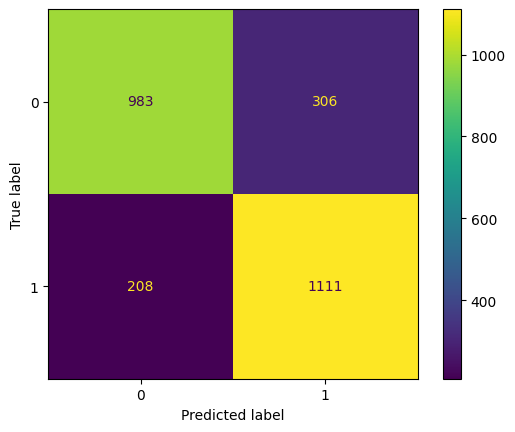

In [108]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression

estimators = [
    ('lgb', rd_search_lgb),
    ('rf', rd_search),
    ('xgb', rd_search_xgb)
]

model = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression(random_state=42))
model.fit(X_train,y_train)

y_pred = model.predict(X_test)

print(classification_report(y_test,y_pred))

print(f'Acurácia:{accuracy_score(y_test,y_pred)}')

cm = confusion_matrix(y_test,y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

# Submission

In [111]:
df_test

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Deck,Num,Side,total_spent
0,Earth,1,TRAPPIST-1e,27.00,0,0.0,0.0,0.0,0.0,0.0,G,3,S,0.0
1,Earth,0,TRAPPIST-1e,19.00,0,0.0,9.0,0.0,2823.0,0.0,F,4,S,2832.0
2,Europa,1,55 Cancri e,31.00,0,0.0,0.0,0.0,0.0,0.0,C,0,S,0.0
3,Europa,0,TRAPPIST-1e,38.00,0,0.0,6652.0,0.0,181.0,585.0,C,1,S,7418.0
4,Earth,0,TRAPPIST-1e,20.00,0,10.0,0.0,635.0,0.0,0.0,F,5,S,645.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4272,Earth,1,TRAPPIST-1e,34.00,0,0.0,0.0,0.0,0.0,0.0,G,1496,S,0.0
4273,Earth,0,TRAPPIST-1e,42.00,0,0.0,847.0,17.0,10.0,144.0,NaN,NaN,NaN,1018.0
4274,Mars,1,55 Cancri e,23.77,0,0.0,0.0,0.0,0.0,0.0,D,296,P,0.0
4275,Europa,0,unknown,34.41,0,0.0,2680.0,0.0,0.0,523.0,D,297,P,3203.0


In [125]:
X_test_transformer = transformer.transform(df_test.drop(columns=['PassengerId']))
y_pred = rd_search_lgb.predict(X_test_transformer)
df_submission = pd.DataFrame({'PassengerId':df_test['PassengerId'],'Transported':y_pred.astype(bool)})
df_submission.to_csv('submission.csv',index=False)

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
